# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

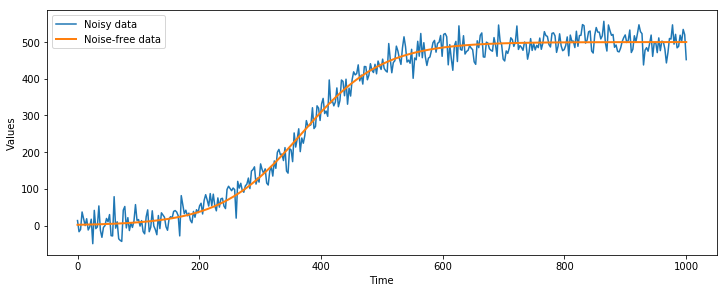

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

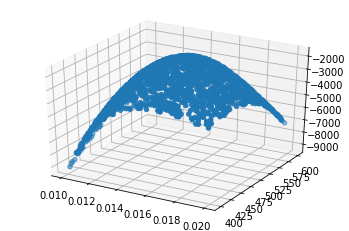

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=3, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 95,169
Trainable params: 95,169
Non-trainable params: 0
_________________________________________________________________


In [15]:
emu([0.015, 500])

array([[-1877.99]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1860.1858478408087

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


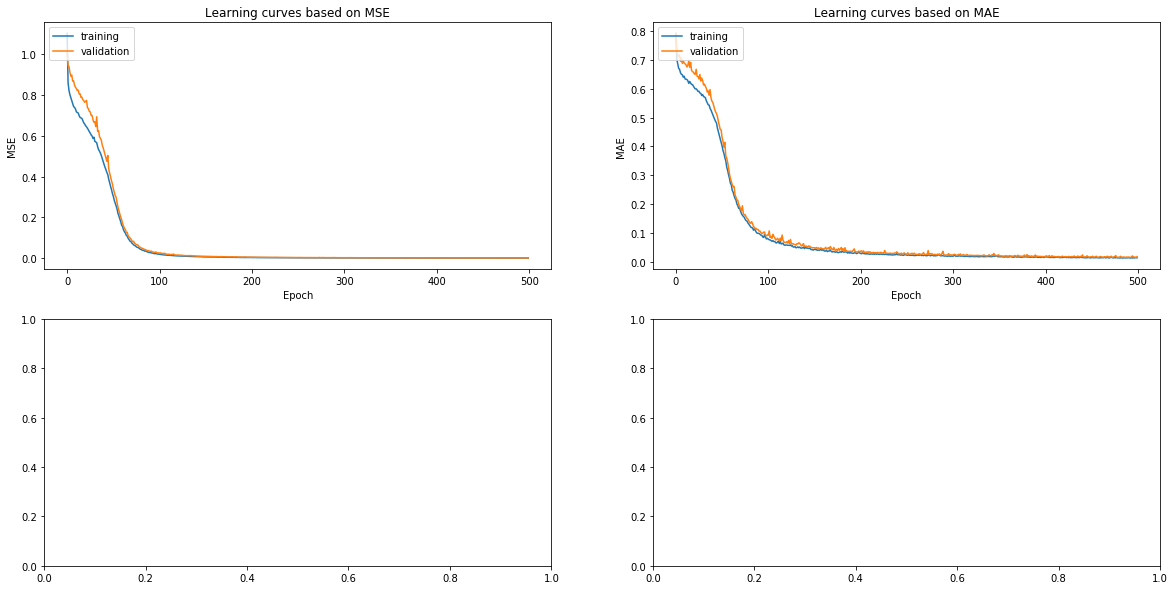

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

#ax3.plot(hist.history['rescaled_mse'])
#ax3.plot(hist.history['val_rescaled_mse'])
#ax3.set_ylabel('Rescaled MSE')
#ax3.set_xlabel('Epoch')
#ax3.legend(['training', 'validation'], loc='upper left')

#ax4.plot(hist.history['rescaled_mae'])
#ax4.plot(hist.history['val_rescaled_mae'])
#ax4.set_ylabel('Rescaled MAE')
#ax4.set_xlabel('Epoch')
#ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")


val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 0.0009508928175394734
Best epoch based on validation MSE: 498


Minimum MAE during validation: 0.014475676280756791
Best epoch based on validation MAE: 498


0.0010220135189592838
0.017572788012524446


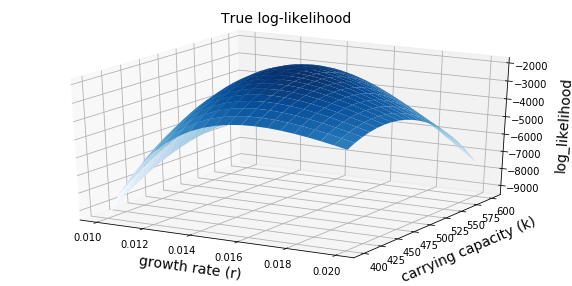

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

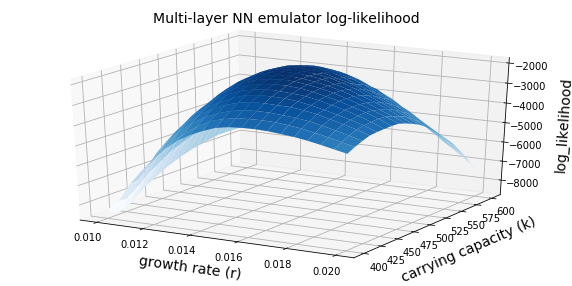

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.006888178802932256

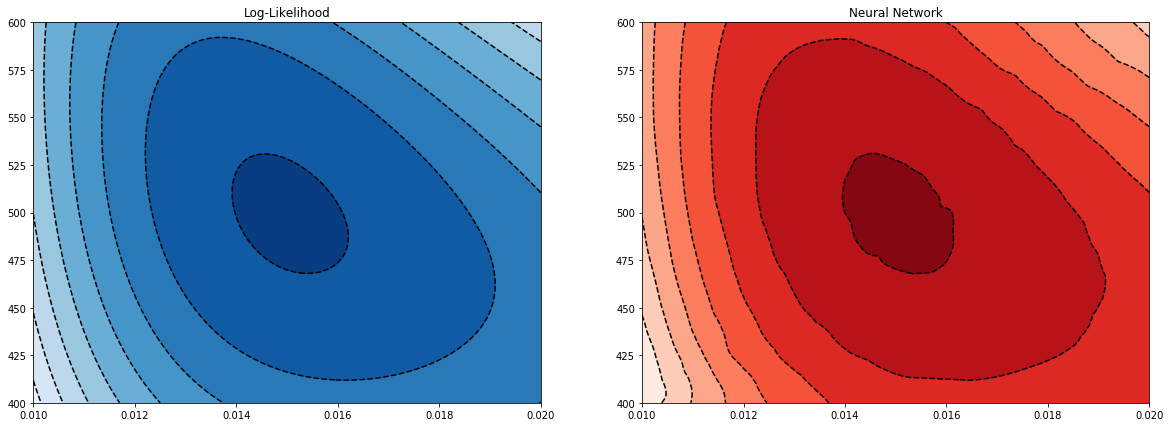

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

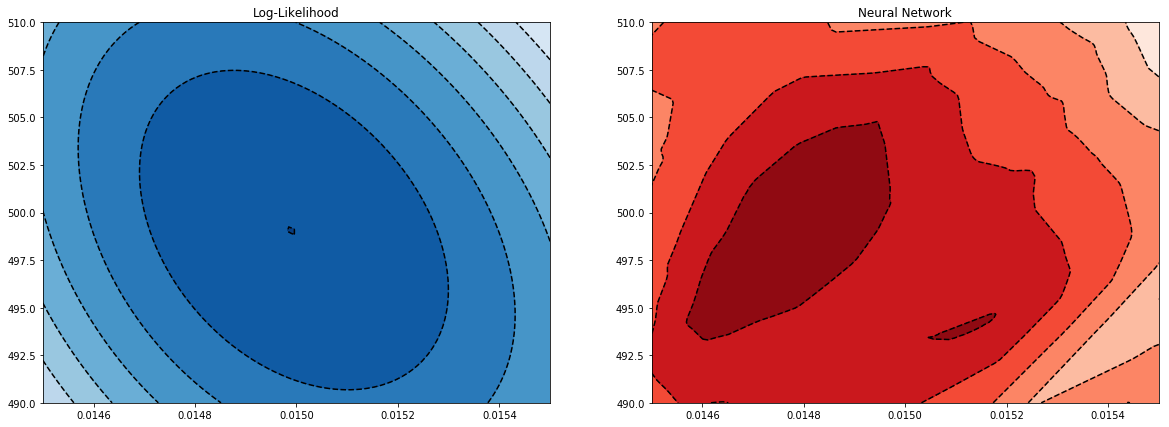

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0

[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]





[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[3.73151942e-09 4.66769055e-06]
 [4.66769055e-06 3.09507622e-02]]


[[4.07315946e-09 7.91036309e-06]
 [7.91036309e-06 5.13964935e-02]]


[[ 6.09748375e-09 -1.12808129e-06]
 [-1.12808129e-06  1.10371996e-03]]


[[3.81937143e-09 6.39617151e-06]
 [6.39617151e-06 3.91890294e-02]]


[[4.21149761e-09 9.48219942e-06]
 [9.48219942e-06 5.72016539e-02]]


[[ 5.71496319e-09 -1.13008910e-06]
 [-1.13008910e-06  1.07434601e-03]]


[[3.71316309e-09 7.00814243e-06]
 [7.00814243e-06 4.17820617e-02]]


[[4.03894518e-09 9.85113827e-06]
 [9.85113827e-06 5.95297241e-02]]


[[ 5.34471771e-09 -1.11538781e-06]
 [-1.11538781e-06  1.03679678e-03]]


[[3.57985412e-09 7.36874198e-06]
 [7.36874198e-06 4.31365620e-02]]


[[4.50335017e-09 1.34843367e-05]
 [1.34843367e-05 7.90954656e-02]]


[[ 4.95227856e-09 -1.05413071e-06]
 [-1.05413071e-06  9.65876058e-04]]


[[3.27750325e-09 6.95779639e-06]
 [6.95779639e-06 5.01872307e-02]]


[[4.55319163e-09 1.60777757e-05]
 [1.60777757e-05 1.04565836e-01]]


[[ 4.57673133e-09


[[ 1.55921115e-07 -3.56080001e-03]
 [-3.56080001e-03  8.38739458e+01]]


[[ 5.10133668e-08 -1.62926138e-03]
 [-1.62926138e-03  6.24890311e+01]]


[[ 3.91652029e-07 -8.87558317e-03]
 [-8.87558317e-03  3.42918932e+02]]


[[ 1.48940596e-07 -3.43287408e-03]
 [-3.43287408e-03  8.24459941e+01]]


[[ 4.84755366e-08 -1.54648326e-03]
 [-1.54648326e-03  5.92775044e+01]]


[[ 3.74115271e-07 -8.46286969e-03]
 [-8.46286969e-03  3.25962737e+02]]


[[ 1.42338974e-07 -3.31823310e-03]
 [-3.31823310e-03  8.18028355e+01]]


[[ 4.60690667e-08 -1.46816943e-03]
 [-1.46816943e-03  5.62429133e+01]]


[[ 3.58143775e-07 -8.08661480e-03]
 [-8.08661480e-03  3.10244234e+02]]


[[ 1.42992283e-07 -3.48823772e-03]
 [-3.48823772e-03  9.21547922e+01]]


[[ 4.40624415e-08 -1.39993837e-03]
 [-1.39993837e-03  5.34977464e+01]]


[[ 3.42729765e-07 -7.72529346e-03]
 [-7.72529346e-03  2.95291285e+02]]


[[ 1.42819571e-07 -3.61506266e-03]
 [-3.61506266e-03  1.00489976e+02]]


[[ 4.21313134e-08 -1.33477522e-03]
 [-1.33477522e-


[[ 2.44681382e-08 -2.48791868e-04]
 [-2.48791868e-04  1.06917685e+01]]


[[1.20795195e-08 9.34884541e-05]
 [9.34884541e-05 4.13721589e+01]]


[[ 6.27597927e-09 -3.12019737e-05]
 [-3.12019737e-05  3.64018013e+00]]


[[ 2.38872382e-08 -2.32802856e-04]
 [-2.32802856e-04  1.03752915e+01]]


[[1.16112163e-08 9.04717893e-05]
 [9.04717893e-05 3.98560221e+01]]


[[ 6.05171964e-09 -3.12443842e-05]
 [-3.12443842e-05  3.57324424e+00]]


[[ 2.33016869e-08 -2.17959018e-04]
 [-2.17959018e-04  1.00641909e+01]]


[[1.11621296e-08 8.75321652e-05]
 [8.75321652e-05 3.83953460e+01]]


[[ 5.88882563e-09 -3.29111097e-05]
 [-3.29111097e-05  3.54777781e+00]]


[[ 2.27139709e-08 -2.04171837e-04]
 [-2.04171837e-04  9.75884626e+00]]


[[1.07314308e-08 8.46699914e-05]
 [8.46699914e-05 3.69882783e+01]]


[[ 5.67897954e-09 -3.04937366e-05]
 [-3.04937366e-05  3.47726179e+00]]


[[ 2.21262744e-08 -1.91360030e-04]
 [-1.91360030e-04  9.45956897e+00]]


[[1.03183286e-08 8.18853489e-05]
 [8.18853489e-05 3.56330048e+01]]

 [-3.61693812e-05  2.92222577e+00]]


[[ 3.63470061e-09 -4.60816227e-05]
 [-4.60816227e-05  4.50537339e+00]]


[[ 4.82666557e-09 -1.01746578e-04]
 [-1.01746578e-04  6.41202351e+00]]


[[ 3.58626654e-09 -3.22426895e-05]
 [-3.22426895e-05  2.87132214e+00]]


[[ 3.57164754e-09 -4.27278915e-05]
 [-4.27278915e-05  4.42215967e+00]]


[[ 4.68322831e-09 -9.70591974e-05]
 [-9.70591974e-05  6.35004032e+00]]


[[ 3.63026121e-09 -2.86264319e-05]
 [-2.86264319e-05  2.81936175e+00]]


[[ 3.50727164e-09 -3.96075613e-05]
 [-3.96075613e-05  4.33780149e+00]]


[[ 4.54388211e-09 -9.26210013e-05]
 [-9.26210013e-05  6.28089998e+00]]


[[ 3.74588804e-09 -3.64464699e-05]
 [-3.64464699e-05  3.05619151e+00]]


[[ 3.44184887e-09 -3.67044333e-05]
 [-3.67044333e-05  4.25260192e+00]]


[[ 4.40853298e-09 -8.84171789e-05]
 [-8.84171789e-05  6.20546910e+00]]


[[ 3.84275273e-09 -4.34432931e-05]
 [-4.34432931e-05  3.26407816e+00]]


[[ 3.92347459e-09 -3.06735367e-05]
 [-3.06735367e-05  4.15508723e+00]]


[[ 4.27708690


[[ 3.50178974e-09 -3.01762692e-05]
 [-3.01762692e-05  2.84277896e+00]]


[[ 4.90908085e-09 -5.40697573e-05]
 [-5.40697573e-05  3.18835824e+00]]


[[ 2.05982547e-09 -4.26185159e-05]
 [-4.26185159e-05  2.64195828e+00]]


[[ 3.41023341e-09 -2.95522239e-05]
 [-2.95522239e-05  2.77042080e+00]]


[[ 4.90143100e-09 -5.37086601e-05]
 [-5.37086601e-05  3.10917314e+00]]


[[ 2.04323347e-09 -4.15380420e-05]
 [-4.15380420e-05  2.56825975e+00]]


[[ 3.32101468e-09 -2.89343493e-05]
 [-2.89343493e-05  2.69979359e+00]]


[[ 4.91762835e-09 -5.16962805e-05]
 [-5.16962805e-05  3.02375286e+00]]


[[ 2.02486706e-09 -4.04832140e-05]
 [-4.04832140e-05  2.49671939e+00]]


[[ 3.23408169e-09 -2.83231477e-05]
 [-2.83231477e-05  2.63086656e+00]]


[[ 4.78064277e-09 -5.03499893e-05]
 [-5.03499893e-05  2.95682058e+00]]


[[ 2.00490920e-09 -3.94535877e-05]
 [-3.94535877e-05  2.42727114e+00]]


[[ 3.19426846e-09 -2.78458622e-05]
 [-2.78458622e-05  2.55934185e+00]]


[[ 4.64766326e-09 -4.90378926e-05]
 [-4.90378926e-



[[ 3.61144494e-09 -2.37499229e-06]
 [-2.37499229e-06  1.94893017e+00]]


[[ 3.54915295e-09 -2.37956648e-05]
 [-2.37956648e-05  2.06563782e+00]]


[[ 3.95075476e-09 -8.52470057e-05]
 [-8.52470057e-05  5.15966842e+00]]


[[ 3.55178482e-09 -3.85875962e-06]
 [-3.85875962e-06  1.97766707e+00]]


[[ 3.49050934e-09 -2.29709936e-05]
 [-2.29709936e-05  2.01568057e+00]]


[[ 3.88631753e-09 -8.47764315e-05]
 [-8.47764315e-05  5.11103002e+00]]


[[ 3.49217768e-09 -5.22745421e-06]
 [-5.22745421e-06  2.00182731e+00]]


[[ 3.43191874e-09 -2.21792897e-05]
 [-2.21792897e-05  1.96695030e+00]]


[[ 3.98803540e-09 -8.32878629e-05]
 [-8.32878629e-05  4.98542614e+00]]


[[ 3.57473764e-09 -1.10432680e-05]
 [-1.10432680e-05  2.16017191e+00]]


[[ 3.37345479e-09 -2.14190741e-05]
 [-2.14190741e-05  1.91941754e+00]]


[[ 4.07731424e-09 -8.18074380e-05]
 [-8.18074380e-05  4.86301662e+00]]


[[ 3.64678665e-09 -1.64142336e-05]
 [-1.64142336e-05  2.30412206e+00]]


[[ 3.60911395e-09 -2.27918964e-05]
 [-2.27918964e

 [1.82063023e-05 2.34528587e+00]]


[[ 2.88850370e-09 -1.54430103e-05]
 [-1.54430103e-05  2.65139630e+00]]


[[ 1.11005725e-08 -1.05540798e-04]
 [-1.05540798e-04  4.73218517e+00]]


[[4.66108379e-09 1.25411932e-05]
 [1.25411932e-05 2.39013875e+00]]


[[ 2.82529386e-09 -1.43437853e-05]
 [-1.43437853e-05  2.82518653e+00]]


[[ 1.12554686e-08 -1.04254334e-04]
 [-1.04254334e-04  4.62784292e+00]]


[[4.82351465e-09 7.24612145e-06]
 [7.24612145e-06 2.42952829e+00]]


[[ 2.76347978e-09 -1.33042384e-05]
 [-1.33042384e-05  2.98435812e+00]]


[[ 1.1388479e-08 -1.0294883e-04]
 [-1.0294883e-04  4.5258439e+00]]


[[4.71679201e-09 7.52125458e-06]
 [7.52125458e-06 2.44898042e+00]]


[[ 2.70303165e-09 -1.23213490e-05]
 [-1.23213490e-05  3.12975503e+00]]


[[ 1.15009804e-08 -1.01627029e-04]
 [-1.01627029e-04  4.42613606e+00]]


[[4.61248557e-09 7.77021476e-06]
 [7.77021476e-06 2.46463929e+00]]


[[ 2.80368910e-09 -9.14667897e-06]
 [-9.14667897e-06  3.11071352e+00]]


[[ 1.15942750e-08 -1.00291495e-04]



[[ 3.88574826e-09 -1.19602872e-05]
 [-1.19602872e-05  4.98635177e+00]]


[[ 2.84200102e-09 -4.56616214e-05]
 [-4.56616214e-05  3.69947726e+00]]


[[ 5.45224974e-09 -1.69771194e-05]
 [-1.69771194e-05  2.59409403e+00]]


[[ 3.82997637e-09 -1.09308524e-05]
 [-1.09308524e-05  4.90609298e+00]]


[[ 2.78850198e-09 -4.54752746e-05]
 [-4.54752746e-05  3.72246046e+00]]


[[ 5.44720965e-09 -1.64367922e-05]
 [-1.64367922e-05  2.54026740e+00]]


[[ 3.77437289e-09 -9.95605405e-06]
 [-9.95605405e-06  4.82659856e+00]]


[[ 2.73592788e-09 -4.52613147e-05]
 [-4.52613147e-05  3.74080389e+00]]


[[ 5.35956780e-09 -1.64368993e-05]
 [-1.64368993e-05  2.49182706e+00]]


[[ 3.71897817e-09 -9.03329189e-06]
 [-9.03329189e-06  4.74789269e+00]]


[[ 2.68426787e-09 -4.50217057e-05]
 [-4.50217057e-05  3.75478760e+00]]


[[ 5.27276596e-09 -1.64228810e-05]
 [-1.64228810e-05  2.44425510e+00]]


[[ 3.66382970e-09 -8.16008588e-06]
 [-8.16008588e-06  4.66999720e+00]]


[[ 2.63351092e-09 -4.47583074e-05]
 [-4.47583074e-

 [-7.23171431e-05  6.46900215e+00]]


[[ 3.58878337e-09 -8.11382568e-06]
 [-8.11382568e-06  2.58575032e+00]]


[[ 1.98841922e-09 -9.46587137e-06]
 [-9.46587137e-06  2.62730723e+00]]


[[ 3.21794369e-09 -7.00927853e-05]
 [-7.00927853e-05  6.35969963e+00]]


[[ 3.56280965e-09 -8.04092781e-06]
 [-8.04092781e-06  2.53571085e+00]]


[[ 2.01769875e-09 -8.87584120e-06]
 [-8.87584120e-06  2.57872812e+00]]


[[ 3.19519040e-09 -6.79449384e-05]
 [-6.79449384e-05  6.25198376e+00]]


[[ 3.53568386e-09 -7.96625626e-06]
 [-7.96625626e-06  2.48667787e+00]]


[[ 2.04377958e-09 -8.31334866e-06]
 [-8.31334866e-06  2.53103890e+00]]


[[ 3.17137551e-09 -6.58707557e-05]
 [-6.58707557e-05  6.14584560e+00]]


[[ 3.50749599e-09 -7.88997568e-06]
 [-7.88997568e-06  2.43863040e+00]]


[[ 2.06683122e-09 -7.77720230e-06]
 [-7.77720230e-06  2.48422447e+00]]


[[ 3.14658094e-09 -6.38675026e-05]
 [-6.38675026e-05  6.04127541e+00]]


[[ 3.47833145e-09 -7.81224202e-06]
 [-7.81224202e-06  2.39154793e+00]]


[[ 2.08701539

 [-4.13899811e-05  4.50729673e+00]]


[[ 2.65105100e-09 -2.85211688e-05]
 [-2.85211688e-05  2.66469129e+00]]


[[ 2.94118560e-09 -1.98101147e-05]
 [-1.98101147e-05  1.33076193e+00]]


[[ 4.07142652e-09 -4.50312421e-05]
 [-4.50312421e-05  4.49878425e+00]]


[[ 2.64653198e-09 -3.00427435e-05]
 [-3.00427435e-05  2.71172933e+00]]


[[ 2.89171238e-09 -1.90811232e-05]
 [-1.90811232e-05  1.34162425e+00]]


[[ 4.03878421e-09 -4.37748316e-05]
 [-4.37748316e-05  4.42190498e+00]]


[[ 2.64053301e-09 -3.14623581e-05]
 [-3.14623581e-05  2.75445347e+00]]


[[ 2.84303338e-09 -1.83791671e-05]
 [-1.83791671e-05  1.35102417e+00]]


[[ 4.00527997e-09 -4.25579128e-05]
 [-4.25579128e-05  4.34630782e+00]]


[[ 2.59277607e-09 -3.07654304e-05]
 [-3.07654304e-05  2.88702859e+00]]


[[ 2.79513814e-09 -1.77032298e-05]
 [-1.77032298e-05  1.35903645e+00]]


[[ 3.97098478e-09 -4.13791334e-05]
 [-4.13791334e-05  4.27197379e+00]]


[[ 2.58140494e-09 -3.00956939e-05]
 [-3.00956939e-05  2.83511334e+00]]


[[ 2.74801619

 [-7.37913135e-07  2.31928445e+00]]


[[ 4.07613696e-09 -1.39709860e-05]
 [-1.39709860e-05  1.69246418e+00]]


[[ 2.03203941e-09 -2.82258581e-05]
 [-2.82258581e-05  1.94097072e+00]]


[[ 2.83813833e-09 -2.93604974e-08]
 [-2.93604974e-08  2.28616310e+00]]


[[ 4.01747428e-09 -1.32691236e-05]
 [-1.32691236e-05  1.68258349e+00]]


[[ 2.08224908e-09 -3.07142111e-05]
 [-3.07142111e-05  2.01159062e+00]]


[[ 2.98517013e-09 -2.72905727e-06]
 [-2.72905727e-06  2.28425096e+00]]


[[ 3.95947667e-09 -1.25954511e-05]
 [-1.25954511e-05  1.67222995e+00]]


[[ 2.12563325e-09 -3.20509829e-05]
 [-3.20509829e-05  2.02104215e+00]]


[[ 3.12294450e-09 -5.28905869e-06]
 [-5.28905869e-06  2.28110846e+00]]


[[ 3.90214495e-09 -1.19489049e-05]
 [-1.19489049e-05  1.66143471e+00]]


[[ 2.09661118e-09 -3.16598916e-05]
 [-3.16598916e-05  1.98982587e+00]]


[[ 3.18965278e-09 -3.29195344e-06]
 [-3.29195344e-06  2.27232823e+00]]


[[ 3.84547945e-09 -1.13284606e-05]
 [-1.13284606e-05  1.65022756e+00]]


[[ 2.06785603

 [-2.04027204e-05  1.91516444e+00]]


[[ 3.80016045e-09 -2.86557378e-05]
 [-2.86557378e-05  4.55687119e+00]]


[[ 4.94124862e-09 -6.19104473e-05]
 [-6.19104473e-05  2.50146036e+00]]


[[ 2.02028944e-09 -2.37575941e-05]
 [-2.37575941e-05  2.08384556e+00]]


[[ 3.76634302e-09 -2.89222507e-05]
 [-2.89222507e-05  4.50194246e+00]]


[[ 4.90638586e-09 -6.17415819e-05]
 [-6.17415819e-05  2.47623428e+00]]


[[ 2.04231524e-09 -2.46423789e-05]
 [-2.46423789e-05  2.07942065e+00]]


[[ 3.73219480e-09 -2.91606637e-05]
 [-2.91606637e-05  4.44732296e+00]]


[[ 4.87064788e-09 -6.15486036e-05]
 [-6.15486036e-05  2.45093692e+00]]


[[ 2.06220306e-09 -2.54713173e-05]
 [-2.54713173e-05  2.07412234e+00]]


[[ 3.69775113e-09 -2.93722431e-05]
 [-2.93722431e-05  4.39302753e+00]]


[[ 4.83409796e-09 -6.13328180e-05]
 [-6.13328180e-05  2.42558581e+00]]


[[ 2.08735002e-09 -2.41783094e-05]
 [-2.41783094e-05  2.05365302e+00]]


[[ 3.66304577e-09 -2.95582063e-05]
 [-2.95582063e-05  4.33907008e+00]]


[[ 4.79679664

[[ 3.35210676e-09 -4.00759487e-05]
 [-4.00759487e-05  4.75805487e+00]]


[[ 4.07525172e-09 -5.20079865e-05]
 [-5.20079865e-05  2.39227172e+00]]


[[ 3.15398267e-09 -2.02386764e-05]
 [-2.02386764e-05  5.98920876e+00]]


[[ 3.49871816e-09 -4.40218861e-05]
 [-4.40218861e-05  4.78952512e+00]]


[[ 4.42406886e-09 -5.32036128e-05]
 [-5.32036128e-05  2.36499203e+00]]


[[ 3.10631342e-09 -2.02373886e-05]
 [-2.02373886e-05  5.98496505e+00]]


[[ 3.63549379e-09 -4.93187526e-05]
 [-4.93187526e-05  4.90271287e+00]]


[[ 4.75467193e-09 -5.43187793e-05]
 [-5.43187793e-05  2.33785196e+00]]


[[ 3.05937457e-09 -2.02265691e-05]
 [-2.02265691e-05  5.97808093e+00]]


[[ 3.64435453e-09 -4.59788016e-05]
 [-4.59788016e-05  4.92924262e+00]]


[[ 4.73201746e-09 -5.35079088e-05]
 [-5.35079088e-05  2.30176003e+00]]


[[ 3.01315503e-09 -2.02066740e-05]
 [-2.02066740e-05  5.96868474e+00]]


[[ 3.65108308e-09 -4.27712585e-05]
 [-4.27712585e-05  4.95221714e+00]]


[[ 4.66993403e-09 -5.36507340e-05]
 [-5.36507340e-0

[[ 3.18217610e-09 -5.52570349e-05]
 [-5.52570349e-05  2.93919193e+00]]


[[ 3.30950276e-09 -4.24447333e-05]
 [-4.24447333e-05  2.63621876e+00]]


[[ 4.20751615e-09 -5.19842563e-05]
 [-5.19842563e-05  4.83037280e+00]]


[[ 3.16235599e-09 -5.49679153e-05]
 [-5.49679153e-05  2.90601957e+00]]


[[ 3.26100155e-09 -4.18822404e-05]
 [-4.18822404e-05  2.60913910e+00]]


[[ 4.15561593e-09 -5.25070958e-05]
 [-5.25070958e-05  4.92223109e+00]]


[[ 3.14204420e-09 -5.46678051e-05]
 [-5.46678051e-05  2.87305540e+00]]


[[ 3.21323152e-09 -4.13264721e-05]
 [-4.13264721e-05  2.58212707e+00]]


[[ 4.10421037e-09 -5.29841820e-05]
 [-5.29841820e-05  5.00790983e+00]]


[[ 3.12127214e-09 -5.43573369e-05]
 [-5.43573369e-05  2.84030502e+00]]


[[ 3.16618140e-09 -4.07773779e-05]
 [-4.07773779e-05  2.55519189e+00]]


[[ 4.84725556e-09 -6.98501754e-05]
 [-6.98501754e-05  5.32162908e+00]]


[[ 3.10007004e-09 -5.40371191e-05]
 [-5.40371191e-05  2.80777367e+00]]


[[ 3.11984011e-09 -4.02349062e-05]
 [-4.02349062e-0

[[ 3.08136766e-09 -1.01243441e-05]
 [-1.01243441e-05  1.37975932e+00]]


[[ 6.43626040e-09 -5.23381759e-05]
 [-5.23381759e-05  3.30645872e+00]]


[[ 1.60313235e-09 -1.27070331e-05]
 [-1.27070331e-05  2.42901329e+00]]


[[ 3.08247948e-09 -1.02906365e-05]
 [-1.02906365e-05  1.36237862e+00]]


[[ 6.43310976e-09 -5.25529988e-05]
 [-5.25529988e-05  3.27005394e+00]]


[[ 1.59121777e-09 -1.19836617e-05]
 [-1.19836617e-05  2.42213141e+00]]


[[ 3.05286363e-09 -9.92516322e-06]
 [-9.92516322e-06  1.34657034e+00]]


[[ 6.46489234e-09 -5.64932617e-05]
 [-5.64932617e-05  3.40248091e+00]]


[[ 1.57917565e-09 -1.12861288e-05]
 [-1.12861288e-05  2.41457941e+00]]


[[ 3.02328887e-09 -9.57120848e-06]
 [-9.57120848e-06  1.33089629e+00]]


[[ 6.49276525e-09 -6.02444585e-05]
 [-6.02444585e-05  3.52795685e+00]]


[[ 1.56701654e-09 -1.06136083e-05]
 [-1.06136083e-05  2.40638942e+00]]


[[ 3.23887897e-09 -1.06298252e-05]
 [-1.06298252e-05  1.31760974e+00]]


[[ 6.51688590e-09 -6.38131984e-05]
 [-6.38131984e-0


[[ 3.96395429e-09 -4.79915881e-05]
 [-4.79915881e-05  3.14169741e+00]]


[[ 5.05658415e-09 -3.26375420e-05]
 [-3.26375420e-05  2.60090931e+00]]


[[ 7.78398090e-09 -8.54378365e-05]
 [-8.54378365e-05  2.39098308e+00]]


[[ 3.97183991e-09 -4.79746676e-05]
 [-4.79746676e-05  3.10546996e+00]]


[[ 5.00118171e-09 -3.30291932e-05]
 [-3.30291932e-05  2.61758535e+00]]


[[ 7.72035711e-09 -8.54364016e-05]
 [-8.54364016e-05  2.39031698e+00]]


[[ 3.99737686e-09 -4.97633804e-05]
 [-4.97633804e-05  3.13810669e+00]]


[[ 4.94619635e-09 -3.33927593e-05]
 [-3.33927593e-05  2.63262032e+00]]


[[ 7.65648556e-09 -8.54036200e-05]
 [-8.54036200e-05  2.38879936e+00]]


[[ 4.02040483e-09 -5.14609823e-05]
 [-5.14609823e-05  3.16826126e+00]]


[[ 5.20241258e-09 -3.79811620e-05]
 [-3.79811620e-05  2.67542920e+00]]


[[ 7.59240122e-09 -8.53408082e-05]
 [-8.53408082e-05  2.38646622e+00]]


[[ 4.03912791e-09 -5.27979648e-05]
 [-5.27979648e-05  3.18170525e+00]]


[[ 5.31595684e-09 -4.12979856e-05]
 [-4.12979856e-

 [-6.18629130e-05  5.04955573e+00]]


[[ 4.65720511e-09 -6.00519149e-05]
 [-6.00519149e-05  1.92190325e+00]]


[[ 3.36449754e-09 -4.42409981e-05]
 [-4.42409981e-05  2.84609506e+00]]


[[ 4.17841625e-09 -6.11585876e-05]
 [-6.11585876e-05  5.04664190e+00]]


[[ 4.70716080e-09 -5.98321177e-05]
 [-5.98321177e-05  1.89957583e+00]]


[[ 3.58225725e-09 -4.50686989e-05]
 [-4.50686989e-05  2.81629441e+00]]


[[ 4.14685658e-09 -6.02231075e-05]
 [-6.02231075e-05  4.98115149e+00]]


[[ 4.75354204e-09 -5.96004727e-05]
 [-5.96004727e-05  1.87747537e+00]]


[[ 3.79023421e-09 -4.58484474e-05]
 [-4.58484474e-05  2.78670050e+00]]


[[ 4.11511795e-09 -5.93037687e-05]
 [-5.93037687e-05  4.91652938e+00]]


[[ 4.81797096e-09 -5.99311074e-05]
 [-5.99311074e-05  1.86260435e+00]]


[[ 3.98874627e-09 -4.65818878e-05]
 [-4.65818878e-05  2.75731568e+00]]


[[ 4.08321891e-09 -5.84002537e-05]
 [-5.84002537e-05  4.85276393e+00]]


[[ 4.87822389e-09 -6.02282796e-05]
 [-6.02282796e-05  1.84768057e+00]]


[[ 3.94570941


[[ 6.77270892e-09 -6.37175300e-05]
 [-6.37175300e-05  2.24959356e+00]]


[[ 8.14795767e-09 -2.98715512e-05]
 [-2.98715512e-05  3.20576679e+00]]


[[ 4.76523943e-09 -4.69309150e-05]
 [-4.69309150e-05  4.04268907e+00]]


[[ 7.00642321e-09 -7.05448527e-05]
 [-7.05448527e-05  2.40344229e+00]]


[[ 8.19757244e-09 -3.54657690e-05]
 [-3.54657690e-05  3.39824049e+00]]


[[ 4.82676412e-09 -4.53075232e-05]
 [-4.53075232e-05  4.00006261e+00]]


[[ 7.23453534e-09 -7.63678452e-05]
 [-7.63678452e-05  2.51531917e+00]]


[[ 8.24268043e-09 -4.08361522e-05]
 [-4.08361522e-05  3.58231628e+00]]


[[ 4.77379341e-09 -4.59575480e-05]
 [-4.59575480e-05  4.13130701e+00]]


[[ 7.45167420e-09 -8.19453407e-05]
 [-8.19453407e-05  2.62214435e+00]]


[[ 8.19020537e-09 -4.33372246e-05]
 [-4.33372246e-05  3.71196576e+00]]


[[ 4.72130858e-09 -4.65682261e-05]
 [-4.65682261e-05  4.25625100e+00]]


[[ 7.65819237e-09 -8.72849864e-05]
 [-8.72849864e-05  2.72407785e+00]]


[[ 8.13710633e-09 -4.57295349e-05]
 [-4.57295349e-

 [-9.87506418e-05  3.92467551e+00]]


[[ 4.27868075e-09 -2.52698961e-05]
 [-2.52698961e-05  2.68712517e+00]]


[[ 5.37330113e-09 -2.42970864e-05]
 [-2.42970864e-05  2.58174487e+00]]


[[ 7.01335339e-09 -9.79994906e-05]
 [-9.79994906e-05  3.90618580e+00]]


[[ 4.25644200e-09 -2.72286066e-05]
 [-2.72286066e-05  2.82403310e+00]]


[[ 5.30910700e-09 -2.39190124e-05]
 [-2.39190124e-05  2.55367113e+00]]


[[ 6.93425738e-09 -9.72465991e-05]
 [-9.72465991e-05  3.88720584e+00]]


[[ 4.23374590e-09 -2.91071666e-05]
 [-2.91071666e-05  2.95506299e+00]]


[[ 5.24568272e-09 -2.35476717e-05]
 [-2.35476717e-05  2.52586468e+00]]


[[ 6.85599241e-09 -9.64922687e-05]
 [-9.64922687e-05  3.86775997e+00]]


[[ 4.21061672e-09 -3.09079934e-05]
 [-3.09079934e-05  3.08039420e+00]]


[[ 5.20233119e-09 -2.30891154e-05]
 [-2.30891154e-05  2.49625720e+00]]


[[ 6.77855184e-09 -9.57367898e-05]
 [-9.57367898e-05  3.84787174e+00]]


[[ 4.26462444e-09 -3.24609917e-05]
 [-3.24609917e-05  3.07794537e+00]]


[[ 5.15901685

 [-6.56338554e-05  4.12720252e+00]]


[[ 4.71573611e-09 -5.19249170e-05]
 [-5.19249170e-05  3.66527691e+00]]


[[ 4.29859661e-09 -5.96304288e-05]
 [-5.96304288e-05  4.21600705e+00]]


[[ 6.21934380e-09 -6.75823435e-05]
 [-6.75823435e-05  4.15730145e+00]]


[[ 4.79381958e-09 -5.41150411e-05]
 [-5.41150411e-05  3.68042809e+00]]


[[ 4.34688250e-09 -5.90069468e-05]
 [-5.90069468e-05  4.16592554e+00]]


[[ 6.23718121e-09 -6.94424315e-05]
 [-6.94424315e-05  4.18515949e+00]]


[[ 4.73777279e-09 -5.37825466e-05]
 [-5.37825466e-05  3.73726249e+00]]


[[ 4.39222643e-09 -5.83890806e-05]
 [-5.83890806e-05  4.11645647e+00]]


[[ 6.25263120e-09 -7.12167838e-05]
 [-7.12167838e-05  4.21084985e+00]]


[[ 4.68239037e-09 -5.34467797e-05]
 [-5.34467797e-05  3.79102339e+00]]


[[ 4.43472195e-09 -5.77768080e-05]
 [-5.77768080e-05  4.06759214e+00]]


[[ 6.26577592e-09 -7.29079925e-05]
 [-7.29079925e-05  4.23444370e+00]]


[[ 4.62766447e-09 -5.31079580e-05]
 [-5.31079580e-05  3.84180661e+00]]


[[ 4.47446001

 [-4.44111865e-05  3.46609796e+00]]


[[ 2.77318039e-09 -2.93688288e-05]
 [-2.93688288e-05  2.51446134e+00]]


[[ 2.92131686e-09 -3.06903525e-05]
 [-3.06903525e-05  2.83008367e+00]]


[[ 4.78213868e-09 -4.38766294e-05]
 [-4.38766294e-05  3.42644747e+00]]


[[ 2.84780160e-09 -3.12236387e-05]
 [-3.12236387e-05  2.53052947e+00]]


[[ 2.88912079e-09 -3.00582225e-05]
 [-3.00582225e-05  2.84622241e+00]]


[[ 4.72792336e-09 -4.33489251e-05]
 [-4.33489251e-05  3.38725964e+00]]


[[ 2.91908360e-09 -3.30059531e-05]
 [-3.30059531e-05  2.54536946e+00]]


[[ 2.85727202e-09 -2.94399921e-05]
 [-2.94399921e-05  2.86104673e+00]]


[[ 4.67432950e-09 -4.28279784e-05]
 [-4.28279784e-05  3.34852902e+00]]


[[ 2.98712445e-09 -3.47178361e-05]
 [-3.47178361e-05  2.55902053e+00]]


[[ 2.82426775e-09 -2.91064533e-05]
 [-2.91064533e-05  2.84490487e+00]]


[[ 4.62135003e-09 -4.23136951e-05]
 [-4.23136951e-05  3.31025021e+00]]


[[ 3.05201966e-09 -3.63612981e-05]
 [-3.63612981e-05  2.57152085e+00]]


[[ 2.79165623


[[ 3.38287680e-09 -2.24839937e-05]
 [-2.24839937e-05  3.08713897e+00]]


[[ 6.22077677e-09 -7.48170183e-05]
 [-7.48170183e-05  4.55081659e+00]]


[[ 3.99891767e-09 -2.40565316e-05]
 [-2.40565316e-05  3.66243593e+00]]


[[ 3.34543091e-09 -2.22284528e-05]
 [-2.22284528e-05  3.05245256e+00]]


[[ 6.15739833e-09 -7.47836829e-05]
 [-7.47836829e-05  4.59932999e+00]]


[[ 3.96555063e-09 -2.30694722e-05]
 [-2.30694722e-05  3.66569884e+00]]


[[ 3.30840552e-09 -2.19759325e-05]
 [-2.19759325e-05  3.01816733e+00]]


[[ 6.09460728e-09 -7.47326918e-05]
 [-7.47326918e-05  4.64505544e+00]]


[[ 3.92127981e-09 -2.28418739e-05]
 [-2.28418739e-05  3.62816966e+00]]


[[ 3.27179592e-09 -2.17263956e-05]
 [-2.17263956e-05  2.98427851e+00]]


[[ 6.03239994e-09 -7.46646642e-05]
 [-7.46646642e-05  4.68807660e+00]]


[[ 3.87751496e-09 -2.26162042e-05]
 [-2.26162042e-05  3.59099318e+00]]


[[ 3.23559744e-09 -2.14798050e-05]
 [-2.14798050e-05  2.95078137e+00]]


[[ 5.96797086e-09 -7.39345473e-05]
 [-7.39345473e-

 [-4.83679817e-05  2.43296608e+00]]


[[ 7.40854025e-09 -8.27157949e-05]
 [-8.27157949e-05  3.99702155e+00]]


[[ 5.82635188e-09 -6.22366111e-05]
 [-6.22366111e-05  4.93062895e+00]]


[[ 3.94021555e-09 -4.80708241e-05]
 [-4.80708241e-05  2.41408802e+00]]


[[ 7.33847228e-09 -8.28412738e-05]
 [-8.28412738e-05  4.04944023e+00]]


[[ 5.79166845e-09 -6.30149741e-05]
 [-6.30149741e-05  4.94988359e+00]]


[[ 3.90389197e-09 -4.77719556e-05]
 [-4.77719556e-05  2.39525376e+00]]


[[ 7.26895335e-09 -8.29428928e-05]
 [-8.29428928e-05  4.09917454e+00]]


[[ 5.75674272e-09 -6.37528073e-05]
 [-6.37528073e-05  4.96732794e+00]]


[[ 3.86782951e-09 -4.74715076e-05]
 [-4.74715076e-05  2.37646651e+00]]


[[ 7.19998241e-09 -8.30214242e-05]
 [-8.30214242e-05  4.14630182e+00]]


[[ 5.72159145e-09 -6.44512814e-05]
 [-6.44512814e-05  4.98301813e+00]]


[[ 3.83202839e-09 -4.71696077e-05]
 [-4.71696077e-05  2.35772937e+00]]


[[ 7.13155831e-09 -8.30776198e-05]
 [-8.30776198e-05  4.19089746e+00]]


[[ 5.68623093

[[ 4.08300076e-09 -6.41719301e-06]
 [-6.41719301e-06  4.38821268e+00]]


[[ 3.13224201e-09 -3.85779636e-05]
 [-3.85779636e-05  2.00294973e+00]]


[[ 6.11124611e-09 -7.33976815e-05]
 [-7.33976815e-05  3.78501661e+00]]


[[ 4.24255921e-09 -9.77520306e-06]
 [-9.77520306e-06  4.39916114e+00]]


[[ 3.13132592e-09 -3.91580118e-05]
 [-3.91580118e-05  2.01181815e+00]]


[[ 6.04688650e-09 -7.26724824e-05]
 [-7.26724824e-05  3.74847147e+00]]


[[ 4.39605361e-09 -1.30236075e-05]
 [-1.30236075e-05  4.40876268e+00]]


[[ 3.12972962e-09 -3.97106372e-05]
 [-3.97106372e-05  2.01994711e+00]]


[[ 5.98321502e-09 -7.19540090e-05]
 [-7.19540090e-05  3.71224571e+00]]


[[ 4.54364525e-09 -1.61652094e-05]
 [-1.61652094e-05  4.41705893e+00]]


[[ 3.12747565e-09 -4.02366027e-05]
 [-4.02366027e-05  2.02735877e+00]]


[[ 5.92022430e-09 -7.12422122e-05]
 [-7.12422122e-05  3.67633749e+00]]


[[ 4.68549151e-09 -1.92027452e-05]
 [-1.92027452e-05  4.42409042e+00]]


[[ 3.12458596e-09 -4.07366523e-05]
 [-4.07366523e-0

 [-2.04704873e-05  4.10730722e+00]]


[[ 5.41916305e-09 -1.07885321e-04]
 [-1.07885321e-04  4.00122217e+00]]


[[ 3.09823731e-09 -3.39468654e-05]
 [-3.39468654e-05  2.39285803e+00]]


[[ 5.03103229e-09 -2.04056391e-05]
 [-2.04056391e-05  4.06474844e+00]]


[[ 5.41612943e-09 -1.08881754e-04]
 [-1.08881754e-04  4.04369227e+00]]


[[ 3.07458652e-09 -3.37360815e-05]
 [-3.37360815e-05  2.37029355e+00]]


[[ 5.07042262e-09 -2.03384107e-05]
 [-2.03384107e-05  4.02264077e+00]]


[[ 5.41202143e-09 -1.09823581e-04]
 [-1.09823581e-04  4.08396384e+00]]


[[ 3.05101034e-09 -3.35245953e-05]
 [-3.35245953e-05  2.34792180e+00]]


[[ 5.10748995e-09 -2.02688928e-05]
 [-2.02688928e-05  3.98097933e+00]]


[[ 5.40687414e-09 -1.10712326e-04]
 [-1.10712326e-04  4.12209771e+00]]


[[ 3.02751171e-09 -3.33124768e-05]
 [-3.33124768e-05  2.32574168e+00]]


[[ 5.14229977e-09 -2.01971738e-05]
 [-2.01971738e-05  3.93975932e+00]]


[[ 5.40072174e-09 -1.11549477e-04]
 [-1.11549477e-04  4.15815324e+00]]


[[ 3.00409345

 [-6.95878546e-05  4.48294479e+00]]


[[ 3.46501689e-09 -3.71924224e-05]
 [-3.71924224e-05  3.64307494e+00]]


[[ 3.19291384e-09 -3.34061934e-05]
 [-3.34061934e-05  3.02235494e+00]]


[[ 5.38999163e-09 -6.96724573e-05]
 [-6.96724573e-05  4.46711020e+00]]


[[ 3.47272083e-09 -3.67880054e-05]
 [-3.67880054e-05  3.60602202e+00]]


[[ 3.16103591e-09 -3.31293880e-05]
 [-3.31293880e-05  2.99812766e+00]]


[[ 5.35582951e-09 -6.97401354e-05]
 [-6.97401354e-05  4.45083863e+00]]


[[ 3.47947488e-09 -3.63883437e-05]
 [-3.63883437e-05  3.56935631e+00]]


[[ 3.12947904e-09 -3.28542008e-05]
 [-3.28542008e-05  2.97402173e+00]]


[[ 5.45175939e-09 -6.92121259e-05]
 [-6.92121259e-05  4.40579518e+00]]


[[ 3.48530707e-09 -3.59933756e-05]
 [-3.59933756e-05  3.53307365e+00]]


[[ 3.09824003e-09 -3.25806404e-05]
 [-3.25806404e-05  2.95003855e+00]]


[[ 5.39897686e-09 -6.88609278e-05]
 [-6.88609278e-05  4.40801898e+00]]


[[ 3.49024477e-09 -3.56030400e-05]
 [-3.56030400e-05  3.49716993e+00]]


[[ 3.06731571

 [-6.00770059e-05  4.58266247e+00]]


[[ 2.94338581e-09 -1.26860012e-05]
 [-1.26860012e-05  2.75495933e+00]]


[[ 2.69076340e-09 -2.44027649e-05]
 [-2.44027649e-05  2.34874076e+00]]


[[ 5.37821174e-09 -6.00978736e-05]
 [-6.00978736e-05  4.57131889e+00]]


[[ 2.91764976e-09 -1.24811571e-05]
 [-1.24811571e-05  2.72928161e+00]]


[[ 2.66935222e-09 -2.43793172e-05]
 [-2.43793172e-05  2.33433818e+00]]


[[ 5.33565518e-09 -6.01062818e-05]
 [-6.01062818e-05  4.55941318e+00]]


[[ 2.89210649e-09 -1.22799632e-05]
 [-1.22799632e-05  2.70383204e+00]]


[[ 2.66349023e-09 -2.50545029e-05]
 [-2.50545029e-05  2.35181265e+00]]


[[ 5.29331696e-09 -6.01026069e-05]
 [-6.01026069e-05  4.54696486e+00]]


[[ 2.86675540e-09 -1.20823500e-05]
 [-1.20823500e-05  2.67860891e+00]]


[[ 2.65727867e-09 -2.57046275e-05]
 [-2.57046275e-05  2.36830319e+00]]


[[ 5.25119914e-09 -6.00872163e-05]
 [-6.00872163e-05  4.53399293e+00]]


[[ 2.84725431e-09 -1.17163717e-05]
 [-1.17163717e-05  2.65868778e+00]]


[[ 2.65072942

 [-7.40446060e-05  5.87228016e+00]]


[[ 4.05810149e-09 -3.88793983e-05]
 [-3.88793983e-05  2.37412705e+00]]


[[ 2.48085194e-09 -2.98450807e-05]
 [-2.98450807e-05  2.15840243e+00]]


[[ 4.04377655e-09 -7.24389129e-05]
 [-7.24389129e-05  5.83278249e+00]]


[[ 4.02031822e-09 -3.84539660e-05]
 [-3.84539660e-05  2.35233227e+00]]


[[ 2.46223008e-09 -2.92162434e-05]
 [-2.92162434e-05  2.15816425e+00]]


[[ 4.04799532e-09 -7.08663998e-05]
 [-7.08663998e-05  5.79333812e+00]]


[[ 3.98287959e-09 -3.80336975e-05]
 [-3.80336975e-05  2.33073003e+00]]


[[ 2.57311636e-09 -2.96380169e-05]
 [-2.96380169e-05  2.14086721e+00]]


[[ 4.05132917e-09 -6.93263904e-05]
 [-6.93263904e-05  5.75395320e+00]]


[[ 3.94578271e-09 -3.76185220e-05]
 [-3.76185220e-05  2.30931885e+00]]


[[ 2.68028572e-09 -3.00419161e-05]
 [-3.00419161e-05  2.12367145e+00]]


[[ 4.05380371e-09 -6.78182221e-05]
 [-6.78182221e-05  5.71463369e+00]]


[[ 3.91471087e-09 -3.74639737e-05]
 [-3.74639737e-05  2.29298517e+00]]


[[ 2.78382745

 [-6.86947070e-05  4.55589622e+00]]


[[ 4.03687057e-09 -5.21458570e-05]
 [-5.21458570e-05  2.18974704e+00]]


[[ 3.19715544e-09 -5.55676377e-05]
 [-5.55676377e-05  3.30925107e+00]]


[[ 4.04556511e-09 -6.83917786e-05]
 [-6.83917786e-05  4.51958312e+00]]


[[ 4.01481675e-09 -5.18033205e-05]
 [-5.18033205e-05  2.17032179e+00]]


[[ 3.17513178e-09 -5.45848125e-05]
 [-5.45848125e-05  3.30193189e+00]]


[[ 4.02405019e-09 -6.80851356e-05]
 [-6.80851356e-05  4.48349026e+00]]


[[ 3.99266694e-09 -5.14612024e-05]
 [-5.14612024e-05  2.15105911e+00]]


[[ 3.15316317e-09 -5.36202025e-05]
 [-5.36202025e-05  3.29422455e+00]]


[[ 4.00242242e-09 -6.77749437e-05]
 [-6.77749437e-05  4.44761802e+00]]


[[ 3.97042809e-09 -5.11195549e-05]
 [-5.11195549e-05  2.13195788e+00]]


[[ 3.13125215e-09 -5.26734596e-05]
 [-5.26734596e-05  3.28614179e+00]]


[[ 4.07185404e-09 -6.72381861e-05]
 [-6.72381861e-05  4.40534910e+00]]


[[ 3.94810699e-09 -5.07784286e-05]
 [-5.07784286e-05  2.11301702e+00]]


[[ 3.10940115


[[ 4.56786622e-09 -7.79730443e-05]
 [-7.79730443e-05  3.99694700e+00]]


[[ 2.82492005e-09 -3.95636701e-05]
 [-3.95636701e-05  3.03528972e+00]]


[[ 4.38374158e-09 -7.83800344e-05]
 [-7.83800344e-05  2.89402082e+00]]


[[ 4.52533464e-09 -7.72078207e-05]
 [-7.72078207e-05  3.96984601e+00]]


[[ 2.79873995e-09 -3.92060063e-05]
 [-3.92060063e-05  3.00764447e+00]]


[[ 4.35235921e-09 -7.79395561e-05]
 [-7.79395561e-05  2.87588747e+00]]


[[ 4.83219013e-09 -8.57625456e-05]
 [-8.57625456e-05  4.17922454e+00]]


[[ 2.77280705e-09 -3.88515515e-05]
 [-3.88515515e-05  2.98025121e+00]]


[[ 4.32408843e-09 -7.82230605e-05]
 [-7.82230605e-05  2.93174715e+00]]


[[ 5.12961841e-09 -9.40629455e-05]
 [-9.40629455e-05  4.38201752e+00]]


[[ 2.81721154e-09 -3.63651121e-05]
 [-3.63651121e-05  3.01661321e+00]]


[[ 4.29585891e-09 -7.84850673e-05]
 [-7.84850673e-05  2.98553532e+00]]


[[ 5.41783427e-09 -1.02114765e-04]
 [-1.02114765e-04  4.57837589e+00]]


[[ 2.85988548e-09 -3.39419306e-05]
 [-3.39419306e-



[[ 3.31579107e-09 -5.41426078e-05]
 [-5.41426078e-05  2.46300482e+00]]


[[ 7.08837006e-09 -1.49749264e-04]
 [-1.49749264e-04  5.63945311e+00]]


[[ 3.57340844e-09 -6.15042915e-06]
 [-6.15042915e-06  2.63218030e+00]]


[[ 3.29494601e-09 -5.38974480e-05]
 [-5.38974480e-05  2.44705889e+00]]


[[ 7.02468906e-09 -1.47956188e-04]
 [-1.47956188e-04  5.73698270e+00]]


[[ 3.54091526e-09 -6.09673470e-06]
 [-6.09673470e-06  2.60812710e+00]]


[[ 3.27412363e-09 -5.36500301e-05]
 [-5.36500301e-05  2.43114255e+00]]


[[ 6.96158427e-09 -1.46187645e-04]
 [-1.46187645e-04  5.83088005e+00]]


[[ 3.50872341e-09 -6.04349729e-06]
 [-6.04349729e-06  2.58429913e+00]]


[[ 3.30933503e-09 -5.23393700e-05]
 [-5.23393700e-05  2.41921663e+00]]


[[ 6.89905055e-09 -1.44443256e-04]
 [-1.44443256e-04  5.92123025e+00]]


[[ 3.47670838e-09 -6.09999768e-06]
 [-6.09999768e-06  2.72481883e+00]]


[[ 3.34302968e-09 -5.10559366e-05]
 [-5.10559366e-05  2.40721487e+00]]


[[ 6.83708279e-09 -1.42722649e-04]
 [-1.42722649e



[[ 4.59080380e-09 -4.49295501e-05]
 [-4.49295501e-05  3.84494299e+00]]


[[ 4.09818806e-09 -3.89720420e-05]
 [-3.89720420e-05  2.05209301e+00]]


[[ 5.25107142e-09 -9.32913810e-05]
 [-9.32913810e-05  5.31710804e+00]]


[[ 4.55088802e-09 -4.43052838e-05]
 [-4.43052838e-05  3.84747173e+00]]


[[ 4.06439587e-09 -3.86368430e-05]
 [-3.86368430e-05  2.03373569e+00]]


[[ 5.22497506e-09 -9.17627458e-05]
 [-9.17627458e-05  5.29200728e+00]]


[[ 4.51131643e-09 -4.36907136e-05]
 [-4.36907136e-05  3.84931478e+00]]


[[ 4.03086108e-09 -3.83044669e-05]
 [-3.83044669e-05  2.01554618e+00]]


[[ 5.19874262e-09 -9.02605386e-05]
 [-9.02605386e-05  5.26673286e+00]]


[[ 4.58451286e-09 -4.35753222e-05]
 [-4.35753222e-05  3.81543363e+00]]


[[ 3.99758225e-09 -3.79748921e-05]
 [-3.79748921e-05  1.99752290e+00]]


[[ 5.17238218e-09 -8.87842861e-05]
 [-8.87842861e-05  5.24129375e+00]]


[[ 4.59665014e-09 -4.56369306e-05]
 [-4.56369306e-05  3.89409209e+00]]


[[ 3.96455792e-09 -3.76480966e-05]
 [-3.76480966e

 [-5.49980309e-05  3.72021492e+00]]


[[ 3.73137052e-09 -4.74000604e-05]
 [-4.74000604e-05  2.42333337e+00]]


[[ 3.93332474e-09 -5.79821823e-05]
 [-5.79821823e-05  3.89287771e+00]]


[[ 4.34098890e-09 -5.69296442e-05]
 [-5.69296442e-05  3.77697232e+00]]


[[ 3.76291688e-09 -4.82036592e-05]
 [-4.82036592e-05  2.42512604e+00]]


[[ 3.89865679e-09 -5.74723322e-05]
 [-5.74723322e-05  3.88830179e+00]]


[[ 4.31619182e-09 -5.62063713e-05]
 [-5.62063713e-05  3.74733990e+00]]


[[ 3.76525088e-09 -4.79320878e-05]
 [-4.79320878e-05  2.40441724e+00]]


[[ 3.86430215e-09 -5.69670688e-05]
 [-5.69670688e-05  3.88324560e+00]]


[[ 4.41873076e-09 -5.52050758e-05]
 [-5.52050758e-05  3.71614841e+00]]


[[ 3.76694130e-09 -4.76602833e-05]
 [-4.76602833e-05  2.38388395e+00]]


[[ 3.83028289e-09 -5.64445852e-05]
 [-5.64445852e-05  3.86600253e+00]]


[[ 4.51787873e-09 -5.42216998e-05]
 [-5.42216998e-05  3.68520673e+00]]


[[ 3.76800518e-09 -4.73882957e-05]
 [-4.73882957e-05  2.36352476e+00]]


[[ 3.79657051

[[ 3.82776156e-09 -5.98743462e-05]
 [-5.98743462e-05  4.91061460e+00]]


[[ 6.48085549e-09 -6.91185754e-05]
 [-6.91185754e-05  3.34084548e+00]]


[[ 4.24752100e-09 -2.63634478e-05]
 [-2.63634478e-05  3.09926248e+00]]


[[ 3.89178263e-09 -5.95971222e-05]
 [-5.95971222e-05  4.86870339e+00]]


[[ 6.66805327e-09 -7.16357766e-05]
 [-7.16357766e-05  3.35182538e+00]]


[[ 4.23790942e-09 -2.59335208e-05]
 [-2.59335208e-05  3.07393847e+00]]


[[ 3.95356152e-09 -5.93182041e-05]
 [-5.93182041e-05  4.82715378e+00]]


[[ 7.07735412e-09 -7.29935429e-05]
 [-7.29935429e-05  3.33119723e+00]]


[[ 4.25819081e-09 -2.58137968e-05]
 [-2.58137968e-05  3.04753251e+00]]


[[ 4.01314780e-09 -5.90376797e-05]
 [-5.90376797e-05  4.78596265e+00]]


[[ 7.47498132e-09 -7.43052050e-05]
 [-7.43052050e-05  3.31060781e+00]]


[[ 4.27731142e-09 -2.56933319e-05]
 [-2.56933319e-05  3.02135745e+00]]


[[ 4.07059009e-09 -5.87556348e-05]
 [-5.87556348e-05  4.74512693e+00]]


[[ 7.86118120e-09 -7.55717759e-05]
 [-7.55717759e-0

 [-1.04098719e-04  3.45077120e+00]]


[[ 3.64785213e-09 -3.83072489e-05]
 [-3.83072489e-05  2.92715238e+00]]


[[ 4.77810488e-09 -8.66975563e-05]
 [-8.66975563e-05  5.98692715e+00]]


[[ 9.92489441e-09 -1.07270492e-04]
 [-1.07270492e-04  3.49909517e+00]]


[[ 3.61899887e-09 -3.82815608e-05]
 [-3.82815608e-05  2.94419447e+00]]


[[ 4.74876465e-09 -8.70448810e-05]
 [-8.70448810e-05  6.04039753e+00]]


[[ 1.00488529e-08 -1.10346028e-04]
 [-1.10346028e-04  3.54568486e+00]]


[[ 3.59036057e-09 -3.82510244e-05]
 [-3.82510244e-05  2.96037911e+00]]


[[ 4.71948940e-09 -8.73708436e-05]
 [-8.73708436e-05  6.09163720e+00]]


[[ 1.01682097e-08 -1.13327360e-04]
 [-1.13327360e-04  3.59057823e+00]]


[[ 3.56193596e-09 -3.82157699e-05]
 [-3.82157699e-05  2.97572610e+00]]


[[ 4.73635270e-09 -8.85544567e-05]
 [-8.85544567e-05  6.10501224e+00]]


[[ 1.02501832e-08 -1.11981579e-04]
 [-1.11981579e-04  3.56095953e+00]]


[[ 3.53372373e-09 -3.81759247e-05]
 [-3.81759247e-05  2.99025482e+00]]


[[ 4.75210625

[[ 3.19895649e-09 -3.73049147e-05]
 [-3.73049147e-05  2.51124991e+00]]


[[ 4.42744853e-09 -8.01937074e-05]
 [-8.01937074e-05  5.60206293e+00]]


[[ 5.94559942e-09 -5.83499647e-05]
 [-5.83499647e-05  3.29330427e+00]]


[[ 3.18326441e-09 -3.72383641e-05]
 [-3.72383641e-05  2.49571013e+00]]


[[ 4.39486554e-09 -7.93622300e-05]
 [-7.93622300e-05  5.56114577e+00]]


[[ 5.92996451e-09 -5.73475428e-05]
 [-5.73475428e-05  3.27357903e+00]]


[[ 3.17014244e-09 -3.65343865e-05]
 [-3.65343865e-05  2.48631426e+00]]


[[ 4.36248804e-09 -7.85405551e-05]
 [-7.85405551e-05  5.52048081e+00]]


[[ 5.90025771e-09 -5.75000608e-05]
 [-5.75000608e-05  3.26635183e+00]]


[[ 3.15358957e-09 -3.70015500e-05]
 [-3.70015500e-05  2.52563262e+00]]


[[ 4.33031549e-09 -7.77285515e-05]
 [-7.77285515e-05  5.48006750e+00]]


[[ 5.87047542e-09 -5.76407715e-05]
 [-5.76407715e-05  3.25885194e+00]]


[[ 3.13701327e-09 -3.74518723e-05]
 [-3.74518723e-05  2.56361529e+00]]


[[ 4.29834728e-09 -7.69260902e-05]
 [-7.69260902e-0

 [-7.36534175e-05  3.88824207e+00]]


[[ 3.10572704e-09 -2.38681516e-05]
 [-2.38681516e-05  1.67040663e+00]]


[[ 4.18737132e-09 -3.59232609e-05]
 [-3.59232609e-05  3.41166393e+00]]


[[ 5.63613839e-09 -7.42092083e-05]
 [-7.42092083e-05  3.86864864e+00]]


[[ 3.08325333e-09 -2.37439170e-05]
 [-2.37439170e-05  1.65837882e+00]]


[[ 4.20749909e-09 -3.45177498e-05]
 [-3.45177498e-05  3.40623998e+00]]


[[ 5.69713145e-09 -7.47413298e-05]
 [-7.47413298e-05  3.84901800e+00]]


[[ 3.06091894e-09 -2.36195520e-05]
 [-2.36195520e-05  1.64642447e+00]]


[[ 4.22656537e-09 -3.31422308e-05]
 [-3.31422308e-05  3.40049184e+00]]


[[ 5.68996467e-09 -7.58184987e-05]
 [-7.58184987e-05  3.88957225e+00]]


[[ 3.03872350e-09 -2.34950773e-05]
 [-2.34950773e-05  1.63454340e+00]]


[[ 4.20559542e-09 -3.33040392e-05]
 [-3.33040392e-05  3.38626884e+00]]


[[ 5.68221022e-09 -7.68589541e-05]
 [-7.68589541e-05  3.92860525e+00]]


[[ 3.05250231e-09 -2.20188589e-05]
 [-2.20188589e-05  1.66364064e+00]]


[[ 4.18457714

 [-5.40100179e-05  3.53895851e+00]]


[[ 3.46217242e-09 -1.82203099e-05]
 [-1.82203099e-05  3.11872245e+00]]


[[ 4.69488782e-09 -2.23356340e-05]
 [-2.23356340e-05  2.60947693e+00]]


[[ 4.89268984e-09 -5.36136126e-05]
 [-5.36136126e-05  3.51037848e+00]]


[[ 3.57540391e-09 -1.91338917e-05]
 [-1.91338917e-05  3.10146549e+00]]


[[ 4.68835208e-09 -2.24348254e-05]
 [-2.24348254e-05  2.59086039e+00]]


[[ 4.88809652e-09 -5.32198388e-05]
 [-5.32198388e-05  3.48203443e+00]]


[[ 3.68542277e-09 -2.00228187e-05]
 [-2.00228187e-05  3.08422310e+00]]


[[ 4.69584605e-09 -2.25199752e-05]
 [-2.25199752e-05  2.57147244e+00]]


[[ 4.92680092e-09 -5.38746046e-05]
 [-5.38746046e-05  3.46893077e+00]]


[[ 3.79229332e-09 -2.08875782e-05]
 [-2.08875782e-05  3.06699725e+00]]


[[ 4.70254674e-09 -2.26001271e-05]
 [-2.26001271e-05  2.55221985e+00]]


[[ 4.93915017e-09 -5.46475406e-05]
 [-5.46475406e-05  3.46887608e+00]]


[[ 3.89607869e-09 -2.17286491e-05]
 [-2.17286491e-05  3.04978986e+00]]


[[ 4.70847277

[[ 6.05837144e-09 -7.55471259e-05]
 [-7.55471259e-05  3.95365513e+00]]


[[ 3.42403580e-09 -2.19273725e-05]
 [-2.19273725e-05  3.14278591e+00]]


[[ 3.55651273e-09 -1.66562057e-05]
 [-1.66562057e-05  2.15685516e+00]]


[[ 6.04027370e-09 -7.47866451e-05]
 [-7.47866451e-05  3.92300052e+00]]


[[ 3.42089449e-09 -2.18958921e-05]
 [-2.18958921e-05  3.11860343e+00]]


[[ 3.53739733e-09 -1.57434206e-05]
 [-1.57434206e-05  2.20574221e+00]]


[[ 6.02184524e-09 -7.40348831e-05]
 [-7.40348831e-05  3.89258260e+00]]


[[ 3.41739607e-09 -2.18623977e-05]
 [-2.18623977e-05  3.09460465e+00]]


[[ 3.51829170e-09 -1.48504512e-05]
 [-1.48504512e-05  2.25318282e+00]]


[[ 6.00309649e-09 -7.32917268e-05]
 [-7.32917268e-05  3.86239962e+00]]


[[ 3.41354967e-09 -2.18269425e-05]
 [-2.18269425e-05  3.07078827e+00]]


[[ 3.49919810e-09 -1.39769336e-05]
 [-1.39769336e-05  2.29920586e+00]]


[[ 6.05043117e-09 -7.39360021e-05]
 [-7.39360021e-05  3.84749922e+00]]


[[ 3.40936422e-09 -2.17895788e-05]
 [-2.17895788e-0

[[ 4.18766780e-09 -3.11352065e-05]
 [-3.11352065e-05  3.11128353e+00]]


[[ 5.52673079e-09 -5.64255716e-05]
 [-5.64255716e-05  3.61721956e+00]]


[[ 3.58905395e-09 -4.01945841e-05]
 [-4.01945841e-05  3.85594074e+00]]


[[ 4.16368954e-09 -3.15456515e-05]
 [-3.15456515e-05  3.13543997e+00]]


[[ 5.48703620e-09 -5.62575264e-05]
 [-5.62575264e-05  3.60979825e+00]]


[[ 3.62565399e-09 -4.30111970e-05]
 [-4.30111970e-05  3.97728210e+00]]


[[ 4.28336756e-09 -3.26079937e-05]
 [-3.26079937e-05  3.12214383e+00]]


[[ 5.44760383e-09 -5.60865575e-05]
 [-5.60865575e-05  3.60211038e+00]]


[[ 3.66095155e-09 -4.57563988e-05]
 [-4.57563988e-05  4.09528757e+00]]


[[ 4.25041205e-09 -3.21241981e-05]
 [-3.21241981e-05  3.18729878e+00]]


[[ 5.40843241e-09 -5.59127561e-05]
 [-5.59127561e-05  3.59416327e+00]]


[[ 3.69497322e-09 -4.84315457e-05]
 [-4.84315457e-05  4.21002180e+00]]


[[ 4.21788863e-09 -3.18050347e-05]
 [-3.18050347e-05  3.16845112e+00]]


[[ 5.36624799e-09 -5.55045289e-05]
 [-5.55045289e-0

 [-4.62318904e-05  2.90900417e+00]]


[[ 4.05820451e-09 -7.11976594e-05]
 [-7.11976594e-05  5.48205107e+00]]


[[ 4.58668905e-09 -5.07781133e-05]
 [-5.07781133e-05  3.53267528e+00]]


[[ 4.44428759e-09 -4.66371720e-05]
 [-4.66371720e-05  2.94354132e+00]]


[[ 4.03633413e-09 -7.03306183e-05]
 [-7.03306183e-05  5.45041758e+00]]


[[ 4.55303528e-09 -5.01301041e-05]
 [-5.01301041e-05  3.54303276e+00]]


[[ 4.53384530e-09 -4.63059294e-05]
 [-4.63059294e-05  2.92083539e+00]]


[[ 4.01449124e-09 -6.94753051e-05]
 [-6.94753051e-05  5.41886984e+00]]


[[ 4.51962047e-09 -4.94911488e-05]
 [-4.94911488e-05  3.55273022e+00]]


[[ 4.62079271e-09 -4.59768625e-05]
 [-4.59768625e-05  2.89830862e+00]]


[[ 3.99267786e-09 -6.86315493e-05]
 [-6.86315493e-05  5.38740970e+00]]


[[ 4.48644311e-09 -4.88611131e-05]
 [-4.88611131e-05  3.56178199e+00]]


[[ 4.70518047e-09 -4.56499604e-05]
 [-4.56499604e-05  2.87595958e+00]]


[[ 3.97089599e-09 -6.77991828e-05]
 [-6.77991828e-05  5.35603897e+00]]


[[ 4.53091855

 [-6.31737122e-05  3.73225246e+00]]


[[ 4.26907963e-09 -5.18435193e-05]
 [-5.18435193e-05  3.03031703e+00]]


[[ 3.81416328e-09 -4.29990436e-05]
 [-4.29990436e-05  2.68434737e+00]]


[[ 3.80120701e-09 -6.27504115e-05]
 [-6.27504115e-05  3.70396100e+00]]


[[ 4.24451112e-09 -5.17382361e-05]
 [-5.17382361e-05  3.01783787e+00]]


[[ 3.78993599e-09 -4.26920351e-05]
 [-4.26920351e-05  2.66401603e+00]]


[[ 3.80514285e-09 -6.23295377e-05]
 [-6.23295377e-05  3.67588821e+00]]


[[ 4.22689366e-09 -5.18444155e-05]
 [-5.18444155e-05  3.01191304e+00]]


[[ 3.76582479e-09 -4.23871122e-05]
 [-4.23871122e-05  2.64384161e+00]]


[[ 3.80855055e-09 -6.19110848e-05]
 [-6.19110848e-05  3.64803237e+00]]


[[ 4.20919117e-09 -5.19422003e-05]
 [-5.19422003e-05  3.00577640e+00]]


[[ 3.74182986e-09 -4.20842629e-05]
 [-4.20842629e-05  2.62382287e+00]]


[[ 3.82389017e-09 -6.13116136e-05]
 [-6.13116136e-05  3.62067248e+00]]


[[ 4.19140772e-09 -5.20317732e-05]
 [-5.20317732e-05  2.99943359e+00]]


[[ 3.71795137

 [-3.90487177e-05  3.77065971e+00]]


[[ 5.05691665e-09 -8.55681965e-05]
 [-8.55681965e-05  4.26378752e+00]]


[[ 4.37719868e-09 -4.41139747e-05]
 [-4.41139747e-05  3.64648301e+00]]


[[ 4.38919645e-09 -3.99919361e-05]
 [-3.99919361e-05  3.81769653e+00]]


[[ 5.04180408e-09 -8.43620568e-05]
 [-8.43620568e-05  4.24578741e+00]]


[[ 4.37215997e-09 -4.45813372e-05]
 [-4.45813372e-05  3.64206832e+00]]


[[ 4.40673983e-09 -3.77545146e-05]
 [-3.77545146e-05  3.86348923e+00]]


[[ 5.02646677e-09 -8.31735989e-05]
 [-8.31735989e-05  4.22771667e+00]]


[[ 4.36674494e-09 -4.50331942e-05]
 [-4.50331942e-05  3.63734504e+00]]


[[ 4.38375826e-09 -3.71248299e-05]
 [-3.71248299e-05  3.84648593e+00]]


[[ 5.01091164e-09 -8.20025569e-05]
 [-8.20025569e-05  4.20957900e+00]]


[[ 4.36096279e-09 -4.54698473e-05]
 [-4.54698473e-05  3.63232074e+00]]


[[ 4.36080281e-09 -3.65051491e-05]
 [-3.65051491e-05  3.82943447e+00]]


[[ 4.98849410e-09 -8.13861129e-05]
 [-8.13861129e-05  4.17802978e+00]]


[[ 4.35482258

 [1.40736184e-05 3.29320248e+00]]


[[ 5.26247350e-09 -4.30262877e-05]
 [-4.30262877e-05  3.19974864e+00]]


[[ 4.02188024e-09 -3.52278425e-05]
 [-3.52278425e-05  2.88060899e+00]]


[[6.81923283e-09 1.46464936e-05]
 [1.46464936e-05 3.27163886e+00]]


[[ 5.28117501e-09 -4.18957582e-05]
 [-4.18957582e-05  3.18753561e+00]]


[[ 4.01309308e-09 -3.46778204e-05]
 [-3.46778204e-05  2.86330325e+00]]


[[6.93049138e-09 1.52050631e-05]
 [1.52050631e-05 3.25019719e+00]]


[[ 5.29888621e-09 -4.07857457e-05]
 [-4.07857457e-05  3.17524624e+00]]


[[ 4.00406363e-09 -3.41362228e-05]
 [-3.41362228e-05  2.84606948e+00]]


[[7.03852713e-09 1.57495864e-05]
 [1.57495864e-05 3.22887714e+00]]


[[ 5.31562740e-09 -3.96959135e-05]
 [-3.96959135e-05  3.16288364e+00]]


[[ 3.99479836e-09 -3.36029210e-05]
 [-3.36029210e-05  2.82890801e+00]]


[[7.14340046e-09 1.62803181e-05]
 [1.62803181e-05 3.20767838e+00]]


[[ 5.33141853e-09 -3.86259299e-05]
 [-3.86259299e-05  3.15045084e+00]]


[[ 4.04147716e-09 -3.29220844e-

 [-6.59871148e-06  3.08547887e+00]]


[[ 4.58295980e-09 -3.02514861e-05]
 [-3.02514861e-05  3.18763964e+00]]


[[ 4.77316043e-09 -6.25724540e-05]
 [-6.25724540e-05  3.31963685e+00]]


[[ 6.97894575e-09 -6.34013319e-06]
 [-6.34013319e-06  3.06549505e+00]]


[[ 4.57435310e-09 -3.06463769e-05]
 [-3.06463769e-05  3.17965268e+00]]


[[ 4.74051281e-09 -6.22226869e-05]
 [-6.22226869e-05  3.30066665e+00]]


[[ 6.94534696e-09 -6.08654117e-06]
 [-6.08654117e-06  3.04562360e+00]]


[[ 4.59011623e-09 -3.00712432e-05]
 [-3.00712432e-05  3.15898020e+00]]


[[ 4.70807714e-09 -6.18739785e-05]
 [-6.18739785e-05  3.28176173e+00]]


[[ 6.91174737e-09 -5.83785249e-06]
 [-5.83785249e-06  3.02586422e+00]]


[[ 4.56901856e-09 -2.98027742e-05]
 [-2.98027742e-05  3.13614094e+00]]


[[ 4.67585228e-09 -6.15263435e-05]
 [-6.15263435e-05  3.26292269e+00]]


[[ 6.87815068e-09 -5.59398553e-06]
 [-5.59398553e-06  3.00621657e+00]]


[[ 4.54789846e-09 -2.95370213e-05]
 [-2.95370213e-05  3.11346910e+00]]


[[ 4.64383707


[[ 4.84762537e-09 -1.62036180e-05]
 [-1.62036180e-05  3.07449312e+00]]


[[ 4.16926634e-09 -3.66465069e-05]
 [-3.66465069e-05  2.80731654e+00]]


[[ 5.13720906e-09 -4.26362064e-05]
 [-4.26362064e-05  3.35773643e+00]]


[[ 4.84875482e-09 -1.72320722e-05]
 [-1.72320722e-05  3.08879828e+00]]


[[ 4.14897097e-09 -3.71359781e-05]
 [-3.71359781e-05  2.84562596e+00]]


[[ 5.22406574e-09 -4.55364466e-05]
 [-4.55364466e-05  3.41665115e+00]]


[[ 4.84936014e-09 -1.82365574e-05]
 [-1.82365574e-05  3.10247639e+00]]


[[ 4.12868592e-09 -3.76110595e-05]
 [-3.76110595e-05  2.88281540e+00]]


[[ 5.30850968e-09 -4.83694091e-05]
 [-4.83694091e-05  3.47394239e+00]]


[[ 4.84044327e-09 -1.77843284e-05]
 [-1.77843284e-05  3.08414042e+00]]


[[ 4.10846838e-09 -3.75543753e-05]
 [-3.75543753e-05  2.86691128e+00]]


[[ 5.28457873e-09 -4.90119302e-05]
 [-4.90119302e-05  3.51783323e+00]]


[[ 4.83122018e-09 -1.73400231e-05]
 [-1.73400231e-05  3.06588232e+00]]


[[ 4.08826379e-09 -3.74950458e-05]
 [-3.74950458e-

[[ 5.57031733e-09 -4.56787857e-05]
 [-4.56787857e-05  3.01052490e+00]]


[[ 4.38081408e-09 -4.08861287e-05]
 [-4.08861287e-05  3.13966226e+00]]


[[ 4.98646598e-09 -3.03556854e-05]
 [-3.03556854e-05  2.46654031e+00]]


[[ 5.53273474e-09 -4.52264347e-05]
 [-4.52264347e-05  2.99756827e+00]]


[[ 4.37099472e-09 -4.06461863e-05]
 [-4.06461863e-05  3.11749729e+00]]


[[ 4.95703954e-09 -3.02558486e-05]
 [-3.02558486e-05  2.45127847e+00]]


[[ 5.49539714e-09 -4.47791769e-05]
 [-4.47791769e-05  2.98458669e+00]]


[[ 4.36094578e-09 -4.04072739e-05]
 [-4.04072739e-05  3.09549142e+00]]


[[ 4.92774227e-09 -3.01551019e-05]
 [-3.01551019e-05  2.43609562e+00]]


[[ 5.45830312e-09 -4.43369487e-05]
 [-4.43369487e-05  2.97158205e+00]]


[[ 4.35067327e-09 -4.01693939e-05]
 [-4.01693939e-05  3.07364349e+00]]


[[ 4.89286975e-09 -2.99014599e-05]
 [-2.99014599e-05  2.43727063e+00]]


[[ 5.42145127e-09 -4.38996872e-05]
 [-4.38996872e-05  2.95855620e+00]]


[[ 4.34018306e-09 -3.99325488e-05]
 [-3.99325488e-0

 [-5.53320994e-05  2.54937664e+00]]


[[ 4.34900382e-09 -4.11700218e-05]
 [-4.11700218e-05  3.89369007e+00]]


[[ 4.98829370e-09 -4.99349400e-05]
 [-4.99349400e-05  3.28368444e+00]]


[[ 4.97739895e-09 -5.73902193e-05]
 [-5.73902193e-05  2.58883245e+00]]


[[ 4.32443120e-09 -4.15950261e-05]
 [-4.15950261e-05  3.95289651e+00]]


[[ 4.97249459e-09 -4.85967036e-05]
 [-4.85967036e-05  3.31175761e+00]]


[[ 5.04543862e-09 -5.93994878e-05]
 [-5.93994878e-05  2.62720627e+00]]


[[ 4.29995232e-09 -4.20070361e-05]
 [-4.20070361e-05  4.01047269e+00]]


[[ 4.95654155e-09 -4.72818365e-05]
 [-4.72818365e-05  3.33891733e+00]]


[[ 5.04036691e-09 -6.08093039e-05]
 [-6.08093039e-05  2.71899229e+00]]


[[ 4.27556766e-09 -4.24062872e-05]
 [-4.24062872e-05  4.06644756e+00]]


[[ 4.96718617e-09 -4.65979877e-05]
 [-4.65979877e-05  3.31828684e+00]]


[[ 5.03490952e-09 -6.21835689e-05]
 [-6.21835689e-05  2.80858484e+00]]


[[ 4.25127765e-09 -4.27930109e-05]
 [-4.27930109e-05  4.12084957e+00]]


[[ 4.97712214

 [-4.61713129e-05  2.89452548e+00]]


[[ 5.66114139e-09 -4.66105535e-05]
 [-4.66105535e-05  3.01882411e+00]]


[[ 5.89333594e-09 -7.10285628e-05]
 [-7.10285628e-05  4.28422219e+00]]


[[ 3.72504177e-09 -4.59807935e-05]
 [-4.59807935e-05  2.88883744e+00]]


[[ 5.65793915e-09 -4.68428127e-05]
 [-4.68428127e-05  3.00651658e+00]]


[[ 5.88670027e-09 -7.04812442e-05]
 [-7.04812442e-05  4.25470693e+00]]


[[ 3.70044018e-09 -4.57898489e-05]
 [-4.57898489e-05  2.88299242e+00]]


[[ 5.65426487e-09 -4.70657979e-05]
 [-4.70657979e-05  2.99417814e+00]]


[[ 5.87964197e-09 -6.99385670e-05]
 [-6.99385670e-05  4.22539877e+00]]


[[ 3.67599659e-09 -4.55985065e-05]
 [-4.55985065e-05  2.87699430e+00]]


[[ 5.65012881e-09 -4.72796823e-05]
 [-4.72796823e-05  2.98181063e+00]]


[[ 5.87217062e-09 -6.94004869e-05]
 [-6.94004869e-05  4.19629625e+00]]


[[ 3.65171007e-09 -4.54067937e-05]
 [-4.54067937e-05  2.87084688e+00]]


[[ 5.64554111e-09 -4.74846362e-05]
 [-4.74846362e-05  2.96941590e+00]]


[[ 5.86429565

 [-4.08438796e-05  3.16625433e+00]]


[[ 6.30690202e-09 -5.99116952e-05]
 [-5.99116952e-05  3.30660977e+00]]


[[ 5.44952419e-09 -7.49586941e-05]
 [-7.49586941e-05  3.30151750e+00]]


[[ 4.14370504e-09 -4.05025335e-05]
 [-4.05025335e-05  3.14470183e+00]]


[[ 6.27485667e-09 -6.07228401e-05]
 [-6.07228401e-05  3.41949240e+00]]


[[ 5.42520676e-09 -7.52104432e-05]
 [-7.52104432e-05  3.32426478e+00]]


[[ 4.19069329e-09 -4.01644184e-05]
 [-4.01644184e-05  3.12329884e+00]]


[[ 6.24288526e-09 -6.15117458e-05]
 [-6.15117458e-05  3.52974682e+00]]


[[ 5.40088390e-09 -7.54500614e-05]
 [-7.54500614e-05  3.34623799e+00]]


[[ 4.23633108e-09 -3.98294994e-05]
 [-3.98294994e-05  3.10204431e+00]]


[[ 6.21098933e-09 -6.22787984e-05]
 [-6.22787984e-05  3.63741705e+00]]


[[ 5.37655803e-09 -7.56777775e-05]
 [-7.56777775e-05  3.36745109e+00]]


[[ 4.28064206e-09 -3.94977424e-05]
 [-3.94977424e-05  3.08093719e+00]]


[[ 6.37798045e-09 -6.54782355e-05]
 [-6.54782355e-05  3.67534950e+00]]


[[ 5.35223156

 [-4.04972026e-05  3.05653909e+00]]


[[ 5.91582733e-09 -6.41928431e-05]
 [-6.41928431e-05  3.45656660e+00]]


[[ 3.83494055e-09 -4.97239174e-05]
 [-4.97239174e-05  3.18738978e+00]]


[[ 5.45764546e-09 -4.03211860e-05]
 [-4.03211860e-05  3.04341452e+00]]


[[ 5.89293150e-09 -6.32893409e-05]
 [-6.32893409e-05  3.44633744e+00]]


[[ 3.84202633e-09 -4.81043231e-05]
 [-4.81043231e-05  3.21602596e+00]]


[[ 5.43130390e-09 -3.98451027e-05]
 [-3.98451027e-05  3.02691151e+00]]


[[ 5.91467000e-09 -6.30356379e-05]
 [-6.30356379e-05  3.42360101e+00]]


[[ 3.84862123e-09 -4.65131217e-05]
 [-4.65131217e-05  3.24379221e+00]]


[[ 5.40500353e-09 -3.93750399e-05]
 [-3.93750399e-05  3.01046829e+00]]


[[ 5.95567070e-09 -6.51750049e-05]
 [-6.51750049e-05  3.48185181e+00]]


[[ 3.85473472e-09 -4.49498797e-05]
 [-4.49498797e-05  3.27070376e+00]]


[[ 5.36862962e-09 -3.91102723e-05]
 [-3.91102723e-05  2.99019528e+00]]


[[ 5.95872095e-09 -6.41305942e-05]
 [-6.41305942e-05  3.46688652e+00]]


[[ 3.87107552

[[ 3.59238437e-09 -4.96308949e-05]
 [-4.96308949e-05  3.02937453e+00]]


[[ 4.75821204e-09 -5.15379544e-05]
 [-5.15379544e-05  3.30590933e+00]]


[[ 5.36218207e-09 -5.16161211e-05]
 [-5.16161211e-05  2.79725124e+00]]


[[ 3.57624979e-09 -4.92323635e-05]
 [-4.92323635e-05  3.00979330e+00]]


[[ 4.74129762e-09 -5.15100583e-05]
 [-5.15100583e-05  3.29062321e+00]]


[[ 5.35351875e-09 -5.13872308e-05]
 [-5.13872308e-05  2.77911002e+00]]


[[ 3.56012155e-09 -4.88374447e-05]
 [-4.88374447e-05  2.99033735e+00]]


[[ 4.72430214e-09 -5.14781670e-05]
 [-5.14781670e-05  3.27535172e+00]]


[[ 5.34455539e-09 -5.11583726e-05]
 [-5.11583726e-05  2.76108570e+00]]


[[ 3.54400099e-09 -4.84461013e-05]
 [-4.84461013e-05  2.97100592e+00]]


[[ 4.70722881e-09 -5.14423643e-05]
 [-5.14423643e-05  3.26009595e+00]]


[[ 5.33529887e-09 -5.09295668e-05]
 [-5.09295668e-05  2.74317754e+00]]


[[ 3.52788942e-09 -4.80582966e-05]
 [-4.80582966e-05  2.95179824e+00]]


[[ 4.69008076e-09 -5.14027328e-05]
 [-5.14027328e-0

 [-5.37091450e-05  2.67516666e+00]]


[[ 3.99866088e-09 -5.26211906e-05]
 [-5.26211906e-05  3.29147308e+00]]


[[ 4.10800950e-09 -3.78358697e-05]
 [-3.78358697e-05  2.79078223e+00]]


[[ 5.32008868e-09 -5.41075655e-05]
 [-5.41075655e-05  2.68218588e+00]]


[[ 4.03572069e-09 -5.26814897e-05]
 [-5.26814897e-05  3.27242832e+00]]


[[ 4.08981982e-09 -3.76246770e-05]
 [-3.76246770e-05  2.77258479e+00]]


[[ 5.31092892e-09 -5.48039453e-05]
 [-5.48039453e-05  2.70740149e+00]]


[[ 4.07170095e-09 -5.27360554e-05]
 [-5.27360554e-05  3.25347728e+00]]


[[ 4.07163649e-09 -3.74144085e-05]
 [-3.74144085e-05  2.75450745e+00]]


[[ 5.30149197e-09 -5.54818531e-05]
 [-5.54818531e-05  2.73188588e+00]]


[[ 4.10662006e-09 -5.27849977e-05]
 [-5.27849977e-05  3.23461977e+00]]


[[ 4.05346101e-09 -3.72050643e-05]
 [-3.72050643e-05  2.73654942e+00]]


[[ 5.29178422e-09 -5.61415982e-05]
 [-5.61415982e-05  2.75565152e+00]]


[[ 4.10290784e-09 -5.16903137e-05]
 [-5.16903137e-05  3.23734740e+00]]


[[ 4.03529483

[[ 6.08117321e-09 -9.21244949e-05]
 [-9.21244949e-05  3.89471206e+00]]


[[ 4.64489004e-09 -5.86864566e-05]
 [-5.86864566e-05  3.10785848e+00]]


[[ 4.19896585e-09 -1.89758666e-05]
 [-1.89758666e-05  3.20830094e+00]]


[[ 6.06202460e-09 -9.24015958e-05]
 [-9.24015958e-05  3.90701097e+00]]


[[ 4.61528310e-09 -5.81715251e-05]
 [-5.81715251e-05  3.11691739e+00]]


[[ 4.17297967e-09 -1.87583069e-05]
 [-1.87583069e-05  3.19411291e+00]]


[[ 6.02284329e-09 -9.18363791e-05]
 [-9.18363791e-05  3.88683005e+00]]


[[ 4.58586489e-09 -5.76617394e-05]
 [-5.76617394e-05  3.12553666e+00]]


[[ 4.14714883e-09 -1.85434119e-05]
 [-1.85434119e-05  3.17993247e+00]]


[[ 5.98391893e-09 -9.12744517e-05]
 [-9.12744517e-05  3.86671532e+00]]


[[ 4.55663422e-09 -5.71570419e-05]
 [-5.71570419e-05  3.13372424e+00]]


[[ 4.12147252e-09 -1.83311476e-05]
 [-1.83311476e-05  3.16576072e+00]]


[[ 6.10634228e-09 -9.50075797e-05]
 [-9.50075797e-05  3.95760549e+00]]


[[ 4.52758993e-09 -5.66573758e-05]
 [-5.66573758e-0

[[ 4.99953054e-09 -7.84439991e-05]
 [-7.84439991e-05  4.31427372e+00]]


[[ 4.06574835e-09 -6.03228192e-05]
 [-6.03228192e-05  3.63897121e+00]]


[[ 4.36658532e-09 -3.62975173e-05]
 [-3.62975173e-05  2.90741294e+00]]


[[ 4.99639303e-09 -7.84683527e-05]
 [-7.84683527e-05  4.29616600e+00]]


[[ 4.04131996e-09 -6.00456883e-05]
 [-6.00456883e-05  3.62270884e+00]]


[[ 4.40345767e-09 -3.52896281e-05]
 [-3.52896281e-05  2.89794776e+00]]


[[ 4.99290418e-09 -7.84857675e-05]
 [-7.84857675e-05  4.27805359e+00]]


[[ 4.01702988e-09 -5.97689559e-05]
 [-5.97689559e-05  3.60646168e+00]]


[[ 4.37731273e-09 -3.53814479e-05]
 [-3.53814479e-05  2.92609932e+00]]


[[ 4.98907117e-09 -7.84963778e-05]
 [-7.84963778e-05  4.25993812e+00]]


[[ 4.02308758e-09 -5.95039636e-05]
 [-5.95039636e-05  3.58371972e+00]]


[[ 4.41857144e-09 -3.56248502e-05]
 [-3.56248502e-05  2.91048043e+00]]


[[ 5.04260564e-09 -7.89238554e-05]
 [-7.89238554e-05  4.24270082e+00]]


[[ 4.02869692e-09 -5.92391815e-05]
 [-5.92391815e-0


[[ 4.92626863e-09 -6.52872354e-05]
 [-6.52872354e-05  3.60787757e+00]]


[[ 3.55132249e-09 -3.42365394e-05]
 [-3.42365394e-05  2.95859682e+00]]


[[ 5.53673711e-09 -4.87120052e-05]
 [-4.87120052e-05  2.95419946e+00]]


[[ 4.89503542e-09 -6.48277619e-05]
 [-6.48277619e-05  3.60547181e+00]]


[[ 3.54677097e-09 -3.41128554e-05]
 [-3.41128554e-05  2.94027202e+00]]


[[ 5.54257119e-09 -4.88983649e-05]
 [-4.88983649e-05  2.94140948e+00]]


[[ 4.86400369e-09 -6.43718315e-05]
 [-6.43718315e-05  3.60282133e+00]]


[[ 3.54202041e-09 -3.39887819e-05]
 [-3.39887819e-05  2.92205994e+00]]


[[ 5.54898134e-09 -4.95220547e-05]
 [-4.95220547e-05  2.94367689e+00]]


[[ 4.83317213e-09 -6.39194135e-05]
 [-6.39194135e-05  3.59993109e+00]]


[[ 3.53707507e-09 -3.38643370e-05]
 [-3.38643370e-05  2.90395989e+00]]


[[ 5.55482198e-09 -5.01298525e-05]
 [-5.01298525e-05  2.94566380e+00]]


[[ 4.80253942e-09 -6.34704775e-05]
 [-6.34704775e-05  3.59680596e+00]]


[[ 3.53193910e-09 -3.37395380e-05]
 [-3.37395380e-

 [-5.44378503e-05  3.18927897e+00]]


[[ 4.53267587e-09 -7.36464534e-05]
 [-7.36464534e-05  4.25636806e+00]]


[[ 5.86764443e-09 -4.03974147e-05]
 [-4.03974147e-05  2.87719245e+00]]


[[ 4.30398668e-09 -5.41591731e-05]
 [-5.41591731e-05  3.16948373e+00]]


[[ 4.55169070e-09 -7.40741984e-05]
 [-7.40741984e-05  4.24630244e+00]]


[[ 5.86308577e-09 -4.02690211e-05]
 [-4.02690211e-05  2.85958621e+00]]


[[ 4.29220791e-09 -5.38814858e-05]
 [-5.38814858e-05  3.14981221e+00]]


[[ 4.56998784e-09 -7.44880312e-05]
 [-7.44880312e-05  4.23609205e+00]]


[[ 5.85815094e-09 -4.01398762e-05]
 [-4.01398762e-05  2.84208683e+00]]


[[ 4.27047178e-09 -5.38356665e-05]
 [-5.38356665e-05  3.14635391e+00]]


[[ 4.58757953e-09 -7.48881841e-05]
 [-7.48881841e-05  4.22574048e+00]]


[[ 5.82385994e-09 -4.01702653e-05]
 [-4.01702653e-05  2.85568223e+00]]


[[ 4.24880929e-09 -5.37864699e-05]
 [-5.37864699e-05  3.14271296e+00]]


[[ 4.60447784e-09 -7.52748863e-05]
 [-7.52748863e-05  4.21525126e+00]]


[[ 5.78975708


[[ 4.62816560e-09 -5.02132315e-05]
 [-5.02132315e-05  4.92344528e+00]]


[[ 3.34963957e-09 -4.05247096e-05]
 [-4.05247096e-05  2.64850779e+00]]


[[ 3.55839921e-09 -5.63671320e-05]
 [-5.63671320e-05  4.14233942e+00]]


[[ 4.63084018e-09 -5.12939472e-05]
 [-5.12939472e-05  4.95450512e+00]]


[[ 3.32975050e-09 -4.03446883e-05]
 [-4.03446883e-05  2.63754072e+00]]


[[ 3.53878497e-09 -5.58507039e-05]
 [-5.58507039e-05  4.12752140e+00]]


[[ 4.74711299e-09 -5.45720032e-05]
 [-5.45720032e-05  5.01288262e+00]]


[[ 3.30997593e-09 -4.01649165e-05]
 [-4.01649165e-05  2.62657501e+00]]


[[ 3.51926401e-09 -5.53396085e-05]
 [-5.53396085e-05  4.11266174e+00]]


[[ 4.86084984e-09 -5.77846739e-05]
 [-5.77846739e-05  5.06978419e+00]]


[[ 3.29031527e-09 -3.99854040e-05]
 [-3.99854040e-05  2.61561150e+00]]


[[ 3.49983609e-09 -5.48337855e-05]
 [-5.48337855e-05  4.09776241e+00]]


[[ 5.01968000e-09 -6.03380423e-05]
 [-6.03380423e-05  5.08313758e+00]]


[[ 3.27076793e-09 -3.98061600e-05]
 [-3.98061600e-

 [-3.04781294e-05  2.11384168e+00]]


[[ 3.56335673e-09 -2.15111208e-05]
 [-2.15111208e-05  4.47067291e+00]]


[[ 6.88904114e-09 -8.35288958e-05]
 [-8.35288958e-05  5.09857228e+00]]


[[ 2.73881773e-09 -3.02876036e-05]
 [-3.02876036e-05  2.10101531e+00]]


[[ 3.55504425e-09 -2.17360583e-05]
 [-2.17360583e-05  4.45255996e+00]]


[[ 6.96954133e-09 -8.38522199e-05]
 [-8.38522199e-05  5.07291809e+00]]


[[ 2.72203004e-09 -3.00983108e-05]
 [-3.00983108e-05  2.08826727e+00]]


[[ 3.54661716e-09 -2.19552053e-05]
 [-2.19552053e-05  4.43444562e+00]]


[[ 7.04803027e-09 -8.41632543e-05]
 [-8.41632543e-05  5.04735493e+00]]


[[ 2.70534699e-09 -2.99102427e-05]
 [-2.99102427e-05  2.07559708e+00]]


[[ 3.53807826e-09 -2.21686531e-05]
 [-2.21686531e-05  4.41633132e+00]]


[[ 7.12453947e-09 -8.44622049e-05]
 [-8.44622049e-05  5.02188307e+00]]


[[ 2.69442173e-09 -2.98126672e-05]
 [-2.98126672e-05  2.06414210e+00]]


[[ 3.51977190e-09 -2.20919357e-05]
 [-2.20919357e-05  4.39021092e+00]]


[[ 7.19910001

[[ 3.55158945e-09 -2.79577076e-05]
 [-2.79577076e-05  2.11979697e+00]]


[[ 2.55396963e-09 -2.31234059e-05]
 [-2.31234059e-05  3.88221789e+00]]


[[ 6.07972821e-09 -5.41241968e-05]
 [-5.41241968e-05  3.70376736e+00]]


[[ 3.54106853e-09 -2.83524729e-05]
 [-2.83524729e-05  2.13567279e+00]]


[[ 2.54529954e-09 -2.32400867e-05]
 [-2.32400867e-05  3.86823826e+00]]


[[ 6.04310441e-09 -5.38332375e-05]
 [-5.38332375e-05  3.68521548e+00]]


[[ 3.53047839e-09 -2.87379367e-05]
 [-2.87379367e-05  2.15110107e+00]]


[[ 2.53659992e-09 -2.33529215e-05]
 [-2.33529215e-05  3.85422842e+00]]


[[ 6.07141862e-09 -5.25542309e-05]
 [-5.25542309e-05  3.67670575e+00]]


[[ 3.51982112e-09 -2.91142419e-05]
 [-2.91142419e-05  2.16608893e+00]]


[[ 2.52787198e-09 -2.34619730e-05]
 [-2.34619730e-05  3.84019001e+00]]


[[ 6.17587648e-09 -5.57968299e-05]
 [-5.57968299e-05  3.74409003e+00]]


[[ 3.50909877e-09 -2.94815292e-05]
 [-2.94815292e-05  2.18064337e+00]]


[[ 2.51911691e-09 -2.35673028e-05]
 [-2.35673028e-0

 [-4.40450687e-05  2.86409781e+00]]


[[ 2.14900217e-09 -2.47690546e-05]
 [-2.47690546e-05  3.25020022e+00]]


[[ 6.12578260e-09 -5.66863922e-05]
 [-5.66863922e-05  3.39247848e+00]]


[[ 3.57137440e-09 -4.38857060e-05]
 [-4.38857060e-05  2.84705699e+00]]


[[ 2.13618876e-09 -2.45421907e-05]
 [-2.45421907e-05  3.27978413e+00]]


[[ 6.12389005e-09 -5.68664190e-05]
 [-5.68664190e-05  3.37982372e+00]]


[[ 3.65417209e-09 -4.37315554e-05]
 [-4.37315554e-05  2.83003651e+00]]


[[ 2.14899831e-09 -2.40640579e-05]
 [-2.40640579e-05  3.26429642e+00]]


[[ 6.12158931e-09 -5.70390853e-05]
 [-5.70390853e-05  3.36715344e+00]]


[[ 3.72153180e-09 -4.33840549e-05]
 [-4.33840549e-05  2.81308405e+00]]


[[ 2.16142126e-09 -2.35928244e-05]
 [-2.35928244e-05  3.24885272e+00]]


[[ 6.11888802e-09 -5.72045130e-05]
 [-5.72045130e-05  3.35446885e+00]]


[[ 3.70399668e-09 -4.36747879e-05]
 [-4.36747879e-05  2.85881337e+00]]


[[ 2.17346375e-09 -2.31283990e-05]
 [-2.31283990e-05  3.23345339e+00]]


[[ 6.11579370

 [-4.11304026e-05  3.38526794e+00]]


[[ 2.22853594e-09 -3.88452557e-05]
 [-3.88452557e-05  3.71869448e+00]]


[[ 5.07180605e-09 -3.64807137e-05]
 [-3.64807137e-05  2.88375576e+00]]


[[ 3.65251919e-09 -3.98899537e-05]
 [-3.98899537e-05  3.38141309e+00]]


[[ 2.21995783e-09 -3.83381805e-05]
 [-3.83381805e-05  3.71271619e+00]]


[[ 5.09936025e-09 -3.69006823e-05]
 [-3.69006823e-05  2.87360693e+00]]


[[ 3.66991122e-09 -4.06286669e-05]
 [-4.06286669e-05  3.38561971e+00]]


[[ 2.21137603e-09 -3.78374591e-05]
 [-3.78374591e-05  3.70658211e+00]]


[[ 5.12606101e-09 -3.73105312e-05]
 [-3.73105312e-05  2.86343625e+00]]


[[ 3.68673273e-09 -4.13512998e-05]
 [-4.13512998e-05  3.38951164e+00]]


[[ 2.20279124e-09 -3.73430130e-05]
 [-3.73430130e-05  3.70029551e+00]]


[[ 5.15192183e-09 -3.77104140e-05]
 [-3.77104140e-05  2.85324485e+00]]


[[ 3.70299283e-09 -4.20580912e-05]
 [-4.20580912e-05  3.39309430e+00]]


[[ 2.19420412e-09 -3.68547646e-05]
 [-3.68547646e-05  3.69385961e+00]]


[[ 5.17695606

 [-4.07225778e-05  2.53881760e+00]]


[[ 3.06343595e-09 -3.53081514e-05]
 [-3.53081514e-05  2.68817338e+00]]


[[ 5.99805318e-09 -4.53450513e-05]
 [-4.53450513e-05  2.51229355e+00]]


[[ 3.49337817e-09 -4.04444202e-05]
 [-4.04444202e-05  2.52391800e+00]]


[[ 3.13781409e-09 -3.60381336e-05]
 [-3.60381336e-05  2.68184851e+00]]


[[ 6.00181702e-09 -4.38613477e-05]
 [-4.38613477e-05  2.53530918e+00]]


[[ 3.49470628e-09 -4.01683821e-05]
 [-4.01683821e-05  2.50910717e+00]]


[[ 3.21065900e-09 -3.67527049e-05]
 [-3.67527049e-05  2.67544978e+00]]


[[ 6.00509852e-09 -4.24008548e-05]
 [-4.24008548e-05  2.55774200e+00]]


[[ 3.56636282e-09 -4.11361946e-05]
 [-4.11361946e-05  2.51004824e+00]]


[[ 3.27994735e-09 -3.74190502e-05]
 [-3.74190502e-05  2.66852071e+00]]


[[ 6.06035830e-09 -4.19623676e-05]
 [-4.19623676e-05  2.54306127e+00]]


[[ 3.56160448e-09 -4.08212022e-05]
 [-4.08212022e-05  2.49558205e+00]]


[[ 3.34778307e-09 -3.80710187e-05]
 [-3.80710187e-05  2.66152944e+00]]


[[ 6.11422105

 [-1.87565085e-05  2.76488729e+00]]


[[ 3.68435262e-09 -3.19977556e-05]
 [-3.19977556e-05  3.16155609e+00]]


[[ 5.83791537e-09 -5.13455573e-05]
 [-5.13455573e-05  2.44021573e+00]]


[[ 3.87988542e-09 -1.84658597e-05]
 [-1.84658597e-05  2.76087161e+00]]


[[ 3.67819082e-09 -3.18253992e-05]
 [-3.18253992e-05  3.14311633e+00]]


[[ 5.81069122e-09 -5.11717811e-05]
 [-5.11717811e-05  2.42828717e+00]]


[[ 3.85991780e-09 -1.81790483e-05]
 [-1.81790483e-05  2.75673876e+00]]


[[ 3.67188714e-09 -3.16539007e-05]
 [-3.16539007e-05  3.12478611e+00]]


[[ 5.78354933e-09 -5.09975735e-05]
 [-5.09975735e-05  2.41640265e+00]]


[[ 3.84003783e-09 -1.78960265e-05]
 [-1.78960265e-05  2.75249110e+00]]


[[ 3.65279417e-09 -3.18746758e-05]
 [-3.18746758e-05  3.17699359e+00]]


[[ 5.75649013e-09 -5.08229544e-05]
 [-5.08229544e-05  2.40456221e+00]]


[[ 3.82024535e-09 -1.76167467e-05]
 [-1.76167467e-05  2.74813098e+00]]


[[ 3.63378761e-09 -3.20894201e-05]
 [-3.20894201e-05  3.22807099e+00]]


[[ 5.72951405

 [-4.64304289e-05  3.50766299e+00]]


[[ 4.47351500e-09 -4.95231855e-05]
 [-4.95231855e-05  3.05003209e+00]]


[[ 4.03975564e-09 -2.96392059e-05]
 [-2.96392059e-05  4.66219333e+00]]


[[ 4.29833722e-09 -4.66089178e-05]
 [-4.66089178e-05  3.48950739e+00]]


[[ 4.44767588e-09 -4.92068149e-05]
 [-4.92068149e-05  3.06723172e+00]]


[[ 4.07144025e-09 -3.10368210e-05]
 [-3.10368210e-05  4.67996587e+00]]


[[ 4.39827639e-09 -4.78410616e-05]
 [-4.78410616e-05  3.48740290e+00]]


[[ 4.42198872e-09 -4.88926549e-05]
 [-4.88926549e-05  3.08392844e+00]]


[[ 4.10230376e-09 -3.24081166e-05]
 [-3.24081166e-05  4.69711817e+00]]


[[ 4.39194494e-09 -4.69873409e-05]
 [-4.69873409e-05  3.48469180e+00]]


[[ 4.39645263e-09 -4.85806882e-05]
 [-4.85806882e-05  3.10012995e+00]]


[[ 4.13235850e-09 -3.37534612e-05]
 [-3.37534612e-05  4.71365995e+00]]


[[ 4.38543073e-09 -4.61453019e-05]
 [-4.61453019e-05  3.48179558e+00]]


[[ 4.38538280e-09 -4.81126562e-05]
 [-4.81126562e-05  3.08465627e+00]]


[[ 4.16161660

[[ 4.11250480e-09 -4.41209305e-05]
 [-4.41209305e-05  4.75066458e+00]]


[[ 4.25242824e-09 -4.82901871e-05]
 [-4.82901871e-05  3.69898212e+00]]


[[ 5.23764653e-09 -6.46351714e-05]
 [-6.46351714e-05  4.26003855e+00]]


[[ 4.10162835e-09 -4.33688448e-05]
 [-4.33688448e-05  4.74312470e+00]]


[[ 4.24706759e-09 -4.82107421e-05]
 [-4.82107421e-05  3.67984190e+00]]


[[ 5.21414761e-09 -6.46595964e-05]
 [-6.46595964e-05  4.25959713e+00]]


[[ 4.09067061e-09 -4.26268518e-05]
 [-4.26268518e-05  4.73540421e+00]]


[[ 4.24152131e-09 -4.81295095e-05]
 [-4.81295095e-05  3.66079004e+00]]


[[ 5.19071162e-09 -6.46793723e-05]
 [-6.46793723e-05  4.25888470e+00]]


[[ 4.07963372e-09 -4.18948257e-05]
 [-4.18948257e-05  4.72750677e+00]]


[[ 4.21727861e-09 -4.78429746e-05]
 [-4.78429746e-05  3.64244681e+00]]


[[ 5.16733904e-09 -6.46945786e-05]
 [-6.46945786e-05  4.25790601e+00]]


[[ 4.06851981e-09 -4.11726424e-05]
 [-4.11726424e-05  4.71943598e+00]]


[[ 4.19317688e-09 -4.75582366e-05]
 [-4.75582366e-0

[[ 4.13415878e-09 -3.17318893e-05]
 [-3.17318893e-05  4.71104440e+00]]


[[ 4.36538060e-09 -5.48032188e-05]
 [-5.48032188e-05  3.54872019e+00]]


[[ 4.25237554e-09 -5.94146276e-05]
 [-5.94146276e-05  3.73662327e+00]]


[[ 4.12211595e-09 -3.07585568e-05]
 [-3.07585568e-05  4.73951602e+00]]


[[ 4.36987918e-09 -5.50742892e-05]
 [-5.50742892e-05  3.54016640e+00]]


[[ 4.23710807e-09 -5.91155681e-05]
 [-5.91155681e-05  3.71559306e+00]]


[[ 4.11001374e-09 -2.97998211e-05]
 [-2.97998211e-05  4.76719898e+00]]


[[ 4.37402091e-09 -5.53372127e-05]
 [-5.53372127e-05  3.53153116e+00]]


[[ 4.26369083e-09 -5.89863487e-05]
 [-5.89863487e-05  3.69536062e+00]]


[[ 4.09785399e-09 -2.88554940e-05]
 [-2.88554940e-05  4.79410503e+00]]


[[ 4.37781165e-09 -5.55921123e-05]
 [-5.55921123e-05  3.52281646e+00]]


[[ 4.24055109e-09 -5.86157368e-05]
 [-5.86157368e-05  3.67566581e+00]]


[[ 4.27533441e-09 -3.30810154e-05]
 [-3.30810154e-05  4.86290289e+00]]


[[ 4.38125721e-09 -5.58391095e-05]
 [-5.58391095e-0

 [-5.88299511e-05  2.93263345e+00]]


[[ 4.62005682e-09 -5.84247878e-05]
 [-5.84247878e-05  4.43968598e+00]]


[[ 5.07692023e-09 -5.67774547e-05]
 [-5.67774547e-05  2.96193056e+00]]


[[ 4.31827613e-09 -5.90683534e-05]
 [-5.90683534e-05  2.92584496e+00]]


[[ 4.62022048e-09 -5.79329308e-05]
 [-5.79329308e-05  4.41573858e+00]]


[[ 5.12697307e-09 -5.69468469e-05]
 [-5.69468469e-05  2.94831191e+00]]


[[ 4.29941089e-09 -5.84587152e-05]
 [-5.84587152e-05  2.92359636e+00]]


[[ 4.62009002e-09 -5.74457232e-05]
 [-5.74457232e-05  4.39191697e+00]]


[[ 5.17585770e-09 -5.71097888e-05]
 [-5.71097888e-05  2.93473722e+00]]


[[ 4.28059298e-09 -5.78556813e-05]
 [-5.78556813e-05  2.92120136e+00]]


[[ 4.59911081e-09 -5.68632159e-05]
 [-5.68632159e-05  4.38070171e+00]]


[[ 5.22359094e-09 -5.72663799e-05]
 [-5.72663799e-05  2.92120663e+00]]


[[ 4.26182280e-09 -5.72591779e-05]
 [-5.72591779e-05  2.91866260e+00]]


[[ 4.57819576e-09 -5.62869551e-05]
 [-5.62869551e-05  4.36939960e+00]]


[[ 5.27018935

[[ 4.66502329e-09 -6.25829394e-05]
 [-6.25829394e-05  4.45105820e+00]]


[[ 4.64264431e-09 -5.52802561e-05]
 [-5.52802561e-05  3.77808620e+00]]


[[ 4.57578534e-09 -5.18842332e-05]
 [-5.18842332e-05  2.81595994e+00]]


[[ 4.64762596e-09 -6.29445281e-05]
 [-6.29445281e-05  4.48490097e+00]]


[[ 4.61676691e-09 -5.49721600e-05]
 [-5.49721600e-05  3.75958661e+00]]


[[ 4.66316593e-09 -5.09929560e-05]
 [-5.09929560e-05  2.80347545e+00]]


[[ 4.63023178e-09 -6.32961679e-05]
 [-6.32961679e-05  4.51789969e+00]]


[[ 4.59201006e-09 -5.46876967e-05]
 [-5.46876967e-05  3.73912654e+00]]


[[ 4.74879569e-09 -5.01134316e-05]
 [-5.01134316e-05  2.79102616e+00]]


[[ 4.61284181e-09 -6.36380047e-05]
 [-6.36380047e-05  4.55006655e+00]]


[[ 4.56738296e-09 -5.44046051e-05]
 [-5.44046051e-05  3.71877717e+00]]


[[ 4.83269883e-09 -4.92455169e-05]
 [-4.92455169e-05  2.77861227e+00]]


[[ 4.59545708e-09 -6.39701829e-05]
 [-6.39701829e-05  4.58141359e+00]]


[[ 4.58093417e-09 -5.42178993e-05]
 [-5.42178993e-0

 [-4.90061567e-05  5.76133228e+00]]


[[ 4.51348560e-09 -4.23092620e-05]
 [-4.23092620e-05  3.39615279e+00]]


[[ 3.81732155e-09 -4.87722093e-05]
 [-4.87722093e-05  3.41812510e+00]]


[[ 5.35672074e-09 -4.94863658e-05]
 [-4.94863658e-05  5.83230950e+00]]


[[ 4.50385991e-09 -4.17872261e-05]
 [-4.17872261e-05  3.38281534e+00]]


[[ 3.81668344e-09 -4.90097552e-05]
 [-4.90097552e-05  3.41180985e+00]]


[[ 5.33255140e-09 -4.99555982e-05]
 [-4.99555982e-05  5.90175453e+00]]


[[ 4.50828062e-09 -4.26552336e-05]
 [-4.26552336e-05  3.40533439e+00]]


[[ 3.79973052e-09 -4.90119334e-05]
 [-4.90119334e-05  3.41099400e+00]]


[[ 5.30845832e-09 -5.04140088e-05]
 [-5.04140088e-05  5.96968875e+00]]


[[ 4.51235364e-09 -4.35062507e-05]
 [-4.35062507e-05  3.42727275e+00]]


[[ 3.78282749e-09 -4.90110931e-05]
 [-4.90110931e-05  3.40998413e+00]]


[[ 5.28444173e-09 -5.08617506e-05]
 [-5.08617506e-05  6.03613326e+00]]


[[ 4.51608455e-09 -4.43405094e-05]
 [-4.43405094e-05  3.44863880e+00]]


[[ 3.76597457

 [-3.73584540e-05  4.65383189e+00]]


[[ 3.56499296e-09 -3.49715041e-05]
 [-3.49715041e-05  3.83323583e+00]]


[[ 4.46072782e-09 -5.60828650e-05]
 [-5.60828650e-05  3.34140810e+00]]


[[ 4.84351535e-09 -3.71451603e-05]
 [-3.71451603e-05  4.63985106e+00]]


[[ 3.54555033e-09 -3.47368780e-05]
 [-3.47368780e-05  3.83511979e+00]]


[[ 4.45850435e-09 -5.71362517e-05]
 [-5.71362517e-05  3.40647386e+00]]


[[ 4.81699883e-09 -3.69331514e-05]
 [-3.69331514e-05  4.62582257e+00]]


[[ 3.52621526e-09 -3.45040313e-05]
 [-3.45040313e-05  3.83674341e+00]]


[[ 4.43536000e-09 -5.68576654e-05]
 [-5.68576654e-05  3.38874769e+00]]


[[ 4.79063014e-09 -3.67224189e-05]
 [-3.67224189e-05  4.61174806e+00]]


[[ 3.50698716e-09 -3.42729489e-05]
 [-3.42729489e-05  3.83811092e+00]]


[[ 4.41233087e-09 -5.65802587e-05]
 [-5.65802587e-05  3.37111026e+00]]


[[ 4.76440844e-09 -3.65129545e-05]
 [-3.65129545e-05  4.59762917e+00]]


[[ 3.48965706e-09 -3.43390290e-05]
 [-3.43390290e-05  3.85151880e+00]]


[[ 4.38941648


[[ 3.56182489e-09 -2.04826733e-05]
 [-2.04826733e-05  3.10351383e+00]]


[[ 3.94138152e-09 -3.72425150e-05]
 [-3.72425150e-05  2.98480793e+00]]


[[ 4.00295937e-09 -3.11595258e-05]
 [-3.11595258e-05  3.45286123e+00]]


[[ 3.55572470e-09 -2.02562163e-05]
 [-2.02562163e-05  3.08767651e+00]]


[[ 3.92457494e-09 -3.72935755e-05]
 [-3.72935755e-05  2.98260226e+00]]


[[ 3.99746550e-09 -3.01924010e-05]
 [-3.01924010e-05  3.47337207e+00]]


[[ 3.54951506e-09 -2.00322586e-05]
 [-2.00322586e-05  3.07191583e+00]]


[[ 3.90781168e-09 -3.73416145e-05]
 [-3.73416145e-05  2.98025739e+00]]


[[ 3.99182639e-09 -2.92392563e-05]
 [-2.92392563e-05  3.49334487e+00]]


[[ 3.54319815e-09 -1.98107727e-05]
 [-1.98107727e-05  3.05623150e+00]]


[[ 3.89318360e-09 -3.71379419e-05]
 [-3.71379419e-05  2.96408909e+00]]


[[ 3.98604477e-09 -2.82999189e-05]
 [-2.82999189e-05  3.51278730e+00]]


[[ 3.53677612e-09 -1.95917310e-05]
 [-1.95917310e-05  3.04062320e+00]]


[[ 3.87856524e-09 -3.69354064e-05]
 [-3.69354064e-

 [-3.52705930e-05  2.46131142e+00]]


[[ 4.13699996e-09 -5.12877619e-05]
 [-5.12877619e-05  3.89056864e+00]]


[[ 3.95245676e-09 -2.24506932e-05]
 [-2.24506932e-05  2.50268288e+00]]


[[ 3.54034147e-09 -3.58872653e-05]
 [-3.58872653e-05  2.47999941e+00]]


[[ 4.13975403e-09 -5.14779647e-05]
 [-5.14779647e-05  3.87832133e+00]]


[[ 3.96266478e-09 -2.26040638e-05]
 [-2.26040638e-05  2.49160428e+00]]


[[ 3.54143986e-09 -3.64919045e-05]
 [-3.64919045e-05  2.49824234e+00]]


[[ 4.14222457e-09 -5.16621228e-05]
 [-5.16621228e-05  3.86604789e+00]]


[[ 3.94225684e-09 -2.24929292e-05]
 [-2.24929292e-05  2.47831878e+00]]


[[ 3.54231606e-09 -3.70846714e-05]
 [-3.70846714e-05  2.51604640e+00]]


[[ 4.12701031e-09 -5.15223236e-05]
 [-5.15223236e-05  3.84794776e+00]]


[[ 3.92195091e-09 -2.23822910e-05]
 [-2.23822910e-05  2.46510479e+00]]


[[ 3.53533761e-09 -3.69823073e-05]
 [-3.69823073e-05  2.50329280e+00]]


[[ 4.11180354e-09 -5.13818083e-05]
 [-5.13818083e-05  3.82991783e+00]]


[[ 3.90503843


[[ 3.48967917e-09 -1.92251500e-05]
 [-1.92251500e-05  2.34639126e+00]]


[[ 2.78055769e-09 -2.47779899e-05]
 [-2.47779899e-05  2.32973939e+00]]


[[ 4.20282479e-09 -4.77934246e-05]
 [-4.77934246e-05  3.08643812e+00]]


[[ 3.52863775e-09 -2.00644781e-05]
 [-2.00644781e-05  2.34927332e+00]]


[[ 2.86681454e-09 -2.54348085e-05]
 [-2.54348085e-05  2.32346270e+00]]


[[ 4.18039369e-09 -4.75353879e-05]
 [-4.75353879e-05  3.07371152e+00]]


[[ 3.56677150e-09 -2.08892160e-05]
 [-2.08892160e-05  2.35197568e+00]]


[[ 2.88388505e-09 -2.52871812e-05]
 [-2.52871812e-05  2.31106634e+00]]


[[ 4.15808447e-09 -4.72787848e-05]
 [-4.72787848e-05  3.06101420e+00]]


[[ 3.60409158e-09 -2.16995523e-05]
 [-2.16995523e-05  2.35450111e+00]]


[[ 2.90051825e-09 -2.51404825e-05]
 [-2.51404825e-05  2.29873729e+00]]


[[ 4.13589647e-09 -4.70236070e-05]
 [-4.70236070e-05  3.04834641e+00]]


[[ 3.64860553e-09 -2.26820665e-05]
 [-2.26820665e-05  2.36085899e+00]]


[[ 2.91672024e-09 -2.49947060e-05]
 [-2.49947060e-


[[ 3.34609842e-09 -3.11269201e-05]
 [-3.11269201e-05  2.92303669e+00]]


[[ 3.77368926e-09 -2.17019289e-05]
 [-2.17019289e-05  2.69378303e+00]]


[[ 3.39135785e-09 -4.36522671e-05]
 [-4.36522671e-05  3.17242929e+00]]


[[ 3.32956993e-09 -3.08344025e-05]
 [-3.08344025e-05  2.92123259e+00]]


[[ 3.77029291e-09 -2.12690335e-05]
 [-2.12690335e-05  2.68561187e+00]]


[[ 3.37947767e-09 -4.38918829e-05]
 [-4.38918829e-05  3.19209229e+00]]


[[ 3.31311797e-09 -3.05448107e-05]
 [-3.05448107e-05  2.91929378e+00]]


[[ 3.76673967e-09 -2.08418304e-05]
 [-2.08418304e-05  2.67742039e+00]]


[[ 3.36759735e-09 -4.41252351e-05]
 [-4.41252351e-05  3.21126423e+00]]


[[ 3.29674226e-09 -3.02581141e-05]
 [-3.02581141e-05  2.91722253e+00]]


[[ 3.76303228e-09 -2.04202525e-05]
 [-2.04202525e-05  2.66920940e+00]]


[[ 3.40116658e-09 -4.53132216e-05]
 [-4.53132216e-05  3.23358204e+00]]


[[ 3.28044250e-09 -2.99742826e-05]
 [-2.99742826e-05  2.91502110e+00]]


[[ 3.75917341e-09 -2.00042338e-05]
 [-2.00042338e-

 [-2.74313050e-05  2.49174564e+00]]


[[ 3.19009647e-09 -5.33025945e-05]
 [-5.33025945e-05  3.48528975e+00]]


[[ 2.83946929e-09 -3.10524821e-05]
 [-3.10524821e-05  3.32227007e+00]]


[[ 3.74185447e-09 -2.75238966e-05]
 [-2.75238966e-05  2.48541670e+00]]


[[ 3.18557953e-09 -5.35087813e-05]
 [-5.35087813e-05  3.48628647e+00]]


[[ 2.82482759e-09 -3.08387125e-05]
 [-3.08387125e-05  3.31403027e+00]]


[[ 3.73409969e-09 -2.72056285e-05]
 [-2.72056285e-05  2.47489000e+00]]


[[ 3.18095844e-09 -5.37087697e-05]
 [-5.37087697e-05  3.48707552e+00]]


[[ 2.81026130e-09 -3.06266168e-05]
 [-3.06266168e-05  3.30573797e+00]]


[[ 3.74376118e-09 -2.86181373e-05]
 [-2.86181373e-05  2.54451742e+00]]


[[ 3.17117019e-09 -5.36355151e-05]
 [-5.36355151e-05  3.47506046e+00]]


[[ 2.79577004e-09 -3.04161801e-05]
 [-3.04161801e-05  3.29739447e+00]]


[[ 3.76014171e-09 -2.94802745e-05]
 [-2.94802745e-05  2.55958772e+00]]


[[ 3.16136176e-09 -5.35604637e-05]
 [-5.35604637e-05  3.46304362e+00]]


[[ 2.81352657

 [-6.87707246e-05  3.38988873e+00]]


[[ 4.56087554e-09 -2.63370337e-05]
 [-2.63370337e-05  2.94733917e+00]]


[[ 3.37832959e-09 -3.89210886e-05]
 [-3.89210886e-05  2.82912834e+00]]


[[ 4.15194032e-09 -6.88764539e-05]
 [-6.88764539e-05  3.38944295e+00]]


[[ 4.55447090e-09 -2.66775975e-05]
 [-2.66775975e-05  2.94511634e+00]]


[[ 3.37149637e-09 -3.88782340e-05]
 [-3.88782340e-05  2.81675476e+00]]


[[ 4.14267587e-09 -6.89767942e-05]
 [-6.89767942e-05  3.38882039e+00]]


[[ 4.54791959e-09 -2.70113847e-05]
 [-2.70113847e-05  2.94276864e+00]]


[[ 3.36458732e-09 -3.88339424e-05]
 [-3.88339424e-05  2.80442213e+00]]


[[ 4.13333186e-09 -6.90718255e-05]
 [-6.90718255e-05  3.38802389e+00]]


[[ 4.54122430e-09 -2.73384840e-05]
 [-2.73384840e-05  2.94029817e+00]]


[[ 3.37678417e-09 -3.97279373e-05]
 [-3.97279373e-05  2.83023140e+00]]


[[ 4.12391006e-09 -6.91616264e-05]
 [-6.91616264e-05  3.38705624e+00]]


[[ 4.53438766e-09 -2.76589832e-05]
 [-2.76589832e-05  2.93770701e+00]]


[[ 3.37325757

 [-1.01393876e-04  4.71550880e+00]]


[[ 3.78142338e-09 -3.55196627e-05]
 [-3.55196627e-05  2.78517563e+00]]


[[ 3.91922763e-09 -3.29186070e-05]
 [-3.29186070e-05  2.37983822e+00]]


[[ 6.45084989e-09 -1.00868517e-04]
 [-1.00868517e-04  4.69111111e+00]]


[[ 3.80124887e-09 -3.52121829e-05]
 [-3.52121829e-05  2.77115382e+00]]


[[ 3.91014212e-09 -3.31808898e-05]
 [-3.31808898e-05  2.38424591e+00]]


[[ 6.49132600e-09 -1.00345933e-04]
 [-1.00345933e-04  4.66684192e+00]]


[[ 3.82056348e-09 -3.49075990e-05]
 [-3.49075990e-05  2.75720185e+00]]


[[ 3.90098896e-09 -3.34373273e-05]
 [-3.34373273e-05  2.38845784e+00]]


[[ 6.53082698e-09 -9.98261082e-05]
 [-9.98261082e-05  4.64270052e+00]]


[[ 3.81527216e-09 -3.49944323e-05]
 [-3.49944323e-05  2.74787993e+00]]


[[ 3.89176972e-09 -3.36879972e-05]
 [-3.36879972e-05  2.39247687e+00]]


[[ 6.51575427e-09 -9.91516659e-05]
 [-9.91516659e-05  4.62002221e+00]]


[[ 3.80985939e-09 -3.50780494e-05]
 [-3.50780494e-05  2.73855612e+00]]


[[ 3.88248594

 [-6.42608694e-05  3.61255511e+00]]


[[ 4.21942601e-09 -3.23586243e-05]
 [-3.23586243e-05  2.60441677e+00]]


[[ 3.78355126e-09 -3.32843352e-05]
 [-3.32843352e-05  2.32720883e+00]]


[[ 4.91772906e-09 -6.43936178e-05]
 [-6.43936178e-05  3.60981694e+00]]


[[ 4.21922034e-09 -3.19204449e-05]
 [-3.19204449e-05  2.59449123e+00]]


[[ 3.76431143e-09 -3.31922362e-05]
 [-3.31922362e-05  2.34822709e+00]]


[[ 4.90588043e-09 -6.45209335e-05]
 [-6.45209335e-05  3.60693114e+00]]


[[ 4.21976209e-09 -3.14972323e-05]
 [-3.14972323e-05  2.58419834e+00]]


[[ 3.74517022e-09 -3.30998113e-05]
 [-3.30998113e-05  2.36879786e+00]]


[[ 4.93344502e-09 -6.51140646e-05]
 [-6.51140646e-05  3.60461148e+00]]


[[ 4.22007362e-09 -3.10788868e-05]
 [-3.10788868e-05  2.57392824e+00]]


[[ 3.72612713e-09 -3.30070706e-05]
 [-3.30070706e-05  2.38892701e+00]]


[[ 4.91415524e-09 -6.47207944e-05]
 [-6.47207944e-05  3.58668399e+00]]


[[ 4.19853013e-09 -3.08590627e-05]
 [-3.08590627e-05  2.59092018e+00]]


[[ 3.70718165



[[ 3.43243121e-09 -2.92111878e-05]
 [-2.92111878e-05  2.59518684e+00]]


[[ 3.07376998e-09 -3.88098477e-05]
 [-3.88098477e-05  2.44690039e+00]]


[[ 4.67138053e-09 -4.58344003e-05]
 [-4.58344003e-05  2.83305240e+00]]


[[ 3.42499733e-09 -2.90801835e-05]
 [-2.90801835e-05  2.58199174e+00]]


[[ 3.07369372e-09 -3.88884345e-05]
 [-3.88884345e-05  2.43932934e+00]]


[[ 4.67822256e-09 -4.61759109e-05]
 [-4.61759109e-05  2.82940566e+00]]


[[ 3.41749975e-09 -2.89496769e-05]
 [-2.89496769e-05  2.56886475e+00]]


[[ 3.07345938e-09 -3.89638041e-05]
 [-3.89638041e-05  2.43174774e+00]]


[[ 4.68471757e-09 -4.65098047e-05]
 [-4.65098047e-05  2.82566815e+00]]


[[ 3.40993984e-09 -2.88196674e-05]
 [-2.88196674e-05  2.55580552e+00]]


[[ 3.07306941e-09 -3.90360022e-05]
 [-3.90360022e-05  2.42415616e+00]]


[[ 4.69087059e-09 -4.68361818e-05]
 [-4.68361818e-05  2.82184147e+00]]


[[ 3.40231898e-09 -2.86901541e-05]
 [-2.86901541e-05  2.54281370e+00]]


[[ 3.07858272e-09 -3.86619279e-05]
 [-3.86619279e

[[ 4.86579799e-09 -4.88480133e-05]
 [-4.88480133e-05  3.12717858e+00]]


[[ 3.13098419e-09 -2.75909255e-05]
 [-2.75909255e-05  2.54563845e+00]]


[[ 4.04022412e-09 -5.79650401e-05]
 [-5.79650401e-05  3.41857587e+00]]


[[ 4.92427257e-09 -5.20238859e-05]
 [-5.20238859e-05  3.25236333e+00]]


[[ 3.11547769e-09 -2.75301701e-05]
 [-2.75301701e-05  2.55122941e+00]]


[[ 4.03780746e-09 -5.88481479e-05]
 [-5.88481479e-05  3.47804738e+00]]


[[ 4.90322752e-09 -5.15987908e-05]
 [-5.15987908e-05  3.24267788e+00]]


[[ 3.10004763e-09 -2.74689317e-05]
 [-2.74689317e-05  2.55660514e+00]]


[[ 4.02182200e-09 -5.89310908e-05]
 [-5.89310908e-05  3.49305816e+00]]


[[ 4.99620904e-09 -5.15027530e-05]
 [-5.15027530e-05  3.22650365e+00]]


[[ 3.08469365e-09 -2.74072208e-05]
 [-2.74072208e-05  2.56176868e+00]]


[[ 4.00151831e-09 -5.86185602e-05]
 [-5.86185602e-05  3.48013645e+00]]


[[ 5.08752328e-09 -5.14055445e-05]
 [-5.14055445e-05  3.21041035e+00]]


[[ 3.11909518e-09 -2.77295087e-05]
 [-2.77295087e-0

 [-7.07427579e-05  3.48055070e+00]]


[[ 3.84777142e-09 -4.81490663e-05]
 [-4.81490663e-05  2.70942956e+00]]


[[ 4.39396481e-09 -7.19249965e-05]
 [-7.19249965e-05  4.17969969e+00]]


[[ 5.62335270e-09 -7.06194037e-05]
 [-7.06194037e-05  3.46547537e+00]]


[[ 3.83853457e-09 -4.82789195e-05]
 [-4.82789195e-05  2.70950338e+00]]


[[ 4.38531082e-09 -7.19794342e-05]
 [-7.19794342e-05  4.17157750e+00]]


[[ 5.59651071e-09 -7.03380487e-05]
 [-7.03380487e-05  3.45188263e+00]]


[[ 3.82924374e-09 -4.84043821e-05]
 [-4.84043821e-05  2.70943961e+00]]


[[ 4.37656651e-09 -7.20294251e-05]
 [-7.20294251e-05  4.16336772e+00]]


[[ 5.56979179e-09 -7.00573958e-05]
 [-7.00573958e-05  3.43832110e+00]]


[[ 3.81990021e-09 -4.85255144e-05]
 [-4.85255144e-05  2.70924037e+00]]


[[ 4.35908482e-09 -7.14369255e-05]
 [-7.14369255e-05  4.15424872e+00]]


[[ 5.54567512e-09 -6.98310385e-05]
 [-6.98310385e-05  3.42512926e+00]]


[[ 3.81050528e-09 -4.86423765e-05]
 [-4.86423765e-05  2.70890771e+00]]


[[ 4.34112899

 [-4.17082137e-05  2.68252808e+00]]


[[ 3.45210471e-09 -5.41529716e-05]
 [-5.41529716e-05  2.99539041e+00]]


[[ 4.78578329e-09 -5.93748978e-05]
 [-5.93748978e-05  3.51014407e+00]]


[[ 3.28547436e-09 -4.19674015e-05]
 [-4.19674015e-05  2.69163235e+00]]


[[ 3.48471440e-09 -5.45324905e-05]
 [-5.45324905e-05  2.98891477e+00]]


[[ 4.76570299e-09 -5.92919058e-05]
 [-5.92919058e-05  3.50460409e+00]]


[[ 3.27869413e-09 -4.22206222e-05]
 [-4.22206222e-05  2.70046656e+00]]


[[ 3.51666250e-09 -5.49036157e-05]
 [-5.49036157e-05  2.98238770e+00]]


[[ 4.74568682e-09 -5.92072127e-05]
 [-5.92072127e-05  3.49897307e+00]]


[[ 3.27185265e-09 -4.24679534e-05]
 [-4.24679534e-05  2.70903434e+00]]


[[ 3.53362070e-09 -5.51021375e-05]
 [-5.51021375e-05  2.97397743e+00]]


[[ 4.72573484e-09 -5.91208486e-05]
 [-5.91208486e-05  3.49325268e+00]]


[[ 3.26495120e-09 -4.27094717e-05]
 [-4.27094717e-05  2.71733930e+00]]


[[ 3.55014945e-09 -5.52949503e-05]
 [-5.52949503e-05  2.96554547e+00]]


[[ 4.70584708

[[ 4.95284998e-09 -4.98866559e-05]
 [-4.98866559e-05  3.22828651e+00]]


[[ 2.78109508e-09 -2.79311423e-05]
 [-2.79311423e-05  2.40993303e+00]]


[[ 3.01102815e-09 -4.11094526e-05]
 [-4.11094526e-05  3.09510145e+00]]


[[ 4.93589975e-09 -4.93157267e-05]
 [-4.93157267e-05  3.22611997e+00]]


[[ 2.76746248e-09 -2.78826743e-05]
 [-2.78826743e-05  2.45416670e+00]]


[[ 3.01023079e-09 -4.07081661e-05]
 [-4.07081661e-05  3.08253648e+00]]


[[ 4.91896000e-09 -4.87508743e-05]
 [-4.87508743e-05  3.22382774e+00]]


[[ 2.75389717e-09 -2.78335624e-05]
 [-2.78335624e-05  2.49762243e+00]]


[[ 3.00929796e-09 -4.03108549e-05]
 [-4.03108549e-05  3.07000749e+00]]


[[ 4.90203142e-09 -4.81920356e-05]
 [-4.81920356e-05  3.22141183e+00]]


[[ 2.74039880e-09 -2.77838186e-05]
 [-2.77838186e-05  2.54030973e+00]]


[[ 3.00823172e-09 -3.99174790e-05]
 [-3.99174790e-05  3.05751458e+00]]


[[ 4.88511470e-09 -4.76391483e-05]
 [-4.76391483e-05  3.21887422e+00]]


[[ 2.72696705e-09 -2.77334550e-05]
 [-2.77334550e-0


[[ 5.46887008e-09 -5.33189729e-05]
 [-5.33189729e-05  3.08896255e+00]]


[[ 2.87423128e-09 -2.91670350e-05]
 [-2.91670350e-05  2.35815107e+00]]


[[ 3.90148928e-09 -4.12302960e-05]
 [-4.12302960e-05  3.48618891e+00]]


[[ 5.44549432e-09 -5.30175485e-05]
 [-5.30175485e-05  3.07419922e+00]]


[[ 2.89316706e-09 -2.94629743e-05]
 [-2.94629743e-05  2.35238776e+00]]


[[ 3.89210294e-09 -4.17964733e-05]
 [-4.17964733e-05  3.52933577e+00]]


[[ 5.42220091e-09 -5.27180164e-05]
 [-5.27180164e-05  3.05950552e+00]]


[[ 2.91168348e-09 -2.97531201e-05]
 [-2.97531201e-05  2.34659600e+00]]


[[ 3.88266732e-09 -4.23522704e-05]
 [-4.23522704e-05  3.57167497e+00]]


[[ 5.39898978e-09 -5.24203632e-05]
 [-5.24203632e-05  3.04488114e+00]]


[[ 2.92978588e-09 -3.00375447e-05]
 [-3.00375447e-05  2.34077650e+00]]


[[ 3.91412866e-09 -4.46749798e-05]
 [-4.46749798e-05  3.68081098e+00]]


[[ 5.37586084e-09 -5.21245756e-05]
 [-5.21245756e-05  3.03032577e+00]]


[[ 2.96409082e-09 -3.09833838e-05]
 [-3.09833838e-

 [-4.99319918e-05  3.26832138e+00]]


[[ 3.03223117e-09 -2.10287739e-05]
 [-2.10287739e-05  2.09230626e+00]]


[[ 4.22946567e-09 -4.61245216e-05]
 [-4.61245216e-05  4.37143207e+00]]


[[ 5.56417366e-09 -5.05181933e-05]
 [-5.05181933e-05  3.26295949e+00]]


[[ 3.01744549e-09 -2.09032610e-05]
 [-2.09032610e-05  2.09951603e+00]]


[[ 4.22078080e-09 -4.58967959e-05]
 [-4.58967959e-05  4.35007381e+00]]


[[ 5.56526356e-09 -4.99229213e-05]
 [-4.99229213e-05  3.25131269e+00]]


[[ 3.00273300e-09 -2.07785937e-05]
 [-2.07785937e-05  2.10652005e+00]]


[[ 4.21202232e-09 -4.56702250e-05]
 [-4.56702250e-05  4.32882170e+00]]


[[ 5.56607249e-09 -4.93340035e-05]
 [-4.93340035e-05  3.23968191e+00]]


[[ 2.98809334e-09 -2.06547657e-05]
 [-2.06547657e-05  2.11332106e+00]]


[[ 4.20319177e-09 -4.54448029e-05]
 [-4.54448029e-05  4.30767520e+00]]


[[ 5.56660458e-09 -4.87513745e-05]
 [-4.87513745e-05  3.22806749e+00]]


[[ 2.97379664e-09 -2.05360752e-05]
 [-2.05360752e-05  2.10405606e+00]]


[[ 4.19429064

 [-3.98954158e-05  2.82784940e+00]]


[[ 3.69924169e-09 -3.17863865e-05]
 [-3.17863865e-05  2.02251645e+00]]


[[ 3.59865161e-09 -3.19497942e-05]
 [-3.19497942e-05  3.73953896e+00]]


[[ 4.42096615e-09 -4.01362240e-05]
 [-4.01362240e-05  2.84368903e+00]]


[[ 3.68131049e-09 -3.16245735e-05]
 [-3.16245735e-05  2.01508899e+00]]


[[ 3.58143362e-09 -3.18282022e-05]
 [-3.18282022e-05  3.72589547e+00]]


[[ 4.40583167e-09 -4.03716369e-05]
 [-4.03716369e-05  2.85916421e+00]]


[[ 3.66346758e-09 -3.14636323e-05]
 [-3.14636323e-05  2.00767506e+00]]


[[ 3.56429824e-09 -3.17068862e-05]
 [-3.17068862e-05  3.71227570e+00]]


[[ 4.39071070e-09 -4.06017228e-05]
 [-4.06017228e-05  2.87427956e+00]]


[[ 3.64571252e-09 -3.13035577e-05]
 [-3.13035577e-05  2.00027483e+00]]


[[ 3.54724505e-09 -3.15858481e-05]
 [-3.15858481e-05  3.69867995e+00]]


[[ 4.37560376e-09 -4.08265491e-05]
 [-4.08265491e-05  2.88903966e+00]]


[[ 3.62804488e-09 -3.11443447e-05]
 [-3.11443447e-05  1.99288845e+00]]


[[ 3.53027367

 [-3.41647892e-05  1.87549330e+00]]


[[ 3.22034439e-09 -2.61003729e-05]
 [-2.61003729e-05  2.98409396e+00]]


[[ 4.02605448e-09 -2.26438795e-05]
 [-2.26438795e-05  2.79929194e+00]]


[[ 4.10271998e-09 -3.47818722e-05]
 [-3.47818722e-05  1.89399422e+00]]


[[ 3.20923043e-09 -2.58252960e-05]
 [-2.58252960e-05  2.97476585e+00]]


[[ 4.00756146e-09 -2.25126551e-05]
 [-2.25126551e-05  2.78633637e+00]]


[[ 4.10652939e-09 -3.39418991e-05]
 [-3.39418991e-05  1.90403429e+00]]


[[ 3.19812856e-09 -2.55530029e-05]
 [-2.55530029e-05  2.96543486e+00]]


[[ 3.99062737e-09 -2.26394023e-05]
 [-2.26394023e-05  2.79616931e+00]]


[[ 4.12157256e-09 -3.49775454e-05]
 [-3.49775454e-05  1.93614443e+00]]


[[ 3.18703915e-09 -2.52834658e-05]
 [-2.52834658e-05  2.95610148e+00]]


[[ 3.97375340e-09 -2.27632667e-05]
 [-2.27632667e-05  2.80573044e+00]]


[[ 4.13620713e-09 -3.59965871e-05]
 [-3.59965871e-05  1.96770028e+00]]


[[ 3.17596252e-09 -2.50166571e-05]
 [-2.50166571e-05  2.94676618e+00]]


[[ 3.95693948

 [-4.05126825e-05  2.74886609e+00]]


[[ 4.11090446e-09 -4.34103338e-05]
 [-4.34103338e-05  2.35787886e+00]]


[[ 3.03642464e-09 -2.12693318e-05]
 [-2.12693318e-05  2.83760560e+00]]


[[ 4.29858790e-09 -4.07273234e-05]
 [-4.07273234e-05  2.83596255e+00]]


[[ 4.09236150e-09 -4.32596443e-05]
 [-4.32596443e-05  2.34947459e+00]]


[[ 3.07903495e-09 -2.12603014e-05]
 [-2.12603014e-05  2.82417629e+00]]


[[ 4.27966657e-09 -4.09370195e-05]
 [-4.09370195e-05  2.92167804e+00]]


[[ 4.07279313e-09 -4.30262278e-05]
 [-4.30262278e-05  2.38536402e+00]]


[[ 3.12089236e-09 -2.12504294e-05]
 [-2.12504294e-05  2.81081090e+00]]


[[ 4.26082159e-09 -4.11418329e-05]
 [-4.11418329e-05  3.00602860e+00]]


[[ 4.05361988e-09 -4.29275886e-05]
 [-4.29275886e-05  2.41049524e+00]]


[[ 3.16200584e-09 -2.12397285e-05]
 [-2.12397285e-05  2.79750912e+00]]


[[ 4.24205271e-09 -4.13418249e-05]
 [-4.13418249e-05  3.08903011e+00]]


[[ 4.03453692e-09 -4.28284058e-05]
 [-4.28284058e-05  2.43515533e+00]]


[[ 3.15558528

 [-3.31732944e-05  2.56441720e+00]]


[[ 3.50666847e-09 -3.44571810e-05]
 [-3.44571810e-05  3.22789972e+00]]


[[ 3.79230737e-09 -4.17573968e-05]
 [-4.17573968e-05  2.30550944e+00]]


[[ 4.40304197e-09 -3.30823741e-05]
 [-3.30823741e-05  2.55245647e+00]]


[[ 3.49491148e-09 -3.44830082e-05]
 [-3.44830082e-05  3.21987985e+00]]


[[ 3.77873919e-09 -4.12673897e-05]
 [-4.12673897e-05  2.31362657e+00]]


[[ 4.40143595e-09 -3.29912602e-05]
 [-3.29912602e-05  2.54055139e+00]]


[[ 3.51499271e-09 -3.41032819e-05]
 [-3.41032819e-05  3.20584739e+00]]


[[ 3.81778064e-09 -4.07052799e-05]
 [-4.07052799e-05  2.30498119e+00]]


[[ 4.39965451e-09 -3.28999597e-05]
 [-3.28999597e-05  2.52870170e+00]]


[[ 3.49833037e-09 -3.39548738e-05]
 [-3.39548738e-05  3.19514933e+00]]


[[ 3.85609301e-09 -4.01493565e-05]
 [-4.01493565e-05  2.29635531e+00]]


[[ 4.39770025e-09 -3.28084796e-05]
 [-3.28084796e-05  2.51690716e+00]]


[[ 3.48174816e-09 -3.38070534e-05]
 [-3.38070534e-05  3.18445995e+00]]


[[ 3.89368505

 [-2.54353413e-05  2.22878939e+00]]


[[ 3.59904370e-09 -3.80194101e-05]
 [-3.80194101e-05  2.95119237e+00]]


[[ 5.02917043e-09 -2.15130747e-05]
 [-2.15130747e-05  2.57380597e+00]]


[[ 4.70422901e-09 -2.57371675e-05]
 [-2.57371675e-05  2.25075965e+00]]


[[ 3.59123695e-09 -3.79755054e-05]
 [-3.79755054e-05  2.93926551e+00]]


[[ 5.10051404e-09 -2.18077397e-05]
 [-2.18077397e-05  2.56331005e+00]]


[[ 4.68745379e-09 -2.60335728e-05]
 [-2.60335728e-05  2.27231856e+00]]


[[ 3.58338123e-09 -3.79305354e-05]
 [-3.79305354e-05  2.92737705e+00]]


[[ 5.17062013e-09 -2.20972605e-05]
 [-2.20972605e-05  2.55284896e+00]]


[[ 4.67070798e-09 -2.63246216e-05]
 [-2.63246216e-05  2.29347102e+00]]


[[ 3.56890764e-09 -3.82187366e-05]
 [-3.82187366e-05  3.00319132e+00]]


[[ 5.23950323e-09 -2.23816976e-05]
 [-2.23816976e-05  2.54242267e+00]]


[[ 4.65399193e-09 -2.66103772e-05]
 [-2.66103772e-05  2.31422191e+00]]


[[ 3.55448056e-09 -3.85011572e-05]
 [-3.85011572e-05  3.07779812e+00]]


[[ 5.30717771

 [-4.04147713e-05  3.05903790e+00]]


[[ 4.05546646e-09 -5.54354751e-05]
 [-5.54354751e-05  4.02625882e+00]]


[[ 5.39338973e-09 -3.01847688e-05]
 [-3.01847688e-05  2.39726174e+00]]


[[ 4.88919117e-09 -4.07610323e-05]
 [-4.07610323e-05  3.06379129e+00]]


[[ 4.09753158e-09 -5.56680648e-05]
 [-5.56680648e-05  4.01135042e+00]]


[[ 5.39237816e-09 -3.00674833e-05]
 [-3.00674833e-05  2.38604468e+00]]


[[ 4.88115351e-09 -4.11006297e-05]
 [-4.11006297e-05  3.06834332e+00]]


[[ 4.13882471e-09 -5.58949378e-05]
 [-5.58949378e-05  3.99647594e+00]]


[[ 5.39114429e-09 -2.99505300e-05]
 [-2.99505300e-05  2.37488088e+00]]


[[ 4.87301489e-09 -4.14336429e-05]
 [-4.14336429e-05  3.07269667e+00]]


[[ 4.17935501e-09 -5.61161655e-05]
 [-5.61161655e-05  3.98163557e+00]]


[[ 5.38969133e-09 -2.98339094e-05]
 [-2.98339094e-05  2.36377007e+00]]


[[ 4.86477711e-09 -4.17601508e-05]
 [-4.17601508e-05  3.07685396e+00]]


[[ 4.21913150e-09 -5.63318181e-05]
 [-5.63318181e-05  3.96682949e+00]]


[[ 5.38802247


[[ 4.15174100e-09 -3.41179781e-05]
 [-3.41179781e-05  2.63402933e+00]]


[[ 5.19986768e-09 -5.39876687e-05]
 [-5.39876687e-05  3.66590058e+00]]


[[ 5.21212023e-09 -2.58207377e-05]
 [-2.58207377e-05  2.22906651e+00]]


[[ 4.13268330e-09 -3.40521684e-05]
 [-3.40521684e-05  2.65164781e+00]]


[[ 5.22025776e-09 -5.39307348e-05]
 [-5.39307348e-05  3.64966692e+00]]


[[ 5.21124463e-09 -2.53558748e-05]
 [-2.53558748e-05  2.22374962e+00]]


[[ 4.11371319e-09 -3.39858041e-05]
 [-3.39858041e-05  2.66890489e+00]]


[[ 5.24013641e-09 -5.38722612e-05]
 [-5.38722612e-05  3.63350227e+00]]


[[ 5.21015552e-09 -2.48964173e-05]
 [-2.48964173e-05  2.21841079e+00]]


[[ 4.09483028e-09 -3.39188959e-05]
 [-3.39188959e-05  2.68580490e+00]]


[[ 5.22119311e-09 -5.35769052e-05]
 [-5.35769052e-05  3.61693275e+00]]


[[ 5.20885597e-09 -2.44423090e-05]
 [-2.44423090e-05  2.21305055e+00]]


[[ 4.07603418e-09 -3.38514546e-05]
 [-3.38514546e-05  2.70235215e+00]]


[[ 5.20228868e-09 -5.32833606e-05]
 [-5.32833606e-

 [-3.83177648e-05  2.85927799e+00]]


[[ 4.27078832e-09 -4.46908973e-05]
 [-4.46908973e-05  3.20071938e+00]]


[[ 4.29479838e-09 -2.49944826e-05]
 [-2.49944826e-05  1.98671134e+00]]


[[ 3.90402080e-09 -3.90141780e-05]
 [-3.90141780e-05  2.87659759e+00]]


[[ 4.31588300e-09 -4.54368955e-05]
 [-4.54368955e-05  3.19990145e+00]]


[[ 4.27909923e-09 -2.50728442e-05]
 [-2.50728442e-05  1.98652194e+00]]


[[ 3.91070431e-09 -3.96992438e-05]
 [-3.96992438e-05  2.89355348e+00]]


[[ 4.36590236e-09 -4.48125263e-05]
 [-4.48125263e-05  3.18753991e+00]]


[[ 4.26343535e-09 -2.51490450e-05]
 [-2.51490450e-05  1.98625025e+00]]


[[ 3.91712776e-09 -4.03730914e-05]
 [-4.03730914e-05  2.91015002e+00]]


[[ 4.40651476e-09 -4.55137015e-05]
 [-4.55137015e-05  3.18636066e+00]]


[[ 4.24377835e-09 -2.50334162e-05]
 [-2.50334162e-05  1.97706531e+00]]


[[ 3.92329451e-09 -4.10358491e-05]
 [-4.10358491e-05  2.92639154e+00]]


[[ 4.44637451e-09 -4.62031884e-05]
 [-4.62031884e-05  3.18506162e+00]]


[[ 4.22421316

[[ 4.24420157e-09 -3.98015476e-05]
 [-3.98015476e-05  2.47031441e+00]]


[[ 4.75195676e-09 -3.28172678e-05]
 [-3.28172678e-05  2.22274208e+00]]


[[ 3.69987255e-09 -3.61546596e-05]
 [-3.61546596e-05  2.99502165e+00]]


[[ 4.24412683e-09 -3.99459921e-05]
 [-3.99459921e-05  2.46447126e+00]]


[[ 4.82494722e-09 -3.17192095e-05]
 [-3.17192095e-05  2.22198080e+00]]


[[ 3.68316797e-09 -3.59804071e-05]
 [-3.59804071e-05  2.98145848e+00]]


[[ 4.24387410e-09 -4.00867575e-05]
 [-4.00867575e-05  2.45860483e+00]]


[[ 4.89672649e-09 -3.06349726e-05]
 [-3.06349726e-05  2.22113631e+00]]


[[ 3.66653865e-09 -3.58070426e-05]
 [-3.58070426e-05  2.96795680e+00]]


[[ 4.26942280e-09 -4.03547251e-05]
 [-4.03547251e-05  2.45184096e+00]]


[[ 4.96730835e-09 -2.95644111e-05]
 [-2.95644111e-05  2.22020979e+00]]


[[ 3.64998426e-09 -3.56345611e-05]
 [-3.56345611e-05  2.95451632e+00]]


[[ 4.25071292e-09 -4.02455260e-05]
 [-4.02455260e-05  2.44692091e+00]]


[[ 5.03670647e-09 -2.85073803e-05]
 [-2.85073803e-0

[[ 3.68353540e-09 -3.70916464e-05]
 [-3.70916464e-05  2.38976557e+00]]


[[ 5.24048595e-09 -2.39279170e-05]
 [-2.39279170e-05  2.30160160e+00]]


[[ 3.47755357e-09 -3.52544155e-05]
 [-3.52544155e-05  2.98150315e+00]]


[[ 3.69536806e-09 -3.72330544e-05]
 [-3.72330544e-05  2.38222085e+00]]


[[ 5.22057759e-09 -2.38929557e-05]
 [-2.38929557e-05  2.29245961e+00]]


[[ 3.46214197e-09 -3.52489524e-05]
 [-3.52489524e-05  3.01900823e+00]]


[[ 3.70688460e-09 -3.73709730e-05]
 [-3.73709730e-05  2.37468043e+00]]


[[ 5.20072495e-09 -2.38574793e-05]
 [-2.38574793e-05  2.28334755e+00]]


[[ 3.44679761e-09 -3.52420968e-05]
 [-3.52420968e-05  3.05587325e+00]]


[[ 3.71808891e-09 -3.75054448e-05]
 [-3.75054448e-05  2.36714458e+00]]


[[ 5.18092809e-09 -2.38214964e-05]
 [-2.38214964e-05  2.27426543e+00]]


[[ 3.48587829e-09 -3.52468638e-05]
 [-3.52468638e-05  3.04241748e+00]]


[[ 3.71439089e-09 -3.77054132e-05]
 [-3.77054132e-05  2.36671121e+00]]


[[ 5.16118708e-09 -2.37850156e-05]
 [-2.37850156e-0

 [-1.91517527e-05  2.10824500e+00]]


[[ 3.67804495e-09 -3.72383589e-05]
 [-3.72383589e-05  2.68866378e+00]]


[[ 3.55913219e-09 -3.23090006e-05]
 [-3.23090006e-05  2.54721524e+00]]


[[ 4.60272228e-09 -1.93712032e-05]
 [-1.93712032e-05  2.10227764e+00]]


[[ 3.66197921e-09 -3.72016182e-05]
 [-3.72016182e-05  2.70410867e+00]]


[[ 3.56798453e-09 -3.24524283e-05]
 [-3.24524283e-05  2.53901635e+00]]


[[ 4.60763506e-09 -1.95868655e-05]
 [-1.95868655e-05  2.09630517e+00]]


[[ 3.64598187e-09 -3.71638483e-05]
 [-3.71638483e-05  2.71923180e+00]]


[[ 3.57656949e-09 -3.25925666e-05]
 [-3.25925666e-05  2.53082481e+00]]


[[ 4.61229142e-09 -1.97987828e-05]
 [-1.97987828e-05  2.09032790e+00]]


[[ 3.63091503e-09 -3.68986120e-05]
 [-3.68986120e-05  2.71316649e+00]]


[[ 3.57441001e-09 -3.27866970e-05]
 [-3.27866970e-05  2.52765051e+00]]


[[ 4.61669467e-09 -2.00069976e-05]
 [-2.00069976e-05  2.08434616e+00]]


[[ 3.61590426e-09 -3.66354737e-05]
 [-3.66354737e-05  2.70707230e+00]]


[[ 3.57213303

 [-2.31424501e-05  2.45467296e+00]]


[[ 3.83698507e-09 -4.54882406e-05]
 [-4.54882406e-05  2.72350257e+00]]


[[ 4.06658885e-09 -2.11562210e-05]
 [-2.11562210e-05  1.92513580e+00]]


[[ 3.37492768e-09 -2.22165171e-05]
 [-2.22165171e-05  2.45387313e+00]]


[[ 3.82112113e-09 -4.50776221e-05]
 [-4.50776221e-05  2.74033879e+00]]


[[ 4.04860700e-09 -2.11227228e-05]
 [-2.11227228e-05  1.92692848e+00]]


[[ 3.42477709e-09 -2.13022263e-05]
 [-2.13022263e-05  2.45298444e+00]]


[[ 3.80531689e-09 -4.46707353e-05]
 [-4.46707353e-05  2.75683563e+00]]


[[ 4.03852011e-09 -2.11316373e-05]
 [-2.11316373e-05  1.91956279e+00]]


[[ 3.43315315e-09 -2.22459968e-05]
 [-2.22459968e-05  2.48730021e+00]]


[[ 3.78957220e-09 -4.42675461e-05]
 [-4.42675461e-05  2.77299704e+00]]


[[ 4.02840585e-09 -2.11395729e-05]
 [-2.11395729e-05  1.91221891e+00]]


[[ 3.41906200e-09 -2.23498807e-05]
 [-2.23498807e-05  2.50594558e+00]]


[[ 3.77388690e-09 -4.38680207e-05]
 [-4.38680207e-05  2.78882695e+00]]


[[ 4.03616791

 [-3.28797512e-05  2.68561350e+00]]


[[ 3.67433362e-09 -3.11630393e-05]
 [-3.11630393e-05  2.65210522e+00]]


[[ 4.66520213e-09 -4.10747824e-05]
 [-4.10747824e-05  2.32788914e+00]]


[[ 3.35209478e-09 -3.28117570e-05]
 [-3.28117570e-05  2.67403576e+00]]


[[ 3.68287322e-09 -3.05268323e-05]
 [-3.05268323e-05  2.65006222e+00]]


[[ 4.64429469e-09 -4.09040527e-05]
 [-4.09040527e-05  2.32950630e+00]]


[[ 3.35044756e-09 -3.27433615e-05]
 [-3.27433615e-05  2.66250662e+00]]


[[ 3.69938732e-09 -3.13367610e-05]
 [-3.13367610e-05  2.66531955e+00]]


[[ 4.62348241e-09 -4.07339804e-05]
 [-4.07339804e-05  2.33100819e+00]]


[[ 3.34868806e-09 -3.26745730e-05]
 [-3.26745730e-05  2.65102587e+00]]


[[ 3.68484556e-09 -3.09672061e-05]
 [-3.09672061e-05  2.67899644e+00]]


[[ 4.60276483e-09 -4.05645637e-05]
 [-4.05645637e-05  2.33239633e+00]]


[[ 3.34681789e-09 -3.26053997e-05]
 [-3.26053997e-05  2.63959334e+00]]


[[ 3.67035176e-09 -3.06013843e-05]
 [-3.06013843e-05  2.69238171e+00]]


[[ 4.58214154

[[ 3.61111401e-09 -2.29365254e-05]
 [-2.29365254e-05  2.65046194e+00]]


[[ 4.23838364e-09 -3.45978244e-05]
 [-3.45978244e-05  3.30863782e+00]]


[[ 4.46042533e-09 -4.39140300e-05]
 [-4.39140300e-05  2.63831730e+00]]


[[ 3.60036983e-09 -2.31865733e-05]
 [-2.31865733e-05  2.66182054e+00]]


[[ 4.24663232e-09 -3.33393237e-05]
 [-3.33393237e-05  3.33881084e+00]]


[[ 4.46061890e-09 -4.45170456e-05]
 [-4.45170456e-05  2.65833367e+00]]


[[ 3.58962670e-09 -2.34323544e-05]
 [-2.34323544e-05  2.67292152e+00]]


[[ 4.25460218e-09 -3.20963466e-05]
 [-3.20963466e-05  3.36844757e+00]]


[[ 4.46063300e-09 -4.51102241e-05]
 [-4.51102241e-05  2.67797669e+00]]


[[ 3.59926097e-09 -2.33191742e-05]
 [-2.33191742e-05  2.66100918e+00]]


[[ 4.26229668e-09 -3.08687338e-05]
 [-3.08687338e-05  3.39755407e+00]]


[[ 4.46047005e-09 -4.56936745e-05]
 [-4.56936745e-05  2.69725062e+00]]


[[ 3.60862359e-09 -2.32065842e-05]
 [-2.32065842e-05  2.64915078e+00]]


[[ 4.26971923e-09 -2.96563273e-05]
 [-2.96563273e-0

 [-3.94309931e-05  2.58902308e+00]]


[[ 4.03442041e-09 -3.14246424e-05]
 [-3.14246424e-05  3.08008286e+00]]


[[ 3.83537049e-09 -3.51696053e-05]
 [-3.51696053e-05  3.25946748e+00]]


[[ 3.87276093e-09 -3.91564798e-05]
 [-3.91564798e-05  2.57978862e+00]]


[[ 4.02460118e-09 -3.13405405e-05]
 [-3.13405405e-05  3.06681003e+00]]


[[ 3.83515499e-09 -3.44962940e-05]
 [-3.44962940e-05  3.26097939e+00]]


[[ 3.86000289e-09 -3.88840850e-05]
 [-3.88840850e-05  2.57057595e+00]]


[[ 4.01475488e-09 -3.12563294e-05]
 [-3.12563294e-05  3.05359362e+00]]


[[ 3.83479207e-09 -3.38305899e-05]
 [-3.38305899e-05  3.26234340e+00]]


[[ 3.84726336e-09 -3.86137909e-05]
 [-3.86137909e-05  2.56138514e+00]]


[[ 4.00488229e-09 -3.11720141e-05]
 [-3.11720141e-05  3.04043343e+00]]


[[ 3.81838659e-09 -3.35882800e-05]
 [-3.35882800e-05  3.26246150e+00]]


[[ 3.83111174e-09 -3.87049964e-05]
 [-3.87049964e-05  2.62689786e+00]]


[[ 3.99498415e-09 -3.10875993e-05]
 [-3.10875993e-05  3.02732920e+00]]


[[ 3.83875743

[[ 3.59798736e-09 -3.38554606e-05]
 [-3.38554606e-05  2.91710630e+00]]


[[ 4.22179412e-09 -4.86141027e-05]
 [-4.86141027e-05  2.52904148e+00]]


[[ 4.13367442e-09 -2.52178572e-05]
 [-2.52178572e-05  2.79653096e+00]]


[[ 3.58676208e-09 -3.43007021e-05]
 [-3.43007021e-05  2.98067643e+00]]


[[ 4.20403360e-09 -4.82455237e-05]
 [-4.82455237e-05  2.54646178e+00]]


[[ 4.17266430e-09 -2.58968908e-05]
 [-2.58968908e-05  2.79512745e+00]]


[[ 3.57554641e-09 -3.47387272e-05]
 [-3.47387272e-05  3.04329043e+00]]


[[ 4.18612191e-09 -4.80946630e-05]
 [-4.80946630e-05  2.54152953e+00]]


[[ 4.21097699e-09 -2.65659413e-05]
 [-2.65659413e-05  2.79363429e+00]]


[[ 3.56434066e-09 -3.51696151e-05]
 [-3.51696151e-05  3.10495860e+00]]


[[ 4.16828506e-09 -4.79439359e-05]
 [-4.79439359e-05  2.53656413e+00]]


[[ 4.24862002e-09 -2.72251157e-05]
 [-2.72251157e-05  2.79205275e+00]]


[[ 3.55314515e-09 -3.55934440e-05]
 [-3.55934440e-05  3.16569112e+00]]


[[ 4.18316344e-09 -4.68392307e-05]
 [-4.68392307e-0

 [-2.51587841e-05  2.64373224e+00]]


[[ 3.70443724e-09 -3.86260354e-05]
 [-3.86260354e-05  2.86125002e+00]]


[[ 4.71123352e-09 -3.22720986e-05]
 [-3.22720986e-05  2.81083663e+00]]


[[ 3.55744904e-09 -2.50404350e-05]
 [-2.50404350e-05  2.64302663e+00]]


[[ 3.69105339e-09 -3.86347250e-05]
 [-3.86347250e-05  2.85988439e+00]]


[[ 4.73188895e-09 -3.21943657e-05]
 [-3.21943657e-05  2.79863025e+00]]


[[ 3.54188279e-09 -2.49226839e-05]
 [-2.49226839e-05  2.64222924e+00]]


[[ 3.67770433e-09 -3.86418233e-05]
 [-3.86418233e-05  2.85842735e+00]]


[[ 4.75209197e-09 -3.21164236e-05]
 [-3.21164236e-05  2.78647730e+00]]


[[ 3.52638571e-09 -2.48055277e-05]
 [-2.48055277e-05  2.64134130e+00]]


[[ 3.66439012e-09 -3.86473510e-05]
 [-3.86473510e-05  2.85688019e+00]]


[[ 4.77184781e-09 -3.20382781e-05]
 [-3.20382781e-05  2.77437755e+00]]


[[ 3.51095750e-09 -2.46889629e-05]
 [-2.46889629e-05  2.64036406e+00]]


[[ 3.65111082e-09 -3.86513288e-05]
 [-3.86513288e-05  2.85524417e+00]]


[[ 4.79116162

 [-3.93045710e-05  3.06816371e+00]]


[[ 3.57991640e-09 -3.66054887e-05]
 [-3.66054887e-05  2.95919309e+00]]


[[ 3.92581282e-09 -3.46516919e-05]
 [-3.46516919e-05  2.66615954e+00]]


[[ 4.57919598e-09 -3.95224166e-05]
 [-3.95224166e-05  3.08151981e+00]]


[[ 3.57051882e-09 -3.64538130e-05]
 [-3.64538130e-05  2.94631868e+00]]


[[ 3.90872290e-09 -3.44991493e-05]
 [-3.44991493e-05  2.65652675e+00]]


[[ 4.56487406e-09 -3.97359194e-05]
 [-3.97359194e-05  3.09458476e+00]]


[[ 3.56110904e-09 -3.63027413e-05]
 [-3.63027413e-05  2.93350114e+00]]


[[ 3.89170856e-09 -3.43472960e-05]
 [-3.43472960e-05  2.64691940e+00]]


[[ 4.55056672e-09 -3.99451284e-05]
 [-3.99451284e-05  3.10736188e+00]]


[[ 3.55168759e-09 -3.61522715e-05]
 [-3.61522715e-05  2.92074020e+00]]


[[ 3.87476945e-09 -3.41961288e-05]
 [-3.41961288e-05  2.63733755e+00]]


[[ 4.53627432e-09 -4.01500923e-05]
 [-4.01500923e-05  3.11985448e+00]]


[[ 3.54225498e-09 -3.60024014e-05]
 [-3.60024014e-05  2.90803562e+00]]


[[ 3.85790524

 [-3.48905361e-05  2.56362934e+00]]


[[ 3.42306299e-09 -3.58080840e-05]
 [-3.58080840e-05  3.01461236e+00]]


[[ 4.15772467e-09 -3.94551813e-05]
 [-3.94551813e-05  2.52898085e+00]]


[[ 4.56089481e-09 -3.49255774e-05]
 [-3.49255774e-05  2.56159910e+00]]


[[ 3.47904436e-09 -3.54937403e-05]
 [-3.54937403e-05  3.00192001e+00]]


[[ 4.14687562e-09 -3.92365517e-05]
 [-3.92365517e-05  2.51835313e+00]]


[[ 4.54493661e-09 -3.49588569e-05]
 [-3.49588569e-05  2.55949945e+00]]


[[ 3.53416792e-09 -3.51821553e-05]
 [-3.51821553e-05  2.98928038e+00]]


[[ 4.13601253e-09 -3.90192967e-05]
 [-3.90192967e-05  2.50776939e+00]]


[[ 4.53814568e-09 -3.56620859e-05]
 [-3.56620859e-05  2.60510733e+00]]


[[ 3.58844283e-09 -3.48733048e-05]
 [-3.48733048e-05  2.97669326e+00]]


[[ 4.12513600e-09 -3.88034066e-05]
 [-3.88034066e-05  2.49722945e+00]]


[[ 4.53127334e-09 -3.63548416e-05]
 [-3.63548416e-05  2.65002504e+00]]


[[ 3.64187815e-09 -3.45671646e-05]
 [-3.45671646e-05  2.96415845e+00]]


[[ 4.11424661

 [-3.24552349e-05  2.54761892e+00]]


[[ 4.56541358e-09 -4.32326070e-05]
 [-4.32326070e-05  2.91207556e+00]]


[[ 3.55479133e-09 -3.43928410e-05]
 [-3.43928410e-05  2.93910894e+00]]


[[ 4.13751802e-09 -3.21877238e-05]
 [-3.21877238e-05  2.54399375e+00]]


[[ 4.57954510e-09 -4.42101229e-05]
 [-4.42101229e-05  2.93962334e+00]]


[[ 3.58917100e-09 -3.51143578e-05]
 [-3.51143578e-05  2.94167949e+00]]


[[ 4.12191986e-09 -3.19224800e-05]
 [-3.19224800e-05  2.54032140e+00]]


[[ 4.64223659e-09 -4.40921921e-05]
 [-4.40921921e-05  2.92703637e+00]]


[[ 3.57739801e-09 -3.49226209e-05]
 [-3.49226209e-05  2.92946955e+00]]


[[ 4.10637092e-09 -3.16594839e-05]
 [-3.16594839e-05  2.53660263e+00]]


[[ 4.70394646e-09 -4.39741558e-05]
 [-4.39741558e-05  2.91450388e+00]]


[[ 3.56564495e-09 -3.47320710e-05]
 [-3.47320710e-05  2.91730913e+00]]


[[ 4.11397225e-09 -3.21371480e-05]
 [-3.21371480e-05  2.54060118e+00]]


[[ 4.76468519e-09 -4.38560198e-05]
 [-4.38560198e-05  2.90202563e+00]]


[[ 3.55391200

 [-4.14036524e-05  2.73910671e+00]]


[[ 6.24099343e-09 -7.45937122e-05]
 [-7.45937122e-05  4.61712606e+00]]


[[ 4.75734933e-09 -4.09618082e-05]
 [-4.09618082e-05  3.59550127e+00]]


[[ 4.84901596e-09 -4.08805300e-05]
 [-4.08805300e-05  2.73438596e+00]]


[[ 6.22900588e-09 -7.46703306e-05]
 [-7.46703306e-05  4.60801426e+00]]


[[ 4.81846088e-09 -4.24587033e-05]
 [-4.24587033e-05  3.61443846e+00]]


[[ 4.84522076e-09 -4.03626352e-05]
 [-4.03626352e-05  2.72962597e+00]]


[[ 6.21645592e-09 -7.47625942e-05]
 [-7.47625942e-05  4.60032086e+00]]


[[ 4.84280933e-09 -4.32554798e-05]
 [-4.32554798e-05  3.62026465e+00]]


[[ 4.84129733e-09 -3.98499195e-05]
 [-3.98499195e-05  2.72482741e+00]]


[[ 6.20384010e-09 -7.48509413e-05]
 [-7.48509413e-05  4.59255826e+00]]


[[ 4.84127070e-09 -4.35962572e-05]
 [-4.35962572e-05  3.61919192e+00]]


[[ 4.83724747e-09 -3.93423348e-05]
 [-3.93423348e-05  2.71999097e+00]]


[[ 6.19115975e-09 -7.49354196e-05]
 [-7.49354196e-05  4.58472764e+00]]


[[ 4.83957500

 [-3.52847780e-05  2.59683529e+00]]


[[ 4.75726373e-09 -5.79531513e-05]
 [-5.79531513e-05  3.54952355e+00]]


[[ 4.18095869e-09 -3.78815715e-05]
 [-3.78815715e-05  3.68442079e+00]]


[[ 4.28330701e-09 -3.54614891e-05]
 [-3.54614891e-05  2.58977285e+00]]


[[ 4.73785767e-09 -5.76659566e-05]
 [-5.76659566e-05  3.53642015e+00]]


[[ 4.20473991e-09 -3.82737683e-05]
 [-3.82737683e-05  3.67611469e+00]]


[[ 4.29166891e-09 -3.56346628e-05]
 [-3.56346628e-05  2.58270712e+00]]


[[ 4.71852841e-09 -5.73803481e-05]
 [-5.73803481e-05  3.52335642e+00]]


[[ 4.22806558e-09 -3.86595740e-05]
 [-3.86595740e-05  3.66778195e+00]]


[[ 4.27447938e-09 -3.53921531e-05]
 [-3.53921531e-05  2.57950315e+00]]


[[ 4.69927568e-09 -5.70963158e-05]
 [-5.70963158e-05  3.51033235e+00]]


[[ 4.25094071e-09 -3.90390567e-05]
 [-3.90390567e-05  3.65942322e+00]]


[[ 4.25735508e-09 -3.51514629e-05]
 [-3.51514629e-05  2.57624699e+00]]


[[ 4.68009919e-09 -5.68138497e-05]
 [-5.68138497e-05  3.49734789e+00]]


[[ 4.27337027

 [-3.55314103e-05  3.05475048e+00]]


[[ 5.29902395e-09 -2.50241856e-05]
 [-2.50241856e-05  3.39474155e+00]]


[[ 4.23766300e-09 -5.42682517e-05]
 [-5.42682517e-05  3.49055622e+00]]


[[ 4.76137524e-09 -3.53096036e-05]
 [-3.53096036e-05  3.04288435e+00]]


[[ 5.28492562e-09 -2.52606380e-05]
 [-2.52606380e-05  3.39447504e+00]]


[[ 4.23830670e-09 -5.42996862e-05]
 [-5.42996862e-05  3.47946052e+00]]


[[ 4.75268293e-09 -3.51685717e-05]
 [-3.51685717e-05  3.03002022e+00]]


[[ 5.29155352e-09 -2.59615106e-05]
 [-2.59615106e-05  3.40263091e+00]]


[[ 4.23879093e-09 -5.43287832e-05]
 [-5.43287832e-05  3.46838154e+00]]


[[ 4.74393135e-09 -3.50280756e-05]
 [-3.50280756e-05  3.01721129e+00]]


[[ 5.29790837e-09 -2.66525559e-05]
 [-2.66525559e-05  3.41056174e+00]]


[[ 4.23911770e-09 -5.43555714e-05]
 [-5.43555714e-05  3.45731944e+00]]


[[ 4.73512158e-09 -3.48881134e-05]
 [-3.48881134e-05  3.00445733e+00]]


[[ 5.27849032e-09 -2.64674407e-05]
 [-2.64674407e-05  3.39789544e+00]]


[[ 4.23928904

 [-2.62614428e-05  2.79232040e+00]]


[[ 5.33494470e-09 -3.57319427e-05]
 [-3.57319427e-05  3.43291200e+00]]


[[ 4.56306019e-09 -4.41236021e-05]
 [-4.41236021e-05  3.22057550e+00]]


[[ 5.04484682e-09 -2.61964663e-05]
 [-2.61964663e-05  2.78092557e+00]]


[[ 5.33671675e-09 -3.58939120e-05]
 [-3.58939120e-05  3.42249798e+00]]


[[ 4.55880941e-09 -4.48599719e-05]
 [-4.48599719e-05  3.26390713e+00]]


[[ 5.02892799e-09 -2.58582215e-05]
 [-2.58582215e-05  2.77903636e+00]]


[[ 5.33827795e-09 -3.60525677e-05]
 [-3.60525677e-05  3.41209464e+00]]


[[ 4.55445133e-09 -4.55854559e-05]
 [-4.55854559e-05  3.30657615e+00]]


[[ 5.01303265e-09 -2.55233359e-05]
 [-2.55233359e-05  2.77707289e+00]]


[[ 5.33963094e-09 -3.62079465e-05]
 [-3.62079465e-05  3.40170222e+00]]


[[ 4.54998749e-09 -4.63001669e-05]
 [-4.63001669e-05  3.34858948e+00]]


[[ 4.99716109e-09 -2.51917788e-05]
 [-2.51917788e-05  2.77503617e+00]]


[[ 5.34077832e-09 -3.63600846e-05]
 [-3.63600846e-05  3.39132096e+00]]


[[ 4.54541938



[[ 5.44440112e-09 -2.89258813e-05]
 [-2.89258813e-05  3.68234538e+00]]


[[ 3.72307426e-09 -4.50732649e-05]
 [-4.50732649e-05  3.02338405e+00]]


[[ 4.64176530e-09 -1.80501431e-05]
 [-1.80501431e-05  2.24066043e+00]]


[[ 5.42281729e-09 -2.86506643e-05]
 [-2.86506643e-05  3.68685833e+00]]


[[ 3.71189718e-09 -4.48781304e-05]
 [-4.48781304e-05  3.01074500e+00]]


[[ 4.64743315e-09 -1.78755319e-05]
 [-1.78755319e-05  2.23167834e+00]]


[[ 5.40131519e-09 -2.83779040e-05]
 [-2.83779040e-05  3.69118580e+00]]


[[ 3.70073087e-09 -4.46838798e-05]
 [-4.46838798e-05  2.99815957e+00]]


[[ 4.65286750e-09 -1.77024898e-05]
 [-1.77024898e-05  2.22273115e+00]]


[[ 5.37989456e-09 -2.81075789e-05]
 [-2.81075789e-05  3.69533001e+00]]


[[ 3.68538860e-09 -4.44912475e-05]
 [-4.44912475e-05  2.98585388e+00]]


[[ 4.65807112e-09 -1.75310031e-05]
 [-1.75310031e-05  2.21381872e+00]]


[[ 5.35855512e-09 -2.78396678e-05]
 [-2.78396678e-05  3.69929312e+00]]


[[ 3.67011036e-09 -4.42994813e-05]
 [-4.42994813e

 [-2.84866831e-05  2.93558974e+00]]


[[ 4.53912279e-09 -3.80380992e-05]
 [-3.80380992e-05  2.53344555e+00]]


[[ 4.34829314e-09 -1.58817393e-05]
 [-1.58817393e-05  3.37766808e+00]]


[[ 3.54061589e-09 -2.77699001e-05]
 [-2.77699001e-05  2.92841477e+00]]


[[ 4.53011732e-09 -3.78407020e-05]
 [-3.78407020e-05  2.52306832e+00]]


[[ 4.34610331e-09 -1.57624854e-05]
 [-1.57624854e-05  3.36380299e+00]]


[[ 3.59645788e-09 -2.70611082e-05]
 [-2.70611082e-05  2.92122835e+00]]


[[ 4.56010061e-09 -3.88084160e-05]
 [-3.88084160e-05  2.53850631e+00]]


[[ 4.34379090e-09 -1.56441766e-05]
 [-1.56441766e-05  3.34999496e+00]]


[[ 3.65147865e-09 -2.63602317e-05]
 [-2.63602317e-05  2.91403088e+00]]


[[ 4.58955231e-09 -3.97627108e-05]
 [-3.97627108e-05  2.55366403e+00]]


[[ 4.34135752e-09 -1.55268052e-05]
 [-1.55268052e-05  3.33624375e+00]]


[[ 3.70568661e-09 -2.56671955e-05]
 [-2.56671955e-05  2.90682274e+00]]


[[ 4.61847808e-09 -4.07037220e-05]
 [-4.07037220e-05  2.56854446e+00]]


[[ 4.33880480

 [-2.32951388e-05  3.41920556e+00]]


[[ 3.11499087e-09 -2.81014158e-05]
 [-2.81014158e-05  3.21954428e+00]]


[[ 4.26625545e-09 -3.84090202e-05]
 [-3.84090202e-05  2.55959126e+00]]


[[ 3.70334229e-09 -2.36021291e-05]
 [-2.36021291e-05  3.44932013e+00]]


[[ 3.10259105e-09 -2.79268320e-05]
 [-2.79268320e-05  3.21328917e+00]]


[[ 4.25016793e-09 -3.81397527e-05]
 [-3.81397527e-05  2.55684967e+00]]


[[ 3.69167297e-09 -2.39045015e-05]
 [-2.39045015e-05  3.47894301e+00]]


[[ 3.09023932e-09 -2.77534630e-05]
 [-2.77534630e-05  3.20700207e+00]]


[[ 4.23413512e-09 -3.78725271e-05]
 [-3.78725271e-05  2.55405486e+00]]


[[ 3.68002257e-09 -2.42023034e-05]
 [-2.42023034e-05  3.50807931e+00]]


[[ 3.07830598e-09 -2.77093311e-05]
 [-2.77093311e-05  3.19964435e+00]]


[[ 4.21815691e-09 -3.76073272e-05]
 [-3.76073272e-05  2.55120761e+00]]


[[ 3.66839126e-09 -2.44955818e-05]
 [-2.44955818e-05  3.53673414e+00]]


[[ 3.06641578e-09 -2.76648017e-05]
 [-2.76648017e-05  3.19226881e+00]]


[[ 4.20223316

[[ 3.84856095e-09 -2.82987474e-05]
 [-2.82987474e-05  2.36123196e+00]]


[[ 4.01091450e-09 -7.97874674e-06]
 [-7.97874674e-06  3.85914478e+00]]


[[ 2.78397922e-09 -2.79329894e-05]
 [-2.79329894e-05  2.97935273e+00]]


[[ 3.83408687e-09 -2.81748572e-05]
 [-2.81748572e-05  2.35156305e+00]]


[[ 3.99449202e-09 -7.96369636e-06]
 [-7.96369636e-06  3.84762819e+00]]


[[ 2.80761624e-09 -2.83956763e-05]
 [-2.83956763e-05  2.97660747e+00]]


[[ 3.82147433e-09 -2.80544036e-05]
 [-2.80544036e-05  2.34189951e+00]]


[[ 3.97813751e-09 -7.94856305e-06]
 [-7.94856305e-06  3.83612396e+00]]


[[ 2.83086661e-09 -2.88516911e-05]
 [-2.88516911e-05  2.97379565e+00]]


[[ 3.80888857e-09 -2.79344906e-05]
 [-2.79344906e-05  2.33227626e+00]]


[[ 3.96185070e-09 -7.93334836e-06]
 [-7.93334836e-06  3.82463232e+00]]


[[ 2.85373435e-09 -2.93011014e-05]
 [-2.93011014e-05  2.97091820e+00]]


[[ 3.79632968e-09 -2.78151156e-05]
 [-2.78151156e-05  2.32269313e+00]]


[[ 3.94563130e-09 -7.91805384e-06]
 [-7.91805384e-0


[[ 3.62526391e-09 -2.97696937e-05]
 [-2.97696937e-05  3.14488808e+00]]


[[ 3.21645745e-09 -4.02104721e-06]
 [-4.02104721e-06  3.12973862e+00]]


[[ 3.63448123e-09 -3.74405265e-05]
 [-3.74405265e-05  3.11915484e+00]]


[[ 3.62102891e-09 -3.05858106e-05]
 [-3.05858106e-05  3.21503341e+00]]


[[ 3.2050861e-09 -3.9387199e-06]
 [-3.9387199e-06  3.1193608e+00]]


[[ 3.62971057e-09 -3.75729730e-05]
 [-3.75729730e-05  3.11447166e+00]]


[[ 3.60651570e-09 -3.04167662e-05]
 [-3.04167662e-05  3.20829697e+00]]


[[ 3.19374739e-09 -3.85727242e-06]
 [-3.85727242e-06  3.10900628e+00]]


[[ 3.62487727e-09 -3.77025373e-05]
 [-3.77025373e-05  3.10974198e+00]]


[[ 3.59206031e-09 -3.02487824e-05]
 [-3.02487824e-05  3.20153612e+00]]


[[ 3.18244129e-09 -3.77669665e-06]
 [-3.77669665e-06  3.09867511e+00]]


[[ 3.62484157e-09 -3.75642905e-05]
 [-3.75642905e-05  3.09703795e+00]]


[[ 3.57766253e-09 -3.00818519e-05]
 [-3.00818519e-05  3.19475141e+00]]


[[ 3.17116779e-09 -3.69698452e-06]
 [-3.69698452e-06  

 [-2.57056395e-05  3.12149439e+00]]


[[ 3.64697051e-09 -1.78642304e-05]
 [-1.78642304e-05  3.49041767e+00]]


[[ 3.56471116e-09 -4.54041154e-05]
 [-4.54041154e-05  3.62276756e+00]]


[[ 3.13986869e-09 -2.55265830e-05]
 [-2.55265830e-05  3.11631131e+00]]


[[ 3.63631741e-09 -1.80223892e-05]
 [-1.80223892e-05  3.48893686e+00]]


[[ 3.55724445e-09 -4.51670122e-05]
 [-4.51670122e-05  3.60841317e+00]]


[[ 3.12782233e-09 -2.53488708e-05]
 [-2.53488708e-05  3.11108857e+00]]


[[ 3.62567429e-09 -1.81780197e-05]
 [-1.81780197e-05  3.48735883e+00]]


[[ 3.54975140e-09 -4.49313135e-05]
 [-4.49313135e-05  3.59411494e+00]]


[[ 3.13753339e-09 -2.49876411e-05]
 [-2.49876411e-05  3.10139760e+00]]


[[ 3.62227370e-09 -1.82281836e-05]
 [-1.82281836e-05  3.47452566e+00]]


[[ 3.54223261e-09 -4.46970101e-05]
 [-4.46970101e-05  3.57987264e+00]]


[[ 3.14702212e-09 -2.46299995e-05]
 [-2.46299995e-05  3.09172256e+00]]


[[ 3.61879497e-09 -1.82771321e-05]
 [-1.82771321e-05  3.46173448e+00]]


[[ 3.53468864

 [-6.60724402e-05  3.67449950e+00]]


[[ 3.03043425e-09 -2.91122962e-05]
 [-2.91122962e-05  3.10412577e+00]]


[[ 3.74897332e-09 -1.56227645e-05]
 [-1.56227645e-05  3.24693296e+00]]


[[ 4.45096663e-09 -6.57728793e-05]
 [-6.57728793e-05  3.65969970e+00]]


[[ 3.04379508e-09 -2.96138243e-05]
 [-2.96138243e-05  3.10652840e+00]]


[[ 3.73535359e-09 -1.55835918e-05]
 [-1.55835918e-05  3.23416075e+00]]


[[ 4.44630300e-09 -6.54748087e-05]
 [-6.54748087e-05  3.64496011e+00]]


[[ 3.05689394e-09 -3.01082872e-05]
 [-3.01082872e-05  3.10880021e+00]]


[[ 3.74309898e-09 -1.58388261e-05]
 [-1.58388261e-05  3.22550016e+00]]


[[ 4.43553943e-09 -6.52919810e-05]
 [-6.52919810e-05  3.63113956e+00]]


[[ 3.06973362e-09 -3.05957551e-05]
 [-3.05957551e-05  3.11094275e+00]]


[[ 3.72794856e-09 -1.57705687e-05]
 [-1.57705687e-05  3.23780515e+00]]


[[ 4.42476164e-09 -6.51092404e-05]
 [-6.51092404e-05  3.61736826e+00]]


[[ 3.08231687e-09 -3.10762976e-05]
 [-3.10762976e-05  3.11295753e+00]]


[[ 3.71286040

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0

 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]

[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]



[[4.13736813e-07 1.15775491e-05]
 [1.15775491e-05 3.68481930e-02]]


[[4.77583154e-07 6.87977072e-06]
 [6.87977072e-06 3.79894917e-02]]


[[5.92904740e-07 1.53719095e-04]
 [1.53719095e-04 3.22610480e+00]]


[[3.35399618e-07 9.51399106e-06]
 [9.51399106e-06 3.01962620e-02]]


[[3.87100026e-07 5.58260566e-06]
 [5.58260566e-06 3.08121293e-02]]


[[5.17788644e-07 1.82959074e-04]
 [1.82959074e-04 2.70639677e+00]]


[[2.74156249e-07 7.85953800e-06]
 [7.85953800e-06 2.48917415e-02]]


[[3.16379401e-07 4.56674513e-06]
 [4.56674513e-06 2.51959316e-02]]


[[4.47163592e-07 1.87126879e-04]
 [1.87126879e-04 2.27090018e+00]]


[[2.26052242e-07 6.25897602e-06]
 [6.25897602e-06 2.06514054e-02]]


[[2.60527460e-07 3.76320642e-06]
 [3.76320642e-06 2.07564775e-02]]


[[3.75968547e-07 2.29070590e-04]
 [2.29070590e-04 2.59576718e+00]]


[[1.87615578e-07 5.04751941e-06]
 [5.04751941e-06 1.72245043e-02]]


[[ 2.21728984e-07 -1.08450602e-07]
 [-1.08450602e-07  1.90294149e-02]]


[[3.16869338e-07 2.39817252e-0

[[6.97350466e-09 1.09071638e-05]
 [1.09071638e-05 2.12547675e-02]]


[[ 1.29991343e-09 -1.55533957e-07]
 [-1.55533957e-07  5.16986797e-04]]


[[ 3.93248179e-09 -7.14458825e-05]
 [-7.14458825e-05  1.10458140e+02]]


[[7.13674506e-09 1.24645995e-05]
 [1.24645995e-05 2.78119718e-02]]


[[ 1.20105553e-09 -1.30115133e-07]
 [-1.30115133e-07  5.72353672e-04]]


[[ 4.63975777e-09 -2.35180318e-04]
 [-2.35180318e-04  1.30211492e+02]]


[[7.88501939e-09 1.53238782e-05]
 [1.53238782e-05 3.69113583e-02]]


[[ 1.15182404e-09 -4.59653966e-08]
 [-4.59653966e-08  6.56063704e-04]]


[[ 5.13847055e-09 -3.60158972e-04]
 [-3.60158972e-04  1.44132790e+02]]


[[8.38156187e-09 1.73866768e-05]
 [1.73866768e-05 4.36084827e-02]]


[[1.10048913e-09 2.02960742e-08]
 [2.02960742e-08 7.14137841e-04]]


[[ 5.47071275e-09 -4.53783270e-04]
 [-4.53783270e-04  1.53399385e+02]]


[[8.29638257e-09 1.85290290e-05]
 [1.85290290e-05 5.13171205e-02]]


[[ 1.03754437e-09 -2.77053143e-08]
 [-2.77053143e-08  7.66833594e-04]]


[[

[[ 8.16612594e-08 -3.16716348e-03]
 [-3.16716348e-03  2.53671412e+02]]


[[ 1.79560751e-10 -5.97247016e-07]
 [-5.97247016e-07  2.37883835e-02]]


[[ 1.68792224e-08 -4.28272631e-04]
 [-4.28272631e-04  3.04770791e+01]]


[[ 7.71836668e-08 -2.98054015e-03]
 [-2.98054015e-03  2.60483222e+02]]


[[ 1.70824769e-10 -5.68376660e-07]
 [-5.68376660e-07  2.24955214e-02]]


[[ 1.76290351e-08 -3.53713106e-04]
 [-3.53713106e-04  3.03563589e+01]]


[[ 7.29712158e-08 -2.80634221e-03]
 [-2.80634221e-03  2.64694767e+02]]


[[ 1.62039683e-10 -5.20558468e-07]
 [-5.20558468e-07  2.17727498e-02]]


[[ 1.81568243e-08 -2.88983965e-04]
 [-2.88983965e-04  3.00784111e+01]]


[[ 6.90070141e-08 -2.64362686e-03]
 [-2.64362686e-03  2.66713354e+02]]


[[ 1.54393443e-10 -4.27008301e-07]
 [-4.27008301e-07  2.42237161e-02]]


[[ 1.84962725e-08 -2.32863269e-04]
 [-2.32863269e-04  2.96713328e+01]]


[[ 6.52753226e-08 -2.49153289e-03]
 [-2.49153289e-03  2.66890906e+02]]


[[ 1.47074167e-10 -3.45801752e-07]
 [-3.45801752e-0

[[ 5.71721711e-09 -2.35276588e-04]
 [-2.35276588e-04  3.53325001e+01]]


[[1.52001671e-09 2.62033277e-05]
 [2.62033277e-05 1.66747099e+00]]


[[5.06890605e-09 3.97252997e-05]
 [3.97252997e-05 3.56848737e+00]]


[[ 5.46681224e-09 -2.24895135e-04]
 [-2.24895135e-04  3.37665661e+01]]


[[1.45265771e-09 2.50732332e-05]
 [2.50732332e-05 1.61616445e+00]]


[[4.90948798e-09 3.87259299e-05]
 [3.87259299e-05 3.41913480e+00]]


[[ 5.22803666e-09 -2.15002510e-04]
 [-2.15002510e-04  3.22749647e+01]]


[[1.38849544e-09 2.39940900e-05]
 [2.39940900e-05 1.56534559e+00]]


[[4.75201388e-09 3.77083781e-05]
 [3.77083781e-05 3.27611299e+00]]


[[ 5.00032348e-09 -2.05574273e-04]
 [-2.05574273e-04  3.08539258e+01]]


[[1.38802549e-09 2.68603080e-05]
 [2.68603080e-05 1.74997657e+00]]


[[4.59688581e-09 3.66794083e-05]
 [3.66794083e-05 3.13916841e+00]]


[[ 4.78313429e-09 -1.96587274e-04]
 [-1.96587274e-04  2.94998833e+01]]


[[1.38238203e-09 2.92554345e-05]
 [2.92554345e-05 1.90418719e+00]]


[[4.44443803e-

[[ 7.18343521e-10 -2.48807193e-05]
 [-2.48807193e-05  4.04278600e+00]]


[[ 5.34670277e-08 -1.70362740e-03]
 [-1.70362740e-03  5.66306129e+01]]


[[8.45154485e-10 1.06335372e-05]
 [1.06335372e-05 5.60274690e-01]]


[[ 6.96835462e-10 -2.38162759e-05]
 [-2.38162759e-05  3.89117276e+00]]


[[ 5.15551717e-08 -1.64189982e-03]
 [-1.64189982e-03  5.45538520e+01]]


[[8.25377079e-10 1.05901245e-05]
 [1.05901245e-05 5.49473290e-01]]


[[ 6.75765151e-10 -2.28037003e-05]
 [-2.28037003e-05  3.74553504e+00]]


[[ 4.97116276e-08 -1.58244192e-03]
 [-1.58244192e-03  5.25553943e+01]]


[[8.05479636e-10 1.05216004e-05]
 [1.05216004e-05 5.38326968e-01]]


[[ 6.55146979e-10 -2.18400903e-05]
 [-2.18400903e-05  3.60562847e+00]]


[[ 4.80531665e-08 -1.54848954e-03]
 [-1.54848954e-03  5.35701344e+01]]


[[8.25503761e-10 1.12075241e-05]
 [1.12075241e-05 5.41205406e-01]]


[[ 6.34992054e-10 -2.09227287e-05]
 [-2.09227287e-05  3.47121879e+00]]


[[ 4.64449822e-08 -1.51398405e-03]
 [-1.51398405e-03  5.43216274e+0

[[4.36965839e-10 3.96762169e-06]
 [3.96762169e-06 9.68187250e-01]]


[[ 2.16207543e-08 -6.64215080e-04]
 [-6.64215080e-04  2.75814837e+01]]


[[1.62636245e-09 3.68195029e-05]
 [3.68195029e-05 9.50632549e-01]]


[[4.24593981e-10 3.74698233e-06]
 [3.74698233e-06 9.38453855e-01]]


[[ 2.09467590e-08 -6.46402939e-04]
 [-6.46402939e-04  2.70235940e+01]]


[[1.63967407e-09 3.73567537e-05]
 [3.73567537e-05 9.64983757e-01]]


[[4.23694575e-10 4.43170958e-06]
 [4.43170958e-06 9.55671953e-01]]


[[ 2.02931050e-08 -6.28919845e-04]
 [-6.28919845e-04  2.64607849e+01]]


[[1.63553026e-09 3.68948979e-05]
 [3.68948979e-05 9.44873370e-01]]


[[4.21937124e-10 5.03819592e-06]
 [5.03819592e-06 9.69034083e-01]]


[[ 1.96592824e-08 -6.11774468e-04]
 [-6.11774468e-04  2.58949450e+01]]


[[1.62814130e-09 3.63965966e-05]
 [3.63965966e-05 9.24656091e-01]]


[[4.11427476e-10 4.74718863e-06]
 [4.74718863e-06 9.40411727e-01]]


[[ 1.90447832e-08 -5.94973646e-04]
 [-5.94973646e-04  2.53277679e+01]]


[[1.57344168e-

[[6.11666715e-10 7.87984972e-06]
 [7.87984972e-06 3.66198669e-01]]


[[ 1.35256022e-08 -1.19715836e-04]
 [-1.19715836e-04  6.45435645e+00]]


[[7.78747429e-10 1.60930596e-05]
 [1.60930596e-05 4.38007577e-01]]


[[7.02945060e-10 9.01798348e-06]
 [9.01798348e-06 3.72257993e-01]]


[[ 1.32380314e-08 -1.15565328e-04]
 [-1.15565328e-04  6.25788157e+00]]


[[7.62970687e-10 1.59470724e-05]
 [1.59470724e-05 4.39455030e-01]]


[[7.84627384e-10 1.00359977e-05]
 [1.00359977e-05 3.77077655e-01]]


[[ 1.29976752e-08 -1.07995479e-04]
 [-1.07995479e-04  6.16402347e+00]]


[[7.43626225e-10 1.55308666e-05]
 [1.55308666e-05 4.27288359e-01]]


[[7.90633560e-10 1.02312683e-05]
 [1.02312683e-05 3.73946685e-01]]


[[ 1.27551509e-08 -1.00913148e-04]
 [-1.00913148e-04  6.06731123e+00]]


[[7.24665102e-10 1.51237728e-05]
 [1.51237728e-05 4.15437326e-01]]


[[8.44911037e-10 1.17416288e-05]
 [1.17416288e-05 4.04892502e-01]]


[[ 1.25111474e-08 -9.42867046e-05]
 [-9.42867046e-05  5.96820646e+00]]


[[7.06089241e-

 [2.28147804e-05 5.25814154e-01]]


[[4.36901594e-09 6.24008046e-06]
 [6.24008046e-06 2.02434115e+00]]


[[6.18439017e-10 1.28670643e-05]
 [1.28670643e-05 3.14420201e-01]]


[[1.37605968e-09 2.54296183e-05]
 [2.54296183e-05 5.91770071e-01]]


[[4.25240285e-09 6.10787790e-06]
 [6.10787790e-06 1.96775712e+00]]


[[6.04017664e-10 1.26785290e-05]
 [1.26785290e-05 3.15709534e-01]]


[[1.46130727e-09 2.77871597e-05]
 [2.77871597e-05 6.51313104e-01]]


[[4.13890263e-09 5.97720650e-06]
 [5.97720650e-06 1.91283200e+00]]


[[5.89859990e-10 1.24860176e-05]
 [1.24860176e-05 3.16401373e-01]]


[[1.51155044e-09 3.04054423e-05]
 [3.04054423e-05 7.59604065e-01]]


[[4.02843753e-09 5.84815351e-06]
 [5.84815351e-06 1.85951501e+00]]


[[5.75967027e-10 1.22901953e-05]
 [1.22901953e-05 3.16546014e-01]]


[[1.55528895e-09 3.27593707e-05]
 [3.27593707e-05 8.57729712e-01]]


[[3.92093121e-09 5.72079551e-06]
 [5.72079551e-06 1.80775702e+00]]


[[5.62339238e-10 1.20916742e-05]
 [1.20916742e-05 3.16190269e-01]]


 [2.47228099e-05 7.13340985e-01]]


[[1.10701089e-09 3.45773438e-06]
 [3.45773438e-06 6.41855475e-01]]


[[5.78361785e-10 1.79086272e-05]
 [1.79086272e-05 7.26785698e-01]]


[[1.02111712e-09 2.42117907e-05]
 [2.42117907e-05 6.95355636e-01]]


[[1.07837031e-09 3.35991165e-06]
 [3.35991165e-06 6.25759420e-01]]


[[6.00887156e-10 1.85731745e-05]
 [1.85731745e-05 7.41898022e-01]]


[[1.02466804e-09 2.37080196e-05]
 [2.37080196e-05 6.77833593e-01]]


[[1.05050595e-09 3.26516949e-06]
 [3.26516949e-06 6.10073423e-01]]


[[6.47995728e-10 2.02627991e-05]
 [2.02627991e-05 7.97858815e-01]]


[[1.02658837e-09 2.32116396e-05]
 [2.32116396e-05 6.60763026e-01]]


[[1.03408240e-09 3.49992364e-06]
 [3.49992364e-06 6.03724441e-01]]


[[8.92979946e-10 2.61301836e-05]
 [2.61301836e-05 9.33287078e-01]]


[[1.02700502e-09 2.27227710e-05]
 [2.27227710e-05 6.44132381e-01]]


[[1.01755589e-09 3.71200218e-06]
 [3.71200218e-06 5.97066235e-01]]


[[1.11794538e-09 3.15118520e-05]
 [3.15118520e-05 1.05706815e+00]]


[[6.78342721e-10 1.96468567e-05]
 [1.96468567e-05 7.21987285e-01]]


[[4.90130847e-10 1.13431713e-05]
 [1.13431713e-05 3.58225271e-01]]


[[1.27660099e-09 1.95877971e-05]
 [1.95877971e-05 6.37871004e-01]]


[[6.68667117e-10 1.94393561e-05]
 [1.94393561e-05 7.15174888e-01]]


[[4.91482951e-10 1.16294360e-05]
 [1.16294360e-05 3.73372322e-01]]


[[1.25321213e-09 1.92607678e-05]
 [1.92607678e-05 6.25335829e-01]]


[[6.58916733e-10 1.92243812e-05]
 [1.92243812e-05 7.08028492e-01]]


[[5.09682409e-10 1.22938728e-05]
 [1.22938728e-05 3.94078078e-01]]


[[1.23006206e-09 1.89350811e-05]
 [1.89350811e-05 6.12981830e-01]]


[[6.49109151e-10 1.90027510e-05]
 [1.90027510e-05 7.00581661e-01]]


[[4.98443519e-10 1.19923800e-05]
 [1.19923800e-05 3.84617287e-01]]


[[1.20716164e-09 1.86110392e-05]
 [1.86110392e-05 6.00810829e-01]]


[[6.39260690e-10 1.87752309e-05]
 [1.87752309e-05 6.92865795e-01]]


[[4.87439358e-10 1.16987601e-05]
 [1.16987601e-05 3.75394056e-01]]


[[1.18452059e-09 1.82889188e-05]
 

 [1.85436633e-05 6.09098273e-01]]


[[7.34757442e-10 1.50428993e-05]
 [1.50428993e-05 6.40891311e-01]]


[[1.01772871e-09 2.28145913e-05]
 [2.28145913e-05 7.09057652e-01]]


[[6.75844913e-10 1.88891347e-05]
 [1.88891347e-05 6.11085472e-01]]


[[7.18372958e-10 1.46402670e-05]
 [1.46402670e-05 6.44961762e-01]]


[[1.04408913e-09 2.33284288e-05]
 [2.33284288e-05 7.14504753e-01]]


[[6.75784653e-10 1.88538142e-05]
 [1.88538142e-05 6.07354243e-01]]


[[7.71041846e-10 1.50715688e-05]
 [1.50715688e-05 6.38830818e-01]]


[[1.05785239e-09 2.38695214e-05]
 [2.38695214e-05 7.28914178e-01]]


[[6.75048051e-10 1.88018853e-05]
 [1.88018853e-05 6.03262297e-01]]


[[8.19399971e-10 1.54587716e-05]
 [1.54587716e-05 6.32469692e-01]]


[[1.05317502e-09 2.38937518e-05]
 [2.38937518e-05 7.28977920e-01]]


[[6.77044426e-10 1.85115350e-05]
 [1.85115350e-05 5.90699334e-01]]


[[8.63693387e-10 1.58045083e-05]
 [1.58045083e-05 6.25901137e-01]]


[[1.04775554e-09 2.38924034e-05]
 [2.38924034e-05 7.28306584e-01]]



[[1.19485898e-09 2.41022899e-05]
 [2.41022899e-05 7.12184815e-01]]


[[5.33925093e-10 1.25150762e-05]
 [1.25150762e-05 3.95264521e-01]]


[[4.56783015e-10 1.09562917e-05]
 [1.09562917e-05 3.86471983e-01]]


[[1.18086069e-09 2.37893135e-05]
 [2.37893135e-05 7.00507403e-01]]


[[5.30081697e-10 1.24677180e-05]
 [1.24677180e-05 3.93220297e-01]]


[[4.50924559e-10 1.09067378e-05]
 [1.09067378e-05 3.86945084e-01]]


[[1.16668865e-09 2.34748069e-05]
 [2.34748069e-05 6.88941508e-01]]


[[5.68241936e-10 1.33391960e-05]
 [1.33391960e-05 4.10984818e-01]]


[[4.45032393e-10 1.08505068e-05]
 [1.08505068e-05 3.87039368e-01]]


[[1.14928509e-09 2.32705469e-05]
 [2.32705469e-05 6.85999126e-01]]


[[6.03465960e-10 1.41432930e-05]
 [1.41432930e-05 4.27250732e-01]]


[[4.39114390e-10 1.07880897e-05]
 [1.07880897e-05 3.86779535e-01]]


[[1.13467913e-09 2.26851540e-05]
 [2.26851540e-05 6.72203043e-01]]


[[6.13788997e-10 1.43932832e-05]
 [1.43932832e-05 4.31261152e-01]]


[[4.33177922e-10 1.07199510e-05]


[[1.20566890e-09 2.97974301e-05]
 [2.97974301e-05 9.26344095e-01]]


[[6.28970505e-10 1.36500644e-05]
 [1.36500644e-05 3.79195745e-01]]


[[8.71846395e-10 2.22141362e-05]
 [2.22141362e-05 6.97373961e-01]]


[[1.26780720e-09 3.08197852e-05]
 [3.08197852e-05 9.38119670e-01]]


[[6.16989261e-10 1.33624458e-05]
 [1.33624458e-05 3.71671548e-01]]


[[8.54185091e-10 2.17647860e-05]
 [2.17647860e-05 6.83368550e-01]]


[[1.32516499e-09 3.17554052e-05]
 [3.17554052e-05 9.48423078e-01]]


[[6.04881340e-10 1.31178381e-05]
 [1.31178381e-05 3.65901121e-01]]


[[8.36897081e-10 2.13249074e-05]
 [2.13249074e-05 6.69654292e-01]]


[[1.37798940e-09 3.26088645e-05]
 [3.26088645e-05 9.57336780e-01]]


[[5.93013917e-10 1.28773617e-05]
 [1.28773617e-05 3.60182440e-01]]


[[8.19974140e-10 2.08942927e-05]
 [2.08942927e-05 6.56224973e-01]]


[[1.42651594e-09 3.33845213e-05]
 [3.33845213e-05 9.64939256e-01]]


[[5.81382317e-10 1.26409681e-05]
 [1.26409681e-05 3.54517230e-01]]


[[8.24858302e-10 2.10109037e-05]
 

 [1.79291376e-05 5.79690997e-01]]


[[8.27646248e-10 1.99256853e-05]
 [1.99256853e-05 5.48466184e-01]]


[[4.81023452e-10 1.21295355e-05]
 [1.21295355e-05 3.96754481e-01]]


[[7.65339635e-10 1.75878555e-05]
 [1.75878555e-05 5.68503495e-01]]


[[8.14260830e-10 1.96310342e-05]
 [1.96310342e-05 5.41001568e-01]]


[[4.72854106e-10 1.19059072e-05]
 [1.19059072e-05 3.89191728e-01]]


[[7.52819421e-10 1.72532515e-05]
 [1.72532515e-05 5.57540839e-01]]


[[8.01045497e-10 1.93388676e-05]
 [1.93388676e-05 5.33567666e-01]]


[[4.68635272e-10 1.18019145e-05]
 [1.18019145e-05 3.84904662e-01]]


[[7.39294963e-10 1.69513500e-05]
 [1.69513500e-05 5.47744878e-01]]


[[7.88000558e-10 1.90492678e-05]
 [1.90492678e-05 5.26168493e-01]]


[[4.64313979e-10 1.16952119e-05]
 [1.16952119e-05 3.80580749e-01]]


[[7.26004441e-10 1.66543409e-05]
 [1.66543409e-05 5.38109342e-01]]


[[7.75126159e-10 1.87623100e-05]
 [1.87623100e-05 5.18807794e-01]]


[[4.59899668e-10 1.15860431e-05]
 [1.15860431e-05 3.76225555e-01]]


[[5.04481168e-10 1.28865833e-05]
 [1.28865833e-05 4.38276468e-01]]


[[1.17434703e-09 2.17727590e-05]
 [2.17727590e-05 5.03497305e-01]]


[[1.34445831e-09 2.95607706e-05]
 [2.95607706e-05 7.84265974e-01]]


[[5.08372696e-10 1.27831668e-05]
 [1.27831668e-05 4.31517322e-01]]


[[1.15247257e-09 2.13668528e-05]
 [2.13668528e-05 4.94888969e-01]]


[[1.35940853e-09 3.00416167e-05]
 [3.00416167e-05 7.96260298e-01]]


[[5.11699064e-10 1.26767219e-05]
 [1.26767219e-05 4.24837521e-01]]


[[1.13102240e-09 2.09688327e-05]
 [2.09688327e-05 4.86419222e-01]]


[[1.37911813e-09 3.03625191e-05]
 [3.03625191e-05 7.98646403e-01]]


[[5.14490081e-10 1.25674987e-05]
 [1.25674987e-05 4.18237411e-01]]


[[1.10998795e-09 2.05785389e-05]
 [2.05785389e-05 4.78086334e-01]]


[[1.39678836e-09 3.06447977e-05]
 [3.06447977e-05 8.00352704e-01]]


[[5.16774225e-10 1.24557351e-05]
 [1.24557351e-05 4.11717251e-01]]


[[1.08936085e-09 2.01958151e-05]
 [2.01958151e-05 4.69888568e-01]]


[[1.41252260e-09 3.08904482e-05]
 

[[1.39508164e-09 3.46201630e-05]
 [3.46201630e-05 9.78643965e-01]]


[[5.89974614e-10 1.04846300e-05]
 [1.04846300e-05 2.65891279e-01]]


[[1.26824554e-09 2.80338809e-05]
 [2.80338809e-05 6.95499974e-01]]


[[1.38227749e-09 3.41220341e-05]
 [3.41220341e-05 9.62344172e-01]]


[[5.80815725e-10 1.02883485e-05]
 [1.02883485e-05 2.61187880e-01]]


[[1.24908106e-09 2.74506011e-05]
 [2.74506011e-05 6.84947645e-01]]


[[1.44440834e-09 3.58418810e-05]
 [3.58418810e-05 1.00764664e+00]]


[[5.71627472e-10 1.01270747e-05]
 [1.01270747e-05 2.56947796e-01]]


[[1.23014836e-09 2.68810706e-05]
 [2.68810706e-05 6.74524731e-01]]


[[1.42751003e-09 3.52806519e-05]
 [3.52806519e-05 9.90346788e-01]]


[[5.62567779e-10 9.96799796e-06]
 [9.96799796e-06 2.52771365e-01]]


[[1.23194920e-09 2.66492135e-05]
 [2.66492135e-05 6.65068521e-01]]


[[1.41061078e-09 3.47270553e-05]
 [3.47270553e-05 9.73343600e-01]]


[[5.53635686e-10 9.81110489e-06]
 [9.81110489e-06 2.48657906e-01]]


[[1.23287572e-09 2.64128816e-05]
 

[[1.66173681e-09 3.43839229e-05]
 [3.43839229e-05 9.51484868e-01]]


[[5.12034166e-10 9.86781949e-06]
 [9.86781949e-06 2.65045506e-01]]


[[1.24760184e-09 3.09364005e-05]
 [3.09364005e-05 8.67223042e-01]]


[[1.64482951e-09 3.40048938e-05]
 [3.40048938e-05 9.38972153e-01]]


[[5.27712741e-10 1.02345048e-05]
 [1.02345048e-05 2.72234744e-01]]


[[1.22679186e-09 3.04176607e-05]
 [3.04176607e-05 8.52577128e-01]]


[[1.62782422e-09 3.36253572e-05]
 [3.36253572e-05 9.26550766e-01]]


[[5.42273690e-10 1.05762919e-05]
 [1.05762919e-05 2.78893695e-01]]


[[1.20633085e-09 2.99077161e-05]
 [2.99077161e-05 8.38183195e-01]]


[[1.61073674e-09 3.32455763e-05]
 [3.32455763e-05 9.14223629e-01]]


[[5.55766916e-10 1.08942818e-05]
 [1.08942818e-05 2.85046194e-01]]


[[1.18621315e-09 2.94064202e-05]
 [2.94064202e-05 8.24036917e-01]]


[[1.59358202e-09 3.28658004e-05]
 [3.28658004e-05 9.01993444e-01]]


[[5.68240329e-10 1.11895315e-05]
 [1.11895315e-05 2.90715119e-01]]


[[1.16643318e-09 2.89136290e-05]
 

[[8.14626484e-10 1.84021530e-05]
 [1.84021530e-05 5.72680604e-01]]


[[4.36013030e-10 9.08513531e-06]
 [9.08513531e-06 2.41380553e-01]]


[[1.07368388e-09 3.05010395e-05]
 [3.05010395e-05 9.57713965e-01]]


[[8.18994408e-10 1.85370131e-05]
 [1.85370131e-05 5.74001942e-01]]


[[4.35822612e-10 9.03844520e-06]
 [9.03844520e-06 2.38907805e-01]]


[[1.05624316e-09 3.00214646e-05]
 [3.00214646e-05 9.43582518e-01]]


[[8.22694631e-10 1.86549695e-05]
 [1.86549695e-05 5.74941889e-01]]


[[4.28613922e-10 8.88414668e-06]
 [8.88414668e-06 2.35228631e-01]]


[[1.03908940e-09 2.95492428e-05]
 [2.95492428e-05 9.29635320e-01]]


[[8.25289988e-10 1.87472125e-05]
 [1.87472125e-05 5.75330994e-01]]


[[4.50724179e-10 9.71089707e-06]
 [9.71089707e-06 2.63795016e-01]]


[[1.02221793e-09 2.90842736e-05]
 [2.90842736e-05 9.15871087e-01]]


[[8.26876832e-10 1.88940031e-05]
 [1.88940031e-05 5.79496508e-01]]


[[4.71488514e-10 1.04912382e-05]
 [1.04912382e-05 2.90797187e-01]]


[[1.00562418e-09 2.86264575e-05]
 

 [2.37123376e-05 7.91866037e-01]]


[[4.79818262e-10 1.00374523e-05]
 [1.00374523e-05 2.52315834e-01]]


[[6.36630324e-10 1.51991007e-05]
 [1.51991007e-05 4.77743368e-01]]


[[1.00816469e-09 2.36436695e-05]
 [2.36436695e-05 8.07788467e-01]]


[[4.74567093e-10 9.80823186e-06]
 [9.80823186e-06 2.50088541e-01]]


[[6.55800100e-10 1.53157873e-05]
 [1.53157873e-05 4.74488797e-01]]


[[9.95244335e-10 2.35661453e-05]
 [2.35661453e-05 8.22529119e-01]]


[[4.69324561e-10 9.58499840e-06]
 [9.58499840e-06 2.47839811e-01]]


[[6.73709985e-10 1.54189806e-05]
 [1.54189806e-05 4.71146812e-01]]


[[9.82434153e-10 2.34802438e-05]
 [2.34802438e-05 8.36138239e-01]]


[[4.70894507e-10 9.35175247e-06]
 [9.35175247e-06 2.44536003e-01]]


[[6.90412354e-10 1.55092897e-05]
 [1.55092897e-05 4.67723537e-01]]


[[9.69735671e-10 2.33864242e-05]
 [2.33864242e-05 8.48664184e-01]]


[[4.63537182e-10 9.15985186e-06]
 [9.15985186e-06 2.48601572e-01]]


[[7.05957630e-10 1.55873003e-05]
 [1.55873003e-05 4.64224835e-01]]


 [2.17113672e-05 6.66170571e-01]]


[[9.67764809e-10 1.86531659e-05]
 [1.86531659e-05 4.67082478e-01]]


[[9.35076056e-10 2.44739812e-05]
 [2.44739812e-05 7.51608087e-01]]


[[9.68724223e-10 2.14469478e-05]
 [2.14469478e-05 6.57092099e-01]]


[[9.78513282e-10 1.90695543e-05]
 [1.90695543e-05 4.79155323e-01]]


[[9.20709050e-10 2.40856616e-05]
 [2.40856616e-05 7.40056624e-01]]


[[9.57683693e-10 2.11845051e-05]
 [2.11845051e-05 6.48119755e-01]]


[[9.88288119e-10 1.94573189e-05]
 [1.94573189e-05 4.90433850e-01]]


[[9.06567526e-10 2.37038226e-05]
 [2.37038226e-05 7.28686558e-01]]


[[9.46695908e-10 2.09240783e-05]
 [2.09240783e-05 6.39253044e-01]]


[[9.97130824e-10 1.98176288e-05]
 [1.98176288e-05 5.00950237e-01]]


[[8.92647920e-10 2.33283493e-05]
 [2.33283493e-05 7.17495022e-01]]


[[9.35763944e-10 2.06657038e-05]
 [2.06657038e-05 6.30491436e-01]]


[[9.99898122e-10 1.97670919e-05]
 [1.97670919e-05 4.96788631e-01]]


[[8.78946729e-10 2.29591289e-05]
 [2.29591289e-05 7.06479193e-01]]


[[1.48116974e-09 2.97496851e-05]
 [2.97496851e-05 7.24344955e-01]]


[[7.33002328e-10 1.43483456e-05]
 [1.43483456e-05 3.51401250e-01]]


[[1.24503436e-09 2.83485559e-05]
 [2.83485559e-05 7.32088573e-01]]


[[1.47129674e-09 2.95782577e-05]
 [2.95782577e-05 7.19581099e-01]]


[[7.24102792e-10 1.41786852e-05]
 [1.41786852e-05 3.47111745e-01]]


[[1.23075590e-09 2.80617044e-05]
 [2.80617044e-05 7.25439750e-01]]


[[1.46120269e-09 2.94011636e-05]
 [2.94011636e-05 7.14706208e-01]]


[[7.15277130e-10 1.40102634e-05]
 [1.40102634e-05 3.42858709e-01]]


[[1.21656466e-09 2.77750921e-05]
 [2.77750921e-05 7.18762448e-01]]


[[1.45090267e-09 2.92187496e-05]
 [2.92187496e-05 7.09727748e-01]]


[[7.06526144e-10 1.38431032e-05]
 [1.38431032e-05 3.38642488e-01]]


[[1.20246340e-09 2.74888448e-05]
 [2.74888448e-05 7.12061175e-01]]


[[1.44041109e-09 2.90313488e-05]
 [2.90313488e-05 7.04652886e-01]]


[[6.97850561e-10 1.36772263e-05]
 [1.36772263e-05 3.34463392e-01]]


[[1.18845469e-09 2.72030825e-05]
 


[[1.48411402e-09 3.41649267e-05]
 [3.41649267e-05 8.88489355e-01]]


[[1.07220190e-09 2.35753198e-05]
 [2.35753198e-05 5.93271072e-01]]


[[9.90627491e-10 2.21493078e-05]
 [2.21493078e-05 5.87217638e-01]]


[[1.46256253e-09 3.36164876e-05]
 [3.36164876e-05 8.83658459e-01]]


[[1.06549299e-09 2.35783602e-05]
 [2.35783602e-05 5.98052186e-01]]


[[9.76100864e-10 2.18251508e-05]
 [2.18251508e-05 5.78649472e-01]]


[[1.45704139e-09 3.31222389e-05]
 [3.31222389e-05 8.70678106e-01]]


[[1.05045257e-09 2.32339717e-05]
 [2.32339717e-05 5.89273492e-01]]


[[9.61794456e-10 2.15058892e-05]
 [2.15058892e-05 5.70209947e-01]]


[[1.45658781e-09 3.28421030e-05]
 [3.28421030e-05 8.59924882e-01]]


[[1.03562312e-09 2.28947642e-05]
 [2.28947642e-05 5.80628138e-01]]


[[9.47704820e-10 2.11914469e-05]
 [2.11914469e-05 5.61897087e-01]]


[[1.45553147e-09 3.25602232e-05]
 [3.25602232e-05 8.49276025e-01]]


[[1.02100183e-09 2.25606578e-05]
 [2.25606578e-05 5.72114028e-01]]


[[9.34562759e-10 2.08797914e-05]




[[1.03191166e-09 2.32711682e-05]
 [2.32711682e-05 8.09728204e-01]]


[[1.60921640e-09 3.67217498e-05]
 [3.67217498e-05 9.54761102e-01]]


[[1.79569943e-09 3.55023068e-05]
 [3.55023068e-05 8.49253370e-01]]


[[1.02463109e-09 2.30308120e-05]
 [2.30308120e-05 7.99288927e-01]]


[[1.58620514e-09 3.61969910e-05]
 [3.61969910e-05 9.41761260e-01]]


[[1.79908055e-09 3.57565520e-05]
 [3.57565520e-05 8.57086450e-01]]


[[1.01724594e-09 2.27913866e-05]
 [2.27913866e-05 7.88971696e-01]]


[[1.56353439e-09 3.56799873e-05]
 [3.56799873e-05 9.28935261e-01]]


[[1.78381374e-09 3.53362209e-05]
 [3.53362209e-05 8.45624341e-01]]


[[1.00976394e-09 2.25529538e-05]
 [2.25529538e-05 7.78775580e-01]]


[[1.54119893e-09 3.51706205e-05]
 [3.51706205e-05 9.16280979e-01]]


[[1.76168852e-09 3.48715474e-05]
 [3.48715474e-05 8.34023677e-01]]


[[1.00219252e-09 2.23155718e-05]
 [2.23155718e-05 7.68699636e-01]]


[[1.51919364e-09 3.46687738e-05]
 [3.46687738e-05 9.03796305e-01]]


[[1.73979523e-09 3.44126060e-05]

[[1.14543949e-09 2.41273145e-05]
 [2.41273145e-05 6.01815510e-01]]


[[1.16618855e-09 2.57545924e-05]
 [2.57545924e-05 6.98841097e-01]]


[[1.05549474e-09 2.13882505e-05]
 [2.13882505e-05 6.11495679e-01]]


[[1.20576950e-09 2.57896740e-05]
 [2.57896740e-05 6.45782913e-01]]


[[1.15463526e-09 2.55754342e-05]
 [2.55754342e-05 6.95972883e-01]]


[[1.05481760e-09 2.15814109e-05]
 [2.15814109e-05 6.20164533e-01]]


[[1.26311692e-09 2.73727203e-05]
 [2.73727203e-05 6.87666605e-01]]


[[1.14311814e-09 2.53938754e-05]
 [2.53938754e-05 6.92955601e-01]]


[[1.05376142e-09 2.17581794e-05]
 [2.17581794e-05 6.28232254e-01]]


[[1.24633431e-09 2.70723946e-05]
 [2.70723946e-05 6.86105779e-01]]


[[1.13164035e-09 2.52100920e-05]
 [2.52100920e-05 6.89796834e-01]]


[[1.05234279e-09 2.19191832e-05]
 [2.19191832e-05 6.35721203e-01]]


[[1.25595697e-09 2.70257817e-05]
 [2.70257817e-05 6.80596439e-01]]


[[1.13122241e-09 2.53622102e-05]
 [2.53622102e-05 6.96694501e-01]]


[[1.05057774e-09 2.20650291e-05]
 

 [2.64740764e-05 6.94845446e-01]]


[[7.45502507e-10 1.58370383e-05]
 [1.58370383e-05 4.44717160e-01]]


[[6.29529961e-10 1.31774755e-05]
 [1.31774755e-05 3.79889912e-01]]


[[1.15382147e-09 2.66936171e-05]
 [2.66936171e-05 7.06888236e-01]]


[[7.35649751e-10 1.56570339e-05]
 [1.56570339e-05 4.42922291e-01]]


[[6.21121374e-10 1.29851748e-05]
 [1.29851748e-05 3.75733722e-01]]


[[1.13820342e-09 2.63476826e-05]
 [2.63476826e-05 7.00807808e-01]]


[[7.25927622e-10 1.54786002e-05]
 [1.54786002e-05 4.41037562e-01]]


[[6.12826731e-10 1.27959287e-05]
 [1.27959287e-05 3.71608566e-01]]


[[1.12310257e-09 2.59978647e-05]
 [2.59978647e-05 6.91467768e-01]]


[[7.16796688e-10 1.53111043e-05]
 [1.53111043e-05 4.37530300e-01]]


[[6.07066505e-10 1.26919940e-05]
 [1.26919940e-05 3.68462638e-01]]


[[1.10820373e-09 2.56527338e-05]
 [2.56527338e-05 6.82253849e-01]]


[[7.08847471e-10 1.50855819e-05]
 [1.50855819e-05 4.31748434e-01]]


[[5.98814510e-10 1.25187832e-05]
 [1.25187832e-05 3.63628430e-01]]




[[6.80695009e-10 1.25169169e-05]
 [1.25169169e-05 3.32718077e-01]]


[[1.19230306e-09 3.00574232e-05]
 [3.00574232e-05 8.58995603e-01]]


[[1.33764168e-09 3.30912142e-05]
 [3.30912142e-05 8.99481592e-01]]


[[7.12461914e-10 1.29023759e-05]
 [1.29023759e-05 3.35755399e-01]]


[[1.18147565e-09 2.97708337e-05]
 [2.97708337e-05 8.50116981e-01]]


[[1.32230913e-09 3.27876905e-05]
 [3.27876905e-05 8.95113154e-01]]


[[7.43764022e-10 1.31643939e-05]
 [1.31643939e-05 3.35901331e-01]]


[[1.17066416e-09 2.94851929e-05]
 [2.94851929e-05 8.41293107e-01]]


[[1.30712247e-09 3.24847346e-05]
 [3.24847346e-05 8.90604371e-01]]


[[7.73559932e-10 1.34113690e-05]
 [1.34113690e-05 3.35923580e-01]]


[[1.15987193e-09 2.92005676e-05]
 [2.92005676e-05 8.32525010e-01]]


[[1.29208136e-09 3.21824353e-05]
 [3.21824353e-05 8.85962605e-01]]


[[8.01899872e-10 1.36438217e-05]
 [1.36438217e-05 3.35827164e-01]]


[[1.14910215e-09 2.89170214e-05]
 [2.89170214e-05 8.23813653e-01]]


[[1.27718543e-09 3.18808769e-05]

[[1.07206893e-09 2.28904253e-05]
 [2.28904253e-05 5.73295202e-01]]


[[1.05001570e-09 1.92237933e-05]
 [1.92237933e-05 5.10058330e-01]]


[[9.76326732e-10 2.03287707e-05]
 [2.03287707e-05 5.63316630e-01]]


[[1.06624449e-09 2.27480482e-05]
 [2.27480482e-05 5.68811789e-01]]


[[1.03656164e-09 1.90218245e-05]
 [1.90218245e-05 5.15353546e-01]]


[[9.66500610e-10 2.00463717e-05]
 [2.00463717e-05 5.56111401e-01]]


[[1.06028902e-09 2.26035799e-05]
 [2.26035799e-05 5.64311991e-01]]


[[1.07182458e-09 2.00181643e-05]
 [2.00181643e-05 5.40388782e-01]]


[[9.56732515e-10 1.97682325e-05]
 [1.97682325e-05 5.48999889e-01]]


[[1.05420981e-09 2.24571543e-05]
 [2.24571543e-05 5.59798041e-01]]


[[1.10535774e-09 2.09690689e-05]
 [2.09690689e-05 5.64269833e-01]]


[[9.47023577e-10 1.94942819e-05]
 [1.94942819e-05 5.41980876e-01]]


[[1.04410724e-09 2.22759810e-05]
 [2.22759810e-05 5.55930554e-01]]


[[1.10817073e-09 2.10191211e-05]
 [2.10191211e-05 5.62996366e-01]]


[[9.37374860e-10 1.92244498e-05]
 

[[9.88047049e-10 2.06001529e-05]
 [2.06001529e-05 5.15158901e-01]]


[[7.23038646e-10 1.44343443e-05]
 [1.44343443e-05 4.02143490e-01]]


[[8.92889029e-10 2.13166474e-05]
 [2.13166474e-05 6.57412703e-01]]


[[9.82808031e-10 2.04637757e-05]
 [2.04637757e-05 5.10759586e-01]]


[[7.14448411e-10 1.42506302e-05]
 [1.42506302e-05 3.97024521e-01]]


[[8.97625339e-10 2.13544888e-05]
 [2.13544888e-05 6.54981212e-01]]


[[9.77452382e-10 2.03260097e-05]
 [2.03260097e-05 5.06363527e-01]]


[[7.05955546e-10 1.40693296e-05]
 [1.40693296e-05 3.91972814e-01]]


[[9.01892427e-10 2.13840183e-05]
 [2.13840183e-05 6.52431614e-01]]


[[9.71986444e-10 2.01869553e-05]
 [2.01869553e-05 5.01972080e-01]]


[[6.97559129e-10 1.38904097e-05]
 [1.38904097e-05 3.86987459e-01]]


[[9.05707102e-10 2.14055490e-05]
 [2.14055490e-05 6.49769363e-01]]


[[9.66416347e-10 2.00467095e-05]
 [2.00467095e-05 4.97586547e-01]]


[[6.89258241e-10 1.37138382e-05]
 [1.37138382e-05 3.82067557e-01]]


[[9.09085666e-10 2.14193847e-05]
 

[[8.24043692e-10 1.77694628e-05]
 [1.77694628e-05 4.40568538e-01]]


[[7.65006959e-10 1.57340410e-05]
 [1.57340410e-05 4.18472603e-01]]


[[9.00424811e-10 1.85242549e-05]
 [1.85242549e-05 5.21942532e-01]]


[[8.13837380e-10 1.75386000e-05]
 [1.75386000e-05 4.36389027e-01]]


[[7.58372895e-10 1.56050154e-05]
 [1.56050154e-05 4.14807793e-01]]


[[8.89201298e-10 1.82934799e-05]
 [1.82934799e-05 5.15451927e-01]]


[[8.06739427e-10 1.73193526e-05]
 [1.73193526e-05 4.30951201e-01]]


[[7.51752301e-10 1.54759877e-05]
 [1.54759877e-05 4.11151701e-01]]


[[8.78122119e-10 1.80656695e-05]
 [1.80656695e-05 5.09044415e-01]]


[[8.00634977e-10 1.72223506e-05]
 [1.72223506e-05 4.29157080e-01]]


[[7.45146805e-10 1.53469998e-05]
 [1.53469998e-05 4.07505176e-01]]


[[8.79842845e-10 1.81199119e-05]
 [1.81199119e-05 5.08864798e-01]]


[[7.94511406e-10 1.71236581e-05]
 [1.71236581e-05 4.27297608e-01]]


[[7.38557968e-10 1.52180919e-05]
 [1.52180919e-05 4.03869033e-01]]


[[8.81228304e-10 1.81665485e-05]
 

[[7.55541507e-10 1.50167822e-05]
 [1.50167822e-05 3.85169035e-01]]


[[7.71015998e-10 1.63482388e-05]
 [1.63482388e-05 4.27463927e-01]]


[[7.49436176e-10 1.43854484e-05]
 [1.43854484e-05 3.93496880e-01]]


[[7.46572590e-10 1.48604167e-05]
 [1.48604167e-05 3.83268005e-01]]


[[7.62094262e-10 1.61777272e-05]
 [1.61777272e-05 4.23955756e-01]]


[[7.45653740e-10 1.42910912e-05]
 [1.42910912e-05 3.89922260e-01]]


[[7.37710337e-10 1.47053641e-05]
 [1.47053641e-05 3.81322868e-01]]


[[7.58427082e-10 1.60617688e-05]
 [1.60617688e-05 4.19959141e-01]]


[[7.41788563e-10 1.41959478e-05]
 [1.41959478e-05 3.86362766e-01]]


[[7.28953522e-10 1.45516233e-05]
 [1.45516233e-05 3.79335874e-01]]


[[7.53931864e-10 1.59776083e-05]
 [1.59776083e-05 4.17461865e-01]]


[[7.48000552e-10 1.46210697e-05]
 [1.46210697e-05 4.05101641e-01]]


[[7.69161252e-10 1.51299478e-05]
 [1.51299478e-05 3.86343171e-01]]


[[7.49377738e-10 1.58917936e-05]
 [1.58917936e-05 4.14932272e-01]]


[[7.53764112e-10 1.50263280e-05]
 

[[9.09217888e-10 1.73532742e-05]
 [1.73532742e-05 4.83669943e-01]]


[[9.00088722e-10 1.74204247e-05]
 [1.74204247e-05 4.50763739e-01]]


[[6.55575141e-10 1.27028966e-05]
 [1.27028966e-05 3.64976589e-01]]


[[9.31372489e-10 1.80277046e-05]
 [1.80277046e-05 5.01432422e-01]]


[[8.99480184e-10 1.71968016e-05]
 [1.71968016e-05 4.45384790e-01]]


[[6.49823451e-10 1.25867856e-05]
 [1.25867856e-05 3.61222916e-01]]


[[9.36500859e-10 1.80274667e-05]
 [1.80274667e-05 4.98283551e-01]]


[[8.98636967e-10 1.69762955e-05]
 [1.69762955e-05 4.40071768e-01]]


[[6.44092758e-10 1.24712500e-05]
 [1.24712500e-05 3.57500873e-01]]


[[9.41178481e-10 1.80221003e-05]
 [1.80221003e-05 4.95105595e-01]]


[[8.97567908e-10 1.67588583e-05]
 [1.67588583e-05 4.34823846e-01]]


[[6.36444374e-10 1.23193110e-05]
 [1.23193110e-05 3.53330516e-01]]


[[9.45420450e-10 1.80117945e-05]
 [1.80117945e-05 4.91900566e-01]]


[[8.96281589e-10 1.65444426e-05]
 [1.65444426e-05 4.29640209e-01]]


[[6.28888903e-10 1.21693101e-05]
 

[[1.02988999e-09 1.81694863e-05]
 [1.81694863e-05 5.67713240e-01]]


[[7.13317802e-10 1.12996990e-05]
 [1.12996990e-05 2.88629397e-01]]


[[5.89937754e-10 1.22253310e-05]
 [1.22253310e-05 3.26124128e-01]]


[[1.03752480e-09 1.81945385e-05]
 [1.81945385e-05 5.63923837e-01]]


[[7.06642459e-10 1.11779610e-05]
 [1.11779610e-05 2.85308130e-01]]


[[5.83193874e-10 1.20838603e-05]
 [1.20838603e-05 3.22316531e-01]]


[[1.04460592e-09 1.82137120e-05]
 [1.82137120e-05 5.60112954e-01]]


[[7.00008032e-10 1.10574385e-05]
 [1.10574385e-05 2.82025423e-01]]


[[5.76527225e-10 1.19440509e-05]
 [1.19440509e-05 3.18554449e-01]]


[[1.05115118e-09 1.82272124e-05]
 [1.82272124e-05 5.56282459e-01]]


[[6.93414957e-10 1.09381225e-05]
 [1.09381225e-05 2.78780833e-01]]


[[5.69936949e-10 1.18058834e-05]
 [1.18058834e-05 3.14837328e-01]]


[[1.05717795e-09 1.82352393e-05]
 [1.82352393e-05 5.52434153e-01]]


[[6.86863642e-10 1.08200040e-05]
 [1.08200040e-05 2.75573923e-01]]


[[5.81772762e-10 1.20558053e-05]
 



[[6.43969796e-10 1.26018647e-05]
 [1.26018647e-05 4.31128752e-01]]


[[8.58952751e-10 1.51963038e-05]
 [1.51963038e-05 4.98132287e-01]]


[[7.97907071e-10 1.33775697e-05]
 [1.33775697e-05 3.27729263e-01]]


[[6.39381591e-10 1.25171018e-05]
 [1.25171018e-05 4.27446373e-01]]


[[8.65417093e-10 1.53732488e-05]
 [1.53732488e-05 4.99962189e-01]]


[[7.90557513e-10 1.32122216e-05]
 [1.32122216e-05 3.24010146e-01]]


[[6.52144505e-10 1.28487879e-05]
 [1.28487879e-05 4.33768517e-01]]


[[8.71428834e-10 1.55400069e-05]
 [1.55400069e-05 5.01596454e-01]]


[[7.83252671e-10 1.30490906e-05]
 [1.30490906e-05 3.20333792e-01]]


[[6.64293572e-10 1.31656065e-05]
 [1.31656065e-05 4.39757271e-01]]


[[8.77002262e-10 1.56968908e-05]
 [1.56968908e-05 5.03041525e-01]]


[[7.75992992e-10 1.28881437e-05]
 [1.28881437e-05 3.16699710e-01]]


[[6.56868461e-10 1.30177347e-05]
 [1.30177347e-05 4.34751718e-01]]


[[8.82151280e-10 1.58442051e-05]
 [1.58442051e-05 5.04303669e-01]]


[[7.68778893e-10 1.27293484e-05]

[[9.02334851e-10 1.65459385e-05]
 [1.65459385e-05 4.54832037e-01]]


[[6.22759786e-10 9.53471534e-06]
 [9.53471534e-06 2.30112154e-01]]


[[8.32094489e-10 2.08559677e-05]
 [2.08559677e-05 7.16218834e-01]]


[[8.94714756e-10 1.64638253e-05]
 [1.64638253e-05 4.53933774e-01]]


[[6.24079306e-10 9.65942390e-06]
 [9.65942390e-06 2.33969753e-01]]


[[8.38988989e-10 2.09740133e-05]
 [2.09740133e-05 7.15793786e-01]]


[[8.87124713e-10 1.63802910e-05]
 [1.63802910e-05 4.52949935e-01]]


[[6.25194393e-10 9.77742547e-06]
 [9.77742547e-06 2.37636462e-01]]


[[8.36103963e-10 2.07963121e-05]
 [2.07963121e-05 7.08222238e-01]]


[[8.79565710e-10 1.62954073e-05]
 [1.62954073e-05 4.51883747e-01]]


[[6.26111830e-10 9.88892080e-06]
 [9.88892080e-06 2.41117915e-01]]


[[8.33103230e-10 2.06193309e-05]
 [2.06193309e-05 7.00726823e-01]]


[[8.72038690e-10 1.62092435e-05]
 [1.62092435e-05 4.50738346e-01]]


[[6.26838213e-10 9.99410537e-06]
 [9.99410537e-06 2.44419596e-01]]


[[8.29991598e-10 2.04430919e-05]
 

[[6.23478301e-10 1.20571992e-05]
 [1.20571992e-05 3.33458625e-01]]


[[8.45567857e-10 1.62189147e-05]
 [1.62189147e-05 4.00127358e-01]]


[[1.01873187e-09 2.11973938e-05]
 [2.11973938e-05 6.28458754e-01]]


[[6.22689620e-10 1.20676470e-05]
 [1.20676470e-05 3.33146209e-01]]


[[8.39760948e-10 1.61972465e-05]
 [1.61972465e-05 4.02660353e-01]]


[[1.01456687e-09 2.11772670e-05]
 [2.11772670e-05 6.27949441e-01]]


[[6.21773323e-10 1.20747621e-05]
 [1.20747621e-05 3.32761857e-01]]


[[8.33940381e-10 1.61722974e-05]
 [1.61722974e-05 4.05009175e-01]]


[[1.01029014e-09 2.11525763e-05]
 [2.11525763e-05 6.27301877e-01]]


[[6.20733989e-10 1.20786560e-05]
 [1.20786560e-05 3.32308119e-01]]


[[8.33538871e-10 1.60755504e-05]
 [1.60755504e-05 4.01279053e-01]]


[[1.00590659e-09 2.11234835e-05]
 [2.11234835e-05 6.26520938e-01]]


[[6.19576076e-10 1.20794374e-05]
 [1.20794374e-05 3.31787471e-01]]


[[8.32944943e-10 1.59780637e-05]
 [1.59780637e-05 3.97574365e-01]]


[[1.00142099e-09 2.10901459e-05]
 

 [1.86454994e-05 6.93485269e-01]]


[[7.34409887e-10 1.55106186e-05]
 [1.55106186e-05 4.77060706e-01]]


[[6.65641549e-10 1.42458969e-05]
 [1.42458969e-05 4.12461309e-01]]


[[8.08152246e-10 1.85218774e-05]
 [1.85218774e-05 6.87291694e-01]]


[[7.26353353e-10 1.53380888e-05]
 [1.53380888e-05 4.73308900e-01]]


[[6.59678952e-10 1.40893485e-05]
 [1.40893485e-05 4.07936089e-01]]


[[8.03813419e-10 1.83978845e-05]
 [1.83978845e-05 6.81137163e-01]]


[[7.18387750e-10 1.51675581e-05]
 [1.51675581e-05 4.69567104e-01]]


[[6.53754456e-10 1.39345734e-05]
 [1.39345734e-05 4.03461970e-01]]


[[7.99424848e-10 1.82735643e-05]
 [1.82735643e-05 6.75021908e-01]]


[[7.10512025e-10 1.49990023e-05]
 [1.49990023e-05 4.65835918e-01]]


[[6.47868266e-10 1.37815510e-05]
 [1.37815510e-05 3.99038359e-01]]


[[7.94989294e-10 1.81489587e-05]
 [1.81489587e-05 6.68946139e-01]]


[[7.02725134e-10 1.48323973e-05]
 [1.48323973e-05 4.62115919e-01]]


[[6.41107411e-10 1.36253223e-05]
 [1.36253223e-05 3.94743290e-01]]


[[5.74001532e-10 1.13094212e-05]
 [1.13094212e-05 3.19072180e-01]]


[[6.20403727e-10 1.20206257e-05]
 [1.20206257e-05 4.32317659e-01]]


[[9.48749723e-10 2.05195583e-05]
 [2.05195583e-05 6.05160729e-01]]


[[5.76981580e-10 1.12356333e-05]
 [1.12356333e-05 3.15882333e-01]]


[[6.25477221e-10 1.19125624e-05]
 [1.19125624e-05 4.27691404e-01]]


[[9.38683555e-10 2.02897403e-05]
 [2.02897403e-05 5.99028624e-01]]


[[5.79731654e-10 1.11616290e-05]
 [1.11616290e-05 3.12722463e-01]]


[[6.30241826e-10 1.18052341e-05]
 [1.18052341e-05 4.23115672e-01]]


[[9.28725449e-10 2.00626538e-05]
 [2.00626538e-05 5.92956049e-01]]


[[5.93776047e-10 1.14521844e-05]
 [1.14521844e-05 3.17669444e-01]]


[[6.34706565e-10 1.16986424e-05]
 [1.16986424e-05 4.18589904e-01]]


[[9.18874249e-10 1.98382635e-05]
 [1.98382635e-05 5.86942509e-01]]


[[6.07229309e-10 1.17307026e-05]
 [1.17307026e-05 3.22383106e-01]]


[[6.38880235e-10 1.15927890e-05]
 [1.15927890e-05 4.14113549e-01]]


[[9.09128817e-10 1.96165349e-05]
 

[[4.56091993e-10 8.68018041e-06]
 [8.68018041e-06 2.31132017e-01]]


[[7.88246370e-10 1.32261855e-05]
 [1.32261855e-05 4.21914932e-01]]


[[7.20256509e-10 1.46117172e-05]
 [1.46117172e-05 4.46569268e-01]]


[[4.52802565e-10 8.62389420e-06]
 [8.62389420e-06 2.29505777e-01]]


[[8.26590912e-10 1.34067440e-05]
 [1.34067440e-05 4.19637537e-01]]


[[7.16973203e-10 1.44688549e-05]
 [1.44688549e-05 4.41857911e-01]]


[[4.49516167e-10 8.56746307e-06]
 [8.56746307e-06 2.27879766e-01]]


[[8.79161820e-10 1.36728190e-05]
 [1.36728190e-05 4.17898677e-01]]


[[7.19631247e-10 1.46695028e-05]
 [1.46695028e-05 4.49384114e-01]]


[[4.46233470e-10 8.51090496e-06]
 [8.51090496e-06 2.26254357e-01]]


[[9.29861861e-10 1.39273544e-05]
 [1.39273544e-05 4.16121354e-01]]


[[7.22043122e-10 1.48604703e-05]
 [1.48604703e-05 4.56569849e-01]]


[[4.42955122e-10 8.45423722e-06]
 [8.45423722e-06 2.24629913e-01]]


[[9.78739832e-10 1.41706649e-05]
 [1.41706649e-05 4.14307231e-01]]


[[7.24216246e-10 1.50420264e-05]
 

[[1.14084251e-09 2.41904736e-05]
 [2.41904736e-05 5.94983971e-01]]


[[1.07981462e-09 1.77217465e-05]
 [1.77217465e-05 4.89022144e-01]]


[[7.07083331e-10 1.42829049e-05]
 [1.42829049e-05 3.96699365e-01]]


[[1.16506337e-09 2.46379736e-05]
 [2.46379736e-05 6.02333397e-01]]


[[1.07759664e-09 1.76148224e-05]
 [1.76148224e-05 4.84582563e-01]]


[[7.02971432e-10 1.41789388e-05]
 [1.41789388e-05 3.93177178e-01]]


[[1.19248170e-09 2.56186466e-05]
 [2.56186466e-05 6.34754316e-01]]


[[1.07719815e-09 1.75163115e-05]
 [1.75163115e-05 4.80188339e-01]]


[[7.05018239e-10 1.43609108e-05]
 [1.43609108e-05 4.00668179e-01]]


[[1.21878063e-09 2.65629912e-05]
 [2.65629912e-05 6.66020438e-01]]


[[1.07657755e-09 1.74170746e-05]
 [1.74170746e-05 4.75827316e-01]]


[[7.06847323e-10 1.45340495e-05]
 [1.45340495e-05 4.07837040e-01]]


[[1.24398992e-09 2.74719532e-05]
 [2.74719532e-05 6.96161544e-01]]


[[1.26361140e-09 2.06323169e-05]
 [2.06323169e-05 5.29059006e-01]]


[[7.08465222e-10 1.46985975e-05]
 

 [2.54793921e-05 6.97669728e-01]]


[[1.08936278e-09 1.81804208e-05]
 [1.81804208e-05 4.38593343e-01]]


[[1.21789380e-09 3.00392262e-05]
 [3.00392262e-05 8.52929605e-01]]


[[1.11749931e-09 2.55846337e-05]
 [2.55846337e-05 6.96960429e-01]]


[[1.07814487e-09 1.79915975e-05]
 [1.79915975e-05 4.34160218e-01]]


[[1.26165743e-09 3.14300525e-05]
 [3.14300525e-05 8.95481065e-01]]


[[1.12642405e-09 2.56812101e-05]
 [2.56812101e-05 6.96125598e-01]]


[[1.06704554e-09 1.78048032e-05]
 [1.78048032e-05 4.29772241e-01]]


[[1.30380165e-09 3.27712469e-05]
 [3.27712469e-05 9.36528052e-01]]


[[1.13483488e-09 2.57693726e-05]
 [2.57693726e-05 6.95169370e-01]]


[[1.05606351e-09 1.76200153e-05]
 [1.76200153e-05 4.25428961e-01]]


[[1.34436813e-09 3.40640755e-05]
 [3.40640755e-05 9.76108861e-01]]


[[1.17467404e-09 2.61663475e-05]
 [2.61663475e-05 6.96523126e-01]]


[[1.04519752e-09 1.74372114e-05]
 [1.74372114e-05 4.21129928e-01]]


[[1.37429890e-09 3.45733230e-05]
 [3.45733230e-05 9.82952703e-01]]


[[1.54622554e-09 3.81433339e-05]
 [3.81433339e-05 1.06599220e+00]]


[[1.24030150e-09 2.48811425e-05]
 [2.48811425e-05 6.29673861e-01]]


[[1.08066913e-09 2.44675266e-05]
 [2.44675266e-05 6.92812928e-01]]


[[1.54875268e-09 3.82133405e-05]
 [3.82133405e-05 1.06664022e+00]]


[[1.24016666e-09 2.50079116e-05]
 [2.50079116e-05 6.34830907e-01]]


[[1.07034950e-09 2.41769228e-05]
 [2.41769228e-05 6.88397051e-01]]


[[1.55088450e-09 3.82733601e-05]
 [3.82733601e-05 1.06704926e+00]]


[[1.23978102e-09 2.51256790e-05]
 [2.51256790e-05 6.39700376e-01]]


[[1.06012422e-09 2.38902020e-05]
 [2.38902020e-05 6.83974196e-01]]


[[1.53941619e-09 3.80728623e-05]
 [3.80728623e-05 1.06448046e+00]]


[[1.23915245e-09 2.52346986e-05]
 [2.52346986e-05 6.44290144e-01]]


[[1.04999256e-09 2.36073052e-05]
 [2.36073052e-05 6.79545526e-01]]


[[1.52813837e-09 3.76211493e-05]
 [3.76211493e-05 1.05463660e+00]]


[[1.23828861e-09 2.53352182e-05]
 [2.53352182e-05 6.48607902e-01]]


[[1.03995379e-09 2.33281742e-05]
 

[[1.67512550e-09 4.06074598e-05]
 [4.06074598e-05 1.09186881e+00]]


[[1.17639329e-09 2.41042805e-05]
 [2.41042805e-05 6.04794238e-01]]


[[1.06619798e-09 2.19869097e-05]
 [2.19869097e-05 5.88595300e-01]]


[[1.67787117e-09 4.08854374e-05]
 [4.08854374e-05 1.10494132e+00]]


[[1.16616398e-09 2.39847444e-05]
 [2.39847444e-05 6.08247978e-01]]


[[1.05734881e-09 2.18427148e-05]
 [2.18427148e-05 5.85850716e-01]]


[[1.66114490e-09 4.04867595e-05]
 [4.04867595e-05 1.09517278e+00]]


[[1.15600880e-09 2.38640027e-05]
 [2.38640027e-05 6.11476245e-01]]


[[1.04855406e-09 2.16984838e-05]
 [2.16984838e-05 5.83071416e-01]]


[[1.64458904e-09 4.00919648e-05]
 [4.00919648e-05 1.08547877e+00]]


[[1.14592760e-09 2.37421172e-05]
 [2.37421172e-05 6.14485264e-01]]


[[1.03981390e-09 2.15542478e-05]
 [2.15542478e-05 5.80259040e-01]]


[[1.62820183e-09 3.97010168e-05]
 [3.97010168e-05 1.07585902e+00]]


[[1.13592021e-09 2.36191484e-05]
 [2.36191484e-05 6.17281115e-01]]


[[1.03798312e-09 2.16588041e-05]
 



[[1.18743472e-09 2.24464444e-05]
 [2.24464444e-05 5.56835457e-01]]


[[8.32233852e-10 1.95620528e-05]
 [1.95620528e-05 5.88856938e-01]]


[[1.74855342e-09 4.06568569e-05]
 [4.06568569e-05 1.05183255e+00]]


[[1.17572268e-09 2.22239769e-05]
 [2.22239769e-05 5.51330009e-01]]


[[8.25569257e-10 1.94052792e-05]
 [1.94052792e-05 5.83892357e-01]]


[[1.73128242e-09 4.02564194e-05]
 [4.02564194e-05 1.04154792e+00]]


[[1.16412898e-09 2.20037783e-05]
 [2.20037783e-05 5.45880446e-01]]


[[8.18941517e-10 1.92493755e-05]
 [1.92493755e-05 5.78961284e-01]]


[[1.71418644e-09 3.98600175e-05]
 [3.98600175e-05 1.03136544e+00]]


[[1.15265238e-09 2.17858247e-05]
 [2.17858247e-05 5.40486186e-01]]


[[8.12350864e-10 1.90943469e-05]
 [1.90943469e-05 5.74063707e-01]]


[[1.70261289e-09 3.96228972e-05]
 [3.96228972e-05 1.02575328e+00]]


[[1.14129169e-09 2.15700924e-05]
 [2.15700924e-05 5.35146654e-01]]


[[8.05797515e-10 1.89401986e-05]
 [1.89401986e-05 5.69199608e-01]]


[[1.69105123e-09 3.93850993e-05]

[[1.26633944e-09 2.99304687e-05]
 [2.99304687e-05 7.82881772e-01]]


[[8.78745982e-10 1.67477405e-05]
 [1.67477405e-05 4.04108441e-01]]


[[7.36355563e-10 1.79043532e-05]
 [1.79043532e-05 5.68893390e-01]]


[[1.31092294e-09 3.08444705e-05]
 [3.08444705e-05 8.00788590e-01]]


[[8.70302470e-10 1.65870893e-05]
 [1.65870893e-05 4.00224142e-01]]


[[7.31482796e-10 1.79062365e-05]
 [1.79062365e-05 5.76837089e-01]]


[[1.35395522e-09 3.17259196e-05]
 [3.17259196e-05 8.18020463e-01]]


[[8.61941076e-10 1.64279952e-05]
 [1.64279952e-05 3.96377647e-01]]


[[7.44519470e-10 1.80012453e-05]
 [1.80012453e-05 5.74816433e-01]]


[[1.38661966e-09 3.27271266e-05]
 [3.27271266e-05 8.47491433e-01]]


[[8.53661003e-10 1.62704432e-05]
 [1.62704432e-05 3.92568589e-01]]


[[7.95131992e-10 1.92927452e-05]
 [1.92927452e-05 6.06400159e-01]]


[[1.41806774e-09 3.36928978e-05]
 [3.36928978e-05 8.75941233e-01]]


[[8.45461462e-10 1.61144184e-05]
 [1.61144184e-05 3.88796604e-01]]


[[8.26199779e-10 2.00485434e-05]
 

 [2.28151152e-05 5.99430839e-01]]


[[7.00529139e-10 1.33290148e-05]
 [1.33290148e-05 3.19493025e-01]]


[[8.32607246e-10 2.18669124e-05]
 [2.18669124e-05 7.23460037e-01]]


[[1.00869235e-09 2.25976222e-05]
 [2.25976222e-05 5.93890633e-01]]


[[6.94474279e-10 1.31994449e-05]
 [1.31994449e-05 3.16419215e-01]]


[[8.27485856e-10 2.16092964e-05]
 [2.16092964e-05 7.17260469e-01]]


[[1.00763246e-09 2.24533559e-05]
 [2.24533559e-05 5.88794477e-01]]


[[6.88466071e-10 1.30711798e-05]
 [1.30711798e-05 3.13375752e-01]]


[[8.29629629e-10 2.15442259e-05]
 [2.15442259e-05 7.12377434e-01]]


[[1.00641744e-09 2.23091129e-05]
 [2.23091129e-05 5.83736815e-01]]


[[6.82504297e-10 1.29442058e-05]
 [1.29442058e-05 3.10362329e-01]]


[[8.31558653e-10 2.14770618e-05]
 [2.14770618e-05 7.07503968e-01]]


[[1.00449566e-09 2.22470123e-05]
 [2.22470123e-05 5.81118704e-01]]


[[6.76588738e-10 1.28185093e-05]
 [1.28185093e-05 3.07378642e-01]]


[[8.36524596e-10 2.14630455e-05]
 [2.14630455e-05 7.03558518e-01]]


[[9.91082907e-10 2.34892982e-05]
 [2.34892982e-05 6.59125447e-01]]


[[4.96403137e-10 9.07192751e-06]
 [9.07192751e-06 2.25505276e-01]]


[[7.34220374e-10 1.81411624e-05]
 [1.81411624e-05 5.65377772e-01]]


[[9.88723941e-10 2.34991823e-05]
 [2.34991823e-05 6.60561982e-01]]


[[4.92325204e-10 8.97454369e-06]
 [8.97454369e-06 2.23568652e-01]]


[[7.31431862e-10 1.80837249e-05]
 [1.80837249e-05 5.63161859e-01]]


[[1.00483786e-09 2.37767355e-05]
 [2.37767355e-05 6.64120971e-01]]


[[4.94720946e-10 9.13052099e-06]
 [9.13052099e-06 2.29675455e-01]]


[[7.28591667e-10 1.80246825e-05]
 [1.80246825e-05 5.60908113e-01]]


[[1.02031385e-09 2.40421428e-05]
 [2.40421428e-05 6.67459920e-01]]


[[4.96960037e-10 9.28042997e-06]
 [9.28042997e-06 2.35567546e-01]]


[[7.25701812e-10 1.79640925e-05]
 [1.79640925e-05 5.58618046e-01]]


[[1.03516748e-09 2.42957061e-05]
 [2.42957061e-05 6.70584574e-01]]


[[4.99046592e-10 9.42441823e-06]
 [9.42441823e-06 2.41250038e-01]]


[[7.30509215e-10 1.78763397e-05]
 

[[1.13869758e-09 2.76275888e-05]
 [2.76275888e-05 8.05423108e-01]]


[[6.52688437e-10 1.40880064e-05]
 [1.40880064e-05 3.83043976e-01]]


[[5.71776531e-10 1.37945103e-05]
 [1.37945103e-05 4.34589517e-01]]


[[1.13325667e-09 2.75077522e-05]
 [2.75077522e-05 8.01574535e-01]]


[[6.63038782e-10 1.42661514e-05]
 [1.42661514e-05 3.85297484e-01]]


[[5.69221564e-10 1.37293121e-05]
 [1.37293121e-05 4.31982403e-01]]


[[1.12777083e-09 2.73864820e-05]
 [2.73864820e-05 7.97694192e-01]]


[[6.72983097e-10 1.44368103e-05]
 [1.44368103e-05 3.87420580e-01]]


[[5.66639041e-10 1.36635495e-05]
 [1.36635495e-05 4.29373124e-01]]


[[1.12224235e-09 2.72638410e-05]
 [2.72638410e-05 7.93783687e-01]]


[[6.82531170e-10 1.46001660e-05]
 [1.46001660e-05 3.89416603e-01]]


[[5.64030216e-10 1.35972505e-05]
 [1.35972505e-05 4.26762214e-01]]


[[1.11667344e-09 2.71398907e-05]
 [2.71398907e-05 7.89844590e-01]]


[[6.91692578e-10 1.47563971e-05]
 [1.47563971e-05 3.91288816e-01]]


[[5.61396311e-10 1.35304426e-05]
 

[[1.04920918e-09 2.47630985e-05]
 [2.47630985e-05 7.02658956e-01]]


[[5.09024806e-10 1.08653882e-05]
 [1.08653882e-05 3.04221924e-01]]


[[6.00342842e-10 1.32996626e-05]
 [1.32996626e-05 3.83940841e-01]]


[[1.04137369e-09 2.46073593e-05]
 [2.46073593e-05 6.99035090e-01]]


[[5.04318211e-10 1.07670469e-05]
 [1.07670469e-05 3.05373072e-01]]


[[5.95377874e-10 1.32047835e-05]
 [1.32047835e-05 3.81736578e-01]]


[[1.03357818e-09 2.44517495e-05]
 [2.44517495e-05 6.95392714e-01]]


[[4.99656263e-10 1.06695994e-05]
 [1.06695994e-05 3.06440333e-01]]


[[5.90449219e-10 1.31102874e-05]
 [1.31102874e-05 3.79528454e-01]]


[[1.02974730e-09 2.44350274e-05]
 [2.44350274e-05 6.96618978e-01]]


[[4.95038529e-10 1.05730378e-05]
 [1.05730378e-05 3.07425882e-01]]


[[5.85556724e-10 1.30161800e-05]
 [1.30161800e-05 3.77316968e-01]]


[[1.02584748e-09 2.44146139e-05]
 [2.44146139e-05 6.97692814e-01]]


[[4.91661933e-10 1.05400541e-05]
 [1.05400541e-05 3.08080894e-01]]


[[5.80700234e-10 1.29224672e-05]
 

[[8.48221438e-10 2.02905759e-05]
 [2.02905759e-05 5.84752201e-01]]


[[5.52422137e-10 1.03712774e-05]
 [1.03712774e-05 2.77505569e-01]]


[[5.49359723e-10 1.26812324e-05]
 [1.26812324e-05 3.91500071e-01]]


[[8.44832429e-10 2.01869640e-05]
 [2.01869640e-05 5.80942914e-01]]


[[5.54645818e-10 1.03891013e-05]
 [1.03891013e-05 2.76713252e-01]]


[[5.48606629e-10 1.26288945e-05]
 [1.26288945e-05 3.88868915e-01]]


[[8.41395888e-10 2.00828362e-05]
 [2.00828362e-05 5.77141449e-01]]


[[5.56716442e-10 1.04047110e-05]
 [1.04047110e-05 2.75896665e-01]]


[[5.47783017e-10 1.25758920e-05]
 [1.25758920e-05 3.86245222e-01]]


[[8.37913733e-10 1.99782250e-05]
 [1.99782250e-05 5.73348246e-01]]


[[5.58637915e-10 1.04181655e-05]
 [1.04181655e-05 2.75056625e-01]]


[[5.46890996e-10 1.25222526e-05]
 [1.25222526e-05 3.83629238e-01]]


[[8.34387834e-10 1.98731618e-05]
 [1.98731618e-05 5.69563728e-01]]


[[5.60414058e-10 1.04295224e-05]
 [1.04295224e-05 2.74193928e-01]]


[[5.45932622e-10 1.24680033e-05]
 

 [1.75773165e-05 4.56536349e-01]]


[[5.85082525e-10 1.19458247e-05]
 [1.19458247e-05 3.26223131e-01]]


[[1.00246812e-09 2.52873278e-05]
 [2.52873278e-05 7.73666275e-01]]


[[8.52173211e-10 1.76737907e-05]
 [1.76737907e-05 4.57683975e-01]]


[[5.90688780e-10 1.19358206e-05]
 [1.19358206e-05 3.24157626e-01]]


[[9.98450202e-10 2.52030876e-05]
 [2.52030876e-05 7.70805614e-01]]


[[8.56613590e-10 1.77647897e-05]
 [1.77647897e-05 4.58726358e-01]]


[[5.86197292e-10 1.18313897e-05]
 [1.18313897e-05 3.21245423e-01]]


[[9.94379147e-10 2.51170412e-05]
 [2.51170412e-05 7.67897404e-01]]


[[8.60795061e-10 1.78504487e-05]
 [1.78504487e-05 4.59666219e-01]]


[[5.81732321e-10 1.17278667e-05]
 [1.17278667e-05 3.18359946e-01]]


[[9.90257100e-10 2.50292528e-05]
 [2.50292528e-05 7.64943441e-01]]


[[8.64724043e-10 1.79309004e-05]
 [1.79309004e-05 4.60506219e-01]]


[[5.77293888e-10 1.16252440e-05]
 [1.16252440e-05 3.15500945e-01]]


[[9.86086156e-10 2.49397849e-05]
 [2.49397849e-05 7.61945483e-01]]


 [1.67508335e-05 4.15090769e-01]]


[[4.31962319e-10 8.01673308e-06]
 [8.01673308e-06 2.41214740e-01]]


[[1.20143868e-09 2.57553954e-05]
 [2.57553954e-05 7.00211186e-01]]


[[7.97776858e-10 1.66991767e-05]
 [1.66991767e-05 4.14231395e-01]]


[[4.28905166e-10 7.88885089e-06]
 [7.88885089e-06 2.43073884e-01]]


[[1.19494545e-09 2.55992948e-05]
 [2.55992948e-05 6.95250015e-01]]


[[7.92440481e-10 1.65862297e-05]
 [1.65862297e-05 4.11265481e-01]]


[[4.25861881e-10 7.76313879e-06]
 [7.76313879e-06 2.44844892e-01]]


[[1.18843675e-09 2.54433173e-05]
 [2.54433173e-05 6.90311473e-01]]


[[7.87121413e-10 1.64736784e-05]
 [1.64736784e-05 4.08313798e-01]]


[[4.22832588e-10 7.63955847e-06]
 [7.63955847e-06 2.46529870e-01]]


[[1.18191409e-09 2.52874851e-05]
 [2.52874851e-05 6.85395756e-01]]


[[7.81820057e-10 1.63615306e-05]
 [1.63615306e-05 4.05376444e-01]]


[[4.22246390e-10 7.56127420e-06]
 [7.56127420e-06 2.44366473e-01]]


[[1.17537890e-09 2.51318199e-05]
 [2.51318199e-05 6.80503051e-01]]


 [1.39793391e-05 3.89160227e-01]]


[[4.55202056e-10 8.51551922e-06]
 [8.51551922e-06 2.75172136e-01]]


[[1.04850471e-09 2.26780262e-05]
 [2.26780262e-05 6.04546171e-01]]


[[6.70875838e-10 1.38565666e-05]
 [1.38565666e-05 3.85736961e-01]]


[[4.51309317e-10 8.44489046e-06]
 [8.44489046e-06 2.72914214e-01]]


[[1.03975513e-09 2.24816750e-05]
 [2.24816750e-05 5.99247135e-01]]


[[6.65006753e-10 1.37348973e-05]
 [1.37348973e-05 3.82344553e-01]]


[[4.47449713e-10 8.37482336e-06]
 [8.37482336e-06 2.70673795e-01]]


[[1.03107612e-09 2.22870388e-05]
 [2.22870388e-05 5.93995535e-01]]


[[6.59190017e-10 1.36143212e-05]
 [1.36143212e-05 3.78982718e-01]]


[[4.46979059e-10 8.29435057e-06]
 [8.29435057e-06 2.68305699e-01]]


[[1.02246717e-09 2.20941027e-05]
 [2.20941027e-05 5.88790938e-01]]


[[6.69061481e-10 1.37118493e-05]
 [1.37118493e-05 3.78662029e-01]]


[[4.46451957e-10 8.21472263e-06]
 [8.21472263e-06 2.65958733e-01]]


[[1.01392778e-09 2.19028520e-05]
 [2.19028520e-05 5.83632917e-01]]


[[6.56841522e-10 1.04761891e-05]
 [1.04761891e-05 2.95972209e-01]]


[[7.22235522e-10 1.69650960e-05]
 [1.69650960e-05 6.11636087e-01]]


[[1.76803698e-09 3.91346571e-05]
 [3.91346571e-05 9.75456447e-01]]


[[6.61519979e-10 1.03568984e-05]
 [1.03568984e-05 2.93476038e-01]]


[[7.16571670e-10 1.68459893e-05]
 [1.68459893e-05 6.07628981e-01]]


[[1.75795412e-09 3.88385426e-05]
 [3.88385426e-05 9.67344450e-01]]


[[6.65977001e-10 1.02391590e-05]
 [1.02391590e-05 2.91000784e-01]]


[[7.10947659e-10 1.67274531e-05]
 [1.67274531e-05 6.03634922e-01]]


[[1.74786965e-09 3.85443041e-05]
 [3.85443041e-05 9.59298384e-01]]


[[6.70217758e-10 1.01229483e-05]
 [1.01229483e-05 2.88546280e-01]]


[[7.05363311e-10 1.66094909e-05]
 [1.66094909e-05 5.99654187e-01]]


[[1.73778518e-09 3.82519380e-05]
 [3.82519380e-05 9.51317757e-01]]


[[7.03382955e-10 1.10416610e-05]
 [1.10416610e-05 3.12031290e-01]]


[[7.02457861e-10 1.64876617e-05]
 [1.64876617e-05 5.94601471e-01]]


[[1.72770228e-09 3.79614403e-05]
 

 [1.95650909e-05 6.76211379e-01]]


[[1.36053048e-09 3.15089912e-05]
 [3.15089912e-05 8.46968865e-01]]


[[1.08637224e-09 1.99704065e-05]
 [1.99704065e-05 5.12442827e-01]]


[[8.46221976e-10 1.95462803e-05]
 [1.95462803e-05 6.79720261e-01]]


[[1.34885026e-09 3.12403303e-05]
 [3.12403303e-05 8.40397783e-01]]


[[1.07813492e-09 1.97856820e-05]
 [1.97856820e-05 5.08202774e-01]]


[[8.41304287e-10 1.95250837e-05]
 [1.95250837e-05 6.83038960e-01]]


[[1.33727278e-09 3.09740009e-05]
 [3.09740009e-05 8.33872517e-01]]


[[1.09963813e-09 2.03092262e-05]
 [2.03092262e-05 5.19471295e-01]]


[[8.36389728e-10 1.95015669e-05]
 [1.95015669e-05 6.86171949e-01]]


[[1.32579710e-09 3.07099823e-05]
 [3.07099823e-05 8.27392864e-01]]


[[1.09020421e-09 2.01399723e-05]
 [2.01399723e-05 5.20281321e-01]]


[[8.29268155e-10 1.93284174e-05]
 [1.93284174e-05 6.80857349e-01]]


[[1.31442231e-09 3.04482544e-05]
 [3.04482544e-05 8.20958617e-01]]


[[1.08085320e-09 1.99721208e-05]
 [1.99721208e-05 5.20994195e-01]]


[[8.41989160e-10 1.66909065e-05]
 [1.66909065e-05 4.67455570e-01]]


[[1.16798518e-09 2.60196633e-05]
 [2.60196633e-05 7.48031525e-01]]


[[1.05824571e-09 2.45969744e-05]
 [2.45969744e-05 6.78480316e-01]]


[[8.35170733e-10 1.65685064e-05]
 [1.65685064e-05 4.64623135e-01]]


[[1.16049988e-09 2.58016962e-05]
 [2.58016962e-05 7.41687730e-01]]


[[1.05360573e-09 2.45121719e-05]
 [2.45121719e-05 6.76261340e-01]]


[[8.28406088e-10 1.64468458e-05]
 [1.64468458e-05 4.61796175e-01]]


[[1.15111337e-09 2.56208133e-05]
 [2.56208133e-05 7.38546605e-01]]


[[1.04893281e-09 2.44260140e-05]
 [2.44260140e-05 6.74001899e-01]]


[[8.21694839e-10 1.63259238e-05]
 [1.63259238e-05 4.58974968e-01]]


[[1.14180073e-09 2.54408610e-05]
 [2.54408610e-05 7.35379577e-01]]


[[1.04422848e-09 2.43385484e-05]
 [2.43385484e-05 6.71703376e-01]]


[[8.15036604e-10 1.62057391e-05]
 [1.62057391e-05 4.56159785e-01]]


[[1.13256142e-09 2.52618422e-05]
 [2.52618422e-05 7.32187787e-01]]


[[1.03949426e-09 2.42498221e-05]
 

 [1.32515775e-05 3.74997026e-01]]


[[1.00453462e-09 2.10574610e-05]
 [2.10574610e-05 5.99208910e-01]]


[[8.03458477e-10 1.88406858e-05]
 [1.88406858e-05 5.16896746e-01]]


[[6.58074126e-10 1.31326436e-05]
 [1.31326436e-05 3.71863886e-01]]


[[9.99978038e-10 2.10849098e-05]
 [2.10849098e-05 6.04950537e-01]]


[[8.02292556e-10 1.87853738e-05]
 [1.87853738e-05 5.14454657e-01]]


[[6.58083962e-10 1.30148621e-05]
 [1.30148621e-05 3.68757477e-01]]


[[9.95396071e-10 2.11087179e-05]
 [2.11087179e-05 6.10463156e-01]]


[[8.01043673e-10 1.87288236e-05]
 [1.87288236e-05 5.12001971e-01]]


[[6.58001496e-10 1.28982205e-05]
 [1.28982205e-05 3.65677567e-01]]


[[9.90790036e-10 2.11289747e-05]
 [2.11289747e-05 6.15751814e-01]]


[[7.99714129e-10 1.86710750e-05]
 [1.86710750e-05 5.09539314e-01]]


[[6.53089721e-10 1.28400363e-05]
 [1.28400363e-05 3.66750802e-01]]


[[9.84487764e-10 2.09499928e-05]
 [2.09499928e-05 6.10594332e-01]]


[[7.98306177e-10 1.86121669e-05]
 [1.86121669e-05 5.07067300e-01]]


 [1.51717566e-05 4.36893512e-01]]


[[9.14871462e-10 2.06542731e-05]
 [2.06542731e-05 5.92755811e-01]]


[[6.30824458e-10 1.41268916e-05]
 [1.41268916e-05 3.73783828e-01]]


[[6.92244288e-10 1.50497829e-05]
 [1.50497829e-05 4.34140120e-01]]


[[9.07284822e-10 2.04828312e-05]
 [2.04828312e-05 5.87839659e-01]]


[[6.25837164e-10 1.40114200e-05]
 [1.40114200e-05 3.70694879e-01]]


[[6.86519321e-10 1.49287814e-05]
 [1.49287814e-05 4.31395736e-01]]


[[8.99762598e-10 2.03128477e-05]
 [2.03128477e-05 5.82965260e-01]]


[[6.20888185e-10 1.38969012e-05]
 [1.38969012e-05 3.67631981e-01]]


[[6.80842717e-10 1.48087447e-05]
 [1.48087447e-05 4.28660522e-01]]


[[8.92304231e-10 2.01443099e-05]
 [2.01443099e-05 5.78132252e-01]]


[[6.15977257e-10 1.37833273e-05]
 [1.37833273e-05 3.64594910e-01]]


[[6.75214059e-10 1.46896655e-05]
 [1.46896655e-05 4.25934635e-01]]


[[8.84909167e-10 1.99772052e-05]
 [1.99772052e-05 5.73340274e-01]]


[[6.11104116e-10 1.36706905e-05]
 [1.36706905e-05 3.61583446e-01]]


 [1.46480288e-05 4.24175464e-01]]


[[6.76692298e-10 1.48803976e-05]
 [1.48803976e-05 4.14514210e-01]]


[[6.01607836e-10 1.26556097e-05]
 [1.26556097e-05 3.28416955e-01]]


[[6.58524746e-10 1.47561740e-05]
 [1.47561740e-05 4.25797627e-01]]


[[6.71870976e-10 1.47630322e-05]
 [1.47630322e-05 4.11143724e-01]]


[[6.09363415e-10 1.27529962e-05]
 [1.27529962e-05 3.28912700e-01]]


[[6.63171296e-10 1.48596803e-05]
 [1.48596803e-05 4.27322804e-01]]


[[6.67078230e-10 1.46465758e-05]
 [1.46465758e-05 4.07801061e-01]]


[[6.16846487e-10 1.28462771e-05]
 [1.28462771e-05 3.29352160e-01]]


[[6.67614685e-10 1.49586493e-05]
 [1.49586493e-05 4.28753207e-01]]


[[6.62314012e-10 1.45310219e-05]
 [1.45310219e-05 4.04485993e-01]]


[[6.12055843e-10 1.27367773e-05]
 [1.27367773e-05 3.26714737e-01]]


[[6.73785971e-10 1.49948666e-05]
 [1.49948666e-05 4.27404945e-01]]


[[6.57578270e-10 1.44163640e-05]
 [1.44163640e-05 4.01198288e-01]]


[[6.07301057e-10 1.26282649e-05]
 [1.26282649e-05 3.24098427e-01]]


 [1.61803615e-05 4.00342020e-01]]


[[6.91491949e-10 1.50576188e-05]
 [1.50576188e-05 4.14255984e-01]]


[[1.02527561e-09 1.80099323e-05]
 [1.80099323e-05 4.66909965e-01]]


[[9.92717776e-10 1.61726599e-05]
 [1.61726599e-05 3.99114323e-01]]


[[6.86057814e-10 1.49210424e-05]
 [1.49210424e-05 4.12066519e-01]]


[[1.01832716e-09 1.78678383e-05]
 [1.78678383e-05 4.63133259e-01]]


[[9.92098433e-10 1.61630247e-05]
 [1.61630247e-05 3.97864164e-01]]


[[6.80665976e-10 1.47858334e-05]
 [1.47858334e-05 4.09876314e-01]]


[[1.01141429e-09 1.77268597e-05]
 [1.77268597e-05 4.59387741e-01]]


[[9.91364100e-10 1.61515051e-05]
 [1.61515051e-05 3.96592268e-01]]


[[6.75316121e-10 1.46519763e-05]
 [1.46519763e-05 4.07685682e-01]]


[[1.00453707e-09 1.75869881e-05]
 [1.75869881e-05 4.55673151e-01]]


[[9.83740860e-10 1.60671666e-05]
 [1.60671666e-05 3.98588296e-01]]


[[6.70007939e-10 1.45194560e-05]
 [1.45194560e-05 4.05494933e-01]]


[[9.97695542e-10 1.74482150e-05]
 [1.74482150e-05 4.51989227e-01]]


[[6.50053172e-10 1.36050488e-05]
 [1.36050488e-05 3.78298433e-01]]


[[1.06715721e-09 1.68716326e-05]
 [1.68716326e-05 4.13276736e-01]]


[[9.83169520e-10 1.87504344e-05]
 [1.87504344e-05 5.39089628e-01]]


[[6.46593632e-10 1.35205932e-05]
 [1.35205932e-05 3.75610153e-01]]


[[1.05992896e-09 1.67875629e-05]
 [1.67875629e-05 4.11930504e-01]]


[[1.04712087e-09 2.03011390e-05]
 [2.03011390e-05 5.75046152e-01]]


[[6.42083804e-10 1.34448195e-05]
 [1.34448195e-05 3.74172581e-01]]


[[1.05273871e-09 1.67033630e-05]
 [1.67033630e-05 4.10563823e-01]]


[[1.10939816e-09 2.18119038e-05]
 [2.18119038e-05 6.10063198e-01]]


[[6.37600171e-10 1.33691452e-05]
 [1.33691452e-05 3.72721616e-01]]


[[1.04558651e-09 1.66190473e-05]
 [1.66190473e-05 4.09177375e-01]]


[[1.17003405e-09 2.32835047e-05]
 [2.32835047e-05 6.44159083e-01]]


[[6.33142688e-10 1.32935778e-05]
 [1.32935778e-05 3.71257778e-01]]


[[1.03847237e-09 1.65346299e-05]
 [1.65346299e-05 4.07771828e-01]]


[[1.22906061e-09 2.47167035e-05]
 

 [1.03504559e-05 2.88054383e-01]]


[[1.10522941e-09 2.16544325e-05]
 [2.16544325e-05 6.31818145e-01]]


[[1.39464188e-09 2.84783106e-05]
 [2.84783106e-05 7.49113539e-01]]


[[5.93913621e-10 1.07929717e-05]
 [1.07929717e-05 2.94384643e-01]]


[[1.10032020e-09 2.16339507e-05]
 [2.16339507e-05 6.32732078e-01]]


[[1.38448447e-09 2.82522658e-05]
 [2.82522658e-05 7.43162840e-01]]


[[6.20633843e-10 1.12235885e-05]
 [1.12235885e-05 3.00527096e-01]]


[[1.09538969e-09 2.16112386e-05]
 [2.16112386e-05 6.33544730e-01]]


[[1.37439510e-09 2.80280563e-05]
 [2.80280563e-05 7.37260530e-01]]


[[6.46639631e-10 1.16425382e-05]
 [1.16425382e-05 3.06485486e-01]]


[[1.09043903e-09 2.15863528e-05]
 [2.15863528e-05 6.34258447e-01]]


[[1.36437341e-09 2.78056670e-05]
 [2.78056670e-05 7.31406208e-01]]


[[6.67232365e-10 1.19681570e-05]
 [1.19681570e-05 3.10845490e-01]]


[[1.08197689e-09 2.14201290e-05]
 [2.14201290e-05 6.29359149e-01]]


[[1.35441909e-09 2.75850827e-05]
 [2.75850827e-05 7.25599474e-01]]


 [1.63376628e-05 4.70910527e-01]]


[[8.83852910e-10 1.80923666e-05]
 [1.80923666e-05 5.32344333e-01]]


[[1.13098075e-09 2.29425556e-05]
 [2.29425556e-05 6.26292293e-01]]


[[8.11856048e-10 1.62147914e-05]
 [1.62147914e-05 4.67265538e-01]]


[[8.77927449e-10 1.80189846e-05]
 [1.80189846e-05 5.32786383e-01]]


[[1.12382795e-09 2.27088232e-05]
 [2.27088232e-05 6.22996735e-01]]


[[8.06002408e-10 1.60928210e-05]
 [1.60928210e-05 4.63648972e-01]]


[[8.72033619e-10 1.79451140e-05]
 [1.79451140e-05 5.33152376e-01]]


[[1.11670544e-09 2.24778070e-05]
 [2.24778070e-05 6.19702176e-01]]


[[8.00187577e-10 1.59717457e-05]
 [1.59717457e-05 4.60060610e-01]]


[[8.66171416e-10 1.78707760e-05]
 [1.78707760e-05 5.33444089e-01]]


[[1.10961341e-09 2.22494714e-05]
 [2.22494714e-05 6.16409010e-01]]


[[7.94411365e-10 1.58515594e-05]
 [1.58515594e-05 4.56500233e-01]]


[[8.60340828e-10 1.77959911e-05]
 [1.77959911e-05 5.33663262e-01]]


[[1.10255203e-09 2.20237813e-05]
 [2.20237813e-05 6.13117624e-01]]


 [1.14072355e-05 3.42469248e-01]]


[[6.71732201e-10 1.32806579e-05]
 [1.32806579e-05 4.13019336e-01]]


[[8.84982405e-10 1.74697860e-05]
 [1.74697860e-05 5.41499584e-01]]


[[6.21085181e-10 1.13566170e-05]
 [1.13566170e-05 3.40671547e-01]]


[[6.86026503e-10 1.34950338e-05]
 [1.34950338e-05 4.14975859e-01]]


[[8.86963325e-10 1.74735034e-05]
 [1.74735034e-05 5.39484691e-01]]


[[6.17903693e-10 1.13058098e-05]
 [1.13058098e-05 3.38874703e-01]]


[[7.03044540e-10 1.40896323e-05]
 [1.40896323e-05 4.33639469e-01]]


[[8.88790928e-10 1.74750249e-05]
 [1.74750249e-05 5.37451730e-01]]


[[6.14721925e-10 1.12548245e-05]
 [1.12548245e-05 3.37078920e-01]]


[[7.19580437e-10 1.46686490e-05]
 [1.46686490e-05 4.51815028e-01]]


[[8.90468623e-10 1.74744024e-05]
 [1.74744024e-05 5.35401383e-01]]


[[6.11540281e-10 1.12036719e-05]
 [1.12036719e-05 3.35284398e-01]]


[[7.35643559e-10 1.52323810e-05]
 [1.52323810e-05 4.69511834e-01]]


[[8.91999753e-10 1.74716867e-05]
 [1.74716867e-05 5.33334318e-01]]


 [1.26823012e-05 4.18608285e-01]]


[[6.29763028e-10 1.09994568e-05]
 [1.09994568e-05 3.20272360e-01]]


[[7.16081197e-10 1.52543454e-05]
 [1.52543454e-05 4.59902635e-01]]


[[6.54826773e-10 1.25839624e-05]
 [1.25839624e-05 4.15423859e-01]]


[[6.25736540e-10 1.09284625e-05]
 [1.09284625e-05 3.18033823e-01]]


[[7.11196269e-10 1.51336232e-05]
 [1.51336232e-05 4.56375198e-01]]


[[6.49790067e-10 1.24864083e-05]
 [1.24864083e-05 4.12263907e-01]]


[[6.21729125e-10 1.08578168e-05]
 [1.08578168e-05 3.15809418e-01]]


[[7.06340149e-10 1.50139016e-05]
 [1.50139016e-05 4.52875323e-01]]


[[6.44792935e-10 1.23896324e-05]
 [1.23896324e-05 4.09128240e-01]]


[[6.17740825e-10 1.07875202e-05]
 [1.07875202e-05 3.13599086e-01]]


[[7.01512754e-10 1.48951719e-05]
 [1.48951719e-05 4.49402794e-01]]


[[6.39835062e-10 1.22936284e-05]
 [1.22936284e-05 4.06016673e-01]]


[[6.13771680e-10 1.07175732e-05]
 [1.07175732e-05 3.11402767e-01]]


[[6.96714002e-10 1.47774253e-05]
 [1.47774253e-05 4.45957392e-01]]


[[5.53119192e-10 9.88994090e-06]
 [9.88994090e-06 3.15412062e-01]]


[[6.09876312e-10 1.23582469e-05]
 [1.23582469e-05 3.57931898e-01]]


[[6.75829052e-10 1.25438803e-05]
 [1.25438803e-05 3.74560436e-01]]


[[5.78626415e-10 1.00363878e-05]
 [1.00363878e-05 3.14662039e-01]]


[[6.61640951e-10 1.34712538e-05]
 [1.34712538e-05 3.81036201e-01]]


[[6.71271345e-10 1.24484724e-05]
 [1.24484724e-05 3.71702875e-01]]


[[5.74588501e-10 1.00045737e-05]
 [1.00045737e-05 3.17587503e-01]]


[[7.12144252e-10 1.45572278e-05]
 [1.45572278e-05 4.03567588e-01]]


[[6.66740119e-10 1.23538047e-05]
 [1.23538047e-05 3.68867616e-01]]


[[5.70576387e-10 9.97232818e-06]
 [9.97232818e-06 3.20409223e-01]]


[[7.61409458e-10 1.56166666e-05]
 [1.56166666e-05 4.25536665e-01]]


[[6.62235301e-10 1.22598714e-05]
 [1.22598714e-05 3.66054482e-01]]


[[5.66369611e-10 9.90331627e-06]
 [9.90331627e-06 3.18309022e-01]]


[[7.61194350e-10 1.55399235e-05]
 [1.55399235e-05 4.22612411e-01]]


[[6.57756819e-10 1.21666667e-05]
 

 [2.26393445e-05 6.06817591e-01]]


[[5.66734633e-10 1.08451061e-05]
 [1.08451061e-05 3.29962176e-01]]


[[8.26124003e-10 1.65860198e-05]
 [1.65860198e-05 4.48096197e-01]]


[[1.09225582e-09 2.24823581e-05]
 [2.24823581e-05 6.02277511e-01]]


[[5.64716763e-10 1.08501913e-05]
 [1.08501913e-05 3.30813553e-01]]


[[8.41849630e-10 1.72008146e-05]
 [1.72008146e-05 4.69645403e-01]]


[[1.08587237e-09 2.23536800e-05]
 [2.23536800e-05 5.98634347e-01]]


[[5.62680396e-10 1.08539270e-05]
 [1.08539270e-05 3.31607998e-01]]


[[8.39108986e-10 1.70535843e-05]
 [1.70535843e-05 4.66179055e-01]]


[[1.07951011e-09 2.22253760e-05]
 [2.22253760e-05 5.95005673e-01]]


[[5.60626199e-10 1.08563438e-05]
 [1.08563438e-05 3.32346728e-01]]


[[8.36335040e-10 1.69077516e-05]
 [1.69077516e-05 4.62738260e-01]]


[[1.07316929e-09 2.20974526e-05]
 [2.20974526e-05 5.91391582e-01]]


[[5.58376484e-10 1.08657184e-05]
 [1.08657184e-05 3.34042983e-01]]


[[8.33528883e-10 1.67633018e-05]
 [1.67633018e-05 4.59322836e-01]]


 [1.34413729e-05 3.81577421e-01]]


[[9.16904510e-10 1.93138008e-05]
 [1.93138008e-05 5.32737926e-01]]


[[9.84463986e-10 2.06397075e-05]
 [2.06397075e-05 5.56078268e-01]]


[[6.44735087e-10 1.33334559e-05]
 [1.33334559e-05 3.79058454e-01]]


[[9.10510748e-10 1.91702368e-05]
 [1.91702368e-05 5.28752798e-01]]


[[9.90827006e-10 2.09721050e-05]
 [2.09721050e-05 5.69179725e-01]]


[[6.40066986e-10 1.32264740e-05]
 [1.32264740e-05 3.76553748e-01]]


[[9.04158942e-10 1.90277571e-05]
 [1.90277571e-05 5.24798144e-01]]


[[1.03400027e-09 2.23837763e-05]
 [2.23837763e-05 6.13559378e-01]]


[[6.35432279e-10 1.31204184e-05]
 [1.31204184e-05 3.74063266e-01]]


[[8.97848869e-10 1.88863533e-05]
 [1.88863533e-05 5.20873727e-01]]


[[1.05621702e-09 2.29972649e-05]
 [2.29972649e-05 6.29330717e-01]]


[[6.30830740e-10 1.30152801e-05]
 [1.30152801e-05 3.71586971e-01]]


[[8.91580306e-10 1.87460172e-05]
 [1.87460172e-05 5.16979310e-01]]


[[1.07781739e-09 2.35944206e-05]
 [2.35944206e-05 6.44677927e-01]]


[[9.40996054e-10 1.90008984e-05]
 [1.90008984e-05 4.88066916e-01]]


[[9.37891737e-10 2.01752337e-05]
 [2.01752337e-05 5.31127401e-01]]


[[6.45489141e-10 1.41046367e-05]
 [1.41046367e-05 4.38412837e-01]]


[[9.35266362e-10 1.88762053e-05]
 [1.88762053e-05 4.84657680e-01]]


[[9.57768707e-10 2.06416403e-05]
 [2.06416403e-05 5.41331256e-01]]


[[6.42645469e-10 1.39786805e-05]
 [1.39786805e-05 4.35395416e-01]]


[[9.29561653e-10 1.87522178e-05]
 [1.87522178e-05 4.81271184e-01]]


[[9.77098363e-10 2.10954052e-05]
 [2.10954052e-05 5.51248704e-01]]


[[6.39794646e-10 1.38539949e-05]
 [1.38539949e-05 4.32397420e-01]]


[[9.23882010e-10 1.86289341e-05]
 [1.86289341e-05 4.77907299e-01]]


[[9.72700540e-10 2.10597342e-05]
 [2.10597342e-05 5.52281642e-01]]


[[6.35097217e-10 1.37450061e-05]
 [1.37450061e-05 4.30039132e-01]]


[[9.18227510e-10 1.85063523e-05]
 [1.85063523e-05 4.74565894e-01]]


[[9.93784882e-10 2.15799698e-05]
 [2.15799698e-05 5.64354653e-01]]


[[6.30434721e-10 1.36369364e-05]
 

[[5.77721437e-10 1.18560970e-05]
 [1.18560970e-05 3.49106252e-01]]


[[1.01821837e-09 2.34786968e-05]
 [2.34786968e-05 6.69316108e-01]]


[[8.58695880e-10 1.98750186e-05]
 [1.98750186e-05 5.59100038e-01]]


[[5.75147841e-10 1.17897015e-05]
 [1.17897015e-05 3.46797999e-01]]


[[1.01081618e-09 2.33029147e-05]
 [2.33029147e-05 6.64533082e-01]]


[[8.60228655e-10 2.00482486e-05]
 [2.00482486e-05 5.67989653e-01]]


[[5.72569118e-10 1.17235017e-05]
 [1.17235017e-05 3.44503330e-01]]


[[1.00346845e-09 2.31285010e-05]
 [2.31285010e-05 6.59784017e-01]]


[[8.61635135e-10 2.02155044e-05]
 [2.02155044e-05 5.76622242e-01]]


[[5.69985670e-10 1.16575004e-05]
 [1.16575004e-05 3.42222194e-01]]


[[9.96174765e-10 2.29554447e-05]
 [2.29554447e-05 6.55068682e-01]]


[[8.62917986e-10 2.03769008e-05]
 [2.03769008e-05 5.85002595e-01]]


[[5.67397891e-10 1.15917005e-05]
 [1.15917005e-05 3.39954542e-01]]


[[9.88934735e-10 2.27837345e-05]
 [2.27837345e-05 6.50386846e-01]]


[[8.64079832e-10 2.05325510e-05]
 

 [2.14520201e-05 6.28572982e-01]]


[[6.08233996e-10 1.32630236e-05]
 [1.32630236e-05 3.73746828e-01]]


[[1.01636997e-09 2.27988797e-05]
 [2.27988797e-05 6.14613565e-01]]


[[8.86059682e-10 2.16068314e-05]
 [2.16068314e-05 6.34811340e-01]]


[[6.10218275e-10 1.32540520e-05]
 [1.32540520e-05 3.72222097e-01]]


[[1.01011164e-09 2.26573394e-05]
 [2.26573394e-05 6.10662446e-01]]


[[8.88421320e-10 2.17559779e-05]
 [2.17559779e-05 6.40846350e-01]]


[[6.12094768e-10 1.32438767e-05]
 [1.32438767e-05 3.70691361e-01]]


[[1.00388333e-09 2.25164980e-05]
 [2.25164980e-05 6.06733140e-01]]


[[8.90637550e-10 2.18995691e-05]
 [2.18995691e-05 6.46681861e-01]]


[[6.13865659e-10 1.32325254e-05]
 [1.32325254e-05 3.69154920e-01]]


[[9.97685061e-10 2.23763552e-05]
 [2.23763552e-05 6.02825591e-01]]


[[8.92711350e-10 2.20377123e-05]
 [2.20377123e-05 6.52321656e-01]]


[[6.11728326e-10 1.33033630e-05]
 [1.33033630e-05 3.78457221e-01]]


[[9.94538122e-10 2.23879980e-05]
 [2.23879980e-05 6.05839528e-01]]


[[7.43832430e-10 1.50073674e-05]
 [1.50073674e-05 4.11238306e-01]]


[[1.68343663e-09 3.43330055e-05]
 [3.43330055e-05 9.08870839e-01]]


[[8.43060003e-10 2.08693459e-05]
 [2.08693459e-05 5.96762640e-01]]


[[7.41495310e-10 1.49155857e-05]
 [1.49155857e-05 4.08361050e-01]]


[[1.67337421e-09 3.40794456e-05]
 [3.40794456e-05 9.02329766e-01]]


[[8.37415489e-10 2.07307050e-05]
 [2.07307050e-05 5.92781901e-01]]


[[7.39131882e-10 1.48242438e-05]
 [1.48242438e-05 4.05503724e-01]]


[[1.66335606e-09 3.38278399e-05]
 [3.38278399e-05 8.95836700e-01]]


[[8.31806308e-10 2.05929152e-05]
 [2.05929152e-05 5.88825852e-01]]


[[7.34783478e-10 1.47243083e-05]
 [1.47243083e-05 4.02628640e-01]]


[[1.65338228e-09 3.35781725e-05]
 [3.35781725e-05 8.89391283e-01]]


[[8.26232285e-10 2.04559726e-05]
 [2.04559726e-05 5.84894375e-01]]


[[7.30453016e-10 1.46250092e-05]
 [1.46250092e-05 3.99774039e-01]]


[[1.65794016e-09 3.37131969e-05]
 [3.37131969e-05 8.91609060e-01]]


[[8.20693246e-10 2.03198731e-05]
 

[[7.07453163e-10 1.45412887e-05]
 [1.45412887e-05 4.00506323e-01]]


[[1.36804293e-09 2.78516671e-05]
 [2.78516671e-05 7.73710205e-01]]


[[6.42759774e-10 1.58728285e-05]
 [1.58728285e-05 4.71019032e-01]]


[[7.06340786e-10 1.44766766e-05]
 [1.44766766e-05 3.98035401e-01]]


[[1.35915766e-09 2.76745873e-05]
 [2.76745873e-05 7.68721301e-01]]


[[6.38468576e-10 1.57591919e-05]
 [1.57591919e-05 4.67651651e-01]]


[[7.05180344e-10 1.44119762e-05]
 [1.44119762e-05 3.95576945e-01]]


[[1.35032457e-09 2.74984875e-05]
 [2.74984875e-05 7.63761124e-01]]


[[6.34204404e-10 1.56463880e-05]
 [1.56463880e-05 4.64308874e-01]]


[[7.03973003e-10 1.43471962e-05]
 [1.43471962e-05 3.93130943e-01]]


[[1.34154344e-09 2.73233650e-05]
 [2.73233650e-05 7.58829572e-01]]


[[6.29967118e-10 1.55344105e-05]
 [1.55344105e-05 4.60990520e-01]]


[[7.02719911e-10 1.42823453e-05]
 [1.42823453e-05 3.90697381e-01]]


[[1.33281408e-09 2.71492169e-05]
 [2.71492169e-05 7.53926539e-01]]


[[6.25756580e-10 1.54232531e-05]
 

[[1.15786643e-09 2.24090269e-05]
 [2.24090269e-05 6.88370055e-01]]


[[9.80792670e-10 2.06943907e-05]
 [2.06943907e-05 6.02929858e-01]]


[[8.64613851e-10 1.93649929e-05]
 [1.93649929e-05 5.25185717e-01]]


[[1.16279792e-09 2.29214849e-05]
 [2.29214849e-05 7.17790616e-01]]


[[9.75678710e-10 2.06429181e-05]
 [2.06429181e-05 6.03589060e-01]]


[[8.60942783e-10 1.92528291e-05]
 [1.92528291e-05 5.21719610e-01]]


[[1.16750818e-09 2.34207524e-05]
 [2.34207524e-05 7.46513765e-01]]


[[9.70575848e-10 2.05904742e-05]
 [2.05904742e-05 6.04173840e-01]]


[[8.57263614e-10 1.91411236e-05]
 [1.91411236e-05 5.18274992e-01]]


[[1.19344993e-09 2.38649091e-05]
 [2.38649091e-05 7.52103771e-01]]


[[9.65484372e-10 2.05370852e-05]
 [2.05370852e-05 6.04685743e-01]]


[[8.53805814e-10 1.90884691e-05]
 [1.90884691e-05 5.17233960e-01]]


[[1.21872088e-09 2.42972377e-05]
 [2.42972377e-05 7.57499731e-01]]


[[9.60404562e-10 2.04827771e-05]
 [2.04827771e-05 6.05126288e-01]]


[[8.50336123e-10 1.90350247e-05]
 

[[8.96048184e-10 1.78765121e-05]
 [1.78765121e-05 5.83584808e-01]]


[[7.57832640e-10 1.59402151e-05]
 [1.59402151e-05 5.01827810e-01]]


[[6.92120560e-10 1.56630048e-05]
 [1.56630048e-05 4.21231455e-01]]


[[8.89976409e-10 1.77434211e-05]
 [1.77434211e-05 5.79735511e-01]]


[[7.53605933e-10 1.58320755e-05]
 [1.58320755e-05 4.98315561e-01]]


[[6.89163070e-10 1.55851425e-05]
 [1.55851425e-05 4.18815595e-01]]


[[8.83945094e-10 1.76113905e-05]
 [1.76113905e-05 5.75910336e-01]]


[[7.49394204e-10 1.57246584e-05]
 [1.57246584e-05 4.94828337e-01]]


[[6.86200143e-10 1.55073888e-05]
 [1.55073888e-05 4.16409469e-01]]


[[8.77953986e-10 1.74804110e-05]
 [1.74804110e-05 5.72109159e-01]]


[[7.45197562e-10 1.56179591e-05]
 [1.56179591e-05 4.91365960e-01]]


[[6.83232196e-10 1.54297491e-05]
 [1.54297491e-05 4.14013113e-01]]


[[8.71793902e-10 1.73601798e-05]
 [1.73601798e-05 5.69261381e-01]]


[[7.41016111e-10 1.55119732e-05]
 [1.55119732e-05 4.87928248e-01]]


[[6.80259638e-10 1.53522289e-05]
 

 [1.76140998e-05 5.13747417e-01]]


[[7.46861582e-10 1.54045901e-05]
 [1.54045901e-05 4.56069501e-01]]


[[1.12812056e-09 2.16462542e-05]
 [2.16462542e-05 5.53469457e-01]]


[[9.34875876e-10 1.83885313e-05]
 [1.83885313e-05 5.35543140e-01]]


[[7.42180599e-10 1.52949689e-05]
 [1.52949689e-05 4.52903582e-01]]


[[1.12652900e-09 2.17022932e-05]
 [2.17022932e-05 5.56440335e-01]]


[[9.31686484e-10 1.84570036e-05]
 [1.84570036e-05 5.43444208e-01]]


[[7.37525699e-10 1.51861602e-05]
 [1.51861602e-05 4.49760046e-01]]


[[1.12425759e-09 2.15705462e-05]
 [2.15705462e-05 5.52632886e-01]]


[[9.28473710e-10 1.85222621e-05]
 [1.85222621e-05 5.51127694e-01]]


[[7.35164542e-10 1.50435871e-05]
 [1.50435871e-05 4.47117803e-01]]


[[1.12192502e-09 2.14394677e-05]
 [2.14394677e-05 5.48851591e-01]]


[[9.25238371e-10 1.85843683e-05]
 [1.85843683e-05 5.58597444e-01]]


[[7.32781700e-10 1.49025392e-05]
 [1.49025392e-05 4.44487570e-01]]


[[1.12589913e-09 2.14989236e-05]
 [2.14989236e-05 5.48727051e-01]]


[[1.04801381e-09 2.22232675e-05]
 [2.22232675e-05 6.16212371e-01]]


[[1.47057658e-09 3.11240101e-05]
 [3.11240101e-05 8.11798942e-01]]


[[1.10413169e-09 2.44301455e-05]
 [2.44301455e-05 7.20645186e-01]]


[[1.05166875e-09 2.24876919e-05]
 [2.24876919e-05 6.27988835e-01]]


[[1.46094275e-09 3.09410501e-05]
 [3.09410501e-05 8.08147325e-01]]


[[1.09851751e-09 2.43106077e-05]
 [2.43106077e-05 7.16870831e-01]]


[[1.05514794e-09 2.27444976e-05]
 [2.27444976e-05 6.39461507e-01]]


[[1.45136969e-09 3.07589402e-05]
 [3.07589402e-05 8.04494551e-01]]


[[1.09291525e-09 2.41912364e-05]
 [2.41912364e-05 7.13106551e-01]]


[[1.05845473e-09 2.29938195e-05]
 [2.29938195e-05 6.50635646e-01]]


[[1.44537899e-09 3.06257044e-05]
 [3.06257044e-05 8.00493692e-01]]


[[1.08732522e-09 2.40720396e-05]
 [2.40720396e-05 7.09352505e-01]]


[[1.06159243e-09 2.32357904e-05]
 [2.32357904e-05 6.61516430e-01]]


[[1.43567983e-09 3.04167586e-05]
 [3.04167586e-05 7.94989002e-01]]


[[1.08174770e-09 2.39530255e-05]
 

 [2.53477416e-05 7.53772706e-01]]


[[9.31440089e-10 1.98697435e-05]
 [1.98697435e-05 5.43844801e-01]]


[[1.27120267e-09 2.89992194e-05]
 [2.89992194e-05 8.23242931e-01]]


[[1.05962625e-09 2.52889761e-05]
 [2.52889761e-05 7.52534311e-01]]


[[9.25073234e-10 1.97385918e-05]
 [1.97385918e-05 5.41887468e-01]]


[[1.26741450e-09 2.89759447e-05]
 [2.89759447e-05 8.23855033e-01]]


[[1.05568405e-09 2.52290538e-05]
 [2.52290538e-05 7.51251001e-01]]


[[9.18877695e-10 1.96072402e-05]
 [1.96072402e-05 5.38281013e-01]]


[[1.26358569e-09 2.89504390e-05]
 [2.89504390e-05 8.24377516e-01]]


[[1.05172418e-09 2.51680045e-05]
 [2.51680045e-05 7.49923836e-01]]


[[9.12723584e-10 1.94767551e-05]
 [1.94767551e-05 5.34698354e-01]]


[[1.25592915e-09 2.87276313e-05]
 [2.87276313e-05 8.19335943e-01]]


[[1.04774739e-09 2.51058576e-05]
 [2.51058576e-05 7.48553860e-01]]


[[9.06610631e-10 1.93471311e-05]
 [1.93471311e-05 5.31139343e-01]]


[[1.24831256e-09 2.85067171e-05]
 [2.85067171e-05 8.14321394e-01]]


 [2.28684727e-05 6.67023409e-01]]


[[7.90770702e-10 1.77936522e-05]
 [1.77936522e-05 4.98989540e-01]]


[[1.11487759e-09 2.47736592e-05]
 [2.47736592e-05 7.19214228e-01]]


[[1.03783296e-09 2.27095335e-05]
 [2.27095335e-05 6.62585596e-01]]


[[7.85451227e-10 1.76731323e-05]
 [1.76731323e-05 4.95601929e-01]]


[[1.12759574e-09 2.49656217e-05]
 [2.49656217e-05 7.20724154e-01]]


[[1.03091604e-09 2.25517455e-05]
 [2.25517455e-05 6.58177304e-01]]


[[7.81222146e-10 1.75433538e-05]
 [1.75433538e-05 4.92320587e-01]]


[[1.13995090e-09 2.51513746e-05]
 [2.51513746e-05 7.22137006e-01]]


[[1.02404531e-09 2.23951000e-05]
 [2.23951000e-05 6.53798343e-01]]


[[7.77007428e-10 1.74146074e-05]
 [1.74146074e-05 4.89060856e-01]]


[[1.15194941e-09 2.53310285e-05]
 [2.53310285e-05 7.23454656e-01]]


[[1.01722046e-09 2.22395880e-05]
 [2.22395880e-05 6.49448522e-01]]


[[7.74120331e-10 1.72857957e-05]
 [1.72857957e-05 4.85786061e-01]]


[[1.16359749e-09 2.55046924e-05]
 [2.55046924e-05 7.24678946e-01]]


 [2.05016945e-05 5.58928615e-01]]


[[6.44462230e-10 1.46838365e-05]
 [1.46838365e-05 4.50678341e-01]]


[[1.76002883e-09 3.62372998e-05]
 [3.62372998e-05 9.15409489e-01]]


[[9.79508935e-10 2.03891713e-05]
 [2.03891713e-05 5.55834777e-01]]


[[6.43552117e-10 1.45855326e-05]
 [1.45855326e-05 4.47641698e-01]]


[[1.74866963e-09 3.60333047e-05]
 [3.60333047e-05 9.12468565e-01]]


[[9.73872881e-10 2.02770783e-05]
 [2.02770783e-05 5.52753202e-01]]


[[6.42602180e-10 1.44878966e-05]
 [1.44878966e-05 4.44625951e-01]]


[[1.74570378e-09 3.60629660e-05]
 [3.60629660e-05 9.14739997e-01]]


[[9.68262675e-10 2.01654173e-05]
 [2.01654173e-05 5.49683926e-01]]


[[6.40590649e-10 1.45511703e-05]
 [1.45511703e-05 4.52798804e-01]]


[[1.74264000e-09 3.60887658e-05]
 [3.60887658e-05 9.16882774e-01]]


[[9.62678311e-10 2.00541898e-05]
 [2.00541898e-05 5.46626983e-01]]


[[6.38561852e-10 1.46118492e-05]
 [1.46118492e-05 4.60765522e-01]]


[[1.73948056e-09 3.61107809e-05]
 [3.61107809e-05 9.18899335e-01]]



[[3.25326336e-09 4.03840635e-05]
 [4.03840635e-05 9.73758942e-01]]


[[1.20490326e-09 2.65339270e-05]
 [2.65339270e-05 7.17180202e-01]]


[[5.41101826e-10 1.19263749e-05]
 [1.19263749e-05 4.39024785e-01]]


[[3.23243763e-09 4.01019616e-05]
 [4.01019616e-05 9.67408204e-01]]


[[1.19685155e-09 2.63555168e-05]
 [2.63555168e-05 7.12866395e-01]]


[[5.40082771e-10 1.19596223e-05]
 [1.19596223e-05 4.41002565e-01]]


[[3.21174177e-09 3.98219470e-05]
 [3.98219470e-05 9.61098700e-01]]


[[1.18885476e-09 2.61783384e-05]
 [2.61783384e-05 7.08575638e-01]]


[[5.39036068e-10 1.19911381e-05]
 [1.19911381e-05 4.42901410e-01]]


[[3.19117504e-09 3.95440031e-05]
 [3.95440031e-05 9.54830172e-01]]


[[1.18091252e-09 2.60023829e-05]
 [2.60023829e-05 7.04307857e-01]]


[[5.37962375e-10 1.20209545e-05]
 [1.20209545e-05 4.44722752e-01]]


[[3.17073671e-09 3.92681131e-05]
 [3.92681131e-05 9.48602362e-01]]


[[1.17302444e-09 2.58276417e-05]
 [2.58276417e-05 7.00062975e-01]]


[[5.36862339e-10 1.20491034e-05]


 [2.02650121e-05 5.62303370e-01]]


[[5.48340739e-10 1.18542290e-05]
 [1.18542290e-05 4.17769353e-01]]


[[2.61311195e-09 3.07444091e-05]
 [3.07444091e-05 7.02545884e-01]]


[[9.32605138e-10 2.08338899e-05]
 [2.08338899e-05 5.86683228e-01]]


[[5.45011455e-10 1.17848164e-05]
 [1.17848164e-05 4.15274104e-01]]


[[2.62892216e-09 3.09126290e-05]
 [3.09126290e-05 7.02064399e-01]]


[[9.43781094e-10 2.13896174e-05]
 [2.13896174e-05 6.10526367e-01]]


[[5.41700648e-10 1.17157520e-05]
 [1.17157520e-05 4.12792107e-01]]


[[2.61595147e-09 3.07101470e-05]
 [3.07101470e-05 6.97409358e-01]]


[[9.54651890e-10 2.19324098e-05]
 [2.19324098e-05 6.33841459e-01]]


[[5.38408243e-10 1.16470350e-05]
 [1.16470350e-05 4.10323319e-01]]


[[2.60300958e-09 3.05090027e-05]
 [3.05090027e-05 6.92785822e-01]]


[[9.65222700e-10 2.24624789e-05]
 [2.24624789e-05 6.56637052e-01]]


[[5.35134167e-10 1.15786647e-05]
 [1.15786647e-05 4.07867695e-01]]


[[2.59009710e-09 3.03091870e-05]
 [3.03091870e-05 6.88193573e-01]]


 [2.07943078e-05 6.09693522e-01]]


[[7.62751990e-10 1.40646165e-05]
 [1.40646165e-05 4.29963663e-01]]


[[2.0433712e-09 2.4434669e-05]
 [2.4434669e-05 6.1367382e-01]]


[[9.21553149e-10 2.13838541e-05]
 [2.13838541e-05 6.18383358e-01]]


[[7.67627253e-10 1.41260269e-05]
 [1.41260269e-05 4.29529597e-01]]


[[2.03311409e-09 2.44141117e-05]
 [2.44141117e-05 6.15796291e-01]]


[[9.56477361e-10 2.19599085e-05]
 [2.19599085e-05 6.26848145e-01]]


[[7.63549491e-10 1.40313217e-05]
 [1.40313217e-05 4.26705566e-01]]


[[2.02288401e-09 2.43918521e-05]
 [2.43918521e-05 6.17823659e-01]]


[[9.58381416e-10 2.18205278e-05]
 [2.18205278e-05 6.22726113e-01]]


[[7.59486346e-10 1.39372757e-05]
 [1.39372757e-05 4.23900472e-01]]


[[2.01268134e-09 2.43679264e-05]
 [2.43679264e-05 6.19757648e-01]]


[[9.60165155e-10 2.16820161e-05]
 [2.16820161e-05 6.18631734e-01]]


[[7.55826540e-10 1.38314364e-05]
 [1.38314364e-05 4.21260492e-01]]


[[2.00250643e-09 2.43423700e-05]
 [2.43423700e-05 6.21599955e-01]]


[[

[[9.06730401e-10 2.00774128e-05]
 [2.00774128e-05 6.05789856e-01]]


[[6.45613586e-10 1.26848240e-05]
 [1.26848240e-05 3.96724587e-01]]


[[1.50025769e-09 1.83867817e-05]
 [1.83867817e-05 4.78973416e-01]]


[[9.13928804e-10 2.03081246e-05]
 [2.03081246e-05 6.11812503e-01]]


[[6.42310011e-10 1.26353103e-05]
 [1.26353103e-05 3.95350699e-01]]


[[1.49059688e-09 1.82710787e-05]
 [1.82710787e-05 4.75985499e-01]]


[[9.20908472e-10 2.05325894e-05]
 [2.05325894e-05 6.17665134e-01]]


[[6.39016583e-10 1.25856930e-05]
 [1.25856930e-05 3.93970132e-01]]


[[1.48099870e-09 1.81560902e-05]
 [1.81560902e-05 4.73015680e-01]]


[[9.49300064e-10 2.12352742e-05]
 [2.12352742e-05 6.33982812e-01]]


[[6.35733389e-10 1.25359785e-05]
 [1.25359785e-05 3.92583141e-01]]


[[1.47146274e-09 1.80418121e-05]
 [1.80418121e-05 4.70063859e-01]]


[[9.77054812e-10 2.19223893e-05]
 [2.19223893e-05 6.49926967e-01]]


[[6.32460513e-10 1.24861731e-05]
 [1.24861731e-05 3.91189975e-01]]


[[1.46198860e-09 1.79282401e-05]
 

 [1.96436466e-05 5.83337646e-01]]


[[5.48921286e-10 1.13918281e-05]
 [1.13918281e-05 3.49292539e-01]]


[[1.42967271e-09 2.03936247e-05]
 [2.03936247e-05 5.00380755e-01]]


[[8.53190593e-10 1.97293215e-05]
 [1.97293215e-05 5.83302351e-01]]


[[5.47765129e-10 1.13792901e-05]
 [1.13792901e-05 3.48592983e-01]]


[[1.42061267e-09 2.02728931e-05]
 [2.02728931e-05 4.97769994e-01]]


[[8.59614771e-10 1.98116775e-05]
 [1.98116775e-05 5.83218890e-01]]


[[5.45587374e-10 1.12916876e-05]
 [1.12916876e-05 3.46473169e-01]]


[[1.41160988e-09 2.01528122e-05]
 [2.01528122e-05 4.95168331e-01]]


[[8.65842024e-10 1.98907728e-05]
 [1.98907728e-05 5.83088219e-01]]


[[5.42128284e-10 1.12282236e-05]
 [1.12282236e-05 3.45457430e-01]]


[[1.40266401e-09 2.00333795e-05]
 [2.00333795e-05 4.92575810e-01]]


[[8.71875695e-10 1.99666649e-05]
 [1.99666649e-05 5.82911281e-01]]


[[5.38691085e-10 1.11650539e-05]
 [1.11650539e-05 3.44432527e-01]]


[[1.39377470e-09 1.99145925e-05]
 [1.99145925e-05 4.89992475e-01]]


[[8.65543713e-10 1.92011657e-05]
 [1.92011657e-05 5.90551246e-01]]


[[6.60586506e-10 1.47952598e-05]
 [1.47952598e-05 4.38231202e-01]]


[[1.13858767e-09 1.66138064e-05]
 [1.66138064e-05 4.20791268e-01]]


[[8.67809345e-10 1.91234718e-05]
 [1.91234718e-05 5.87020620e-01]]


[[6.57558904e-10 1.47180746e-05]
 [1.47180746e-05 4.35677109e-01]]


[[1.13165418e-09 1.65027666e-05]
 [1.65027666e-05 4.18129328e-01]]


[[8.69959687e-10 1.90457006e-05]
 [1.90457006e-05 5.83509738e-01]]


[[6.54338133e-10 1.46658888e-05]
 [1.46658888e-05 4.34664207e-01]]


[[1.12476119e-09 1.63925094e-05]
 [1.63925094e-05 4.15484291e-01]]


[[8.71996810e-10 1.89678603e-05]
 [1.89678603e-05 5.80018511e-01]]


[[6.51125579e-10 1.46135011e-05]
 [1.46135011e-05 4.33635021e-01]]


[[1.11790852e-09 1.62830287e-05]
 [1.62830287e-05 4.12856050e-01]]


[[8.73922758e-10 1.88899588e-05]
 [1.88899588e-05 5.76546851e-01]]


[[6.47921354e-10 1.45609200e-05]
 [1.45609200e-05 4.32589957e-01]]


[[1.11109595e-09 1.61743187e-05]
 

[[9.22302825e-10 2.01979657e-05]
 [2.01979657e-05 6.01896574e-01]]


[[6.03335681e-10 1.35240117e-05]
 [1.35240117e-05 4.13432386e-01]]


[[1.01264801e-09 1.62445858e-05]
 [1.62445858e-05 4.02891740e-01]]


[[9.20459182e-10 2.00763423e-05]
 [2.00763423e-05 5.98066980e-01]]


[[5.99979038e-10 1.34808203e-05]
 [1.34808203e-05 4.14551713e-01]]


[[1.00627536e-09 1.61318617e-05]
 [1.61318617e-05 4.01194502e-01]]


[[9.16931316e-10 2.00968140e-05]
 [2.00968140e-05 6.03657439e-01]]


[[5.98451548e-10 1.33681386e-05]
 [1.33681386e-05 4.12213114e-01]]


[[9.99943048e-10 1.60199867e-05]
 [1.60199867e-05 3.99497187e-01]]


[[9.20176400e-10 2.02096637e-05]
 [2.02096637e-05 6.06195098e-01]]


[[5.95476287e-10 1.32666620e-05]
 [1.32666620e-05 4.09890723e-01]]


[[9.93650829e-10 1.59089537e-05]
 [1.59089537e-05 3.97799939e-01]]


[[9.23284605e-10 2.03187107e-05]
 [2.03187107e-05 6.08634925e-01]]


[[5.92509662e-10 1.31660518e-05]
 [1.31660518e-05 4.07579532e-01]]


[[9.87398447e-10 1.57987556e-05]
 

 [1.54268455e-05 4.67524095e-01]]


[[5.99709155e-10 1.38778998e-05]
 [1.38778998e-05 4.40028209e-01]]


[[1.39840702e-09 2.69647805e-05]
 [2.69647805e-05 6.82155011e-01]]


[[6.88081772e-10 1.53284396e-05]
 [1.53284396e-05 4.64600864e-01]]


[[5.96668819e-10 1.38246583e-05]
 [1.38246583e-05 4.38823534e-01]]


[[1.39050885e-09 2.68011230e-05]
 [2.68011230e-05 6.77885637e-01]]


[[6.83730112e-10 1.52306781e-05]
 [1.52306781e-05 4.61696031e-01]]


[[5.93638533e-10 1.37713224e-05]
 [1.37713224e-05 4.37606633e-01]]


[[1.38264956e-09 2.66384323e-05]
 [2.66384323e-05 6.73643188e-01]]


[[6.79406478e-10 1.51335565e-05]
 [1.51335565e-05 4.58809482e-01]]


[[5.91325110e-10 1.37498323e-05]
 [1.37498323e-05 4.37820661e-01]]


[[1.37482905e-09 2.64767032e-05]
 [2.64767032e-05 6.69427495e-01]]


[[6.75110686e-10 1.50370706e-05]
 [1.50370706e-05 4.55941103e-01]]


[[5.89008350e-10 1.37276503e-05]
 [1.37276503e-05 4.37995574e-01]]


[[1.37024013e-09 2.64371014e-05]
 [2.64371014e-05 6.69170277e-01]]


[[6.24716417e-10 1.28266354e-05]
 [1.28266354e-05 4.04200119e-01]]


[[5.39747678e-10 1.25076561e-05]
 [1.25076561e-05 4.01405963e-01]]


[[1.19671871e-09 2.43395946e-05]
 [2.43395946e-05 6.49315386e-01]]


[[6.25037253e-10 1.28664289e-05]
 [1.28664289e-05 4.05072065e-01]]


[[5.45906636e-10 1.26367125e-05]
 [1.26367125e-05 4.03397484e-01]]


[[1.19111783e-09 2.42285245e-05]
 [2.42285245e-05 6.46147642e-01]]


[[6.25302706e-10 1.29044556e-05]
 [1.29044556e-05 4.05895581e-01]]


[[5.51906218e-10 1.27623347e-05]
 [1.27623347e-05 4.05319565e-01]]


[[1.18552872e-09 2.41176398e-05]
 [2.41176398e-05 6.42988723e-01]]


[[6.25513815e-10 1.29407462e-05]
 [1.29407462e-05 4.06671527e-01]]


[[5.50717820e-10 1.26653102e-05]
 [1.26653102e-05 4.02892638e-01]]


[[1.17840900e-09 2.39675200e-05]
 [2.39675200e-05 6.38951482e-01]]


[[6.25671603e-10 1.29753311e-05]
 [1.29753311e-05 4.07400749e-01]]


[[5.50745274e-10 1.26202876e-05]
 [1.26202876e-05 4.00702212e-01]]


[[1.17133073e-09 2.38183437e-05]
 

 [1.21299448e-05 3.76500687e-01]]


[[6.25591565e-10 1.52874715e-05]
 [1.52874715e-05 4.71872844e-01]]


[[1.08388039e-09 2.21742261e-05]
 [2.21742261e-05 5.78801016e-01]]


[[5.89753151e-10 1.20757343e-05]
 [1.20757343e-05 3.74353418e-01]]


[[6.23453822e-10 1.52047551e-05]
 [1.52047551e-05 4.69017077e-01]]


[[1.10145811e-09 2.25710429e-05]
 [2.25710429e-05 5.86955260e-01]]


[[5.88310109e-10 1.20216007e-05]
 [1.20216007e-05 3.72217282e-01]]


[[6.21307650e-10 1.51224066e-05]
 [1.51224066e-05 4.66178362e-01]]


[[1.11862053e-09 2.29586629e-05]
 [2.29586629e-05 5.94910935e-01]]


[[6.01310296e-10 1.23811716e-05]
 [1.23811716e-05 3.81222478e-01]]


[[6.23882243e-10 1.51393079e-05]
 [1.51393079e-05 4.65187477e-01]]


[[1.13537417e-09 2.33372297e-05]
 [2.33372297e-05 6.02671176e-01]]


[[6.14020018e-10 1.27330391e-05]
 [1.27330391e-05 3.90029216e-01]]


[[6.26360053e-10 1.51547149e-05]
 [1.51547149e-05 4.64178987e-01]]


[[1.15172544e-09 2.37068850e-05]
 [2.37068850e-05 6.10239074e-01]]


[[7.33770358e-10 1.50263850e-05]
 [1.50263850e-05 4.35454454e-01]]


[[7.75184676e-10 1.80877510e-05]
 [1.80877510e-05 5.31610240e-01]]


[[1.00193517e-09 1.94255074e-05]
 [1.94255074e-05 5.08179990e-01]]


[[7.29565185e-10 1.49492441e-05]
 [1.49492441e-05 4.33497057e-01]]


[[7.75917346e-10 1.80577900e-05]
 [1.80577900e-05 5.29532745e-01]]


[[9.96491840e-10 1.92834608e-05]
 [1.92834608e-05 5.05623550e-01]]


[[7.25382325e-10 1.48723924e-05]
 [1.48723924e-05 4.31542838e-01]]


[[7.71536939e-10 1.79260598e-05]
 [1.79260598e-05 5.27140111e-01]]


[[9.91073395e-10 1.91425794e-05]
 [1.91425794e-05 5.03075907e-01]]


[[7.21221688e-10 1.47958304e-05]
 [1.47958304e-05 4.29591892e-01]]


[[7.67178891e-10 1.77954069e-05]
 [1.77954069e-05 5.24751577e-01]]


[[9.85679791e-10 1.90028523e-05]
 [1.90028523e-05 5.00537098e-01]]


[[7.17083183e-10 1.47195587e-05]
 [1.47195587e-05 4.27644311e-01]]


[[7.62843124e-10 1.76658212e-05]
 [1.76658212e-05 5.22367254e-01]]


[[9.85225307e-10 1.90548035e-05]
 

[[9.99124821e-10 2.20873022e-05]
 [2.20873022e-05 6.11221052e-01]]


[[8.30759497e-10 1.94794530e-05]
 [1.94794530e-05 5.96083303e-01]]


[[8.21891158e-10 1.63691855e-05]
 [1.63691855e-05 4.53551771e-01]]


[[1.01587126e-09 2.24866403e-05]
 [2.24866403e-05 6.19972490e-01]]


[[8.26463842e-10 1.94079640e-05]
 [1.94079640e-05 5.95271503e-01]]


[[8.18989479e-10 1.62805748e-05]
 [1.62805748e-05 4.50826364e-01]]


[[1.03223110e-09 2.28768911e-05]
 [2.28768911e-05 6.28515155e-01]]


[[8.22185070e-10 1.93363280e-05]
 [1.93363280e-05 5.94429659e-01]]


[[8.16079469e-10 1.61923705e-05]
 [1.61923705e-05 4.48117235e-01]]


[[1.04821031e-09 2.32581945e-05]
 [2.32581945e-05 6.36852292e-01]]


[[8.17816406e-10 1.92616276e-05]
 [1.92616276e-05 5.93600783e-01]]


[[8.13161511e-10 1.61045719e-05]
 [1.61045719e-05 4.45424290e-01]]


[[1.06381478e-09 2.36306883e-05]
 [2.36306883e-05 6.44987102e-01]]


[[8.12824128e-10 1.91469188e-05]
 [1.91469188e-05 5.90286225e-01]]


[[8.17795155e-10 1.62968770e-05]
 

 [3.16602376e-05 8.36685305e-01]]


[[6.79457325e-10 1.55135809e-05]
 [1.55135809e-05 4.67557801e-01]]


[[7.38474859e-10 1.46568052e-05]
 [1.46568052e-05 3.96194555e-01]]


[[1.36406042e-09 3.18266010e-05]
 [3.18266010e-05 8.39117703e-01]]


[[6.75376261e-10 1.54155934e-05]
 [1.54155934e-05 4.64812941e-01]]


[[7.34731602e-10 1.45625212e-05]
 [1.45625212e-05 3.93796166e-01]]


[[1.36201368e-09 3.18425711e-05]
 [3.18425711e-05 8.41030729e-01]]


[[6.73884902e-10 1.54630859e-05]
 [1.54630859e-05 4.69582534e-01]]


[[7.31002234e-10 1.44688815e-05]
 [1.44688815e-05 3.91412425e-01]]


[[1.35395369e-09 3.16380809e-05]
 [3.16380809e-05 8.36220177e-01]]


[[6.72370616e-10 1.55085514e-05]
 [1.55085514e-05 4.74229452e-01]]


[[7.27286781e-10 1.43758815e-05]
 [1.43758815e-05 3.89043241e-01]]


[[1.34594064e-09 3.14349845e-05]
 [3.14349845e-05 8.31435549e-01]]


[[6.93601734e-10 1.60308979e-05]
 [1.60308979e-05 4.86359561e-01]]


[[7.23585271e-10 1.42835162e-05]
 [1.42835162e-05 3.86688525e-01]]


 [3.15278125e-05 8.45694913e-01]]


[[6.34625588e-10 1.45315222e-05]
 [1.45315222e-05 4.30105296e-01]]


[[8.34347977e-10 1.82981913e-05]
 [1.82981913e-05 5.03040021e-01]]


[[1.36856725e-09 3.14154126e-05]
 [3.14154126e-05 8.43111954e-01]]


[[6.31773665e-10 1.44487010e-05]
 [1.44487010e-05 4.27520352e-01]]


[[8.29369483e-10 1.81947946e-05]
 [1.81947946e-05 5.00632567e-01]]


[[1.36267391e-09 3.13027482e-05]
 [3.13027482e-05 8.40513985e-01]]


[[6.28059925e-10 1.43742102e-05]
 [1.43742102e-05 4.26319878e-01]]


[[8.26858675e-10 1.80957187e-05]
 [1.80957187e-05 4.97641307e-01]]


[[1.35678769e-09 3.11898329e-05]
 [3.11898329e-05 8.37901481e-01]]


[[6.25082938e-10 1.42734010e-05]
 [1.42734010e-05 4.23942151e-01]]


[[8.24332747e-10 1.79971171e-05]
 [1.79971171e-05 4.94667957e-01]]


[[1.35090890e-09 3.10766797e-05]
 [3.10766797e-05 8.35274909e-01]]


[[6.22114214e-10 1.41733795e-05]
 [1.41733795e-05 4.21576572e-01]]


[[8.21792172e-10 1.78989885e-05]
 [1.78989885e-05 4.91712411e-01]]


 [3.62968083e-05 1.06059098e+00]]


[[6.70416700e-10 1.51996110e-05]
 [1.51996110e-05 4.34247599e-01]]


[[9.39071115e-10 1.97739377e-05]
 [1.97739377e-05 5.08707636e-01]]


[[1.41010960e-09 3.61192976e-05]
 [3.61192976e-05 1.05737466e+00]]


[[6.67826472e-10 1.51329397e-05]
 [1.51329397e-05 4.32057551e-01]]


[[9.46176069e-10 1.99046042e-05]
 [1.99046042e-05 5.10530486e-01]]


[[1.40213174e-09 3.59423775e-05]
 [3.59423775e-05 1.05413973e+00]]


[[6.65234617e-10 1.50663761e-05]
 [1.50663761e-05 4.29875776e-01]]


[[9.40959539e-10 1.97677104e-05]
 [1.97677104e-05 5.08002434e-01]]


[[1.39419652e-09 3.57660503e-05]
 [3.57660503e-05 1.05088676e+00]]


[[6.62641361e-10 1.49999234e-05]
 [1.49999234e-05 4.27702285e-01]]


[[9.35769134e-10 1.96318605e-05]
 [1.96318605e-05 5.05483262e-01]]


[[1.38630375e-09 3.55903184e-05]
 [3.55903184e-05 1.04761633e+00]]


[[6.60046923e-10 1.49335843e-05]
 [1.49335843e-05 4.25537089e-01]]


[[9.30604764e-10 1.94970455e-05]
 [1.94970455e-05 5.02972994e-01]]


 [2.10605355e-05 5.67604228e-01]]


[[1.66170009e-09 4.47127721e-05]
 [4.47127721e-05 1.36406171e+00]]


[[7.05243571e-10 1.56559275e-05]
 [1.56559275e-05 4.38668678e-01]]


[[9.51693557e-10 2.14562544e-05]
 [2.14562544e-05 5.74855429e-01]]


[[1.68587965e-09 4.49910145e-05]
 [4.49910145e-05 1.36462168e+00]]


[[7.18708292e-10 1.59943629e-05]
 [1.59943629e-05 4.46600277e-01]]


[[9.45979233e-10 2.13275066e-05]
 [2.13275066e-05 5.71414627e-01]]


[[1.70950220e-09 4.52610072e-05]
 [4.52610072e-05 1.36507344e+00]]


[[7.31878657e-10 1.63255485e-05]
 [1.63255485e-05 4.54356810e-01]]


[[9.48157434e-10 2.14584808e-05]
 [2.14584808e-05 5.76522144e-01]]


[[1.73257616e-09 4.55228810e-05]
 [4.55228810e-05 1.36541894e+00]]


[[7.44759065e-10 1.66495921e-05]
 [1.66495921e-05 4.61940900e-01]]


[[9.50228228e-10 2.15855522e-05]
 [2.15855522e-05 5.81496175e-01]]


[[1.75510983e-09 4.57767646e-05]
 [4.57767646e-05 1.36566009e+00]]


[[7.57353856e-10 1.69666002e-05]
 [1.69666002e-05 4.69355132e-01]]



[[1.02968699e-09 2.36405825e-05]
 [2.36405825e-05 6.60628126e-01]]


[[9.65080427e-10 2.01795575e-05]
 [2.01795575e-05 5.82558971e-01]]


[[1.87917955e-09 4.38038991e-05]
 [4.38038991e-05 1.26226975e+00]]


[[1.02709138e-09 2.35171127e-05]
 [2.35171127e-05 6.56772064e-01]]


[[9.59569601e-10 2.00664420e-05]
 [2.00664420e-05 5.79296976e-01]]


[[1.88716798e-09 4.38493644e-05]
 [4.38493644e-05 1.25964043e+00]]


[[1.02369203e-09 2.34206312e-05]
 [2.34206312e-05 6.53557090e-01]]


[[9.54089337e-10 1.99539276e-05]
 [1.99539276e-05 5.76052267e-01]]


[[1.87913306e-09 4.36807120e-05]
 [4.36807120e-05 1.25480470e+00]]


[[1.02028086e-09 2.33242146e-05]
 [2.33242146e-05 6.50353288e-01]]


[[9.60276651e-10 2.00677606e-05]
 [2.00677606e-05 5.77180365e-01]]


[[1.87110861e-09 4.35119787e-05]
 [4.35119787e-05 1.24996649e+00]]


[[1.01779629e-09 2.32846454e-05]
 [2.32846454e-05 6.49225833e-01]]


[[9.66284933e-10 2.01781294e-05]
 [2.01781294e-05 5.78247264e-01]]


[[1.86309504e-09 4.33431781e-05]


[[1.62336926e-09 3.91290987e-05]
 [3.91290987e-05 1.15344447e+00]]


[[9.53311588e-10 2.10329541e-05]
 [2.10329541e-05 5.72084041e-01]]


[[8.03486526e-10 1.63623782e-05]
 [1.63623782e-05 4.59911645e-01]]


[[1.62603549e-09 3.91612461e-05]
 [3.91612461e-05 1.15228095e+00]]


[[9.49398937e-10 2.09619289e-05]
 [2.09619289e-05 5.70347518e-01]]


[[7.99580522e-10 1.62658865e-05]
 [1.62658865e-05 4.57182505e-01]]


[[1.62854004e-09 3.91900709e-05]
 [3.91900709e-05 1.15105724e+00]]


[[9.45489311e-10 2.08906969e-05]
 [2.08906969e-05 5.68601875e-01]]


[[7.95687944e-10 1.61699715e-05]
 [1.61699715e-05 4.54469875e-01]]


[[1.63088565e-09 3.92156308e-05]
 [3.92156308e-05 1.14977451e+00]]


[[9.46712335e-10 2.09257503e-05]
 [2.09257503e-05 5.68928241e-01]]


[[7.91377209e-10 1.60895830e-05]
 [1.60895830e-05 4.52362757e-01]]


[[1.63307501e-09 3.92379830e-05]
 [3.92379830e-05 1.14843392e+00]]


[[9.47847129e-10 2.09587106e-05]
 [2.09587106e-05 5.69208862e-01]]


[[7.86708522e-10 1.59912495e-05]
 

[[1.13196525e-09 2.61205611e-05]
 [2.61205611e-05 7.04515307e-01]]


[[7.95037949e-10 1.61962601e-05]
 [1.61962601e-05 4.48405558e-01]]


[[1.57474779e-09 3.75892575e-05]
 [3.75892575e-05 1.06248729e+00]]


[[1.12530324e-09 2.59695642e-05]
 [2.59695642e-05 7.00924246e-01]]


[[8.05509954e-10 1.64254233e-05]
 [1.64254233e-05 4.52714030e-01]]


[[1.56701463e-09 3.73551422e-05]
 [3.73551422e-05 1.05631640e+00]]


[[1.11868111e-09 2.58194387e-05]
 [2.58194387e-05 6.97348127e-01]]


[[8.15740588e-10 1.66493878e-05]
 [1.66493878e-05 4.56914775e-01]]


[[1.55780715e-09 3.71366624e-05]
 [3.71366624e-05 1.05018189e+00]]


[[1.11218655e-09 2.56675565e-05]
 [2.56675565e-05 6.93236070e-01]]


[[8.25733448e-10 1.68682309e-05]
 [1.68682309e-05 4.61009424e-01]]


[[1.54865461e-09 3.69194744e-05]
 [3.69194744e-05 1.04408313e+00]]


[[1.10572983e-09 2.55165826e-05]
 [2.55165826e-05 6.89148721e-01]]


[[8.35492086e-10 1.70820290e-05]
 [1.70820290e-05 4.64999589e-01]]


[[1.54429820e-09 3.66764321e-05]
 

[[1.45519369e-09 3.31669726e-05]
 [3.31669726e-05 9.14167384e-01]]


[[1.11035400e-09 2.54912682e-05]
 [2.54912682e-05 6.76653590e-01]]


[[7.75280922e-10 1.55210037e-05]
 [1.55210037e-05 4.22186703e-01]]


[[1.44720365e-09 3.29694986e-05]
 [3.29694986e-05 9.08821168e-01]]


[[1.10502021e-09 2.53399304e-05]
 [2.53399304e-05 6.72687517e-01]]


[[7.89332824e-10 1.60122834e-05]
 [1.60122834e-05 4.37941931e-01]]


[[1.43925501e-09 3.27732396e-05]
 [3.27732396e-05 9.03506733e-01]]


[[1.09970453e-09 2.51895187e-05]
 [2.51895187e-05 6.68745126e-01]]


[[7.84703560e-10 1.59183901e-05]
 [1.59183901e-05 4.35473552e-01]]


[[1.43134759e-09 3.25781878e-05]
 [3.25781878e-05 8.98223888e-01]]


[[1.10069996e-09 2.51528304e-05]
 [2.51528304e-05 6.66479410e-01]]


[[7.80101971e-10 1.58250580e-05]
 [1.58250580e-05 4.33018761e-01]]


[[1.42348121e-09 3.23843356e-05]
 [3.23843356e-05 8.92972442e-01]]


[[1.10151943e-09 2.51268045e-05]
 [2.51268045e-05 6.64599716e-01]]


[[7.75833626e-10 1.57538838e-05]
 

[[1.21368435e-09 2.73789190e-05]
 [2.73789190e-05 7.42832396e-01]]


[[9.41107424e-10 2.08507509e-05]
 [2.08507509e-05 5.43739614e-01]]


[[9.51020281e-10 1.87767019e-05]
 [1.87767019e-05 4.90533199e-01]]


[[1.21547684e-09 2.74052046e-05]
 [2.74052046e-05 7.42398682e-01]]


[[9.44941072e-10 2.08781287e-05]
 [2.08781287e-05 5.42949526e-01]]


[[9.60398190e-10 1.88140017e-05]
 [1.88140017e-05 4.89116744e-01]]


[[1.21715557e-09 2.74291727e-05]
 [2.74291727e-05 7.41922236e-01]]


[[9.48643576e-10 2.09036122e-05]
 [2.09036122e-05 5.42136463e-01]]


[[9.69546879e-10 1.88493735e-05]
 [1.88493735e-05 4.87691924e-01]]


[[1.21204585e-09 2.72066158e-05]
 [2.72066158e-05 7.39574398e-01]]


[[9.52217004e-10 2.09272331e-05]
 [2.09272331e-05 5.41300888e-01]]


[[9.89455515e-10 1.88952397e-05]
 [1.88952397e-05 4.85797948e-01]]


[[1.20694341e-09 2.69861097e-05]
 [2.69861097e-05 7.37217532e-01]]


[[9.55663393e-10 2.09490229e-05]
 [2.09490229e-05 5.40443258e-01]]


[[1.00353985e-09 1.92558746e-05]
 

[[8.97068424e-10 1.73385032e-05]
 [1.73385032e-05 4.44994383e-01]]


[[1.28921689e-09 2.67338326e-05]
 [2.67338326e-05 7.06215297e-01]]


[[1.00798012e-09 2.13863858e-05]
 [2.13863858e-05 5.78597937e-01]]


[[8.92296892e-10 1.72560983e-05]
 [1.72560983e-05 4.43179898e-01]]


[[1.28349296e-09 2.66239373e-05]
 [2.66239373e-05 7.03283187e-01]]


[[1.01550285e-09 2.16390635e-05]
 [2.16390635e-05 5.85858234e-01]]


[[8.87548603e-10 1.71739713e-05]
 [1.71739713e-05 4.41367295e-01]]


[[1.34592765e-09 2.80407418e-05]
 [2.80407418e-05 7.34533799e-01]]


[[1.02282672e-09 2.18858969e-05]
 [2.18858969e-05 5.92953010e-01]]


[[8.82823475e-10 1.70921227e-05]
 [1.70921227e-05 4.39556666e-01]]


[[1.40718633e-09 2.94310269e-05]
 [2.94310269e-05 7.65191702e-01]]


[[1.03385876e-09 2.22255745e-05]
 [2.22255745e-05 6.02349352e-01]]


[[8.78121426e-10 1.70105535e-05]
 [1.70105535e-05 4.37748101e-01]]


[[1.40340239e-09 2.93864507e-05]
 [2.93864507e-05 7.64388791e-01]]


[[1.04462975e-09 2.25578572e-05]
 

[[1.43819211e-09 3.13727916e-05]
 [3.13727916e-05 8.16483608e-01]]


[[8.19933029e-10 1.76145669e-05]
 [1.76145669e-05 4.82857278e-01]]


[[7.74872754e-10 1.56590542e-05]
 [1.56590542e-05 4.12484264e-01]]


[[1.43607925e-09 3.12838487e-05]
 [3.12838487e-05 8.13144817e-01]]


[[8.15420112e-10 1.75134666e-05]
 [1.75134666e-05 4.80075844e-01]]


[[7.74465867e-10 1.56184426e-05]
 [1.56184426e-05 4.10714195e-01]]


[[1.43390787e-09 3.11943732e-05]
 [3.11943732e-05 8.09809943e-01]]


[[8.10783357e-10 1.74193996e-05]
 [1.74193996e-05 4.78074354e-01]]


[[7.74014753e-10 1.55774995e-05]
 [1.55774995e-05 4.08947553e-01]]


[[1.43167915e-09 3.11043806e-05]
 [3.11043806e-05 8.06479146e-01]]


[[8.06173125e-10 1.73258065e-05]
 [1.73258065e-05 4.76075836e-01]]


[[7.73520217e-10 1.55362336e-05]
 [1.55362336e-05 4.07184396e-01]]


[[1.42939424e-09 3.10138860e-05]
 [3.10138860e-05 8.03152579e-01]]


[[8.01589268e-10 1.72326853e-05]
 [1.72326853e-05 4.74080375e-01]]


[[7.72983053e-10 1.54946532e-05]
 

[[7.52526949e-10 1.54981773e-05]
 [1.54981773e-05 4.10799079e-01]]


[[1.17189965e-09 2.50301676e-05]
 [2.50301676e-05 6.54222361e-01]]


[[7.58928381e-10 1.55658990e-05]
 [1.55658990e-05 4.10177381e-01]]


[[7.48569995e-10 1.54142461e-05]
 [1.54142461e-05 4.08512483e-01]]


[[1.16536128e-09 2.48869474e-05]
 [2.48869474e-05 6.50476148e-01]]


[[7.61034104e-10 1.57430803e-05]
 [1.57430803e-05 4.18821923e-01]]


[[7.44632108e-10 1.53307496e-05]
 [1.53307496e-05 4.06238479e-01]]


[[1.15906769e-09 2.47533736e-05]
 [2.47533736e-05 6.46961771e-01]]


[[7.88924301e-10 1.64160786e-05]
 [1.64160786e-05 4.34483494e-01]]


[[7.40713220e-10 1.52476859e-05]
 [1.52476859e-05 4.03976999e-01]]


[[1.15280649e-09 2.46204775e-05]
 [2.46204775e-05 6.43465502e-01]]


[[8.16283618e-10 1.70764379e-05]
 [1.70764379e-05 4.49847509e-01]]


[[7.36813264e-10 1.51650530e-05]
 [1.51650530e-05 4.01727979e-01]]


[[1.15062214e-09 2.45997264e-05]
 [2.45997264e-05 6.43053962e-01]]


[[8.71563517e-10 1.85131064e-05]
 

[[9.16205345e-10 2.01080836e-05]
 [2.01080836e-05 5.50286871e-01]]


[[8.79780790e-10 1.95342084e-05]
 [1.95342084e-05 5.19600556e-01]]


[[1.04760593e-09 2.50998797e-05]
 [2.50998797e-05 7.57075000e-01]]


[[9.11983360e-10 2.00369765e-05]
 [2.00369765e-05 5.49045516e-01]]


[[8.81022439e-10 1.94816495e-05]
 [1.94816495e-05 5.17192476e-01]]


[[1.08626278e-09 2.59165419e-05]
 [2.59165419e-05 7.73399642e-01]]


[[9.22141553e-10 2.04021662e-05]
 [2.04021662e-05 5.60883078e-01]]


[[8.76286318e-10 1.93726394e-05]
 [1.93726394e-05 5.14260760e-01]]


[[1.11920313e-09 2.66813606e-05]
 [2.66813606e-05 7.90272347e-01]]


[[9.24900008e-10 2.04748302e-05]
 [2.04748302e-05 5.62141699e-01]]


[[8.75218893e-10 1.93065857e-05]
 [1.93065857e-05 5.11832036e-01]]


[[1.11349044e-09 2.65506624e-05]
 [2.65506624e-05 7.86455273e-01]]


[[9.27551552e-10 2.05449292e-05]
 [2.05449292e-05 5.63342483e-01]]


[[8.70282039e-10 1.92015270e-05]
 [1.92015270e-05 5.09435581e-01]]


[[1.10780341e-09 2.64204818e-05]
 


[[9.97777836e-10 2.44245411e-05]
 [2.44245411e-05 7.65913621e-01]]


[[8.72345381e-10 1.89095148e-05]
 [1.89095148e-05 5.08887235e-01]]


[[9.01801734e-10 2.04675969e-05]
 [2.04675969e-05 5.58988351e-01]]


[[9.93006073e-10 2.43094156e-05]
 [2.43094156e-05 7.62188118e-01]]


[[8.69092799e-10 1.88594799e-05]
 [1.88594799e-05 5.07933942e-01]]


[[8.99801964e-10 2.03480110e-05]
 [2.03480110e-05 5.55826763e-01]]


[[9.88251913e-10 2.41946923e-05]
 [2.41946923e-05 7.58477196e-01]]


[[8.65839925e-10 1.88090894e-05]
 [1.88090894e-05 5.06964367e-01]]


[[8.97778640e-10 2.02291565e-05]
 [2.02291565e-05 5.52683372e-01]]


[[9.83829331e-10 2.41194369e-05]
 [2.41194369e-05 7.57431109e-01]]


[[8.62586977e-10 1.87583526e-05]
 [1.87583526e-05 5.05978856e-01]]


[[8.95732300e-10 2.01110289e-05]
 [2.01110289e-05 5.49558071e-01]]


[[9.79419012e-10 2.40439184e-05]
 [2.40439184e-05 7.56354370e-01]]


[[8.59334171e-10 1.87072790e-05]
 [1.87072790e-05 5.04977747e-01]]


[[8.93663476e-10 1.99936232e-05]


[[1.49460859e-09 3.41865257e-05]
 [3.41865257e-05 9.72636361e-01]]


[[1.07481112e-09 2.22819614e-05]
 [2.22819614e-05 5.69414568e-01]]


[[8.90725348e-10 1.97171175e-05]
 [1.97171175e-05 5.33718889e-01]]


[[1.49003470e-09 3.39642674e-05]
 [3.39642674e-05 9.67390056e-01]]


[[1.07122700e-09 2.22131939e-05]
 [2.22131939e-05 5.67510942e-01]]


[[8.85881214e-10 1.96021095e-05]
 [1.96021095e-05 5.30807309e-01]]


[[1.48544390e-09 3.37436185e-05]
 [3.37436185e-05 9.62171262e-01]]


[[1.06763573e-09 2.21441846e-05]
 [2.21441846e-05 5.65603616e-01]]


[[8.81062950e-10 1.94878062e-05]
 [1.94878062e-05 5.27911383e-01]]


[[1.48083680e-09 3.35245656e-05]
 [3.35245656e-05 9.56979849e-01]]


[[1.06563119e-09 2.20215749e-05]
 [2.20215749e-05 5.62420835e-01]]


[[8.76270428e-10 1.93742028e-05]
 [1.93742028e-05 5.25031031e-01]]


[[1.47621397e-09 3.33070957e-05]
 [3.33070957e-05 9.51815683e-01]]


[[1.06659701e-09 2.19838486e-05]
 [2.19838486e-05 5.60322827e-01]]


[[8.71344694e-10 1.92639938e-05]
 

[[1.23445951e-09 2.48765277e-05]
 [2.48765277e-05 6.13867171e-01]]


[[8.50355184e-10 1.96309811e-05]
 [1.96309811e-05 5.43397670e-01]]


[[1.60204627e-09 3.64426801e-05]
 [3.64426801e-05 1.03415735e+00]]


[[1.24845432e-09 2.52512658e-05]
 [2.52512658e-05 6.23068007e-01]]


[[8.49490918e-10 1.95925032e-05]
 [1.95925032e-05 5.41664570e-01]]


[[1.59906230e-09 3.64296789e-05]
 [3.64296789e-05 1.03446378e+00]]


[[1.26213580e-09 2.56181253e-05]
 [2.56181253e-05 6.32075208e-01]]


[[8.48588055e-10 1.95534468e-05]
 [1.95534468e-05 5.39926729e-01]]


[[1.59188100e-09 3.61860323e-05]
 [3.61860323e-05 1.02955754e+00]]


[[1.26614289e-09 2.58127548e-05]
 [2.58127548e-05 6.38856780e-01]]


[[8.47647308e-10 1.95138242e-05]
 [1.95138242e-05 5.38184338e-01]]


[[1.58472087e-09 3.59442185e-05]
 [3.59442185e-05 1.02466940e+00]]


[[1.27000348e-09 2.60024996e-05]
 [2.60024996e-05 6.45484439e-01]]


[[8.46669383e-10 1.94736478e-05]
 [1.94736478e-05 5.36437588e-01]]


[[1.57758201e-09 3.57042217e-05]
 

[[1.11095819e-09 2.43580141e-05]
 [2.43580141e-05 6.45827677e-01]]


[[1.11309720e-09 2.59607012e-05]
 [2.59607012e-05 6.95409244e-01]]


[[1.28751926e-09 2.91414602e-05]
 [2.91414602e-05 8.50746407e-01]]


[[1.10808103e-09 2.43014102e-05]
 [2.43014102e-05 6.44118663e-01]]


[[1.10770790e-09 2.58820728e-05]
 [2.58820728e-05 6.96901320e-01]]


[[1.28359428e-09 2.90900351e-05]
 [2.90900351e-05 8.49795247e-01]]


[[1.10518341e-09 2.42442489e-05]
 [2.42442489e-05 6.42398366e-01]]


[[1.10234016e-09 2.58031575e-05]
 [2.58031575e-05 6.98325317e-01]]


[[1.28163046e-09 2.89911993e-05]
 [2.89911993e-05 8.45831898e-01]]


[[1.10226585e-09 2.41865434e-05]
 [2.41865434e-05 6.40667087e-01]]


[[1.10401328e-09 2.57309304e-05]
 [2.57309304e-05 6.95089974e-01]]


[[1.27962018e-09 2.88922223e-05]
 [2.88922223e-05 8.41882483e-01]]


[[1.09932889e-09 2.41283065e-05]
 [2.41283065e-05 6.38925121e-01]]


[[1.10559014e-09 2.56583192e-05]
 [2.56583192e-05 6.91865723e-01]]


[[1.27756435e-09 2.87931128e-05]
 

[[1.00140743e-09 2.10519255e-05]
 [2.10519255e-05 6.20565203e-01]]


[[9.14082144e-10 2.10859653e-05]
 [2.10859653e-05 5.78374740e-01]]


[[1.58626362e-09 3.88413599e-05]
 [3.88413599e-05 1.14813620e+00]]


[[1.02599637e-09 2.16257287e-05]
 [2.16257287e-05 6.32944868e-01]]


[[9.09025187e-10 2.09712044e-05]
 [2.09712044e-05 5.75726048e-01]]


[[1.57782051e-09 3.86215143e-05]
 [3.86215143e-05 1.14183686e+00]]


[[1.05011357e-09 2.21886648e-05]
 [2.21886648e-05 6.45079895e-01]]


[[9.03996689e-10 2.08570683e-05]
 [2.08570683e-05 5.73086163e-01]]


[[1.56942124e-09 3.84029608e-05]
 [3.84029608e-05 1.13557239e+00]]


[[1.07376542e-09 2.27408815e-05]
 [2.27408815e-05 6.56973639e-01]]


[[9.10712535e-10 2.10814767e-05]
 [2.10814767e-05 5.79768928e-01]]


[[1.56106559e-09 3.81856913e-05]
 [3.81856913e-05 1.12934259e+00]]


[[1.06796681e-09 2.26314451e-05]
 [2.26314451e-05 6.55167926e-01]]


[[9.17260983e-10 2.13008637e-05]
 [2.13008637e-05 5.86305096e-01]]


[[1.55927216e-09 3.80440513e-05]
 



[[1.06698296e-09 2.28408138e-05]
 [2.28408138e-05 6.71359970e-01]]


[[8.52665508e-10 2.00656794e-05]
 [2.00656794e-05 5.59425889e-01]]


[[1.50156915e-09 3.67654076e-05]
 [3.67654076e-05 1.07879842e+00]]


[[1.06125018e-09 2.27049762e-05]
 [2.27049762e-05 6.68339059e-01]]


[[8.48180381e-10 1.99557906e-05]
 [1.99557906e-05 5.56345417e-01]]


[[1.49433512e-09 3.65829516e-05]
 [3.65829516e-05 1.07324360e+00]]


[[1.05554795e-09 2.25700107e-05]
 [2.25700107e-05 6.65327648e-01]]


[[8.48618271e-10 1.99012515e-05]
 [1.99012515e-05 5.53880833e-01]]


[[1.48713026e-09 3.64012984e-05]
 [3.64012984e-05 1.06771568e+00]]


[[1.04987614e-09 2.24359111e-05]
 [2.24359111e-05 6.62325766e-01]]


[[8.45026916e-10 1.98168092e-05]
 [1.98168092e-05 5.51415191e-01]]


[[1.47893735e-09 3.62009177e-05]
 [3.62009177e-05 1.06265000e+00]]


[[1.05764953e-09 2.25498215e-05]
 [2.25498215e-05 6.62838049e-01]]


[[8.40734856e-10 1.97137331e-05]
 [1.97137331e-05 5.48479761e-01]]


[[1.47079041e-09 3.60016597e-05]

[[1.05784745e-09 2.24098379e-05]
 [2.24098379e-05 6.35189941e-01]]


[[7.40100122e-10 1.71115436e-05]
 [1.71115436e-05 4.71741646e-01]]


[[1.32546275e-09 2.97116392e-05]
 [2.97116392e-05 8.53843775e-01]]


[[1.05251307e-09 2.22903697e-05]
 [2.22903697e-05 6.31732806e-01]]


[[7.36545936e-10 1.70467455e-05]
 [1.70467455e-05 4.70829180e-01]]


[[1.31841002e-09 2.95580889e-05]
 [2.95580889e-05 8.49571500e-01]]


[[1.04720341e-09 2.21715318e-05]
 [2.21715318e-05 6.28294705e-01]]


[[7.33006101e-10 1.69819923e-05]
 [1.69819923e-05 4.69903521e-01]]


[[1.31139434e-09 2.94052941e-05]
 [2.94052941e-05 8.45318621e-01]]


[[1.04269472e-09 2.20503403e-05]
 [2.20503403e-05 6.24851789e-01]]


[[7.29480597e-10 1.69172873e-05]
 [1.69172873e-05 4.68964945e-01]]


[[1.30441552e-09 2.92532518e-05]
 [2.92532518e-05 8.41085075e-01]]


[[1.03819776e-09 2.19298220e-05]
 [2.19298220e-05 6.21428088e-01]]


[[7.25969402e-10 1.68526335e-05]
 [1.68526335e-05 4.68013726e-01]]


[[1.29747339e-09 2.91019587e-05]
 

[[8.70175910e-10 1.80123104e-05]
 [1.80123104e-05 5.13853724e-01]]


[[1.00937715e-09 2.38713625e-05]
 [2.38713625e-05 6.66922099e-01]]


[[1.12260041e-09 2.53778169e-05]
 [2.53778169e-05 7.33342543e-01]]


[[8.65690019e-10 1.79145359e-05]
 [1.79145359e-05 5.11052110e-01]]


[[1.07491617e-09 2.57898926e-05]
 [2.57898926e-05 7.22364496e-01]]


[[1.11825925e-09 2.52817568e-05]
 [2.52817568e-05 7.30349704e-01]]


[[8.61226220e-10 1.78172994e-05]
 [1.78172994e-05 5.08266048e-01]]


[[1.13931851e-09 2.76754851e-05]
 [2.76754851e-05 7.76856411e-01]]


[[1.11392283e-09 2.51857697e-05]
 [2.51857697e-05 7.27362542e-01]]


[[8.56784418e-10 1.77205980e-05]
 [1.77205980e-05 5.05495452e-01]]


[[1.20259908e-09 2.95285709e-05]
 [2.95285709e-05 8.30410271e-01]]


[[1.11278544e-09 2.51434213e-05]
 [2.51434213e-05 7.25223993e-01]]


[[8.52364520e-10 1.76244287e-05]
 [1.76244287e-05 5.02740234e-01]]


[[1.26477260e-09 3.13495757e-05]
 [3.13495757e-05 8.83038356e-01]]


[[1.11160068e-09 2.51002753e-05]
 


[[9.36176796e-10 2.07436882e-05]
 [2.07436882e-05 5.85031439e-01]]


[[8.41225255e-10 1.66482529e-05]
 [1.66482529e-05 4.84829135e-01]]


[[1.34027195e-09 3.26908314e-05]
 [3.26908314e-05 9.14420623e-01]]


[[9.31700366e-10 2.06306423e-05]
 [2.06306423e-05 5.81857957e-01]]


[[8.36663207e-10 1.65571115e-05]
 [1.65571115e-05 4.82727610e-01]]


[[1.35331687e-09 3.30120045e-05]
 [3.30120045e-05 9.21692867e-01]]


[[9.27242151e-10 2.05182265e-05]
 [2.05182265e-05 5.78702003e-01]]


[[8.32126348e-10 1.64664826e-05]
 [1.64664826e-05 4.80631977e-01]]


[[1.36606995e-09 3.33260105e-05]
 [3.33260105e-05 9.28792607e-01]]


[[9.24912823e-10 2.04015275e-05]
 [2.04015275e-05 5.75573886e-01]]


[[8.41600958e-10 1.68177057e-05]
 [1.68177057e-05 4.91899339e-01]]


[[1.37853525e-09 3.36329487e-05]
 [3.36329487e-05 9.35722256e-01]]


[[9.22567155e-10 2.02855316e-05]
 [2.02855316e-05 5.72462931e-01]]


[[8.46774195e-10 1.69541653e-05]
 [1.69541653e-05 4.94554633e-01]]


[[1.39071674e-09 3.39329169e-05]


 [2.36809246e-05 6.23437309e-01]]


[[1.57295835e-09 3.97092539e-05]
 [3.97092539e-05 1.11141316e+00]]


[[1.14134338e-09 2.62596553e-05]
 [2.62596553e-05 7.78743834e-01]]


[[1.18385584e-09 2.35557626e-05]
 [2.35557626e-05 6.20251204e-01]]


[[1.56667677e-09 3.96046999e-05]
 [3.96046999e-05 1.11087206e+00]]


[[1.13557116e-09 2.61579887e-05]
 [2.61579887e-05 7.78684301e-01]]


[[1.17750623e-09 2.34312600e-05]
 [2.34312600e-05 6.17080690e-01]]


[[1.56040597e-09 3.94995396e-05]
 [3.94995396e-05 1.11027521e+00]]


[[1.1298265e-09 2.6056450e-05]
 [2.6056450e-05 7.7858051e-01]]


[[1.17119111e-09 2.33074136e-05]
 [2.33074136e-05 6.13925700e-01]]


[[1.55414613e-09 3.93937891e-05]
 [3.93937891e-05 1.10962356e+00]]


[[1.12688610e-09 2.59691972e-05]
 [2.59691972e-05 7.75281144e-01]]


[[1.16491027e-09 2.31842199e-05]
 [2.31842199e-05 6.10786169e-01]]


[[1.54789745e-09 3.92874644e-05]
 [3.92874644e-05 1.10891804e+00]]


[[1.12392791e-09 2.58818499e-05]
 [2.58818499e-05 7.71990208e-01]]


[[

[[1.28458511e-09 3.19812957e-05]
 [3.19812957e-05 8.95893371e-01]]


[[1.16000972e-09 2.79559694e-05]
 [2.79559694e-05 8.29521376e-01]]


[[1.07340917e-09 2.20321708e-05]
 [2.20321708e-05 5.96988347e-01]]


[[1.27781877e-09 3.18075894e-05]
 [3.18075894e-05 8.91114482e-01]]


[[1.21964215e-09 2.99979097e-05]
 [2.99979097e-05 8.98025279e-01]]


[[1.09621451e-09 2.24956711e-05]
 [2.24956711e-05 6.05631282e-01]]


[[1.27108802e-09 3.16348542e-05]
 [3.16348542e-05 8.86361388e-01]]


[[1.27824344e-09 3.20052178e-05]
 [3.20052178e-05 9.65373552e-01]]


[[1.11858936e-09 2.29504095e-05]
 [2.29504095e-05 6.14100135e-01]]


[[1.26439268e-09 3.14630845e-05]
 [3.14630845e-05 8.81633949e-01]]


[[1.33582694e-09 3.39783400e-05]
 [3.39783400e-05 1.03158107e+00]]


[[1.14053941e-09 2.33965020e-05]
 [2.33965020e-05 6.22397246e-01]]


[[1.25773257e-09 3.12922747e-05]
 [3.12922747e-05 8.76932025e-01]]


[[1.39638793e-09 3.60776605e-05]
 [3.60776605e-05 1.10290922e+00]]


[[1.16688373e-09 2.40000671e-05]
 

[[1.27195041e-09 2.80529125e-05]
 [2.80529125e-05 7.78724976e-01]]


[[1.65116964e-09 4.24400654e-05]
 [4.24400654e-05 1.20977570e+00]]


[[1.30301433e-09 3.30159920e-05]
 [3.30159920e-05 1.01931586e+00]]


[[1.26563839e-09 2.79053615e-05]
 [2.79053615e-05 7.74576408e-01]]


[[1.64433661e-09 4.23678382e-05]
 [4.23678382e-05 1.21532422e+00]]


[[1.30466889e-09 3.30638121e-05]
 [3.30638121e-05 1.01970483e+00]]


[[1.25935557e-09 2.77585887e-05]
 [2.77585887e-05 7.70450288e-01]]


[[1.63751958e-09 4.22943584e-05]
 [4.22943584e-05 1.22071462e+00]]


[[1.30622270e-09 3.31089842e-05]
 [3.31089842e-05 1.02002955e+00]]


[[1.25310184e-09 2.76125899e-05]
 [2.76125899e-05 7.66346491e-01]]


[[1.65573494e-09 4.25800884e-05]
 [4.25800884e-05 1.22390361e+00]]


[[1.30767729e-09 3.31515487e-05]
 [3.31515487e-05 1.02029104e+00]]


[[1.24641389e-09 2.74632969e-05]
 [2.74632969e-05 7.63276265e-01]]


[[1.65198761e-09 4.24348546e-05]
 [4.24348546e-05 1.21869257e+00]]


[[1.30903419e-09 3.31915454e-05]
 

[[1.11290152e-09 2.38969508e-05]
 [2.38969508e-05 6.70759891e-01]]


[[1.54622388e-09 3.91427903e-05]
 [3.91427903e-05 1.15126276e+00]]


[[1.16072836e-09 2.81189003e-05]
 [2.81189003e-05 8.53436235e-01]]


[[1.10784488e-09 2.37767546e-05]
 [2.37767546e-05 6.67249163e-01]]


[[1.54117947e-09 3.89544366e-05]
 [3.89544366e-05 1.14526644e+00]]


[[1.15793345e-09 2.80061647e-05]
 [2.80061647e-05 8.49299982e-01]]


[[1.10280652e-09 2.36571367e-05]
 [2.36571367e-05 6.63756860e-01]]


[[1.53612874e-09 3.87668936e-05]
 [3.87668936e-05 1.13930128e+00]]


[[1.15511790e-09 2.78936501e-05]
 [2.78936501e-05 8.45181878e-01]]


[[1.09778642e-09 2.35380948e-05]
 [2.35380948e-05 6.60282886e-01]]


[[1.53107207e-09 3.85801592e-05]
 [3.85801592e-05 1.13336710e+00]]


[[1.15228222e-09 2.77813595e-05]
 [2.77813595e-05 8.41081870e-01]]


[[1.09278459e-09 2.34196262e-05]
 [2.34196262e-05 6.56827147e-01]]


[[1.52600985e-09 3.83942311e-05]
 [3.83942311e-05 1.12746377e+00]]


[[1.14942689e-09 2.76692958e-05]
 

 [2.55171229e-05 7.04359976e-01]]


[[1.35301016e-09 3.34315168e-05]
 [3.34315168e-05 9.78141141e-01]]


[[1.22525700e-09 2.87732934e-05]
 [2.87732934e-05 8.34422932e-01]]


[[1.15114249e-09 2.53803529e-05]
 [2.53803529e-05 7.00828893e-01]]


[[1.34615009e-09 3.32465264e-05]
 [3.32465264e-05 9.73204420e-01]]


[[1.22048020e-09 2.86995282e-05]
 [2.86995282e-05 8.33621458e-01]]


[[1.14507620e-09 2.52443388e-05]
 [2.52443388e-05 6.97314787e-01]]


[[1.33932387e-09 3.30626187e-05]
 [3.30626187e-05 9.68291803e-01]]


[[1.21571118e-09 2.86253342e-05]
 [2.86253342e-05 8.32786247e-01]]


[[1.13904235e-09 2.51090763e-05]
 [2.51090763e-05 6.93817586e-01]]


[[1.33869095e-09 3.30895283e-05]
 [3.30895283e-05 9.69482864e-01]]


[[1.21095010e-09 2.85507225e-05]
 [2.85507225e-05 8.31917887e-01]]


[[1.13304079e-09 2.49745610e-05]
 [2.49745610e-05 6.90337220e-01]]


[[1.33799350e-09 3.31141677e-05]
 [3.31141677e-05 9.70601022e-01]]


[[1.20619709e-09 2.84757040e-05]
 [2.84757040e-05 8.31016960e-01]]


[[1.06712401e-09 2.37715213e-05]
 [2.37715213e-05 6.49455747e-01]]


[[1.17191845e-09 2.90261655e-05]
 [2.90261655e-05 8.44111177e-01]]


[[1.32651938e-09 2.91520087e-05]
 [2.91520087e-05 8.20156262e-01]]


[[1.07824256e-09 2.39623817e-05]
 [2.39623817e-05 6.52004031e-01]]


[[1.16641928e-09 2.88923615e-05]
 [2.88923615e-05 8.40206876e-01]]


[[1.32749790e-09 2.89779515e-05]
 [2.89779515e-05 8.15897298e-01]]


[[1.08912611e-09 2.41489074e-05]
 [2.41489074e-05 6.54476125e-01]]


[[1.16940425e-09 2.89593658e-05]
 [2.89593658e-05 8.41045226e-01]]


[[1.32838775e-09 2.88050438e-05]
 [2.88050438e-05 8.11660567e-01]]


[[1.09977780e-09 2.43311570e-05]
 [2.43311570e-05 6.56873104e-01]]


[[1.17227762e-09 2.90237154e-05]
 [2.90237154e-05 8.41823963e-01]]


[[1.32919031e-09 2.86332771e-05]
 [2.86332771e-05 8.07445954e-01]]


[[1.09740384e-09 2.41956564e-05]
 [2.41956564e-05 6.53436555e-01]]


[[1.17241122e-09 2.89724448e-05]
 [2.89724448e-05 8.39028452e-01]]


[[1.32575208e-09 2.86457176e-05]
 

[[1.02728020e-09 2.19942305e-05]
 [2.19942305e-05 5.89351685e-01]]


[[1.11086108e-09 2.61927098e-05]
 [2.61927098e-05 7.35635040e-01]]


[[1.44278190e-09 3.11409946e-05]
 [3.11409946e-05 8.62275826e-01]]


[[1.02210768e-09 2.18797004e-05]
 [2.18797004e-05 5.86268972e-01]]


[[1.10609318e-09 2.60235231e-05]
 [2.60235231e-05 7.32771024e-01]]


[[1.43925999e-09 3.10329219e-05]
 [3.10329219e-05 8.58511322e-01]]


[[1.01680229e-09 2.17697935e-05]
 [2.17697935e-05 5.83687947e-01]]


[[1.10133976e-09 2.58555728e-05]
 [2.58555728e-05 7.29911975e-01]]


[[1.43571478e-09 3.09248519e-05]
 [3.09248519e-05 8.54759064e-01]]


[[1.01152470e-09 2.16604241e-05]
 [2.16604241e-05 5.81115589e-01]]


[[1.09660087e-09 2.56888488e-05]
 [2.56888488e-05 7.27057976e-01]]


[[1.43214686e-09 3.08167907e-05]
 [3.08167907e-05 8.51019069e-01]]


[[1.00627478e-09 2.15515900e-05]
 [2.15515900e-05 5.78551906e-01]]


[[1.09187653e-09 2.55233409e-05]
 [2.55233409e-05 7.24209106e-01]]


[[1.42855679e-09 3.07087441e-05]
 



[[1.70855165e-09 3.56835402e-05]
 [3.56835402e-05 9.15230160e-01]]


[[8.86144727e-10 1.91065896e-05]
 [1.91065896e-05 5.35449648e-01]]


[[9.56254840e-10 2.26558501e-05]
 [2.26558501e-05 6.66539397e-01]]


[[1.71580364e-09 3.57355696e-05]
 [3.57355696e-05 9.13967163e-01]]


[[8.81580360e-10 1.90024862e-05]
 [1.90024862e-05 5.33085170e-01]]


[[9.65288528e-10 2.28982509e-05]
 [2.28982509e-05 6.72336303e-01]]


[[1.72284945e-09 3.57848526e-05]
 [3.57848526e-05 9.12674474e-01]]


[[8.77039666e-10 1.88989826e-05]
 [1.88989826e-05 5.30728824e-01]]


[[9.74128795e-10 2.31356240e-05]
 [2.31356240e-05 6.78006228e-01]]


[[1.72969194e-09 3.58314298e-05]
 [3.58314298e-05 9.11352633e-01]]


[[8.72522524e-10 1.87960749e-05]
 [1.87960749e-05 5.28380612e-01]]


[[9.95715316e-10 2.35007919e-05]
 [2.35007919e-05 6.83322608e-01]]


[[1.72301239e-09 3.57567769e-05]
 [3.57567769e-05 9.11991295e-01]]


[[8.68028812e-10 1.86937594e-05]
 [1.86937594e-05 5.26040537e-01]]


[[1.01574982e-09 2.39896840e-05]

[[7.63007068e-10 1.61797437e-05]
 [1.61797437e-05 4.68207712e-01]]


[[9.90759258e-10 2.26131607e-05]
 [2.26131607e-05 6.53562969e-01]]


[[1.45089633e-09 3.07581144e-05]
 [3.07581144e-05 8.76009562e-01]]


[[7.62746923e-10 1.62019098e-05]
 [1.62019098e-05 4.68823877e-01]]


[[1.03573706e-09 2.32335335e-05]
 [2.32335335e-05 6.61031610e-01]]


[[1.44419787e-09 3.05877403e-05]
 [3.05877403e-05 8.71617020e-01]]


[[7.62449973e-10 1.62228633e-05]
 [1.62228633e-05 4.69405346e-01]]


[[1.07995969e-09 2.38430111e-05]
 [2.38430111e-05 6.68348660e-01]]


[[1.45463749e-09 3.06806356e-05]
 [3.06806356e-05 8.70626655e-01]]


[[7.62116813e-10 1.62426221e-05]
 [1.62426221e-05 4.69952635e-01]]


[[1.12343659e-09 2.44417313e-05]
 [2.44417313e-05 6.75516103e-01]]


[[1.46483682e-09 3.07704430e-05]
 [3.07704430e-05 8.69605074e-01]]


[[7.70719335e-10 1.63290986e-05]
 [1.63290986e-05 4.69837549e-01]]


[[1.16617712e-09 2.50298307e-05]
 [2.50298307e-05 6.82535898e-01]]


[[1.47479909e-09 3.08572061e-05]
 

[[1.07270132e-09 2.06424355e-05]
 [2.06424355e-05 5.29676410e-01]]


[[1.12772731e-09 2.51848474e-05]
 [2.51848474e-05 7.41501287e-01]]


[[1.44937852e-09 3.21660446e-05]
 [3.21660446e-05 9.26455360e-01]]


[[1.07152422e-09 2.05963923e-05]
 [2.05963923e-05 5.27782765e-01]]


[[1.12836663e-09 2.51740523e-05]
 [2.51740523e-05 7.39874103e-01]]


[[1.45433609e-09 3.24051213e-05]
 [3.24051213e-05 9.34868344e-01]]


[[1.07030849e-09 2.05499693e-05]
 [2.05499693e-05 5.25890438e-01]]


[[1.12893619e-09 2.51620888e-05]
 [2.51620888e-05 7.38232859e-01]]


[[1.45913974e-09 3.26387771e-05]
 [3.26387771e-05 9.43101467e-01]]


[[1.06905481e-09 2.05031749e-05]
 [2.05031749e-05 5.23999511e-01]]


[[1.12943704e-09 2.51489757e-05]
 [2.51489757e-05 7.36577864e-01]]


[[1.46379163e-09 3.28670840e-05]
 [3.28670840e-05 9.51157098e-01]]


[[1.06776384e-09 2.04560176e-05]
 [2.04560176e-05 5.22110066e-01]]


[[1.12987024e-09 2.51347318e-05]
 [2.51347318e-05 7.34909423e-01]]


[[1.46829386e-09 3.30901136e-05]
 



[[9.73950601e-10 2.12817057e-05]
 [2.12817057e-05 6.13215464e-01]]


[[1.33742108e-09 3.02232943e-05]
 [3.02232943e-05 8.67878431e-01]]


[[1.10110901e-09 2.10683463e-05]
 [2.10683463e-05 5.30163506e-01]]


[[9.72501841e-10 2.12905190e-05]
 [2.12905190e-05 6.13992452e-01]]


[[1.33265308e-09 3.01206012e-05]
 [3.01206012e-05 8.64734775e-01]]


[[1.09648384e-09 2.10041512e-05]
 [2.10041512e-05 5.29322135e-01]]


[[9.71024270e-10 2.12980769e-05]
 [2.12980769e-05 6.14725172e-01]]


[[1.32788851e-09 3.00179070e-05]
 [3.00179070e-05 8.61594102e-01]]


[[1.09187231e-09 2.09398412e-05]
 [2.09398412e-05 5.28465900e-01]]


[[9.69518417e-10 2.13043983e-05]
 [2.13043983e-05 6.15414276e-01]]


[[1.32312755e-09 2.99152174e-05]
 [2.99152174e-05 8.58456536e-01]]


[[1.09326370e-09 2.09020666e-05]
 [2.09020666e-05 5.26447776e-01]]


[[9.67984804e-10 2.13095024e-05]
 [2.13095024e-05 6.16060407e-01]]


[[1.31837041e-09 2.98125379e-05]
 [2.98125379e-05 8.55322197e-01]]


[[1.09457619e-09 2.08637754e-05]

 [1.76567902e-05 4.47453717e-01]]


[[8.96170613e-10 1.94233741e-05]
 [1.94233741e-05 5.80446576e-01]]


[[1.19056618e-09 2.79354205e-05]
 [2.79354205e-05 8.16798279e-01]]


[[9.70591945e-10 1.76769896e-05]
 [1.76769896e-05 4.46798011e-01]]


[[9.05772070e-10 1.97355101e-05]
 [1.97355101e-05 5.89414932e-01]]


[[1.19187165e-09 2.79634553e-05]
 [2.79634553e-05 8.16571688e-01]]


[[9.73032981e-10 1.76959584e-05]
 [1.76959584e-05 4.46129093e-01]]


[[9.15179057e-10 2.00418299e-05]
 [2.00418299e-05 5.98215007e-01]]


[[1.18602292e-09 2.78220157e-05]
 [2.78220157e-05 8.12407926e-01]]


[[9.75385903e-10 1.77137148e-05]
 [1.77137148e-05 4.45447204e-01]]


[[9.13635905e-10 2.00750405e-05]
 [2.00750405e-05 6.01028864e-01]]


[[1.18020215e-09 2.76812969e-05]
 [2.76812969e-05 8.08265728e-01]]


[[9.77651952e-10 1.77302766e-05]
 [1.77302766e-05 4.44752581e-01]]


[[9.09117514e-10 1.99784530e-05]
 [1.99784530e-05 5.98197401e-01]]


[[1.17440920e-09 2.75412952e-05]
 [2.75412952e-05 8.04144981e-01]]


 [1.51400138e-05 3.74658962e-01]]


[[8.13077000e-10 1.87418543e-05]
 [1.87418543e-05 5.69031541e-01]]


[[1.05021425e-09 2.39466183e-05]
 [2.39466183e-05 7.05204771e-01]]


[[8.34273080e-10 1.50617562e-05]
 [1.50617562e-05 3.72759255e-01]]


[[8.09081164e-10 1.86457863e-05]
 [1.86457863e-05 5.66141727e-01]]


[[1.04488725e-09 2.38280086e-05]
 [2.38280086e-05 7.02337050e-01]]


[[8.30307834e-10 1.49839164e-05]
 [1.49839164e-05 3.70869322e-01]]


[[8.05104597e-10 1.85502231e-05]
 [1.85502231e-05 5.63266828e-01]]


[[1.03958768e-09 2.37099804e-05]
 [2.37099804e-05 6.99476879e-01]]


[[8.26360298e-10 1.49064922e-05]
 [1.49064922e-05 3.68989113e-01]]


[[8.01147211e-10 1.84551621e-05]
 [1.84551621e-05 5.60406765e-01]]


[[1.03431540e-09 2.35925313e-05]
 [2.35925313e-05 6.96624295e-01]]


[[8.22430405e-10 1.48294810e-05]
 [1.48294810e-05 3.67118576e-01]]


[[7.97208920e-10 1.83606004e-05]
 [1.83606004e-05 5.57561461e-01]]


[[1.02907025e-09 2.34756583e-05]
 [2.34756583e-05 6.93779332e-01]]


[[7.80486024e-10 1.31854407e-05]
 [1.31854407e-05 3.37132173e-01]]


[[6.77437010e-10 1.50445967e-05]
 [1.50445967e-05 4.85053974e-01]]


[[1.41057062e-09 3.37485918e-05]
 [3.37485918e-05 9.99155902e-01]]


[[7.76657955e-10 1.31318767e-05]
 [1.31318767e-05 3.36844346e-01]]


[[6.75471981e-10 1.49680574e-05]
 [1.49680574e-05 4.82598988e-01]]


[[1.41853698e-09 3.38703050e-05]
 [3.38703050e-05 9.99763651e-01]]


[[7.81228304e-10 1.32136300e-05]
 [1.32136300e-05 3.37723653e-01]]


[[6.73502295e-10 1.48919162e-05]
 [1.48919162e-05 4.80156646e-01]]


[[1.41854520e-09 3.38823613e-05]
 [3.38823613e-05 9.99387388e-01]]


[[7.85689300e-10 1.32934660e-05]
 [1.32934660e-05 3.38572346e-01]]


[[6.72618763e-10 1.48837153e-05]
 [1.48837153e-05 4.79513297e-01]]


[[1.41848081e-09 3.38925034e-05]
 [3.38925034e-05 9.98965784e-01]]


[[7.90042391e-10 1.33714102e-05]
 [1.33714102e-05 3.39390852e-01]]


[[6.76252938e-10 1.49608237e-05]
 [1.49608237e-05 4.80388034e-01]]


[[1.41834495e-09 3.39007601e-05]
 

 [1.30540199e-05 3.33025149e-01]]


[[9.13116137e-10 2.12801975e-05]
 [2.12801975e-05 6.62979790e-01]]


[[1.28697161e-09 3.10757004e-05]
 [3.10757004e-05 9.08526759e-01]]


[[7.42867342e-10 1.31084844e-05]
 [1.31084844e-05 3.33677129e-01]]


[[9.09279366e-10 2.11117250e-05]
 [2.11117250e-05 6.64563667e-01]]


[[1.28049626e-09 3.09188867e-05]
 [3.09188867e-05 9.03961055e-01]]


[[7.45267136e-10 1.31614619e-05]
 [1.31614619e-05 3.34302363e-01]]


[[9.05454597e-10 2.09447318e-05]
 [2.09447318e-05 6.66089959e-01]]


[[1.27405403e-09 3.07628797e-05]
 [3.07628797e-05 8.99418645e-01]]


[[7.48376329e-10 1.32850357e-05]
 [1.32850357e-05 3.37871322e-01]]


[[9.01641845e-10 2.07792037e-05]
 [2.07792037e-05 6.67559468e-01]]


[[1.26764474e-09 3.06076749e-05]
 [3.06076749e-05 8.94899408e-01]]


[[7.51400652e-10 1.34060691e-05]
 [1.34060691e-05 3.41369227e-01]]


[[9.13869680e-10 2.13468084e-05]
 [2.13468084e-05 6.91148145e-01]]


[[1.26263428e-09 3.04688816e-05]
 [3.04688816e-05 8.90564252e-01]]


 [1.20900714e-05 3.56014202e-01]]


[[1.51504514e-09 3.69943349e-05]
 [3.69943349e-05 1.16931385e+00]]


[[1.06388648e-09 2.50466699e-05]
 [2.50466699e-05 7.16231043e-01]]


[[6.61238249e-10 1.20334544e-05]
 [1.20334544e-05 3.54253362e-01]]


[[1.50812122e-09 3.68297332e-05]
 [3.68297332e-05 1.16409994e+00]]


[[1.05986256e-09 2.49482204e-05]
 [2.49482204e-05 7.13201850e-01]]


[[6.58583377e-10 1.19770862e-05]
 [1.19770862e-05 3.52501265e-01]]


[[1.50122591e-09 3.66657625e-05]
 [3.66657625e-05 1.15890615e+00]]


[[1.05584606e-09 2.48500020e-05]
 [2.48500020e-05 7.10182494e-01]]


[[6.55935451e-10 1.19209660e-05]
 [1.19209660e-05 3.50757867e-01]]


[[1.49435913e-09 3.65024216e-05]
 [3.65024216e-05 1.15373244e+00]]


[[1.05183709e-09 2.47520162e-05]
 [2.47520162e-05 7.07172982e-01]]


[[6.53294499e-10 1.18650929e-05]
 [1.18650929e-05 3.49023126e-01]]


[[1.48752079e-09 3.63397095e-05]
 [3.63397095e-05 1.14857876e+00]]


[[1.04783574e-09 2.46542645e-05]
 [2.46542645e-05 7.04173319e-01]]


[[6.40418163e-10 1.22577711e-05]
 [1.22577711e-05 3.55117137e-01]]


[[1.18659698e-09 2.81775776e-05]
 [2.81775776e-05 9.16686828e-01]]


[[1.37687309e-09 3.28386652e-05]
 [3.28386652e-05 8.89242041e-01]]


[[6.43830378e-10 1.24097403e-05]
 [1.24097403e-05 3.60219734e-01]]


[[1.18068645e-09 2.80360475e-05]
 [2.80360475e-05 9.12194766e-01]]


[[1.39463186e-09 3.32969992e-05]
 [3.32969992e-05 9.00523022e-01]]


[[6.47159500e-10 1.25588166e-05]
 [1.25588166e-05 3.65228002e-01]]


[[1.17480581e-09 2.78952451e-05]
 [2.78952451e-05 9.07724691e-01]]


[[1.38794483e-09 3.31287756e-05]
 [3.31287756e-05 8.96045982e-01]]


[[6.50406620e-10 1.27050363e-05]
 [1.27050363e-05 3.70143115e-01]]


[[1.16895493e-09 2.77551666e-05]
 [2.77551666e-05 9.03276500e-01]]


[[1.38128904e-09 3.29614268e-05]
 [3.29614268e-05 8.91591510e-01]]


[[6.53572814e-10 1.28484351e-05]
 [1.28484351e-05 3.74966234e-01]]


[[1.16313365e-09 2.76158082e-05]
 [2.76158082e-05 8.98850087e-01]]


[[1.37466437e-09 3.27949481e-05]
 

 [1.52245040e-05 4.60323931e-01]]


[[1.00614083e-09 2.35819292e-05]
 [2.35819292e-05 7.50264644e-01]]


[[1.19831981e-09 2.75847550e-05]
 [2.75847550e-05 7.43008879e-01]]


[[6.89843108e-10 1.51478149e-05]
 [1.51478149e-05 4.58044824e-01]]


[[1.00114336e-09 2.34645432e-05]
 [2.34645432e-05 7.46605306e-01]]


[[1.19319753e-09 2.74349537e-05]
 [2.74349537e-05 7.39513966e-01]]


[[6.86560460e-10 1.50715238e-05]
 [1.50715238e-05 4.55777159e-01]]


[[9.96171148e-10 2.33477528e-05]
 [2.33477528e-05 7.42963791e-01]]


[[1.18809291e-09 2.72860360e-05]
 [2.72860360e-05 7.36034772e-01]]


[[6.83292974e-10 1.49956287e-05]
 [1.49956287e-05 4.53520880e-01]]


[[9.91224053e-10 2.32315549e-05]
 [2.32315549e-05 7.39340014e-01]]


[[1.18300594e-09 2.71379961e-05]
 [2.71379961e-05 7.32571236e-01]]


[[6.87897859e-10 1.51334895e-05]
 [1.51334895e-05 4.56905409e-01]]


[[9.86301950e-10 2.31159466e-05]
 [2.31159466e-05 7.35733890e-01]]


[[1.17793661e-09 2.69908283e-05]
 [2.69908283e-05 7.29123297e-01]]


[[5.82103110e-10 1.29091141e-05]
 [1.29091141e-05 3.85857536e-01]]


[[8.95129886e-10 2.02295906e-05]
 [2.02295906e-05 6.52912889e-01]]


[[1.24038683e-09 2.81657577e-05]
 [2.81657577e-05 7.57721362e-01]]


[[5.79226908e-10 1.28456024e-05]
 [1.28456024e-05 3.83994555e-01]]


[[9.10733894e-10 2.04005165e-05]
 [2.04005165e-05 6.53349638e-01]]


[[1.24910991e-09 2.83525054e-05]
 [2.83525054e-05 7.61128987e-01]]


[[5.76365153e-10 1.27824071e-05]
 [1.27824071e-05 3.82140502e-01]]


[[9.26061821e-10 2.05679097e-05]
 [2.05679097e-05 6.53748035e-01]]


[[1.25764255e-09 2.85350976e-05]
 [2.85350976e-05 7.64448895e-01]]


[[5.73719699e-10 1.27254336e-05]
 [1.27254336e-05 3.80440896e-01]]


[[9.24837920e-10 2.05717685e-05]
 [2.05717685e-05 6.53836727e-01]]


[[1.25499929e-09 2.85531243e-05]
 [2.85531243e-05 7.67751106e-01]]


[[5.71085537e-10 1.26686853e-05]
 [1.26686853e-05 3.78747967e-01]]


[[9.23753244e-10 2.05180060e-05]
 [2.05180060e-05 6.51263285e-01]]


[[1.25233408e-09 2.85694910e-05]
 

[[6.05180668e-10 1.26422421e-05]
 [1.26422421e-05 3.78988712e-01]]


[[1.01922921e-09 2.28094038e-05]
 [2.28094038e-05 6.97181337e-01]]


[[1.25645822e-09 2.84218938e-05]
 [2.84218938e-05 7.77029648e-01]]


[[6.09742731e-10 1.26245772e-05]
 [1.26245772e-05 3.77386488e-01]]


[[1.02721446e-09 2.29234951e-05]
 [2.29234951e-05 6.97690523e-01]]


[[1.25328440e-09 2.83249776e-05]
 [2.83249776e-05 7.73818483e-01]]


[[6.14207899e-10 1.26065631e-05]
 [1.26065631e-05 3.75789700e-01]]


[[1.02544188e-09 2.28062897e-05]
 [2.28062897e-05 6.94262159e-01]]


[[1.24904936e-09 2.82330964e-05]
 [2.82330964e-05 7.71178256e-01]]


[[6.18577399e-10 1.25882060e-05]
 [1.25882060e-05 3.74198347e-01]]


[[1.02364593e-09 2.26897140e-05]
 [2.26897140e-05 6.90850904e-01]]


[[1.24481653e-09 2.81412085e-05]
 [2.81412085e-05 7.68539775e-01]]


[[6.22852445e-10 1.25695118e-05]
 [1.25695118e-05 3.72612427e-01]]


[[1.02924670e-09 2.27957104e-05]
 [2.27957104e-05 6.91904249e-01]]


[[1.24058610e-09 2.80493185e-05]
 

 [1.22744248e-05 3.60047594e-01]]


[[1.18521143e-09 2.58651532e-05]
 [2.58651532e-05 7.36206280e-01]]


[[1.19802470e-09 2.74769721e-05]
 [2.74769721e-05 7.94056413e-01]]


[[6.09503891e-10 1.23279538e-05]
 [1.23279538e-05 3.60240535e-01]]


[[1.17947210e-09 2.57351055e-05]
 [2.57351055e-05 7.32761523e-01]]


[[1.19381088e-09 2.73840690e-05]
 [2.73840690e-05 7.91217047e-01]]


[[6.13054858e-10 1.23801051e-05]
 [1.23801051e-05 3.60413387e-01]]


[[1.17475433e-09 2.56508604e-05]
 [2.56508604e-05 7.30821676e-01]]


[[1.18960189e-09 2.72912212e-05]
 [2.72912212e-05 7.88381558e-01]]


[[6.16524243e-10 1.24308965e-05]
 [1.24308965e-05 3.60566440e-01]]


[[1.17004971e-09 2.55666263e-05]
 [2.55666263e-05 7.28875371e-01]]


[[1.18539784e-09 2.71984323e-05]
 [2.71984323e-05 7.85550027e-01]]


[[6.19913089e-10 1.24803459e-05]
 [1.24803459e-05 3.60699982e-01]]


[[1.16535827e-09 2.54824071e-05]
 [2.54824071e-05 7.26922799e-01]]


[[1.18119888e-09 2.71057061e-05]
 [2.71057061e-05 7.82722536e-01]]


[[6.56097829e-10 1.35203232e-05]
 [1.35203232e-05 3.91459671e-01]]


[[1.00755234e-09 2.13729840e-05]
 [2.13729840e-05 6.03459048e-01]]


[[1.11932393e-09 2.59341930e-05]
 [2.59341930e-05 7.48221299e-01]]


[[6.75877924e-10 1.38476042e-05]
 [1.38476042e-05 3.96279198e-01]]


[[1.00648010e-09 2.13324629e-05]
 [2.13324629e-05 6.01572880e-01]]


[[1.11813426e-09 2.59158916e-05]
 [2.59158916e-05 7.47313540e-01]]


[[6.95336398e-10 1.41694374e-05]
 [1.41694374e-05 4.01009376e-01]]


[[1.00537581e-09 2.12915232e-05]
 [2.12915232e-05 5.99685792e-01]]


[[1.11690897e-09 2.58966290e-05]
 [2.58966290e-05 7.46383625e-01]]


[[7.14477066e-10 1.44858876e-05]
 [1.44858876e-05 4.05651298e-01]]


[[1.00424001e-09 2.12501731e-05]
 [2.12501731e-05 5.97797890e-01]]


[[1.11564865e-09 2.58764203e-05]
 [2.58764203e-05 7.45431928e-01]]


[[7.33303702e-10 1.47970192e-05]
 [1.47970192e-05 4.10206043e-01]]


[[1.00307323e-09 2.12084207e-05]
 [2.12084207e-05 5.95909276e-01]]


[[1.11435389e-09 2.58552805e-05]
 

 [1.39799293e-05 3.85909964e-01]]


[[1.09125838e-09 2.23173652e-05]
 [2.23173652e-05 5.83454461e-01]]


[[1.00552415e-09 2.28705744e-05]
 [2.28705744e-05 6.67014228e-01]]


[[6.73271665e-10 1.39214290e-05]
 [1.39214290e-05 3.84172712e-01]]


[[1.09073079e-09 2.22709124e-05]
 [2.22709124e-05 5.81425027e-01]]


[[1.00105734e-09 2.27869218e-05]
 [2.27869218e-05 6.65583811e-01]]


[[6.70641457e-10 1.38631268e-05]
 [1.38631268e-05 3.82442720e-01]]


[[1.09015961e-09 2.22240896e-05]
 [2.22240896e-05 5.79397838e-01]]


[[9.96608567e-10 2.27034171e-05]
 [2.27034171e-05 6.64142953e-01]]


[[6.68018058e-10 1.38050227e-05]
 [1.38050227e-05 3.80719963e-01]]


[[1.08954551e-09 2.21769046e-05]
 [2.21769046e-05 5.77372958e-01]]


[[9.92177787e-10 2.26200623e-05]
 [2.26200623e-05 6.62691877e-01]]


[[6.65401495e-10 1.37471165e-05]
 [1.37471165e-05 3.79004419e-01]]


[[1.08888916e-09 2.21293650e-05]
 [2.21293650e-05 5.75350451e-01]]


[[9.87764946e-10 2.25368591e-05]
 [2.25368591e-05 6.61230803e-01]]


 [1.38691719e-05 3.79225307e-01]]


[[1.02779203e-09 2.02286613e-05]
 [2.02286613e-05 5.11945036e-01]]


[[9.33596134e-10 1.91299329e-05]
 [1.91299329e-05 5.54683122e-01]]


[[6.72104980e-10 1.38237181e-05]
 [1.38237181e-05 3.78860519e-01]]


[[1.02326965e-09 2.00986587e-05]
 [2.00986587e-05 5.11805317e-01]]


[[9.29086216e-10 1.90366204e-05]
 [1.90366204e-05 5.52323145e-01]]


[[6.69170946e-10 1.37782797e-05]
 [1.37782797e-05 3.78483370e-01]]


[[1.01998720e-09 2.00690350e-05]
 [2.00690350e-05 5.12072736e-01]]


[[9.24598445e-10 1.89437749e-05]
 [1.89437749e-05 5.49971675e-01]]


[[6.66248305e-10 1.37328587e-05]
 [1.37328587e-05 3.78094060e-01]]


[[1.01670486e-09 2.00389062e-05]
 [2.00389062e-05 5.12312418e-01]]


[[9.20132711e-10 1.88513939e-05]
 [1.88513939e-05 5.47628700e-01]]


[[6.63337031e-10 1.36874569e-05]
 [1.36874569e-05 3.77692785e-01]]


[[1.01342278e-09 2.00082810e-05]
 [2.00082810e-05 5.12524758e-01]]


[[9.26479756e-10 1.88553667e-05]
 [1.88553667e-05 5.45819861e-01]]


 [1.28566371e-05 3.62956021e-01]]


[[9.70225220e-10 1.90790307e-05]
 [1.90790307e-05 4.78348290e-01]]


[[9.80953329e-10 1.95771727e-05]
 [1.95771727e-05 5.60337146e-01]]


[[7.39616497e-10 1.31646441e-05]
 [1.31646441e-05 3.64330160e-01]]


[[9.67650577e-10 1.90409489e-05]
 [1.90409489e-05 4.77424740e-01]]


[[9.78352133e-10 1.95003905e-05]
 [1.95003905e-05 5.57783683e-01]]


[[7.79468366e-10 1.34675918e-05]
 [1.34675918e-05 3.65667606e-01]]


[[9.65068419e-10 1.90025375e-05]
 [1.90025375e-05 4.76492471e-01]]


[[9.75743311e-10 1.94238166e-05]
 [1.94238166e-05 5.55241342e-01]]


[[8.18708381e-10 1.37655397e-05]
 [1.37655397e-05 3.66968829e-01]]


[[9.60540108e-10 1.89216429e-05]
 [1.89216429e-05 4.75159514e-01]]


[[9.73127099e-10 1.93474517e-05]
 [1.93474517e-05 5.52710079e-01]]


[[8.14777108e-10 1.37080944e-05]
 [1.37080944e-05 3.74443872e-01]]


[[9.56032846e-10 1.88410428e-05]
 [1.88410428e-05 4.73823865e-01]]


[[9.70503728e-10 1.92712962e-05]
 [1.92712962e-05 5.50189854e-01]]


[[7.93211059e-10 1.47198183e-05]
 [1.47198183e-05 4.51277430e-01]]


[[9.55838727e-10 1.91159081e-05]
 [1.91159081e-05 5.17948882e-01]]


[[8.91487088e-10 1.76992005e-05]
 [1.76992005e-05 4.87923084e-01]]


[[8.07191948e-10 1.50485763e-05]
 [1.50485763e-05 4.58080910e-01]]


[[9.55375039e-10 1.90012924e-05]
 [1.90012924e-05 5.15594659e-01]]


[[8.94988826e-10 1.79061288e-05]
 [1.79061288e-05 4.96533393e-01]]


[[8.20934652e-10 1.53719137e-05]
 [1.53719137e-05 4.64765492e-01]]


[[9.54874240e-10 1.88874554e-05]
 [1.88874554e-05 5.13250684e-01]]


[[8.98399156e-10 1.81092588e-05]
 [1.81092588e-05 5.04997039e-01]]


[[8.34441993e-10 1.56898942e-05]
 [1.56898942e-05 4.71332592e-01]]


[[9.54336891e-10 1.87743908e-05]
 [1.87743908e-05 5.10916919e-01]]


[[9.01719246e-10 1.83086361e-05]
 [1.83086361e-05 5.13315761e-01]]


[[8.47716761e-10 1.60025807e-05]
 [1.60025807e-05 4.77783609e-01]]


[[9.53763551e-10 1.86620929e-05]
 [1.86620929e-05 5.08593324e-01]]


[[9.04950255e-10 1.85043059e-05]
 

[[9.56962858e-10 1.83634103e-05]
 [1.83634103e-05 5.05818265e-01]]


[[9.07573351e-10 1.74311192e-05]
 [1.74311192e-05 4.94087294e-01]]


[[8.52598197e-10 1.91470272e-05]
 [1.91470272e-05 5.74574074e-01]]


[[9.54166849e-10 1.83269701e-05]
 [1.83269701e-05 5.04883856e-01]]


[[9.09686032e-10 1.74788570e-05]
 [1.74788570e-05 4.94389088e-01]]


[[8.56346387e-10 1.92530777e-05]
 [1.92530777e-05 5.76817868e-01]]


[[9.51367529e-10 1.82902188e-05]
 [1.82902188e-05 5.03939883e-01]]


[[9.11727061e-10 1.75251156e-05]
 [1.75251156e-05 4.94664074e-01]]


[[8.60001908e-10 1.93567325e-05]
 [1.93567325e-05 5.79003268e-01]]


[[9.48565077e-10 1.82531627e-05]
 [1.82531627e-05 5.02986527e-01]]


[[9.30819877e-10 1.81836524e-05]
 [1.81836524e-05 5.15798244e-01]]


[[8.63565934e-10 1.94580216e-05]
 [1.94580216e-05 5.81131020e-01]]


[[9.45759668e-10 1.82158079e-05]
 [1.82158079e-05 5.02023969e-01]]


[[9.49596742e-10 1.88319245e-05]
 [1.88319245e-05 5.36606073e-01]]


[[8.67039623e-10 1.95569745e-05]
 



[[8.34884632e-10 1.83456135e-05]
 [1.83456135e-05 5.41313207e-01]]


[[9.03374965e-10 1.75140320e-05]
 [1.75140320e-05 4.70109843e-01]]


[[9.62048991e-10 1.93759001e-05]
 [1.93759001e-05 5.75580325e-01]]


[[8.47590448e-10 1.81401594e-05]
 [1.81401594e-05 5.39578248e-01]]


[[9.04580011e-10 1.75399419e-05]
 [1.75399419e-05 4.70042107e-01]]


[[9.60632584e-10 1.94003673e-05]
 [1.94003673e-05 5.77148991e-01]]


[[8.70181555e-10 1.81927348e-05]
 [1.81927348e-05 5.37737096e-01]]


[[9.05727082e-10 1.75646914e-05]
 [1.75646914e-05 4.69954150e-01]]


[[9.56075140e-10 1.93116626e-05]
 [1.93116626e-05 5.75831630e-01]]


[[8.75635285e-10 1.81267934e-05]
 [1.81267934e-05 5.35225084e-01]]


[[9.09432759e-10 1.77278708e-05]
 [1.77278708e-05 4.75315859e-01]]


[[9.51539642e-10 1.92233534e-05]
 [1.92233534e-05 5.74507115e-01]]


[[8.80971720e-10 1.80609760e-05]
 [1.80609760e-05 5.32724796e-01]]


[[9.13044575e-10 1.78879229e-05]
 [1.78879229e-05 4.80579639e-01]]


[[9.47025983e-10 1.91354380e-05]

 [2.06093790e-05 5.60244565e-01]]


[[8.02350987e-10 1.63059722e-05]
 [1.63059722e-05 5.12511142e-01]]


[[8.27954106e-10 1.71261175e-05]
 [1.71261175e-05 5.21520762e-01]]


[[1.02057062e-09 2.04964321e-05]
 [2.04964321e-05 5.57873450e-01]]


[[8.01567320e-10 1.63351185e-05]
 [1.63351185e-05 5.13835706e-01]]


[[8.24371008e-10 1.70445879e-05]
 [1.70445879e-05 5.19052200e-01]]


[[1.01657082e-09 2.03841741e-05]
 [2.03841741e-05 5.55511091e-01]]


[[8.00758949e-10 1.63631200e-05]
 [1.63631200e-05 5.15118464e-01]]


[[8.20801977e-10 1.69634550e-05]
 [1.69634550e-05 5.16595517e-01]]


[[1.01258242e-09 2.02726004e-05]
 [2.02726004e-05 5.53157473e-01]]


[[7.99880726e-10 1.62741220e-05]
 [1.62741220e-05 5.12725732e-01]]


[[8.17246976e-10 1.68827168e-05]
 [1.68827168e-05 5.14150654e-01]]


[[1.00860545e-09 2.01617060e-05]
 [2.01617060e-05 5.50812577e-01]]


[[7.98979227e-10 1.61856614e-05]
 [1.61856614e-05 5.10344086e-01]]


[[8.13705966e-10 1.68023714e-05]
 [1.68023714e-05 5.11717554e-01]]


[[1.18032712e-09 2.44120103e-05]
 [2.44120103e-05 6.60579632e-01]]


[[6.63522232e-10 1.31686978e-05]
 [1.31686978e-05 4.08648514e-01]]


[[8.49173332e-10 1.88243744e-05]
 [1.88243744e-05 5.75731280e-01]]


[[1.18353253e-09 2.44060257e-05]
 [2.44060257e-05 6.58822765e-01]]


[[6.60405967e-10 1.31075193e-05]
 [1.31075193e-05 4.06791545e-01]]


[[8.45512247e-10 1.87493773e-05]
 [1.87493773e-05 5.73569432e-01]]


[[1.18664010e-09 2.43990438e-05]
 [2.43990438e-05 6.57061555e-01]]


[[6.57304528e-10 1.30466257e-05]
 [1.30466257e-05 4.04942824e-01]]


[[8.41865493e-10 1.86746104e-05]
 [1.86746104e-05 5.71412753e-01]]


[[1.18965109e-09 2.43910792e-05]
 [2.43910792e-05 6.55296144e-01]]


[[6.54217846e-10 1.29860156e-05]
 [1.29860156e-05 4.03102316e-01]]


[[8.38233032e-10 1.86000738e-05]
 [1.86000738e-05 5.69261267e-01]]


[[1.19256674e-09 2.43821462e-05]
 [2.43821462e-05 6.53526673e-01]]


[[6.51145849e-10 1.29256876e-05]
 [1.29256876e-05 4.01269988e-01]]


[[8.34614824e-10 1.85257676e-05]
 

 [1.78251860e-05 5.38973585e-01]]


[[1.33404110e-09 3.15713062e-05]
 [3.15713062e-05 9.08875985e-01]]


[[5.43629122e-10 1.07200241e-05]
 [1.07200241e-05 3.25889474e-01]]


[[8.29047450e-10 1.79024328e-05]
 [1.79024328e-05 5.38525579e-01]]


[[1.32958370e-09 3.14614758e-05]
 [3.14614758e-05 9.05425423e-01]]


[[5.41744819e-10 1.06839798e-05]
 [1.06839798e-05 3.24665093e-01]]


[[8.25157078e-10 1.78175685e-05]
 [1.78175685e-05 5.36777642e-01]]


[[1.32334789e-09 3.13133418e-05]
 [3.13133418e-05 9.01228474e-01]]


[[5.39863260e-10 1.06479738e-05]
 [1.06479738e-05 3.23443697e-01]]


[[8.21285264e-10 1.77331171e-05]
 [1.77331171e-05 5.35030746e-01]]


[[1.31714180e-09 3.11659191e-05]
 [3.11659191e-05 8.97051060e-01]]


[[5.37984491e-10 1.06120073e-05]
 [1.06120073e-05 3.22225298e-01]]


[[8.17431916e-10 1.76490765e-05]
 [1.76490765e-05 5.33284954e-01]]


[[1.31189970e-09 3.10179434e-05]
 [3.10179434e-05 8.92844784e-01]]


[[5.42767374e-10 1.05666568e-05]
 [1.05666568e-05 3.20715946e-01]]


 [3.46031824e-05 9.76450044e-01]]


[[6.77085887e-10 1.42196525e-05]
 [1.42196525e-05 4.24069506e-01]]


[[7.42474039e-10 1.59160771e-05]
 [1.59160771e-05 4.75673411e-01]]


[[1.47544620e-09 3.47576859e-05]
 [3.47576859e-05 9.79410401e-01]]


[[6.82911155e-10 1.43181472e-05]
 [1.43181472e-05 4.25114295e-01]]


[[7.41106000e-10 1.58939402e-05]
 [1.58939402e-05 4.74749059e-01]]


[[1.48171695e-09 3.49085071e-05]
 [3.49085071e-05 9.82286545e-01]]


[[6.88624931e-10 1.44146361e-05]
 [1.44146361e-05 4.26125900e-01]]


[[7.39724865e-10 1.58714214e-05]
 [1.58714214e-05 4.73816991e-01]]


[[1.48783517e-09 3.50556914e-05]
 [3.50556914e-05 9.85079541e-01]]


[[6.94228541e-10 1.45091431e-05]
 [1.45091431e-05 4.27104749e-01]]


[[7.38330882e-10 1.58485272e-05]
 [1.58485272e-05 4.72877358e-01]]


[[1.48120230e-09 3.49001553e-05]
 [3.49001553e-05 9.80690733e-01]]


[[6.99723297e-10 1.46016924e-05]
 [1.46016924e-05 4.28051260e-01]]


[[7.36924294e-10 1.58252637e-05]
 [1.58252637e-05 4.71930309e-01]]


 [2.84182045e-05 7.97395633e-01]]


[[8.01802318e-10 1.63867969e-05]
 [1.63867969e-05 4.53037091e-01]]


[[9.07142408e-10 2.00903530e-05]
 [2.00903530e-05 5.80993557e-01]]


[[1.21371490e-09 2.83169062e-05]
 [2.83169062e-05 7.94120319e-01]]


[[7.99058157e-10 1.63099754e-05]
 [1.63099754e-05 4.50928586e-01]]


[[9.17152106e-10 2.03603225e-05]
 [2.03603225e-05 5.87572429e-01]]


[[1.21024477e-09 2.82157995e-05]
 [2.82157995e-05 7.90856452e-01]]


[[7.96317806e-10 1.62335225e-05]
 [1.62335225e-05 4.48830056e-01]]


[[9.26982267e-10 2.06256389e-05]
 [2.06256389e-05 5.94033958e-01]]


[[1.20677082e-09 2.81148863e-05]
 [2.81148863e-05 7.87604015e-01]]


[[8.09090477e-10 1.62895405e-05]
 [1.62895405e-05 4.47791645e-01]]


[[9.22705015e-10 2.05307851e-05]
 [2.05307851e-05 5.91304375e-01]]


[[1.20864888e-09 2.81271194e-05]
 [2.81271194e-05 7.86670172e-01]]


[[8.29653592e-10 1.66162222e-05]
 [1.66162222e-05 4.52366516e-01]]


[[9.18447657e-10 2.04363696e-05]
 [2.04363696e-05 5.88587382e-01]]


[[1.11647460e-09 2.53947193e-05]
 [2.53947193e-05 7.01760434e-01]]


[[9.83125527e-10 1.94143373e-05]
 [1.94143373e-05 5.38205479e-01]]


[[8.66555797e-10 1.94213762e-05]
 [1.94213762e-05 5.85934961e-01]]


[[1.11152432e-09 2.52693920e-05]
 [2.52693920e-05 6.98759924e-01]]


[[9.92354096e-10 1.95353754e-05]
 [1.95353754e-05 5.38940892e-01]]


[[8.62858522e-10 1.93491886e-05]
 [1.93491886e-05 5.84213140e-01]]


[[1.10659528e-09 2.51447255e-05]
 [2.51447255e-05 6.95771214e-01]]


[[1.00141162e-09 1.96538905e-05]
 [1.96538905e-05 5.39642949e-01]]


[[8.59175707e-10 1.92771761e-05]
 [1.92771761e-05 5.82490231e-01]]


[[1.10168740e-09 2.50207161e-05]
 [2.50207161e-05 6.92794268e-01]]


[[1.00474825e-09 1.96341717e-05]
 [1.96341717e-05 5.37779994e-01]]


[[8.55507312e-10 1.92053393e-05]
 [1.92053393e-05 5.80766325e-01]]


[[1.09662878e-09 2.48979846e-05]
 [2.48979846e-05 6.90520196e-01]]


[[1.00799535e-09 1.96138855e-05]
 [1.96138855e-05 5.35919910e-01]]


[[8.51853295e-10 1.91336789e-05]
 

[[9.67484350e-10 2.12564033e-05]
 [2.12564033e-05 5.79084981e-01]]


[[1.10548770e-09 2.09022395e-05]
 [2.09022395e-05 5.49022079e-01]]


[[1.20763418e-09 2.64019922e-05]
 [2.64019922e-05 7.12151722e-01]]


[[9.63936298e-10 2.11915115e-05]
 [2.11915115e-05 5.77614027e-01]]


[[1.11262155e-09 2.10444168e-05]
 [2.10444168e-05 5.51142181e-01]]


[[1.20253718e-09 2.63036450e-05]
 [2.63036450e-05 7.10020815e-01]]


[[9.60396423e-10 2.11266178e-05]
 [2.11266178e-05 5.76138889e-01]]


[[1.11960912e-09 2.11837270e-05]
 [2.11837270e-05 5.53209428e-01]]


[[1.19745970e-09 2.62055422e-05]
 [2.62055422e-05 7.07889240e-01]]


[[9.56864765e-10 2.10617248e-05]
 [2.10617248e-05 5.74659690e-01]]


[[1.11900021e-09 2.12728711e-05]
 [2.12728711e-05 5.58318588e-01]]


[[1.19240166e-09 2.61076845e-05]
 [2.61076845e-05 7.05757100e-01]]


[[9.53341364e-10 2.09968356e-05]
 [2.09968356e-05 5.73176551e-01]]


[[1.11835213e-09 2.13598742e-05]
 [2.13598742e-05 5.63333156e-01]]


[[1.18736302e-09 2.60100729e-05]
 

 [2.39459040e-05 6.93701340e-01]]


[[1.00438916e-09 2.22623523e-05]
 [2.22623523e-05 6.13702752e-01]]


[[1.00845782e-09 2.20609834e-05]
 [2.20609834e-05 6.10941538e-01]]


[[1.09553056e-09 2.38415403e-05]
 [2.38415403e-05 6.90945060e-01]]


[[1.01682763e-09 2.25649277e-05]
 [2.25649277e-05 6.20494154e-01]]


[[1.03452663e-09 2.27449579e-05]
 [2.27449579e-05 6.28221876e-01]]


[[1.09056750e-09 2.37376114e-05]
 [2.37376114e-05 6.88197677e-01]]


[[1.01588735e-09 2.25731040e-05]
 [2.25731040e-05 6.20994933e-01]]


[[1.03668359e-09 2.27569835e-05]
 [2.27569835e-05 6.27299717e-01]]


[[1.08872794e-09 2.36518184e-05]
 [2.36518184e-05 6.85204363e-01]]


[[1.01491716e-09 2.25802144e-05]
 [2.25802144e-05 6.21462577e-01]]


[[1.03876699e-09 2.27678823e-05]
 [2.27678823e-05 6.26363814e-01]]


[[1.08686783e-09 2.35662118e-05]
 [2.35662118e-05 6.82223465e-01]]


[[1.01391752e-09 2.25862733e-05]
 [2.25862733e-05 6.21897528e-01]]


[[1.04281970e-09 2.28947248e-05]
 [2.28947248e-05 6.29555199e-01]]


[[1.13913646e-09 2.67565074e-05]
 [2.67565074e-05 7.63307293e-01]]


[[1.04122488e-09 2.41277044e-05]
 [2.41277044e-05 7.21475260e-01]]


[[1.37597590e-09 3.68408122e-05]
 [3.68408122e-05 1.18598308e+00]]


[[1.13534233e-09 2.66936478e-05]
 [2.66936478e-05 7.62313079e-01]]


[[1.03659756e-09 2.40227450e-05]
 [2.40227450e-05 7.18387079e-01]]


[[1.37911202e-09 3.68557152e-05]
 [3.68557152e-05 1.18412343e+00]]


[[1.13155284e-09 2.66305346e-05]
 [2.66305346e-05 7.61300604e-01]]


[[1.03199047e-09 2.39182232e-05]
 [2.39182232e-05 7.15311290e-01]]


[[1.38214720e-09 3.68688688e-05]
 [3.68688688e-05 1.18223976e+00]]


[[1.12776809e-09 2.65671741e-05]
 [2.65671741e-05 7.60270165e-01]]


[[1.02740353e-09 2.38141374e-05]
 [2.38141374e-05 7.12247851e-01]]


[[1.38508272e-09 3.68802969e-05]
 [3.68802969e-05 1.18033247e+00]]


[[1.12398816e-09 2.65035724e-05]
 [2.65035724e-05 7.59222055e-01]]


[[1.02271624e-09 2.37001523e-05]
 [2.37001523e-05 7.10174547e-01]]


[[1.38791984e-09 3.68900229e-05]
 

 [2.25592893e-05 6.65170906e-01]]


[[1.50220962e-09 3.77201319e-05]
 [3.77201319e-05 1.16005259e+00]]


[[1.23195046e-09 2.76287976e-05]
 [2.76287976e-05 7.40993783e-01]]


[[9.71161654e-10 2.24657910e-05]
 [2.24657910e-05 6.62277863e-01]]


[[1.50047679e-09 3.77114836e-05]
 [3.77114836e-05 1.15997593e+00]]


[[1.22861244e-09 2.75271143e-05]
 [2.75271143e-05 7.37872470e-01]]


[[9.67349543e-10 2.23726401e-05]
 [2.23726401e-05 6.59396935e-01]]


[[1.49388668e-09 3.75260219e-05]
 [3.75260219e-05 1.15536195e+00]]


[[1.22526909e-09 2.74256803e-05]
 [2.74256803e-05 7.34763260e-01]]


[[9.63549461e-10 2.22798357e-05]
 [2.22798357e-05 6.56528078e-01]]


[[1.48732478e-09 3.73415419e-05]
 [3.73415419e-05 1.15076317e+00]]


[[1.22024570e-09 2.73026515e-05]
 [2.73026515e-05 7.31417633e-01]]


[[9.59761404e-10 2.21873771e-05]
 [2.21873771e-05 6.53671246e-01]]


[[1.48079099e-09 3.71580380e-05]
 [3.71580380e-05 1.14617958e+00]]


[[1.21524043e-09 2.71801738e-05]
 [2.71801738e-05 7.28087453e-01]]


[[1.08934525e-09 2.33808384e-05]
 [2.33808384e-05 6.32089186e-01]]


[[9.69419140e-10 2.29534647e-05]
 [2.29534647e-05 6.69371633e-01]]


[[1.43936233e-09 3.44581118e-05]
 [3.44581118e-05 1.02577731e+00]]


[[1.08527320e-09 2.32820012e-05]
 [2.32820012e-05 6.29278073e-01]]


[[9.66217172e-10 2.28645744e-05]
 [2.28645744e-05 6.66526357e-01]]


[[1.43399561e-09 3.43157203e-05]
 [3.43157203e-05 1.02128589e+00]]


[[1.08121196e-09 2.31835528e-05]
 [2.31835528e-05 6.26479375e-01]]


[[9.63019051e-10 2.27759543e-05]
 [2.27759543e-05 6.63692427e-01]]


[[1.42864300e-09 3.41738570e-05]
 [3.41738570e-05 1.01681365e+00]]


[[1.07716155e-09 2.30854919e-05]
 [2.30854919e-05 6.23693041e-01]]


[[9.59824858e-10 2.26876044e-05]
 [2.26876044e-05 6.60869805e-01]]


[[1.42330452e-09 3.40325205e-05]
 [3.40325205e-05 1.01236052e+00]]


[[1.07312201e-09 2.29878175e-05]
 [2.29878175e-05 6.20919017e-01]]


[[9.56634676e-10 2.25995247e-05]
 [2.25995247e-05 6.58058455e-01]]


[[1.41798020e-09 3.38917096e-05]
 

[[1.20694129e-09 2.49249272e-05]
 [2.49249272e-05 6.56767901e-01]]


[[8.59249298e-10 1.98924336e-05]
 [1.98924336e-05 5.79115553e-01]]


[[1.68885574e-09 3.86107082e-05]
 [3.86107082e-05 1.09802254e+00]]


[[1.20733977e-09 2.49242311e-05]
 [2.49242311e-05 6.55939016e-01]]


[[8.65022410e-10 1.98751004e-05]
 [1.98751004e-05 5.77039387e-01]]


[[1.68120127e-09 3.84354280e-05]
 [3.84354280e-05 1.09379591e+00]]


[[1.20768335e-09 2.49225228e-05]
 [2.49225228e-05 6.55094526e-01]]


[[8.70681505e-10 1.98571884e-05]
 [1.98571884e-05 5.74967824e-01]]


[[1.67486689e-09 3.82986937e-05]
 [3.82986937e-05 1.08993069e+00]]


[[1.20797276e-09 2.49198165e-05]
 [2.49198165e-05 6.54234681e-01]]


[[8.76227913e-10 1.98387064e-05]
 [1.98387064e-05 5.72900887e-01]]


[[1.66855006e-09 3.81622504e-05]
 [3.81622504e-05 1.08607341e+00]]


[[1.20820874e-09 2.49161259e-05]
 [2.49161259e-05 6.53359730e-01]]


[[8.89691937e-10 2.01976826e-05]
 [2.01976826e-05 5.81861616e-01]]


[[1.66225081e-09 3.80261000e-05]
 

[[1.12154167e-09 2.30318955e-05]
 [2.30318955e-05 5.90237179e-01]]


[[8.22201786e-10 1.91063676e-05]
 [1.91063676e-05 5.54711429e-01]]


[[1.49549436e-09 3.30109016e-05]
 [3.30109016e-05 9.24411569e-01]]


[[1.12107112e-09 2.30021657e-05]
 [2.30021657e-05 5.88772688e-01]]


[[8.20769386e-10 1.90428111e-05]
 [1.90428111e-05 5.52432862e-01]]


[[1.49841854e-09 3.29537305e-05]
 [3.29537305e-05 9.21109745e-01]]


[[1.12056134e-09 2.29719031e-05]
 [2.29719031e-05 5.87304098e-01]]


[[8.17537932e-10 1.89266221e-05]
 [1.89266221e-05 5.51859017e-01]]


[[1.50124209e-09 3.28959938e-05]
 [3.28959938e-05 9.17815211e-01]]


[[1.13945162e-09 2.33551516e-05]
 [2.33551516e-05 5.94553862e-01]]


[[8.14317031e-10 1.88112383e-05]
 [1.88112383e-05 5.51270502e-01]]


[[1.49731322e-09 3.27831709e-05]
 [3.27831709e-05 9.14118559e-01]]


[[1.14105145e-09 2.32737539e-05]
 [2.32737539e-05 5.91955244e-01]]


[[8.11106671e-10 1.86966536e-05]
 [1.86966536e-05 5.50667541e-01]]


[[1.49072138e-09 3.26471346e-05]
 

[[1.16080671e-09 2.30634075e-05]
 [2.30634075e-05 5.65699879e-01]]


[[7.65485117e-10 1.61273813e-05]
 [1.61273813e-05 4.96440835e-01]]


[[1.23918616e-09 2.69807962e-05]
 [2.69807962e-05 7.61231502e-01]]


[[1.15622264e-09 2.29686868e-05]
 [2.29686868e-05 5.63282660e-01]]


[[7.66155790e-10 1.61323380e-05]
 [1.61323380e-05 4.95667406e-01]]


[[1.23365960e-09 2.68589088e-05]
 [2.68589088e-05 7.57810056e-01]]


[[1.15165379e-09 2.28743178e-05]
 [2.28743178e-05 5.60875342e-01]]


[[7.66786442e-10 1.61365760e-05]
 [1.61365760e-05 4.94884399e-01]]


[[1.22864496e-09 2.67366151e-05]
 [2.67366151e-05 7.54403740e-01]]


[[1.14710014e-09 2.27802997e-05]
 [2.27802997e-05 5.58477888e-01]]


[[7.63435869e-10 1.60655685e-05]
 [1.60655685e-05 4.92683318e-01]]


[[1.22364844e-09 2.66148935e-05]
 [2.66148935e-05 7.51012968e-01]]


[[1.14256168e-09 2.26866315e-05]
 [2.26866315e-05 5.56090265e-01]]


[[7.64009807e-10 1.60552736e-05]
 [1.60552736e-05 4.91425121e-01]]


[[1.21866998e-09 2.64937413e-05]
 

 [2.91101994e-05 7.82162938e-01]]


[[7.47357291e-10 1.49271323e-05]
 [1.49271323e-05 4.35457827e-01]]


[[1.06874667e-09 2.36256956e-05]
 [2.36256956e-05 6.70197553e-01]]


[[1.29810413e-09 2.90692949e-05]
 [2.90692949e-05 7.82231176e-01]]


[[7.45639158e-10 1.48501541e-05]
 [1.48501541e-05 4.33566501e-01]]


[[1.06573452e-09 2.35913090e-05]
 [2.35913090e-05 6.70067961e-01]]


[[1.29450995e-09 2.90277747e-05]
 [2.90277747e-05 7.82267104e-01]]


[[7.43914238e-10 1.47736165e-05]
 [1.47736165e-05 4.31683245e-01]]


[[1.06272016e-09 2.35564386e-05]
 [2.35564386e-05 6.69913223e-01]]


[[1.29091223e-09 2.89856487e-05]
 [2.89856487e-05 7.82271159e-01]]


[[7.42182694e-10 1.46975166e-05]
 [1.46975166e-05 4.29808025e-01]]


[[1.05970374e-09 2.35210925e-05]
 [2.35210925e-05 6.69733689e-01]]


[[1.28731116e-09 2.89429271e-05]
 [2.89429271e-05 7.82243776e-01]]


[[7.40444687e-10 1.46218517e-05]
 [1.46218517e-05 4.27940808e-01]]


[[1.05748671e-09 2.34561462e-05]
 [2.34561462e-05 6.67378472e-01]]


[[1.20216822e-09 2.58577548e-05]
 [2.58577548e-05 7.16535797e-01]]


[[1.22915912e-09 2.43166725e-05]
 [2.43166725e-05 6.45828672e-01]]


[[1.04433033e-09 2.29257635e-05]
 [2.29257635e-05 6.33589279e-01]]


[[1.19882507e-09 2.57996209e-05]
 [2.57996209e-05 7.14958580e-01]]


[[1.22516966e-09 2.41537811e-05]
 [2.41537811e-05 6.44898402e-01]]


[[1.03969291e-09 2.28255716e-05]
 [2.28255716e-05 6.30930958e-01]]


[[1.19547902e-09 2.57412389e-05]
 [2.57412389e-05 7.13374037e-01]]


[[1.22118490e-09 2.39921130e-05]
 [2.39921130e-05 6.43954919e-01]]


[[1.03507628e-09 2.27258147e-05]
 [2.27258147e-05 6.28283165e-01]]


[[1.19213022e-09 2.56826148e-05]
 [2.56826148e-05 7.11782333e-01]]


[[1.21720495e-09 2.38316580e-05]
 [2.38316580e-05 6.42998439e-01]]


[[1.03048036e-09 2.26264907e-05]
 [2.26264907e-05 6.25645866e-01]]


[[1.18877887e-09 2.56237540e-05]
 [2.56237540e-05 7.10183630e-01]]


[[1.22138175e-09 2.40920024e-05]
 [2.40920024e-05 6.54120041e-01]]


[[1.02590505e-09 2.25275980e-05]
 

[[1.12610381e-09 2.49201568e-05]
 [2.49201568e-05 7.05806199e-01]]


[[1.29067440e-09 2.43542440e-05]
 [2.43542440e-05 6.56353522e-01]]


[[8.73817899e-10 1.96587779e-05]
 [1.96587779e-05 5.65675372e-01]]


[[1.12801692e-09 2.48935572e-05]
 [2.48935572e-05 7.03690602e-01]]


[[1.28510035e-09 2.42445908e-05]
 [2.42445908e-05 6.53438519e-01]]


[[8.69940914e-10 1.95730509e-05]
 [1.95730509e-05 5.63383595e-01]]


[[1.12985981e-09 2.48663281e-05]
 [2.48663281e-05 7.01575446e-01]]


[[1.27954998e-09 2.41354445e-05]
 [2.41354445e-05 6.50536636e-01]]


[[8.66081345e-10 1.94876957e-05]
 [1.94876957e-05 5.61100168e-01]]


[[1.13163335e-09 2.48384791e-05]
 [2.48384791e-05 6.99460812e-01]]


[[1.27402319e-09 2.40268025e-05]
 [2.40268025e-05 6.47647814e-01]]


[[8.62239112e-10 1.94027106e-05]
 [1.94027106e-05 5.58825071e-01]]


[[1.12663597e-09 2.47302198e-05]
 [2.47302198e-05 6.96478465e-01]]


[[1.26851989e-09 2.39186625e-05]
 [2.39186625e-05 6.44771992e-01]]


[[8.58414138e-10 1.93180941e-05]
 

[[1.06948904e-09 2.41114237e-05]
 [2.41114237e-05 6.87108862e-01]]


[[1.17367461e-09 2.37799117e-05]
 [2.37799117e-05 7.05776163e-01]]


[[8.12865936e-10 1.78915130e-05]
 [1.78915130e-05 5.16635932e-01]]


[[1.07973959e-09 2.42786516e-05]
 [2.42786516e-05 6.89074206e-01]]


[[1.17814356e-09 2.40756532e-05]
 [2.40756532e-05 7.19282794e-01]]


[[8.55565370e-10 1.89201696e-05]
 [1.89201696e-05 5.40857440e-01]]


[[1.07686082e-09 2.42424634e-05]
 [2.42424634e-05 6.88693112e-01]]


[[1.18250667e-09 2.43665083e-05]
 [2.43665083e-05 7.32581201e-01]]


[[8.70905916e-10 1.90976347e-05]
 [1.90976347e-05 5.42028616e-01]]


[[1.07397810e-09 2.42058049e-05]
 [2.42058049e-05 6.88290039e-01]]


[[1.19747848e-09 2.49180934e-05]
 [2.49180934e-05 7.50855668e-01]]


[[8.86007866e-10 1.92719852e-05]
 [1.92719852e-05 5.43162895e-01]]


[[1.07109160e-09 2.41686839e-05]
 [2.41686839e-05 6.87865301e-01]]


[[1.21220380e-09 2.54613514e-05]
 [2.54613514e-05 7.68857187e-01]]


[[8.84682714e-10 1.92934010e-05]
 

[[1.09505514e-09 2.52140425e-05]
 [2.52140425e-05 7.06880122e-01]]


[[1.17997674e-09 2.63192466e-05]
 [2.63192466e-05 7.97809043e-01]]


[[1.03474053e-09 2.31960792e-05]
 [2.31960792e-05 6.50428800e-01]]


[[1.09079603e-09 2.51123805e-05]
 [2.51123805e-05 7.03920130e-01]]


[[1.17579873e-09 2.62508397e-05]
 [2.62508397e-05 7.96494711e-01]]


[[1.03631226e-09 2.32872688e-05]
 [2.32872688e-05 6.53659938e-01]]


[[1.08655092e-09 2.50110886e-05]
 [2.50110886e-05 7.00971974e-01]]


[[1.17163031e-09 2.61823168e-05]
 [2.61823168e-05 7.95166753e-01]]


[[1.03184623e-09 2.31873412e-05]
 [2.31873412e-05 6.50849252e-01]]


[[1.08231977e-09 2.49101657e-05]
 [2.49101657e-05 6.98035614e-01]]


[[1.16747153e-09 2.61136823e-05]
 [2.61136823e-05 7.93825406e-01]]


[[1.02739924e-09 2.30878358e-05]
 [2.30878358e-05 6.48050491e-01]]


[[1.07810259e-09 2.48096110e-05]
 [2.48096110e-05 6.95111009e-01]]


[[1.16475966e-09 2.60184533e-05]
 [2.60184533e-05 7.90482784e-01]]


[[1.02297122e-09 2.29887508e-05]
 

[[1.08581396e-09 2.51022750e-05]
 [2.51022750e-05 6.94293682e-01]]


[[1.20348475e-09 2.81981655e-05]
 [2.81981655e-05 8.58703070e-01]]


[[1.15554958e-09 2.26126647e-05]
 [2.26126647e-05 6.00633902e-01]]


[[1.08908073e-09 2.52624175e-05]
 [2.52624175e-05 7.00339319e-01]]


[[1.22540214e-09 2.89895897e-05]
 [2.89895897e-05 8.85721950e-01]]


[[1.15077527e-09 2.25226053e-05]
 [2.25226053e-05 5.98276332e-01]]


[[1.09226209e-09 2.54194623e-05]
 [2.54194623e-05 7.06277831e-01]]


[[1.24698207e-09 2.97694193e-05]
 [2.97694193e-05 9.12349024e-01]]


[[1.14589109e-09 2.24196864e-05]
 [2.24196864e-05 5.95712730e-01]]


[[1.09535904e-09 2.55734447e-05]
 [2.55734447e-05 7.12110416e-01]]


[[1.26822819e-09 3.05377784e-05]
 [3.05377784e-05 9.38588474e-01]]


[[1.14102714e-09 2.23172606e-05]
 [2.23172606e-05 5.93159966e-01]]


[[1.09837260e-09 2.57243995e-05]
 [2.57243995e-05 7.17838257e-01]]


[[1.28914412e-09 3.12947899e-05]
 [3.12947899e-05 9.64444442e-01]]


[[1.13618334e-09 2.22153254e-05]
 

 [2.76772105e-05 8.49351454e-01]]


[[9.40338220e-10 1.85238869e-05]
 [1.85238869e-05 4.95078356e-01]]


[[9.79080130e-10 2.24539800e-05]
 [2.24539800e-05 6.34455558e-01]]


[[1.13056346e-09 2.75552244e-05]
 [2.75552244e-05 8.45624934e-01]]


[[9.36329245e-10 1.84393265e-05]
 [1.84393265e-05 4.92992298e-01]]


[[9.76581177e-10 2.23683958e-05]
 [2.23683958e-05 6.31764041e-01]]


[[1.12569047e-09 2.74337865e-05]
 [2.74337865e-05 8.41915015e-01]]


[[9.32337106e-10 1.83551715e-05]
 [1.83551715e-05 4.90914779e-01]]


[[9.74077609e-10 2.22830796e-05]
 [2.22830796e-05 6.29083708e-01]]


[[1.12083842e-09 2.73128944e-05]
 [2.73128944e-05 8.38221622e-01]]


[[9.28361736e-10 1.82714200e-05]
 [1.82714200e-05 4.88845766e-01]]


[[9.71569586e-10 2.21980311e-05]
 [2.21980311e-05 6.26414516e-01]]


[[1.11600724e-09 2.71925455e-05]
 [2.71925455e-05 8.34544681e-01]]


[[9.24403068e-10 1.81880699e-05]
 [1.81880699e-05 4.86785228e-01]]


[[9.69057267e-10 2.21132501e-05]
 [2.21132501e-05 6.23756420e-01]]


[[8.95368096e-10 2.01778763e-05]
 [2.01778763e-05 5.57977757e-01]]


[[1.20323186e-09 2.87564394e-05]
 [2.87564394e-05 8.58292240e-01]]


[[8.37577999e-10 1.69309307e-05]
 [1.69309307e-05 4.59421750e-01]]


[[8.91477878e-10 2.00887838e-05]
 [2.00887838e-05 5.55566369e-01]]


[[1.21266575e-09 2.90360589e-05]
 [2.90360589e-05 8.65720875e-01]]


[[8.33963225e-10 1.68582170e-05]
 [1.68582170e-05 4.57449307e-01]]


[[8.87604723e-10 2.00000945e-05]
 [2.00000945e-05 5.53165443e-01]]


[[1.22192950e-09 2.93108989e-05]
 [2.93108989e-05 8.73018932e-01]]


[[8.30364091e-10 1.67858148e-05]
 [1.67858148e-05 4.55485307e-01]]


[[8.83748556e-10 1.99118067e-05]
 [1.99118067e-05 5.50774936e-01]]


[[1.23102500e-09 2.95810120e-05]
 [2.95810120e-05 8.80187858e-01]]


[[8.26780532e-10 1.67137228e-05]
 [1.67137228e-05 4.53529715e-01]]


[[8.79909302e-10 1.98239183e-05]
 [1.98239183e-05 5.48394802e-01]]


[[1.22872448e-09 2.94273298e-05]
 [2.94273298e-05 8.76531891e-01]]


[[8.23212480e-10 1.66419396e-05]
 

[[8.81586788e-10 1.95005934e-05]
 [1.95005934e-05 5.69109518e-01]]


[[1.34974332e-09 2.76667857e-05]
 [2.76667857e-05 8.06819376e-01]]


[[9.75542724e-10 1.96442856e-05]
 [1.96442856e-05 5.13586098e-01]]


[[8.77767118e-10 1.94257168e-05]
 [1.94257168e-05 5.71453376e-01]]


[[1.34475297e-09 2.76074828e-05]
 [2.76074828e-05 8.07517103e-01]]


[[9.71745097e-10 1.95420367e-05]
 [1.95420367e-05 5.11962526e-01]]


[[8.73964170e-10 1.93510840e-05]
 [1.93510840e-05 5.73744931e-01]]


[[1.33977697e-09 2.75479101e-05]
 [2.75479101e-05 8.08175121e-01]]


[[9.67960344e-10 1.94403852e-05]
 [1.94403852e-05 5.10340803e-01]]


[[8.70177871e-10 1.92766946e-05]
 [1.92766946e-05 5.75984786e-01]]


[[1.33481533e-09 2.74880735e-05]
 [2.74880735e-05 8.08793928e-01]]


[[9.64188444e-10 1.93393272e-05]
 [1.93393272e-05 5.08720968e-01]]


[[8.71167754e-10 1.92129335e-05]
 [1.92129335e-05 5.73561348e-01]]


[[1.35309511e-09 2.76440596e-05]
 [2.76440596e-05 8.08426196e-01]]


[[9.60429372e-10 1.92388588e-05]
 

[[8.22506468e-10 1.75674514e-05]
 [1.75674514e-05 5.16298138e-01]]


[[1.17931695e-09 2.38453610e-05]
 [2.38453610e-05 6.88575689e-01]]


[[9.48776845e-10 1.91787329e-05]
 [1.91787329e-05 5.32667837e-01]]


[[8.20897870e-10 1.75315335e-05]
 [1.75315335e-05 5.14886332e-01]]


[[1.18925920e-09 2.41005514e-05]
 [2.41005514e-05 6.94129152e-01]]


[[9.45105277e-10 1.91073766e-05]
 [1.91073766e-05 5.30672054e-01]]


[[8.25146693e-10 1.77730865e-05]
 [1.77730865e-05 5.25567249e-01]]


[[1.19902710e-09 2.43515085e-05]
 [2.43515085e-05 6.99584106e-01]]


[[9.41446024e-10 1.90362319e-05]
 [1.90362319e-05 5.28682328e-01]]


[[8.29309095e-10 1.80108222e-05]
 [1.80108222e-05 5.36089165e-01]]


[[1.19466613e-09 2.42744883e-05]
 [2.42744883e-05 6.97522359e-01]]


[[9.43891048e-10 1.91019287e-05]
 [1.91019287e-05 5.29755821e-01]]


[[8.33386054e-10 1.82447818e-05]
 [1.82447818e-05 5.46453768e-01]]


[[1.18951855e-09 2.41642954e-05]
 [2.41642954e-05 6.95100287e-01]]


[[9.46268707e-10 1.91660509e-05]
 

[[9.06434696e-10 1.76631902e-05]
 [1.76631902e-05 4.88749650e-01]]


[[1.08695896e-09 2.48283376e-05]
 [2.48283376e-05 7.07894704e-01]]


[[1.44491135e-09 3.14291842e-05]
 [3.14291842e-05 8.71378366e-01]]


[[9.02777006e-10 1.76103291e-05]
 [1.76103291e-05 4.88740025e-01]]


[[1.09168809e-09 2.49182606e-05]
 [2.49182606e-05 7.08961130e-01]]


[[1.45091012e-09 3.14149618e-05]
 [3.14149618e-05 8.68818835e-01]]


[[8.99133116e-10 1.75574971e-05]
 [1.75574971e-05 4.88712274e-01]]


[[1.09631504e-09 2.50060854e-05]
 [2.50060854e-05 7.09987234e-01]]


[[1.45677680e-09 3.13997512e-05]
 [3.13997512e-05 8.66260110e-01]]


[[8.95502984e-10 1.75046957e-05]
 [1.75046957e-05 4.88666637e-01]]


[[1.10084098e-09 2.50918361e-05]
 [2.50918361e-05 7.10973508e-01]]


[[1.46251290e-09 3.13835659e-05]
 [3.13835659e-05 8.63702278e-01]]


[[8.92128966e-10 1.74453742e-05]
 [1.74453742e-05 4.87091204e-01]]


[[1.10526704e-09 2.51755365e-05]
 [2.51755365e-05 7.11920436e-01]]


[[1.46811993e-09 3.13664195e-05]
 

[[1.05163131e-09 2.46623339e-05]
 [2.46623339e-05 7.27539228e-01]]


[[1.27110734e-09 2.69431602e-05]
 [2.69431602e-05 7.27385984e-01]]


[[8.24323547e-10 1.66171743e-05]
 [1.66171743e-05 4.77777014e-01]]


[[1.05290768e-09 2.47363796e-05]
 [2.47363796e-05 7.30002499e-01]]


[[1.26590385e-09 2.68289951e-05]
 [2.68289951e-05 7.24265320e-01]]


[[8.20813008e-10 1.65477135e-05]
 [1.65477135e-05 4.75828953e-01]]


[[1.05412853e-09 2.48085508e-05]
 [2.48085508e-05 7.32406852e-01]]


[[1.26118404e-09 2.67050597e-05]
 [2.67050597e-05 7.21239264e-01]]


[[8.17317478e-10 1.64785383e-05]
 [1.64785383e-05 4.73888468e-01]]


[[1.05529453e-09 2.48788692e-05]
 [2.48788692e-05 7.34752967e-01]]


[[1.25647857e-09 2.65817385e-05]
 [2.65817385e-05 7.18225640e-01]]


[[8.13836895e-10 1.64096477e-05]
 [1.64096477e-05 4.71955532e-01]]


[[1.05640636e-09 2.49473565e-05]
 [2.49473565e-05 7.37041515e-01]]


[[1.25202046e-09 2.64883691e-05]
 [2.64883691e-05 7.15599771e-01]]


[[8.10371193e-10 1.63410404e-05]
 

 [2.52481236e-05 7.57558087e-01]]


[[1.14291767e-09 2.57998231e-05]
 [2.57998231e-05 7.53915658e-01]]


[[7.17517978e-10 1.45797084e-05]
 [1.45797084e-05 4.47499616e-01]]


[[1.02356937e-09 2.51905118e-05]
 [2.51905118e-05 7.55824864e-01]]


[[1.14137446e-09 2.58337520e-05]
 [2.58337520e-05 7.56903687e-01]]


[[7.17008920e-10 1.46131443e-05]
 [1.46131443e-05 4.49164894e-01]]


[[1.02085841e-09 2.51327164e-05]
 [2.51327164e-05 7.54086190e-01]]


[[1.13980918e-09 2.58662937e-05]
 [2.58662937e-05 7.59825374e-01]]


[[7.14650738e-10 1.45812365e-05]
 [1.45812365e-05 4.48556922e-01]]


[[1.01814485e-09 2.50747418e-05]
 [2.50747418e-05 7.52342202e-01]]


[[1.13822216e-09 2.58974651e-05]
 [2.58974651e-05 7.62681471e-01]]


[[7.12296677e-10 1.45492039e-05]
 [1.45492039e-05 4.47940295e-01]]


[[1.01546478e-09 2.49861847e-05]
 [2.49861847e-05 7.49328309e-01]]


[[1.13661376e-09 2.59272828e-05]
 [2.59272828e-05 7.65472725e-01]]


[[7.09946769e-10 1.45170492e-05]
 [1.45170492e-05 4.47315149e-01]]


[[9.38657241e-10 2.29135771e-05]
 [2.29135771e-05 6.85357612e-01]]


[[1.16907227e-09 2.74201860e-05]
 [2.74201860e-05 8.04949198e-01]]


[[7.64097367e-10 1.56876707e-05]
 [1.56876707e-05 4.74720396e-01]]


[[9.49159237e-10 2.32300247e-05]
 [2.32300247e-05 6.94258728e-01]]


[[1.19912086e-09 2.81660404e-05]
 [2.81660404e-05 8.22762272e-01]]


[[7.65708031e-10 1.57121083e-05]
 [1.57121083e-05 4.74407243e-01]]


[[9.58545351e-10 2.35957150e-05]
 [2.35957150e-05 7.07373783e-01]]


[[1.22873971e-09 2.89012861e-05]
 [2.89012861e-05 8.40316500e-01]]


[[7.67270047e-10 1.57356582e-05]
 [1.57356582e-05 4.74080789e-01]]


[[9.57899120e-10 2.35857558e-05]
 [2.35857558e-05 7.06744079e-01]]


[[1.25793327e-09 2.96260332e-05]
 [2.96260332e-05 8.57614584e-01]]


[[7.68783987e-10 1.57583311e-05]
 [1.57583311e-05 4.73741219e-01]]


[[9.55079426e-10 2.34838152e-05]
 [2.34838152e-05 7.03722302e-01]]


[[1.28670599e-09 3.03403910e-05]
 [3.03403910e-05 8.74659203e-01]]


[[7.70250420e-10 1.57801376e-05]
 

 [2.04679457e-05 6.09748429e-01]]


[[1.24697844e-09 2.86556528e-05]
 [2.86556528e-05 8.09539277e-01]]


[[7.61307586e-10 1.66225263e-05]
 [1.66225263e-05 5.45637011e-01]]


[[8.35639826e-10 2.03829780e-05]
 [2.03829780e-05 6.07173755e-01]]


[[1.25012795e-09 2.87630613e-05]
 [2.87630613e-05 8.12313799e-01]]


[[7.61517053e-10 1.66667163e-05]
 [1.66667163e-05 5.47142423e-01]]


[[8.32288991e-10 2.02983589e-05]
 [2.02983589e-05 6.04610021e-01]]


[[1.25319183e-09 2.88680523e-05]
 [2.88680523e-05 8.15023361e-01]]


[[7.61696229e-10 1.67097364e-05]
 [1.67097364e-05 5.48608731e-01]]


[[8.28950869e-10 2.02140868e-05]
 [2.02140868e-05 6.02057180e-01]]


[[1.25617107e-09 2.89706531e-05]
 [2.89706531e-05 8.17668700e-01]]


[[7.58466707e-10 1.66414819e-05]
 [1.66414819e-05 5.46793454e-01]]


[[8.25625419e-10 2.01301605e-05]
 [2.01301605e-05 5.99515186e-01]]


[[1.25906665e-09 2.90708908e-05]
 [2.90708908e-05 8.20250549e-01]]


[[7.55251022e-10 1.65734977e-05]
 [1.65734977e-05 5.44981588e-01]]


[[1.12287837e-09 2.52468119e-05]
 [2.52468119e-05 7.13685478e-01]]


[[9.19781723e-10 1.90090899e-05]
 [1.90090899e-05 5.81153040e-01]]


[[8.51341917e-10 2.01516222e-05]
 [2.01516222e-05 5.76556291e-01]]


[[1.11846764e-09 2.51349371e-05]
 [2.51349371e-05 7.10715605e-01]]


[[9.26808546e-10 1.91342433e-05]
 [1.91342433e-05 5.82562050e-01]]


[[8.53985268e-10 2.01138459e-05]
 [2.01138459e-05 5.74473062e-01]]


[[1.11407291e-09 2.50235843e-05]
 [2.50235843e-05 7.07758027e-01]]


[[9.28675631e-10 1.91142571e-05]
 [1.91142571e-05 5.80735150e-01]]


[[8.56564189e-10 2.00758276e-05]
 [2.00758276e-05 5.72395725e-01]]


[[1.10969413e-09 2.49127510e-05]
 [2.49127510e-05 7.04812693e-01]]


[[9.30485497e-10 1.90938381e-05]
 [1.90938381e-05 5.78910650e-01]]


[[8.59079416e-10 2.00375717e-05]
 [2.00375717e-05 5.70324280e-01]]


[[1.10568829e-09 2.48256007e-05]
 [2.48256007e-05 7.02311732e-01]]


[[9.28429535e-10 1.90452881e-05]
 [1.90452881e-05 5.77010852e-01]]


[[8.61531677e-10 1.99990828e-05]
 

[[7.98531430e-10 1.92114664e-05]
 [1.92114664e-05 5.71591596e-01]]


[[9.64000849e-10 2.12858704e-05]
 [2.12858704e-05 5.91004681e-01]]


[[8.30609201e-10 1.77144411e-05]
 [1.77144411e-05 5.45854146e-01]]


[[7.96646948e-10 1.91947312e-05]
 [1.91947312e-05 5.71962169e-01]]


[[9.63611195e-10 2.12100553e-05]
 [2.12100553e-05 5.88559521e-01]]


[[8.54133677e-10 1.83276839e-05]
 [1.83276839e-05 5.61060705e-01]]


[[7.94757956e-10 1.91775233e-05]
 [1.91775233e-05 5.72307612e-01]]


[[9.63192082e-10 2.11344459e-05]
 [2.11344459e-05 5.86124403e-01]]


[[8.50522749e-10 1.82512574e-05]
 [1.82512574e-05 5.59304243e-01]]


[[7.92864581e-10 1.91598491e-05]
 [1.91598491e-05 5.72628234e-01]]


[[9.78512373e-10 2.14107000e-05]
 [2.14107000e-05 5.90538924e-01]]


[[8.46927317e-10 1.81751500e-05]
 [1.81751500e-05 5.57550120e-01]]


[[7.90966947e-10 1.91417155e-05]
 [1.91417155e-05 5.72924342e-01]]


[[9.93603163e-10 2.16826813e-05]
 [2.16826813e-05 5.94876299e-01]]


[[8.43347314e-10 1.80993603e-05]
 

[[7.47580935e-10 1.78578761e-05]
 [1.78578761e-05 5.29511797e-01]]


[[1.32674845e-09 3.03370913e-05]
 [3.03370913e-05 8.37982620e-01]]


[[8.07637165e-10 1.67211929e-05]
 [1.67211929e-05 4.99584763e-01]]


[[7.45630165e-10 1.77791842e-05]
 [1.77791842e-05 5.27289967e-01]]


[[1.34253717e-09 3.09184691e-05]
 [3.09184691e-05 8.57977832e-01]]


[[8.30899033e-10 1.74282828e-05]
 [1.74282828e-05 5.20152683e-01]]


[[7.62989466e-10 1.83331129e-05]
 [1.83331129e-05 5.44356998e-01]]


[[1.35807851e-09 3.14913938e-05]
 [3.14913938e-05 8.77689596e-01]]


[[8.38805901e-10 1.73609711e-05]
 [1.73609711e-05 5.17963938e-01]]


[[7.82550295e-10 1.87039949e-05]
 [1.87039949e-05 5.50880558e-01]]


[[1.37337505e-09 3.20559526e-05]
 [3.20559526e-05 8.97120821e-01]]


[[8.46582987e-10 1.72938960e-05]
 [1.72938960e-05 5.15784534e-01]]


[[8.01835887e-10 1.90695212e-05]
 [1.90695212e-05 5.57302054e-01]]


[[1.38842938e-09 3.26122319e-05]
 [3.26122319e-05 9.16274388e-01]]


[[8.65214945e-10 1.75226329e-05]
 

 [2.09622523e-05 5.77552848e-01]]


[[1.47106758e-09 3.33749616e-05]
 [3.33749616e-05 9.60627975e-01]]


[[1.10402329e-09 2.34718165e-05]
 [2.34718165e-05 6.87161311e-01]]


[[9.11950968e-10 2.09883246e-05]
 [2.09883246e-05 5.77590571e-01]]


[[1.46489343e-09 3.32366703e-05]
 [3.32366703e-05 9.57538067e-01]]


[[1.13059954e-09 2.41845440e-05]
 [2.41845440e-05 7.05363316e-01]]


[[9.13362544e-10 2.10133294e-05]
 [2.10133294e-05 5.77607491e-01]]


[[1.46136153e-09 3.32482502e-05]
 [3.32482502e-05 9.62238375e-01]]


[[1.15680087e-09 2.48874327e-05]
 [2.48874327e-05 7.23310967e-01]]


[[9.12432390e-10 2.10186646e-05]
 [2.10186646e-05 5.78195956e-01]]


[[1.47370470e-09 3.36413985e-05]
 [3.36413985e-05 9.73557224e-01]]


[[1.18263111e-09 2.55805828e-05]
 [2.55805828e-05 7.41006860e-01]]


[[9.11481860e-10 2.10231930e-05]
 [2.10231930e-05 5.78756657e-01]]


[[1.48584038e-09 3.40284062e-05]
 [3.40284062e-05 9.84699106e-01]]


[[1.18500607e-09 2.56171432e-05]
 [2.56171432e-05 7.40719120e-01]]


[[9.96527552e-10 2.42447319e-05]
 [2.42447319e-05 6.85729840e-01]]


[[1.33108334e-09 3.04031765e-05]
 [3.04031765e-05 8.97839944e-01]]


[[1.23338724e-09 2.59691909e-05]
 [2.59691909e-05 7.15581949e-01]]


[[1.01284548e-09 2.46474579e-05]
 [2.46474579e-05 6.95267537e-01]]


[[1.32551404e-09 3.02756833e-05]
 [3.02756833e-05 8.94412779e-01]]


[[1.22992780e-09 2.59551197e-05]
 [2.59551197e-05 7.17846766e-01]]


[[1.01407297e-09 2.47171417e-05]
 [2.47171417e-05 6.97822691e-01]]


[[1.31996840e-09 3.01487343e-05]
 [3.01487343e-05 8.90997425e-01]]


[[1.22646886e-09 2.59403185e-05]
 [2.59403185e-05 7.20058047e-01]]


[[1.01524962e-09 2.47850865e-05]
 [2.47850865e-05 7.00321367e-01]]


[[1.31698391e-09 3.00905255e-05]
 [3.00905255e-05 8.89087732e-01]]


[[1.22151943e-09 2.58303568e-05]
 [2.58303568e-05 7.17056909e-01]]


[[1.01637603e-09 2.48513121e-05]
 [2.48513121e-05 7.02764193e-01]]


[[1.31399091e-09 3.00319970e-05]
 [3.00319970e-05 8.87170975e-01]]


[[1.21658951e-09 2.57208744e-05]
 

[[9.86262109e-10 2.40103133e-05]
 [2.40103133e-05 6.85906427e-01]]


[[1.24906471e-09 2.79294671e-05]
 [2.79294671e-05 8.09908980e-01]]


[[1.02607425e-09 2.15363835e-05]
 [2.15363835e-05 6.06612815e-01]]


[[1.01256891e-09 2.45939126e-05]
 [2.45939126e-05 6.98413772e-01]]


[[1.24385693e-09 2.78123866e-05]
 [2.78123866e-05 8.06752259e-01]]


[[1.02367638e-09 2.14565739e-05]
 [2.14565739e-05 6.04136118e-01]]


[[1.03851112e-09 2.51693497e-05]
 [2.51693497e-05 7.10740241e-01]]


[[1.23867119e-09 2.76958068e-05]
 [2.76958068e-05 8.03607066e-01]]


[[1.02127302e-09 2.13770190e-05]
 [2.13770190e-05 6.01669467e-01]]


[[1.03638888e-09 2.51829844e-05]
 [2.51829844e-05 7.14144835e-01]]


[[1.23350739e-09 2.75797258e-05]
 [2.75797258e-05 8.00473369e-01]]


[[1.01708304e-09 2.12931583e-05]
 [2.12931583e-05 5.99566004e-01]]


[[1.03425724e-09 2.51955745e-05]
 [2.51955745e-05 7.17482015e-01]]


[[1.22836545e-09 2.74641411e-05]
 [2.74641411e-05 7.97351133e-01]]


[[1.01291024e-09 2.12096088e-05]
 

[[1.15531514e-09 2.75536771e-05]
 [2.75536771e-05 8.15363921e-01]]


[[1.06445882e-09 2.39491312e-05]
 [2.39491312e-05 7.04951446e-01]]


[[1.06888464e-09 2.26692517e-05]
 [2.26692517e-05 6.53556204e-01]]


[[1.16688898e-09 2.80379277e-05]
 [2.80379277e-05 8.33868556e-01]]


[[1.06060043e-09 2.38632061e-05]
 [2.38632061e-05 7.02348857e-01]]


[[1.08388388e-09 2.32542011e-05]
 [2.32542011e-05 6.74565106e-01]]


[[1.16728492e-09 2.80117314e-05]
 [2.80117314e-05 8.31958240e-01]]


[[1.05982516e-09 2.38181850e-05]
 [2.38181850e-05 7.00236959e-01]]


[[1.09865848e-09 2.38310461e-05]
 [2.38310461e-05 6.95288472e-01]]


[[1.16763567e-09 2.79848961e-05]
 [2.79848961e-05 8.30043077e-01]]


[[1.05902302e-09 2.37729044e-05]
 [2.37729044e-05 6.98127273e-01]]


[[1.09428679e-09 2.37323774e-05]
 [2.37323774e-05 6.92399021e-01]]


[[1.16315460e-09 2.78687224e-05]
 [2.78687224e-05 8.26592949e-01]]


[[1.05819437e-09 2.37273692e-05]
 [2.37273692e-05 6.96019846e-01]]


[[1.08993194e-09 2.36341219e-05]
 

[[1.00081284e-09 2.37216991e-05]
 [2.37216991e-05 7.01592655e-01]]


[[9.67364733e-10 2.16410174e-05]
 [2.16410174e-05 6.49589895e-01]]


[[9.35813263e-10 2.02638306e-05]
 [2.02638306e-05 5.90264100e-01]]


[[9.96958458e-10 2.36085197e-05]
 [2.36085197e-05 6.99441619e-01]]


[[9.63712480e-10 2.15646479e-05]
 [2.15646479e-05 6.47395054e-01]]


[[9.40360782e-10 2.02776776e-05]
 [2.02776776e-05 5.88953781e-01]]


[[9.93117876e-10 2.34959395e-05]
 [2.34959395e-05 6.97293380e-01]]


[[9.60072648e-10 2.14884898e-05]
 [2.14884898e-05 6.45205338e-01]]


[[9.38424511e-10 2.02409914e-05]
 [2.02409914e-05 5.87656506e-01]]


[[9.89291052e-10 2.33839550e-05]
 [2.33839550e-05 6.95147978e-01]]


[[9.56445208e-10 2.14125430e-05]
 [2.14125430e-05 6.43020760e-01]]


[[9.36480179e-10 2.02040681e-05]
 [2.02040681e-05 5.86355238e-01]]


[[9.85477948e-10 2.32725626e-05]
 [2.32725626e-05 6.93005454e-01]]


[[9.52830132e-10 2.13368074e-05]
 [2.13368074e-05 6.40841332e-01]]


[[9.34527954e-10 2.01669120e-05]
 

[[1.16015908e-09 2.62649793e-05]
 [2.62649793e-05 7.27425625e-01]]


[[8.73059299e-10 1.96646489e-05]
 [1.96646489e-05 5.89577562e-01]]


[[9.74990990e-10 2.08646950e-05]
 [2.08646950e-05 6.10947871e-01]]


[[1.15538616e-09 2.61548205e-05]
 [2.61548205e-05 7.24562144e-01]]


[[8.70762202e-10 1.96047159e-05]
 [1.96047159e-05 5.87488556e-01]]


[[9.71791142e-10 2.08032132e-05]
 [2.08032132e-05 6.09161657e-01]]


[[1.15063310e-09 2.60451374e-05]
 [2.60451374e-05 7.21709508e-01]]


[[8.67882274e-10 1.95223840e-05]
 [1.95223840e-05 5.85064432e-01]]


[[9.68597893e-10 2.07417856e-05]
 [2.07417856e-05 6.07376855e-01]]


[[1.14951999e-09 2.60514144e-05]
 [2.60514144e-05 7.22290278e-01]]


[[8.64405096e-10 1.94375613e-05]
 [1.94375613e-05 5.82811199e-01]]


[[9.65411271e-10 2.06804137e-05]
 [2.06804137e-05 6.05593510e-01]]


[[1.14838156e-09 2.60567267e-05]
 [2.60567267e-05 7.22839255e-01]]


[[8.60941615e-10 1.93531289e-05]
 [1.93531289e-05 5.80566070e-01]]


[[9.62231303e-10 2.06190988e-05]
 


[[1.03050225e-09 2.32540186e-05]
 [2.32540186e-05 6.74645594e-01]]


[[1.08339971e-09 2.47424514e-05]
 [2.47424514e-05 7.09355079e-01]]


[[9.01613473e-10 1.99067095e-05]
 [1.99067095e-05 5.92550272e-01]]


[[1.02911222e-09 2.32758667e-05]
 [2.32758667e-05 6.76714686e-01]]


[[1.09184350e-09 2.49254274e-05]
 [2.49254274e-05 7.12722010e-01]]


[[8.98081985e-10 1.98258488e-05]
 [1.98258488e-05 5.90117108e-01]]


[[1.02770454e-09 2.32966571e-05]
 [2.32966571e-05 6.78735298e-01]]


[[1.10014594e-09 2.51052976e-05]
 [2.51052976e-05 7.16023194e-01]]


[[8.94563773e-10 1.97453170e-05]
 [1.97453170e-05 5.87694061e-01]]


[[1.02627950e-09 2.33164022e-05]
 [2.33164022e-05 6.80707963e-01]]


[[1.10830851e-09 2.52820945e-05]
 [2.52820945e-05 7.19259337e-01]]


[[8.91058794e-10 1.96651129e-05]
 [1.96651129e-05 5.85281089e-01]]


[[1.02501350e-09 2.32772940e-05]
 [2.32772940e-05 6.78999023e-01]]


[[1.11633268e-09 2.54558504e-05]
 [2.54558504e-05 7.22431140e-01]]


[[8.87567004e-10 1.95852351e-05]


[[9.64267893e-10 2.11037283e-05]
 [2.11037283e-05 6.03787122e-01]]


[[9.93852953e-10 2.24569034e-05]
 [2.24569034e-05 6.42368101e-01]]


[[8.96396828e-10 1.96749243e-05]
 [1.96749243e-05 5.70311230e-01]]


[[9.67399950e-10 2.12189163e-05]
 [2.12189163e-05 6.07053051e-01]]


[[9.90201763e-10 2.23640788e-05]
 [2.23640788e-05 6.39731963e-01]]


[[9.26717810e-10 2.05895268e-05]
 [2.05895268e-05 5.97109394e-01]]


[[9.74404183e-10 2.15065824e-05]
 [2.15065824e-05 6.17358110e-01]]


[[9.86562279e-10 2.22716463e-05]
 [2.22716463e-05 6.37106805e-01]]


[[9.38984575e-10 2.09071756e-05]
 [2.09071756e-05 6.04722377e-01]]


[[9.81289311e-10 2.17899794e-05]
 [2.17899794e-05 6.27515384e-01]]


[[9.82934479e-10 2.21796042e-05]
 [2.21796042e-05 6.34492580e-01]]


[[9.38621919e-10 2.08421918e-05]
 [2.08421918e-05 6.02364478e-01]]


[[9.82632700e-10 2.19111967e-05]
 [2.19111967e-05 6.33201628e-01]]


[[9.79953980e-10 2.20990541e-05]
 [2.20990541e-05 6.31992645e-01]]


[[9.38232174e-10 2.07773082e-05]
 

 [2.15137470e-05 5.96161127e-01]]


[[9.03695739e-10 2.00935358e-05]
 [2.00935358e-05 5.97139721e-01]]


[[9.22401293e-10 1.96271595e-05]
 [1.96271595e-05 5.87126603e-01]]


[[9.90201868e-10 2.16604595e-05]
 [2.16604595e-05 5.99154168e-01]]


[[9.02493337e-10 2.00569671e-05]
 [2.00569671e-05 5.95531384e-01]]


[[9.20800164e-10 1.95955906e-05]
 [1.95955906e-05 5.85817328e-01]]


[[9.96210362e-10 2.18046452e-05]
 [2.18046452e-05 6.02090404e-01]]


[[9.01275547e-10 2.00201775e-05]
 [2.00201775e-05 5.93922907e-01]]


[[9.19187935e-10 1.95637547e-05]
 [1.95637547e-05 5.84504563e-01]]


[[1.00211174e-09 2.19463305e-05]
 [2.19463305e-05 6.04970441e-01]]


[[8.98614741e-10 1.99654782e-05]
 [1.99654782e-05 5.92214080e-01]]


[[9.17564799e-10 1.95316562e-05]
 [1.95316562e-05 5.83188396e-01]]


[[1.00790712e-09 2.20855417e-05]
 [2.20855417e-05 6.07794878e-01]]


[[8.95956601e-10 1.99107839e-05]
 [1.99107839e-05 5.90506460e-01]]


[[9.15930949e-10 1.94992995e-05]
 [1.94992995e-05 5.81868915e-01]]


[[1.03920957e-09 2.28076975e-05]
 [2.28076975e-05 6.19579123e-01]]


[[8.40783624e-10 1.82063578e-05]
 [1.82063578e-05 5.29711126e-01]]


[[8.08322684e-10 1.71807892e-05]
 [1.71807892e-05 5.20180741e-01]]


[[1.03531254e-09 2.27209014e-05]
 [2.27209014e-05 6.17165514e-01]]


[[8.37635246e-10 1.81536276e-05]
 [1.81536276e-05 5.29197437e-01]]


[[8.21673729e-10 1.75837698e-05]
 [1.75837698e-05 5.31500872e-01]]


[[1.03142886e-09 2.26344140e-05]
 [2.26344140e-05 6.14760973e-01]]


[[8.34497615e-10 1.81009403e-05]
 [1.81009403e-05 5.28672462e-01]]


[[8.23642902e-10 1.77175480e-05]
 [1.77175480e-05 5.37269714e-01]]


[[1.02754935e-09 2.25596358e-05]
 [2.25596358e-05 6.13192705e-01]]


[[8.31370703e-10 1.80482972e-05]
 [1.80482972e-05 5.28136359e-01]]


[[8.25560596e-10 1.78490991e-05]
 [1.78490991e-05 5.42950043e-01]]


[[1.02545014e-09 2.25130242e-05]
 [2.25130242e-05 6.11677069e-01]]


[[8.28254484e-10 1.79956996e-05]
 [1.79956996e-05 5.27589284e-01]]


[[8.27427385e-10 1.79784460e-05]
 

[[1.36447920e-09 2.80515601e-05]
 [2.80515601e-05 7.18080968e-01]]


[[1.04657350e-09 2.23230106e-05]
 [2.23230106e-05 6.08138881e-01]]


[[7.71144063e-10 1.74967339e-05]
 [1.74967339e-05 5.45032675e-01]]


[[1.36802279e-09 2.81550708e-05]
 [2.81550708e-05 7.20367583e-01]]


[[1.04862229e-09 2.23611737e-05]
 [2.23611737e-05 6.08302734e-01]]


[[7.68169700e-10 1.74326390e-05]
 [1.74326390e-05 5.43124027e-01]]


[[1.37147793e-09 2.82563875e-05]
 [2.82563875e-05 7.22602483e-01]]


[[1.04711120e-09 2.22641053e-05]
 [2.22641053e-05 6.05842149e-01]]


[[7.65206301e-10 1.73687515e-05]
 [1.73687515e-05 5.41220758e-01]]


[[1.37484558e-09 2.83555339e-05]
 [2.83555339e-05 7.24786230e-01]]


[[1.04558400e-09 2.21674873e-05]
 [2.21674873e-05 6.03391615e-01]]


[[7.62253832e-10 1.73050707e-05]
 [1.73050707e-05 5.39322866e-01]]


[[1.37812673e-09 2.84525334e-05]
 [2.84525334e-05 7.26919382e-01]]


[[1.04523605e-09 2.21084682e-05]
 [2.21084682e-05 6.01185970e-01]]


[[7.59312257e-10 1.72415964e-05]
 

 [2.10296049e-05 5.64546276e-01]]


[[6.53161422e-10 1.46906082e-05]
 [1.46906082e-05 4.56876890e-01]]


[[1.24882021e-09 2.66195362e-05]
 [2.66195362e-05 6.92926793e-01]]


[[1.01673298e-09 2.13335786e-05]
 [2.13335786e-05 5.73509508e-01]]


[[6.51100577e-10 1.46405685e-05]
 [1.46405685e-05 4.55178809e-01]]


[[1.24541962e-09 2.65589440e-05]
 [2.65589440e-05 6.91464893e-01]]


[[1.01365692e-09 2.12349431e-05]
 [2.12349431e-05 5.71324741e-01]]


[[6.49043460e-10 1.45906577e-05]
 [1.45906577e-05 4.53486468e-01]]


[[1.24201957e-09 2.64982180e-05]
 [2.64982180e-05 6.89998104e-01]]


[[1.01153322e-09 2.11550341e-05]
 [2.11550341e-05 5.69027586e-01]]


[[6.46422803e-10 1.45348511e-05]
 [1.45348511e-05 4.52679227e-01]]


[[1.23862018e-09 2.64373621e-05]
 [2.64373621e-05 6.88526536e-01]]


[[1.00940220e-09 2.10754039e-05]
 [2.10754039e-05 5.66739730e-01]]


[[6.43812845e-10 1.44792470e-05]
 [1.44792470e-05 4.51866962e-01]]


[[1.23522153e-09 2.63763797e-05]
 [2.63763797e-05 6.87050298e-01]]


[[1.18269040e-09 2.58624975e-05]
 [2.58624975e-05 6.83100999e-01]]


[[9.62811372e-10 2.01994571e-05]
 [2.01994571e-05 5.50081714e-01]]


[[6.13301469e-10 1.36277849e-05]
 [1.36277849e-05 4.29668824e-01]]


[[1.18114808e-09 2.57604075e-05]
 [2.57604075e-05 6.80342068e-01]]


[[9.61208577e-10 2.01568667e-05]
 [2.01568667e-05 5.48524772e-01]]


[[6.10897064e-10 1.35764538e-05]
 [1.35764538e-05 4.28121260e-01]]


[[1.17958598e-09 2.56587167e-05]
 [2.56587167e-05 6.77594441e-01]]


[[9.59593901e-10 2.01141362e-05]
 [2.01141362e-05 5.46968845e-01]]


[[6.09263282e-10 1.35397849e-05]
 [1.35397849e-05 4.26787671e-01]]


[[1.17800438e-09 2.55574236e-05]
 [2.55574236e-05 6.74858072e-01]]


[[9.57967543e-10 2.00712686e-05]
 [2.00712686e-05 5.45413971e-01]]


[[6.07255561e-10 1.35087621e-05]
 [1.35087621e-05 4.26298478e-01]]


[[1.17640359e-09 2.54565268e-05]
 [2.54565268e-05 6.72132914e-01]]


[[9.56329699e-10 2.00282671e-05]
 [2.00282671e-05 5.43860190e-01]]


[[6.05252413e-10 1.34776756e-05]
 

R-hat:
[1.001218732751613, 1.001092085947653]


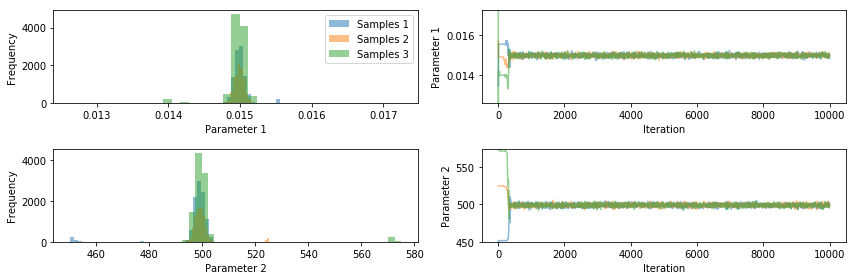

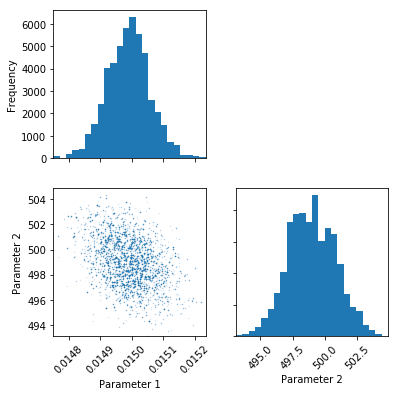

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0008593843129279, 1.0015374635537333]


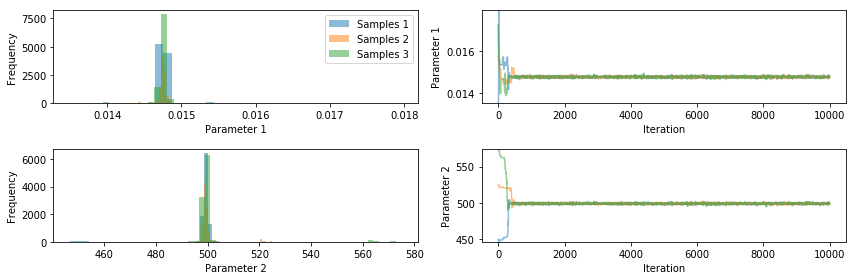

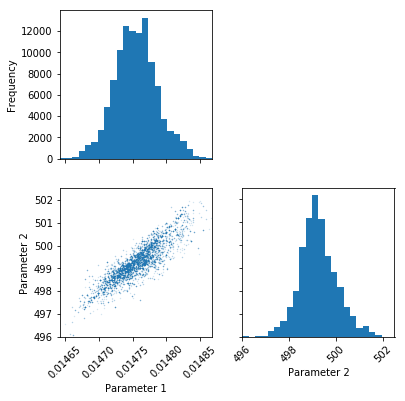

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

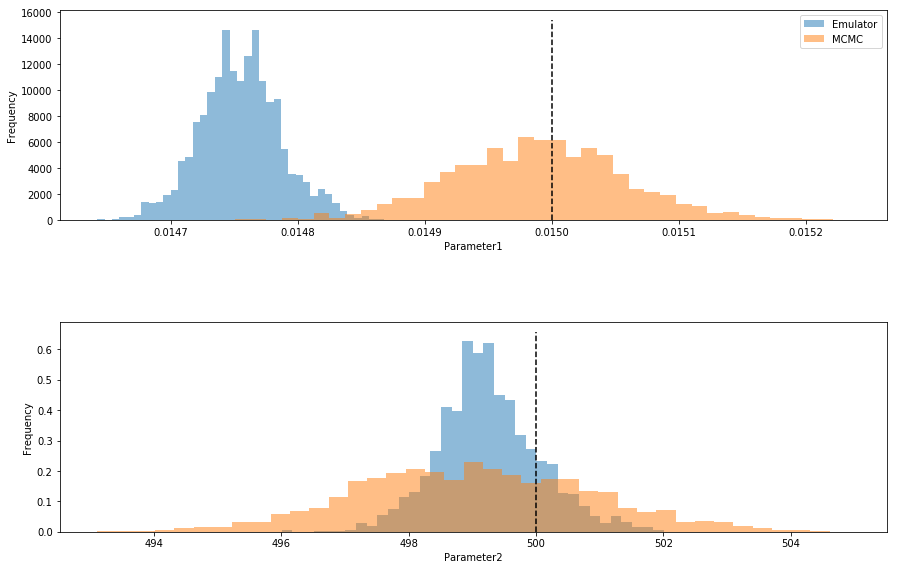

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

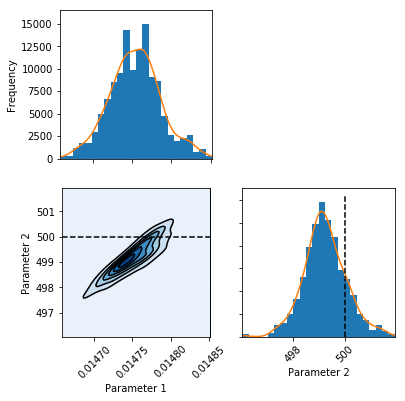

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

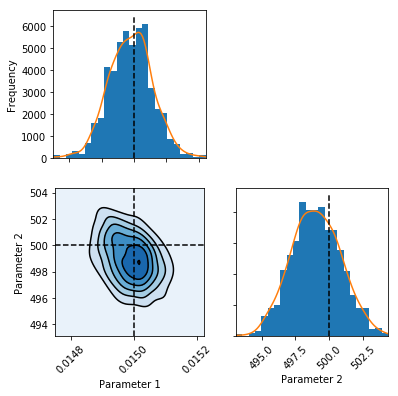

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

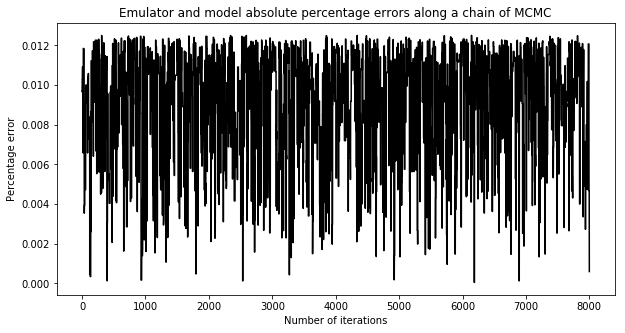

0.009161717660657336

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

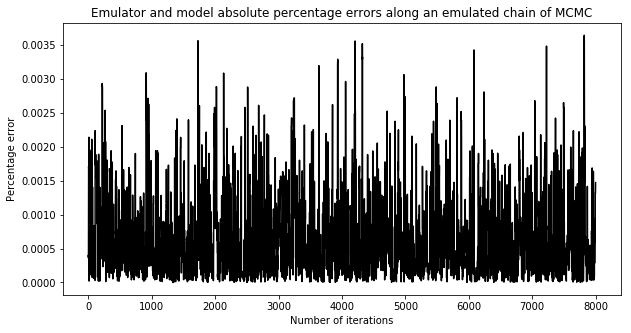

0.0006286571878562226

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

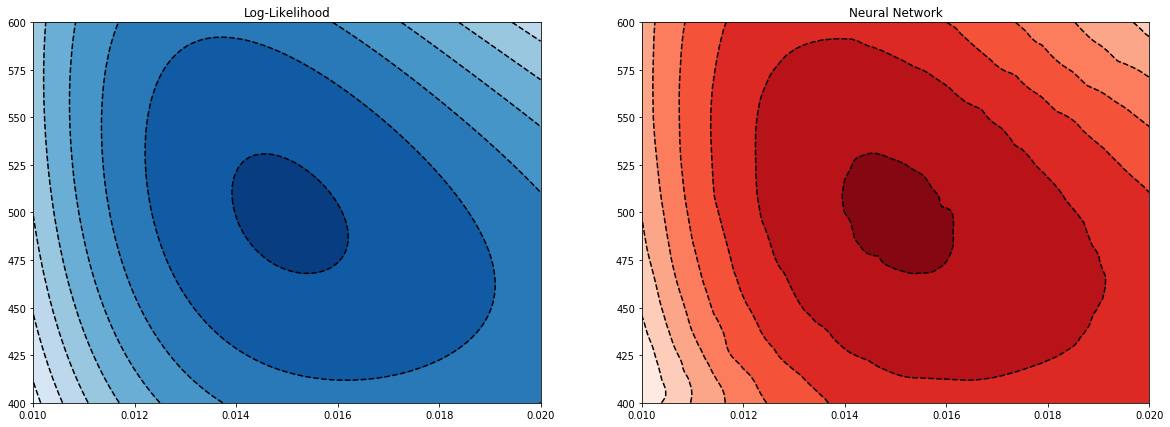

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

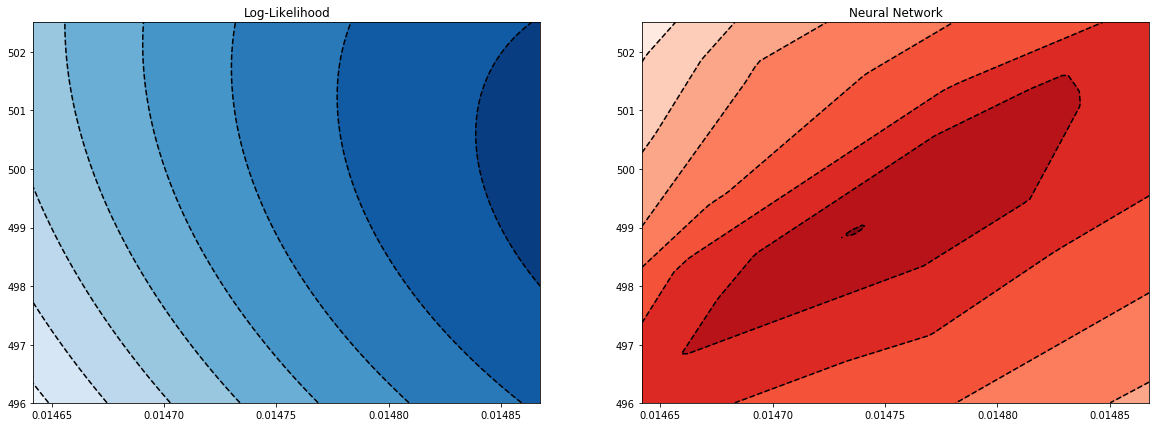

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

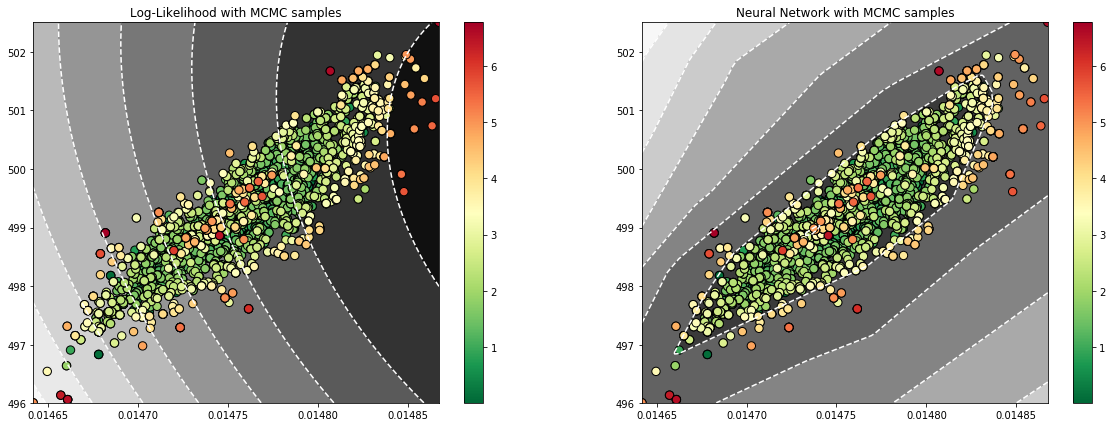

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-old-500-5perc.png", bbox_inches='tight', dpi=600)

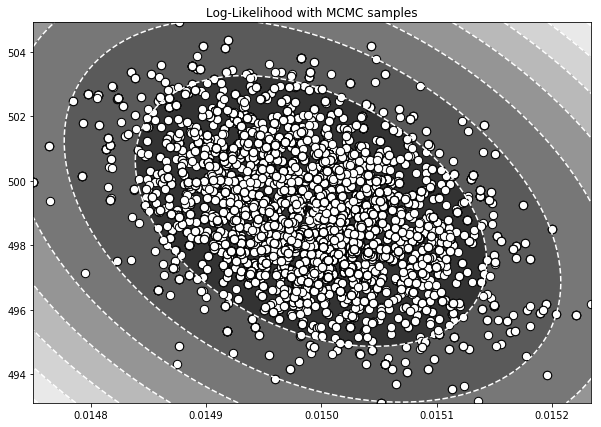

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()